In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras, time, sys, os, gc

DTYPE_OP = 'float32'
keras.backend.set_floatx(DTYPE_OP)

if DTYPE_OP == 'float64':
    keras.backend.set_epsilon(np.finfo(np.float64).eps)
elif DTYPE_OP == 'float32':
    keras.backend.set_epsilon(np.finfo(np.float32).eps)
    

from sklearn.preprocessing import StandardScaler
from code.MixtureofGroups import project_and_cluster,clusterize_annotators
from code.MixtureofGroups import *

from code.baseline import LabelInference
from code.representation import *
from code.utils import *

Using TensorFlow backend.
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/users/fmena/anaconda3/

### CIFAR-10 Test set
https://sites.google.com/site/hophuoctien/projects/virec/cifar10-classification

> Tien Ho-Phuoc, CIFAR10 to Compare Visual Recognition Performance between Deep Neural Networks and Humans, arXiv, 2018

In [95]:
from keras.datasets import cifar10
(_, _), (X_test, Z_test) = cifar10.load_data()
Z_test = Z_test[:,0]
N = X_test.shape[0]
print("Input shape:",X_test.shape)

Input shape: (10000, 32, 32, 3)


In [96]:
folder = "../New_CIFAR_test/"

In [103]:
from scipy.io import loadmat
#aux = loadmat(folder+"CIFAR10_EasySubset.mat")
aux = loadmat(folder+"CIFAR10_HumanRecogData.mat")
aux = aux["expData"][0][0][0]
T = 60 #60 annotations
y_obs = np.ones((N,T),dtype='int16')*-1
for annotation in aux:
    ann_id = annotation[0]-1
    cifar_indx = annotation[1]-1
    ann = annotation[2]-1
    y_obs[cifar_indx,ann_id] = ann

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

Kl = np.max(y_obs)+1 # asumiendo que estan ordenadas

print("shape:",y_obs.shape)

shape: (10000, 60)


Every data has 6 annotations, every annotator annotate 1000 data, T_weights = 1000, T_weights norm = 1/T

Representation for MV in 0.428602 sec
Estimation MV in 0.001044 sec
ACC MV on train: 0.9757
Normalized entropy (0-1) of repeats annotations: 0.05247443779676492


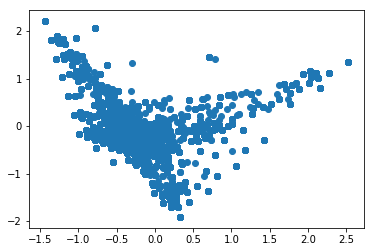

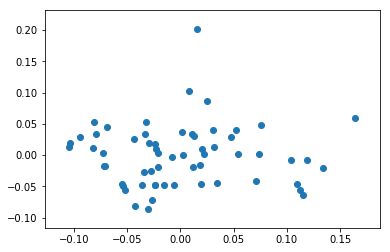

In [104]:
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot,_ = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_test))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()



Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

It look like there is a presence of groups...

### Fashion 10000
---
https://es.slideshare.net/mriegler/f10000  
dbgroup.cs.tsinghua.edu.cn/ligl/crowddata/  

> Fashion 10000: An Enriched Social Image Dataset for Fashion and Clothing


Q6: formal?

In [2]:
folder = "../Fashion10000/Annotations/"
folder = "Fashion10000/"

In [3]:
df_ann = pd.read_csv(folder+"MTurk_NonExperts_Results.csv")
print(df_ann.shape)
for i in range(1,5): #add photo id to extract image
    new_column = []
    for pic_url in df_ann["Input.Url"+str(i)].values:
        process = pic_url.split("/")[-1].split("_")[0] #extraer el id...
        new_column.append(int(process))
    df_ann["PHOTO_ID"+str(i)] = new_column
df_ann.head()

(24457, 64)


HITId                       HITTypeId  \
0  2BUF806UFBNFSU6QHDU9BSW83V41F0  2QKNDWIOV1S7SMT9PEL19YDZ81JIXX   
1  2BUF806UFBNFSU6QHDU9BSW83V41F0  2QKNDWIOV1S7SMT9PEL19YDZ81JIXX   
2  2BUF806UFBNFSU6QHDU9BSW83V41F0  2QKNDWIOV1S7SMT9PEL19YDZ81JIXX   
3  2I3Y58B727M0IF5GDBS64FSXVJZAVM  2QKNDWIOV1S7SMT9PEL19YDZ81JIXX   
4  2I3Y58B727M0IF5GDBS64FSXVJZAVM  2QKNDWIOV1S7SMT9PEL19YDZ81JIXX   

                                               Title  \
0  Check images of clothing items and fashion acc...   
1  Check images of clothing items and fashion acc...   
2  Check images of clothing items and fashion acc...   
3  Check images of clothing items and fashion acc...   
4  Check images of clothing items and fashion acc...   

                                         Description  \
0  In this HIT we show you 4 images and we want t...   
1  In this HIT we show you 4 images and we want t...   
2  In this HIT we show you 4 images and we want t...   
3  In this HIT we show you 4 images and we want t...   
4  In this HIT we show you 4 images and we want t...   

                                            Keywords Reward  \
0  fashion, image annotation, clothing, image, ta...  $0.09   
1  fashion, image annotation, clothing, image, ta...  $0.09   
2  fashion, image annotation, clothing, image, ta...  $0.09   
3  fashion, image annotation, clothing, image, ta...  $0.09   
4  fashion, image annotation, clothing, image, ta...  $0.09   

                   CreationTime  MaxAssignments RequesterAnnotation  \
0  Tue Jun 25 17:00:45 GMT 2013               3    BatchId:1189029;   
1  Tue Jun 25 17:00:45 GMT 2013               3    BatchId:1189029;   
2  Tue Jun 25 17:00:45 GMT 2013               3    BatchId:1189029;   
3  Tue Jun 25 17:00:45 GMT 2013               3    BatchId:1189029;   
4  Tue Jun 25 17:00:45 GMT 2013               3    BatchId:1189029;   

   AssignmentDurationInSeconds     ...      Answer.specialty3  \
0                          900     ...                     No   
1                          900     ...                     No   
2                          900     ...                     No   
3                          900     ...                     No   
4                          900     ...                     No   

  Answer.specialty4  Answer.type1  Answer.type2 Answer.type3  Answer.type4  \
0                No        notapp        notapp          yes           yes   
1                No        notapp        notapp           no            no   
2           NotSure      noperson      noperson       notapp        notapp   
3                No      noperson      noperson           no      noperson   
4                No      noperson      noperson          yes      noperson   

    PHOTO_ID1   PHOTO_ID2   PHOTO_ID3   PHOTO_ID4  
0  3147969538  3504068315  3533130703  3533131723  
1  3147969538  3504068315  3533130703  3533131723  
2  3147969538  3504068315  3533130703  3533131723  
3  5805025859  5829762711  6115511126  6308843053  
4  5805025859  5829762711  6115511126  6308843053  

[5 rows x 68 columns]

In [4]:
#photos ids distintas
photo_ids = {}
for i in range(1,5):
    for value in df_ann["PHOTO_ID"+str(i)].values:
        if value in photo_ids:
            photo_ids[value] +=1
        else:
            photo_ids[value] = 1 #counts

idx_ann =  {value:i for i,value in enumerate(df_ann["WorkerIndex"].unique())}
num_data = {value:i for i,value in enumerate(list(photo_ids.keys())) }
images_path = np.asarray([value for value in list(photo_ids.keys()) ])

N = len(num_data)
T = len(idx_ann)

In [ ]:
folders = os.listdir("./Fashion10000/Photos/")
files_found = {}
for folder in folders:
    to_found = "Fashion10000/Photos/"+folder+"/"
    #files_found += [to_found+aux for aux in os.listdir(to_found)]
    for aux in os.listdir(to_found):
        files_found[int(aux.split(".")[0])] = folder+"/"+aux
files_found #todas las fotos que hay...
files_data = []

n_missed = 0
for value in images_path:
    try:
        files_data.append(files_found[value])
    except:
        #print("No encontro")
        files_found[value] = "error"
        n_missed+=1
print("No encontro %d fotos"%n_missed)
files_found

In [ ]:
imgpath_all = list(map( lambda x: files_found[x], images_path))
with open("./Fashion10000/imgpath_all.txt", 'w') as fp:
    fp.write("\n".join(imgpath_all)) #all

In [53]:
#which answer take: related (Q1), numpeople (Q3), type (Q4), formal (Q6)

aux = df_ann["Answer.related1"].unique() #que es prof (Q5)?, specialty (Q2)?
label_names = aux[~pd.isna(aux)]
classes = {value.lower():i for i,value in enumerate(label_names)}
classes[np.nan] = -1
classes

{nan: -1, 'no': 0, 'notsure': 2, 'yes': 1}

In [54]:
df["Majority Q1"].unique() 

array(['no', 'yes', nan, 'notsure'], dtype=object)

All data:  (31077,)
Data with GT:  (29577,)


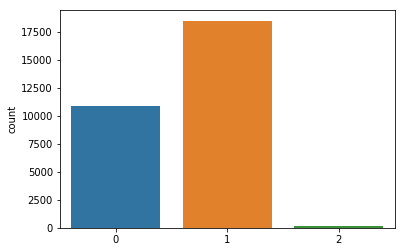

In [55]:
#probabbly ground truth
df = pd.read_csv(folder+"Annotation_PerImage_All.csv") 
new_column = []
for dato in df.values:
    pic_url = dato[0] #picture url
    process = pic_url.split("/")[-1].split("_")[0] #extraer el id...
    new_column.append(int(process))
df["PHOTO_ID"] = new_column

Z_data = np.ones((N,),dtype='int16')*-1
for i in range(df.shape[0]):
    row = df.iloc[i]
    #Majority Q6 is formal
    if classes[row["Majority Q1"]]!=-1: #only data that majority is reached
        Z_data[num_data[row["PHOTO_ID"]]] = classes[row["Majority Q1"]]

print("All data: ",Z_data.shape)

mask_gt = Z_data != -1
#Z_data = Z_data[mask_gt] #data with gt
print("Data with GT: ",Z_data[mask_gt].shape)

np.savetxt("./Fashion10000/Z_data_Q1.txt", Z_data,delimiter=' ', fmt='%d')

sns.countplot(Z_data[mask_gt])

In [56]:
y_obs = np.ones((N,T),dtype='int16')*-1
for i in range(df_ann.shape[0]):
    row = df_ann.iloc[i]
    ann_id = idx_ann[row["WorkerIndex"]]
    for j in range(1,4+1):
        fashion_indx = num_data[row["PHOTO_ID"+str(j)]]
        try:
            ann = classes[row["Answer.related"+str(j)]] #which we are using?
        except:
            ann = classes[row["Answer.related"+str(j)].lower()] #which we are using?
        y_obs[fashion_indx,ann_id] = ann
        
y_obs = y_obs[mask_gt] #ojo.. elimina datos sin GT...

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs = y_obs[:,T_weights!=0]
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

K = np.max(y_obs)+1 # asumiendo que estan ordenadas

print("shape:",y_obs.shape)
y_obs

Remove 29 annotators that do not annotate on this set 
shape: (29577, 1441)


array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int16)

Representation for MV in 1.657761 sec
Estimation MV in 0.002167 sec


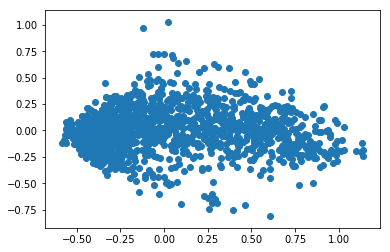

In [95]:
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, _ = label_I.mv_labels('classes')

Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_onehot)
A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show() 

Representation for MV in 1.433987 sec
Estimation MV in 0.001969 sec


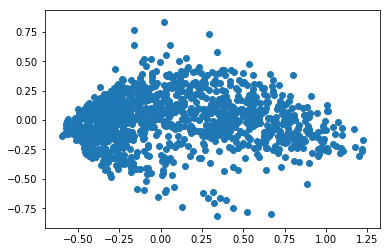

In [97]:
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, _ = label_I.mv_labels('classes')

Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_onehot)
A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show() ## elimiando datos sin GT

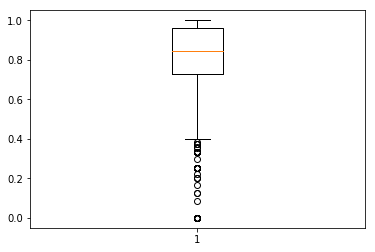

Deleted data (maybe test):  9206
shape: (16949, 533)


array([0.85907859, 0.88268156, 0.57692308, ..., 1.        , 1.        ,
       0.33333333])

In [18]:
acc_t = []
for t in range(y_obs.shape[1]):
    mask_labels = y_obs[:,t] != -1
    acc_t.append(np.mean(y_obs[:,t][mask_labels]==Z_data[mask_gt][mask_labels]))
acc_t = np.asarray(acc_t)
plt.boxplot(acc_t)
plt.show()

#delete good annotators.. (close to gt) u otra forma...
y_obs_new = y_obs.copy()
mask_bad_ann = acc_t < 0.85 #80-85
y_obs_new = y_obs_new[:,mask_bad_ann]
N_ann_mask = np.sum(y_obs_new != -1,axis=1) != 0 #distribucion de anotaciones con este valor
print("Deleted data (maybe test): ",np.sum(~ N_ann_mask))
y_obs_new = y_obs_new[N_ann_mask,:]
print("shape:",y_obs_new.shape)

acc_t

In [58]:
##based on good anotations
y_obs_new = y_obs.copy()
aux_Z = Z_data[mask_gt]

prob_fail = 0.6
for i in range(y_obs_new.shape[0]):
    annotations = y_obs_new[i,:]
    ann_t =  annotations != -1 #if annotate    
    good_t =  annotations == aux_Z[i] #if was good annotation
    mask_t = ann_t & good_t #candidate to removal
    
    T_rand = np.random.rand(annotations[mask_t].shape[0])
    mask_fail = T_rand <= prob_fail #prob of removal
    
    #while( np.sum(~mask_fail) == 0):
        #T_rand = np.random.rand(annotations[mask_t].shape[0])
    #    mask_fail[np.random.randint(mask_fail.shape[0])] = False #T_rand <= prob_fail #prob of removal
        
    mask_t[mask_t] = mask_fail #set if remove or no
    
    y_obs_new[i, mask_t] = -1
                
#delete good annotators.. (close to gt) u otra forma...
N_ann_mask = np.sum(y_obs_new != -1,axis=1) != 0 #distribucion de anotaciones con este valor
print("Deleted data (maybe test): ",np.sum(~ N_ann_mask))
y_obs_new = y_obs_new[N_ann_mask,:]
T_weights = np.sum(y_obs_new != -1,axis=0) #distribucion de anotaciones
print("Remove %d annotators that do not annotate on this set "%(np.sum(T_weights==0)))
y_obs_new = y_obs_new[:,T_weights!=0]

print("shape:",y_obs_new.shape,"\n")

label_I = LabelInference(y_obs_new,1,type_inf = 'mv')
mv_onehot, _ = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_data[mask_gt][N_ann_mask]))

Deleted data (maybe test):  4037
Remove 42 annotators that do not annotate on this set 
shape: (25540, 1399) 

Representation for MV in 0.416251 sec
Estimation MV in 0.001243 sec
ACC MV on train: 0.7575567736883321


Representation for MV in 0.578591 sec
Estimation MV in 0.001614 sec
ACC MV on train: 0.7147020844862572
Normalized entropy (0-1) of repeats annotations: 0.32627983134476285


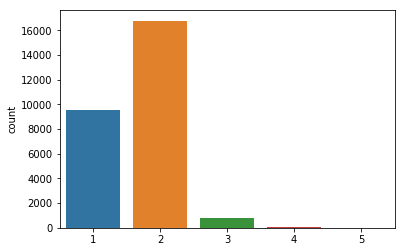

Minimum annotations in a example:  1
Maximum annotations in a example:  5
T data (expected value):  1.6819037078029884
Graphics of T weights


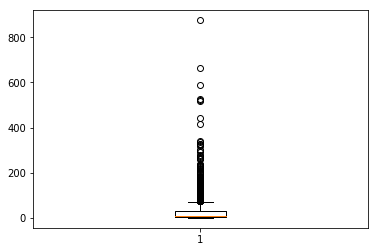

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  875
Mean annotations by an annotator:  32.8207343412527


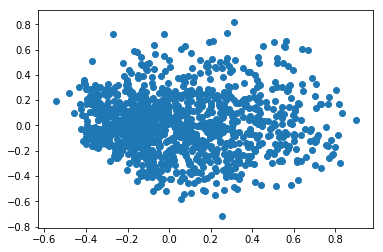

In [26]:
label_I = LabelInference(y_obs_new,1,type_inf = 'mv')
mv_onehot, _ = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_data[mask_gt][N_ann_mask]))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

#graphics and distribution? what is T_data
N_ann = np.sum(y_obs_new != -1,axis=1) #distribucion de anotaciones con este valor
sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

T_weights = np.sum(y_obs_new != -1,axis=0) #distribucion de anotaciones
print("Graphics of T weights")
plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Y_ann_train, T_idx = set_representation(y_obs_new,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

In [ ]:
np.savetxt("./Fashion10000/answers_0.6_Q1.txt", y_obs_new, delimiter=' ', fmt='%d')

mask_train = np.zeros_like(mask_gt)
mask_train[mask_gt] = N_ann_mask

mask_test= np.zeros_like(mask_gt)
mask_test[mask_gt] = ~N_ann_mask

mask_sets = np.asarray(["aux" for _ in range(mask_gt.shape[0])]).astype("U5")
mask_sets[mask_train] = "train"
mask_sets[mask_test] = "test"

np.savetxt("./Fashion10000/sets_0.6_Q1.txt", mask_sets,delimiter=' ', fmt='%s')
mask_sets

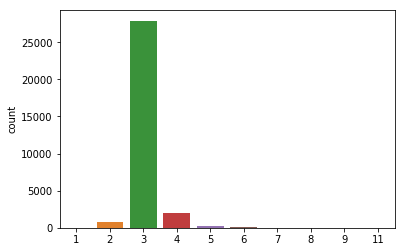

Minimum annotations in a example:  1
Maximum annotations in a example:  11
T data (expected value):  3.0664478553270906
Graphics of T weights


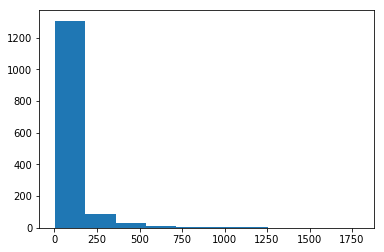

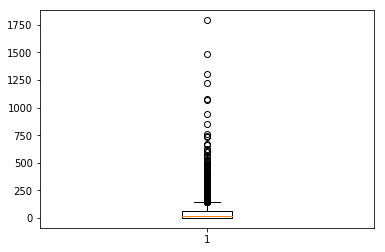

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  1791
Mean annotations by an annotator:  65.67608545830461


In [90]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 1.497437 sec
Estimation MV in 0.002568 sec
ACC MV on train: 0.9944178933282355
Normalized entropy (0-1) of repeats annotations: 0.18531239514749437


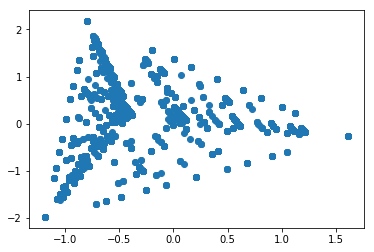

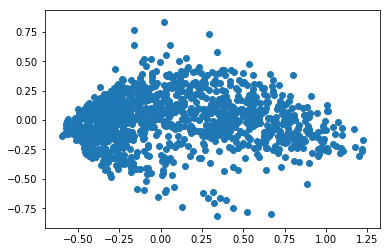

In [85]:
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, _ = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_data[mask_gt]))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))


predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

It does not look promesing that contain groups...

### GalaxyZoo
---
to download images: https://astroquery.readthedocs.io/en/latest/sdss/sdss.html  
annot data: https://data.galaxyzoo.org/  
Kaggle data: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge  

In [4]:
folder ="../GalaxyZoo_kaggle/"
train_labels = pd.read_csv(folder+"train_labels.csv")
test_labels = pd.read_csv(folder+"test_labels.csv")
print(train_labels.shape)
train_labels.head()

(50000, 38)


GalaxyID  Answer1.1  Answer1.2  Answer1.3  Answer2.1  Answer2.2  Answer3.1  \
0    569297   0.083065   0.916935   0.000000   0.023551   0.893384   0.107109   
1    701332   0.275109   0.713127   0.011765   0.633523   0.079604   0.079604   
2    908039   0.411643   0.587223   0.001134   0.234878   0.352345   0.000000   
3    401459   0.013316   0.986684   0.000000   0.000000   0.986684   0.753419   
4    607293   0.829407   0.128859   0.041733   0.021519   0.107340   0.000000   

   Answer3.2  Answer4.1  Answer4.2     ...      Answer9.3  Answer10.1  \
0   0.786276   0.714189   0.179195     ...       0.000000    0.459257   
1   0.000000   0.000000   0.079604     ...       0.499005    0.000000   
2   0.352345   0.205471   0.146874     ...       0.026647    0.205471   
3   0.233265   0.986684   0.000000     ...       0.000000    0.350273   
4   0.107340   0.000000   0.107340     ...       0.000000    0.000000   

   Answer10.2  Answer10.3  Answer11.1  Answer11.2  Answer11.3  Answer11.4  \
0    0.254932    0.000000    0.000000    0.504446    0.000000         0.0   
1    0.000000    0.000000    0.000000    0.000000    0.000000         0.0   
2    0.000000    0.000000    0.000000    0.000000    0.000000         0.0   
3    0.381847    0.254564    0.191225    0.508621    0.095613         0.0   
4    0.000000    0.000000    0.000000    0.000000    0.000000         0.0   

   Answer11.5  Answer11.6  
0         0.0    0.209744  
1         0.0    0.000000  
2         0.0    0.205471  
3         0.0    0.191225  
4         0.0    0.000000  

[5 rows x 38 columns]

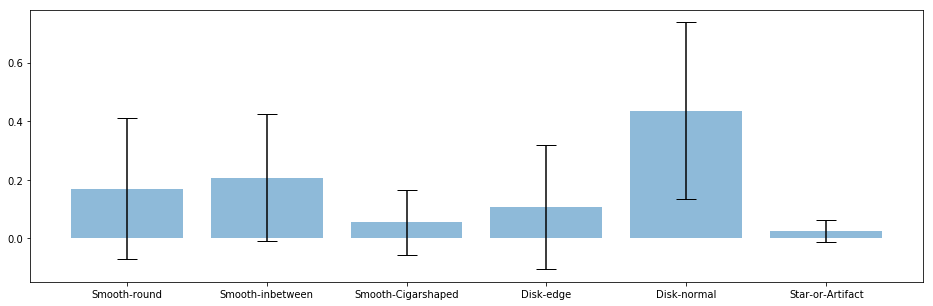

In [6]:
labels = ["Smooth-round","Smooth-inbetween","Smooth-Cigarshaped","Disk-edge","Disk-normal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer2.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

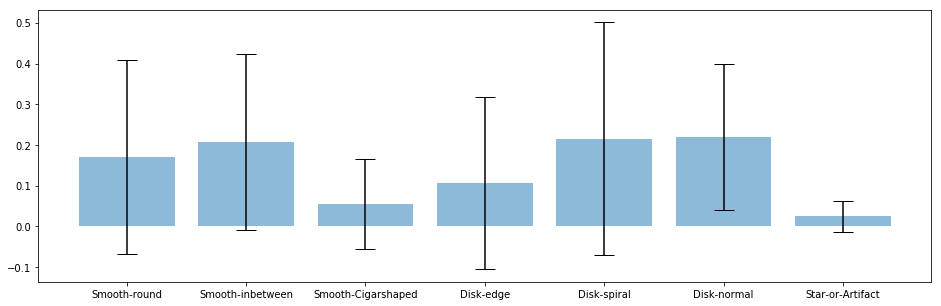

In [11]:
#granulada
labels = ["Smooth-round","Smooth-inbetween","Smooth-Cigarshaped","Disk-edge","Disk-spiral","Disk-normal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer4.1","Answer4.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

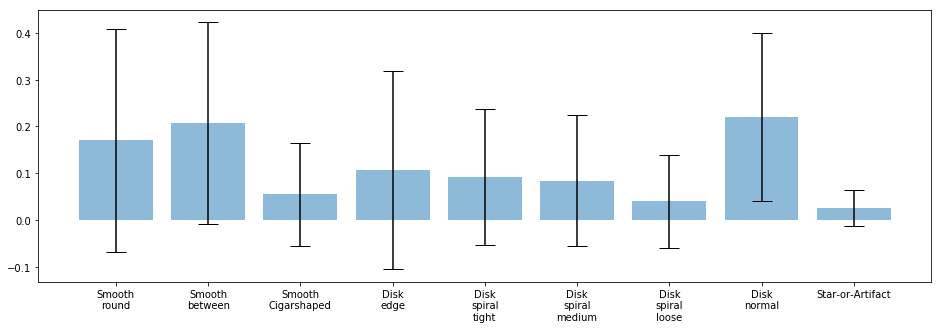

In [13]:
#mas granulada
labels = ["Smooth\nround","Smooth\nbetween","Smooth\nCigarshaped","Disk\nedge","Disk\nspiral\ntight","Disk\nspiral\nmedium","Disk\nspiral\nloose","Disk\nnormal","Star-or-Artifact"]

columns = ["Answer7.1","Answer7.2","Answer7.3","Answer2.1","Answer10.1","Answer10.2","Answer10.3","Answer4.2","Answer1.3"]
y_train = train_labels.loc[:,columns].values
y_test = test_labels.loc[:,columns].values

plt.figure(figsize=(16,5))
plt.bar(np.arange(y_train.shape[1]),np.mean(y_train,axis=0), yerr=np.std(y_train,axis=0),alpha=0.5,capsize=10)
plt.xticks(np.arange(y_train.shape[1]),labels)
plt.show()

In [58]:
aux = pd.read_csv(folder+"/GalaxyZoo1_DR_table3.csv.gz")
print(aux.shape)
print("T_data=",np.mean(aux["NVOTE"]))
print("max(T_data)=",np.max(aux["NVOTE"]))
print("min(T_data)=",np.min(aux["NVOTE"]))
aux.head()

(225268, 11)
T_data= 38.74157891933164
max(T_data)= 93
min(T_data)= 7


OBJID           RA          DEC  NVOTE   P_EL   P_CW  P_ACW  \
0  587730774425665700  00:00:01.28  +15:04:40.8     73  0.479  0.000  0.000   
1  587727220876640877  00:00:01.86  +14:01:28.2     29  0.655  0.000  0.000   
2  587727180060098742  00:00:02.15  -09:31:37.0     30  0.467  0.000  0.033   
3  588015509806252142  00:00:02.28  +00:37:39.2     29  0.655  0.034  0.034   
4  587731187277627683  00:00:02.96  +00:43:04.8     24  0.583  0.000  0.083   

   P_EDGE   P_DK   P_MG   P_CS  
0   0.014  0.479  0.027  0.014  
1   0.000  0.345  0.000  0.000  
2   0.000  0.467  0.033  0.033  
3   0.103  0.172  0.000  0.172  
4   0.167  0.125  0.042  0.250

In [59]:
#T is aprox 100 000
T_data = 39
r_obs = y_train*T_data  #assuming 39 annotations by data -- maybe sampling..
r_obs = np.round(r_obs).astype('int')

K = r_obs.shape[1]
N = r_obs.shape[0]

print("repeats shape: ",r_obs.shape)
print("Classes: ",K)

repeats shape:  (50000, 9)
Classes:  9


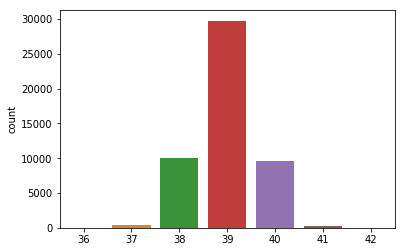

Minimum annotations in a example:  36
Maximum annotations in a example:  42
T data (expected value):  38.98852


In [60]:
#graphics and distribution? what is T_data
N_ann = np.sum(r_obs,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

Normalized entropy (0-1) of repeats annotations: 0.5286125459892007


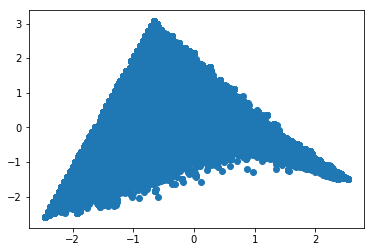

In [61]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

due to the density of annotations there is a chance that there are groups presented or maybe discovered..

### NER MTurk
---

cómo representar "X"

In [2]:
folder = "../Probar/20_dataArchive/"

df1 = pd.read_csv(folder+"/ner_mturk/mturk/Batch_213638_result.csv") 
df2 = pd.read_csv(folder+"/ner_mturk/mturk/Batch_229788_result.csv") 
df3 = pd.read_csv(folder+"/ner_mturk/mturk/Batch_230657_result.csv") 
df = pd.concat([df1,df2,df3],axis=0,ignore_index=True)
print(df.shape)
print(df["Description"][0])
df.head()

/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (170,171,172,182,187,188,189,190,191,194,195,197,199,201,203,205,206,207,209,210,211,212,214,215,216,217,218,219,220,221,222,224,225,227,229,230,233,235,236,237,239,240,242,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,261,262,263,264,265,266,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (254,255,281,339,340,341,343,344,345,346,349,350,351,354,355,356,357,358) have mixed types. Specify

(6160, 364)
Given a Twitter status message, select words that refer to people, places, and organizations.


AcceptTime  Answer.TID1  Answer.TID2  Answer.TID3  \
0  Fri Mar 26 07:00:48 GMT 2010       115512       115647       117353   
1  Fri Mar 26 07:07:13 GMT 2010       115512       115647       117353   
2  Thu Mar 25 22:48:12 GMT 2010       953212       115683       114681   
3  Fri Mar 26 02:04:23 GMT 2010       953212       115683       114681   
4  Fri Mar 26 07:51:00 GMT 2010       116704      1299720       115461   

   Answer.TID4  Answer.TID5  \
0      1386721       114959   
1      1386721       114959   
2       115457       115780   
3       115457       115780   
4       114494       115261   

                                  Answer.browserInfo Answer.city  \
0  Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...     Seattle   
1  Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...        Mesa   
2                                                NaN         NaN   
3  Mozilla/5.0 (Windows; U; Windows NT 6.0; en-US...     Spokane   
4  Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US...       Salem   

  Answer.country  Answer.ipAddress       ...       NumberOfSimilarHITs Reject  \
0  United States               NaN       ...                       133    NaN   
1  United States               NaN       ...                       133    NaN   
2            NaN               NaN       ...                       244    NaN   
3  United States               NaN       ...                       244    NaN   
4          India               NaN       ...                        11    NaN   

  RejectionTime RequesterAnnotation RequesterFeedback Reward  \
0           NaN                 NaN               NaN  $0.05   
1           NaN                 NaN               NaN  $0.05   
2           NaN                 NaN               NaN  $0.05   
3           NaN                 NaN               NaN  $0.05   
4           NaN                 NaN               NaN  $0.05   

                     SubmitTime                                 Title  \
0  Fri Mar 26 07:01:04 GMT 2010  Label named entities in Twitter data   
1  Fri Mar 26 07:07:32 GMT 2010  Label named entities in Twitter data   
2  Thu Mar 25 22:48:30 GMT 2010  Label named entities in Twitter data   
3  Fri Mar 26 02:05:34 GMT 2010  Label named entities in Twitter data   
4  Fri Mar 26 07:51:57 GMT 2010  Label named entities in Twitter data   

  WorkTimeInSeconds        WorkerId  
0                16    AL8CK436OAAS  
1                19  A2IUEI1BFHCVBR  
2                18   AN81OMLNG792S  
3                71   A9Y7WSKEUTLSG  
4                57   ARUUP1I9I765J  

[5 rows x 364 columns]

In [3]:
worker2ind = {value:i for i,value in enumerate(df["WorkerId"].unique())}
T = len(list(worker2ind.values()))
id_data = set(df["Answer.TID1"]) | set(df["Answer.TID2"]) | set(df["Answer.TID3"]) | set(df["Answer.TID4"]) | set(df["Answer.TID5"])

answers = np.ones((len(id_data),T),dtype='int16')*-1
answers

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int16)

In [4]:
import ast 

In [28]:
worker2ind

{'A108MS9X4JQ31C': 192,
 'A10GFVUN24Q71V': 248,
 'A11XA5JEXPZ0KU': 53,
 'A122B7AN31VJLB': 103,
 'A12CJNE0B9FLK8': 137,
 'A12LJL2ESEI6Y5': 77,
 'A131N3IB2F9DNJ': 95,
 'A146V5EFMA15XB': 34,
 'A14WWG6NKBDWGP': 166,
 'A153QSGVGLWKR6': 218,
 'A15Z06PIDEJT38': 59,
 'A16C1JJWHEU02G': 239,
 'A171JY5QWKQR8X': 102,
 'A17QLPGYGPYSQI': 66,
 'A17R8JHE5H8SYH': 114,
 'A17V9UJOCSM3OF': 68,
 'A18SOP2YLC0HZN': 193,
 'A18WWWZ1HRBG0V': 84,
 'A198YDDSSOBP8A': 238,
 'A19I5GDQ2AL0HF': 18,
 'A19MOSX3XM0PEY': 188,
 'A19OOK4MQ6RKIP': 8,
 'A19P6Q6PRNNJPZ': 127,
 'A19X7JVVC3CZMZ': 31,
 'A1A5QGCFNSF75G': 51,
 'A1B4J1HUDTQ5J0': 52,
 'A1B72GLF6DS21Y': 257,
 'A1BLX6S1YBA7Y8': 219,
 'A1BOPXWO3VOVZL': 148,
 'A1BPG9BBLYPIAD': 23,
 'A1CCJXYEMTU2RR': 185,
 'A1D67BJW63N47G': 172,
 'A1E61YLCV0PDFU': 235,
 'A1F0WAU8ZNOJFT': 213,
 'A1FAASLGTOMXO9': 241,
 'A1FP00QXS43PZ': 126,
 'A1FS5EXKNSINCF': 232,
 'A1G4NBA96061F3': 94,
 'A1GISOQV9E61KD': 43,
 'A1GRZQJP0NUN3Y': 17,
 'A1H0X3XRHYZ3XQ': 110,
 'A1H35C0LXHFR1M': 64,
 'A1H6SYVQAN

In [94]:
def sub_find(data,lista):
    aux = []
    for value in lista:
        if data in value and "unsure" not in value:
            aux.append(value)
    return aux
columns = list(df.columns)

train_texts = {value:0 for value in id_data}
answers_dic = {value:[] for value in id_data}
for i in range(df.shape[0]):
    id_worker = worker2ind[df.loc[i,"WorkerId"]]
    for k in range(0,5):
        id_aux = df.loc[i,"Answer.TID"+str(k+1)]
        if train_texts[id_aux] == 0:
            train_texts[id_aux] = ast.literal_eval(df.loc[i,"Input.tweet"+str(k)])
        len_i = len(train_texts[id_aux])
        
        if len(answers_dic[id_aux]) == 0:
            answers_dic[id_aux] = np.asarray([ ["?"]*T ]*len_i,dtype='object')
        
        aux_list = []
        for i_d in range(len_i):
            #palabra para un tweet
            #print( answers_dic[id_aux][i_d])
            if not pd.isna(df.loc[i,"Answer.tweet"+str(k)+"word"+str(i_d)]):
                answers_dic[id_aux][i_d,id_worker] = df.loc[i,"Answer.tweet"+str(k)+"word"+str(i_d)]
            #y si ya tiene?
            

In [95]:
X_train_texts = list(train_texts.values())
answers = list(answers_dic.values())

In [49]:
X_train_texts[1]

['Analysis:',
 "Obama''s",
 'centrist',
 'emphasis',
 'gives',
 'GOP',
 'ammo',
 '\\n',
 '(AP)\\n:',
 'AP',
 '-',
 'Is',
 'Barack',
 'Obama',
 'close',
 'to',
 'being',
 'shadowed',
 'by',
 'giant',
 'flip-flops',
 '',
 '',
 '']

In [57]:
answers[1]

array([['?', '?', '?', ..., '?', '?', '?'],
       ['?', '?', '?', ..., '?', '?', '?'],
       ['?', '?', '?', ..., '?', '?', '?'],
       ...,
       ['?', '?', '?', ..., '?', '?', '?'],
       ['?', '?', '?', ..., '?', '?', '?'],
       ['?', '?', '?', ..., '?', '?', '?']], dtype=object)

In [83]:
labels
label2ind = {label: (index) for index, label in enumerate(labels)}
ind2label = {(index): label for index, label in enumerate(labels)}
label2ind

{'none': 0, 'org': 1, 'person': 2, 'place': 3}

In [92]:
for dato in answers:
    for palabra in dato:
        for annotation in palabra:
            if pd.isna(annotation):
                print("Hay")

Hay
Hay
Hay
Hay
Hay
Hay
Hay
Hay
Hay
Hay


KeyboardInterrupt: 

In [96]:
y_obs = np.asarray([ [label2ind[annotation] if annotation != "?" else -1 for annotation in palabra] for dato in answers for palabra in dato])
N,T = y_obs.shape
print(N,T)
y_obs

205282 269


array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

In [58]:
df_g = pd.read_csv(folder+"/ner_mturk/inputs/Gold.csv") 
print(df_g.shape)
df_g.head()

(441, 82)


HITId                       HITTypeId  \
0  1V9S0WR1Y69H2PA0OW1VNI62NNMD5T  1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG   
1  1P0UL3JPGT3HCPSUWLRFEJ9IOFFAME  1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG   
2  1F84T485IRVF6BM7RY9T4TJFDKAFS8  1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG   
3  16QPTX5PKYSX67A9W9Q0E6UTOAPALC  1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG   
4  170HZD1E9YM18Z3OQHRJSPSI2OUA4J  1PG4GVIAJYO5H8LCGDJNWKIN3TOVTG   

                                  Title  \
0  Label named entities in Twitter data   
1  Label named entities in Twitter data   
2  Label named entities in Twitter data   
3  Label named entities in Twitter data   
4  Label named entities in Twitter data   

                                         Description               Keywords  \
0  Given a Twitter status message, select words t...  twitter, named entity   
1  Given a Twitter status message, select words t...  twitter, named entity   
2  Given a Twitter status message, select words t...  twitter, named entity   
3  Given a Twitter status message, select words t...  twitter, named entity   
4  Given a Twitter status message, select words t...  twitter, named entity   

  Reward                  CreationTime  MaxAssignments  RequesterAnnotation  \
0  $0.01  Thu Mar 18 01:39:47 GMT 2010               1                  NaN   
1  $0.01  Thu Mar 18 01:39:47 GMT 2010               1                  NaN   
2  $0.01  Thu Mar 18 01:39:47 GMT 2010               1                  NaN   
3  $0.01  Thu Mar 18 01:39:47 GMT 2010               1                  NaN   
4  $0.01  Thu Mar 18 01:39:44 GMT 2010               1                  NaN   

   AssignmentDurationInSeconds  ...    Answer.word28 Answer.unsure4  \
0                          600  ...              NaN            NaN   
1                          600  ...              NaN            NaN   
2                          600  ...              NaN            NaN   
3                          600  ...              NaN            NaN   
4                          600  ...              NaN            NaN   

   Answer.word29  Answer.unsure6 Answer.unsure15 Answer.unsure9  \
0            NaN             NaN             NaN            NaN   
1            NaN             NaN             NaN            NaN   
2            NaN             NaN             NaN            NaN   
3            NaN             NaN             NaN            NaN   
4            NaN             NaN             NaN            NaN   

  Answer.unsure19 Answer.unsure20 Approve Reject  
0             NaN             NaN     NaN    NaN  
1             NaN             NaN     NaN    NaN  
2             NaN             NaN     NaN    NaN  
3             NaN             NaN     NaN    NaN  
4             NaN             NaN     NaN    NaN  

[5 rows x 82 columns]

In [81]:
test_texts = {value:0 for value in df_g["Answer.TID"].unique()}
test_gt = {value:0 for value in df_g["Answer.TID"].unique()}
labels = []
for i in range(df_g.shape[0]):
    id_aux = df_g.loc[i,"Answer.TID"]
    train_texts[id_aux] = ast.literal_eval(df_g.loc[i,"Input.json_words"])
        
    len_i = len(train_texts[id_aux])
    
    if test_gt[id_aux] == 0:
        test_gt[id_aux] = ["?"]*len_i

    aux_list = []
    for i_d in range(len_i):
        try:
            test_gt[id_aux][i_d] = df_g.loc[i,"Answer.word"+str(i_d)]
            if test_gt[id_aux][i_d] not in labels:
                labels.append(test_gt[id_aux][i_d])
        except:
             pass #unsure..
       

In [100]:
Z_test = np.asarray([label2ind[value] for lista in test_gt.values() for value in lista ])
Z_test.shape

(7037,)

In [101]:
Z_test

array([0, 0, 0, ..., 0, 0, 0])

In [102]:
label2ind

{'none': 0, 'org': 1, 'person': 2, 'place': 3}

In [84]:
def read_conll(filename):
    raw = open(filename, 'r').readlines()
    all_x = []
    point = []
    for line in raw:
        stripped_line = line.strip().split(' ')
        point.append(stripped_line)
        if line == '\n':
            if len(point[:-1]) > 0:
                all_x.append(point[:-1])
            point = []
    all_x = all_x
    return all_x

folder = "../Deep Learning from Crowds/ner-mturk/"

all_answers = read_conll(folder+'answers.txt') #annotations
all_ground_truth = read_conll(folder+'ground_truth.txt')

all_test = read_conll(folder+'testset.txt')
all_docs = all_ground_truth + all_test

print("Answers data size:", len(all_answers))
print("Ground truth data size:", len(all_ground_truth))
print("Test data size:", len(all_test))
print("Total sequences:", len(all_docs))

Answers data size: 5985
Ground truth data size: 5985
Test data size: 3250
Total sequences: 9235


In [124]:
X_train_texts = [[c[0] for c in x] for x in all_answers]
y_answers = [[c[1:] for c in y] for y in all_answers]
y_ground_truth = [[c[1] for c in y] for y in all_ground_truth]
X_test_texts = [[c[0] for c in x] for x in all_test]
y_test = [[c[1] for c in y] for y in all_test]
#X_all = [[c[0] for c in x] for x in all_docs]
#y_all = [[c[1] for c in y] for y in all_docs]

N_ANNOT = len(y_answers[0][0])
print("Num annnotators:", N_ANNOT)

lengths = [len(x) for x in all_docs]
all_text = [c for x in X_all for c in x]
words = list(set(all_text))
word2ind = {word: index for index, word in enumerate(words)}
ind2word = {index: word for index, word in enumerate(words)}
labels = list(set([c for x in y_all for c in x]))
print("Labels:", labels)
label2ind = {label: (index) for index, label in enumerate(labels)}
ind2label = {(index): label for index, label in enumerate(labels)}
#ind2label[0] = "O" # padding index
print('Input sequence length range: ', max(lengths), min(lengths))

max_label = max(label2ind.values()) + 1
print("Max label:", max_label)

maxlen = max([len(x) for x in X_all])
print('Maximum sequence length:', maxlen)

Num annnotators: 47
Labels: ['B-LOC', 'B-PER', 'B-ORG', 'O', 'I-ORG', 'B-MISC', 'I-MISC', 'I-PER', 'I-LOC']
Input sequence length range:  109 1
Max label: 9
Maximum sequence length: 109


In [99]:
X_all[:5]

[['Corporate', 'America', 'taking', 'new', 'view', 'on', 'compensation', '.'],
 ['Anne', 'Murray'],
 ['NEW', 'YORK', '1996-08-23'],
 ['Corporate',
  'America',
  'is',
  'planning',
  'major',
  'changes',
  'in',
  'employee',
  'compensation',
  'in',
  'the',
  'next',
  'few',
  'years',
  ',',
  'according',
  'to',
  'a',
  'recent',
  'study',
  '.'],
 ['What',
  'it',
  'comes',
  'down',
  'to',
  'is',
  'this',
  ':',
  'If',
  'you',
  "'re",
  'highly',
  'skilled',
  ',',
  'you',
  "'ll",
  'benefit',
  'nicely',
  '.']]

In [176]:
Z_train = np.asarray([label2ind[value] for lista in y_ground_truth for value in lista ])
Z_test = np.asarray([label2ind[value] for lista in y_test for value in lista ])
Z_train.shape

(79901,)

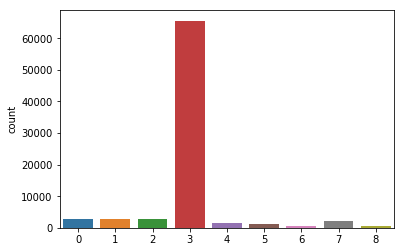

{0: 2929,
 1: 2808,
 2: 2779,
 3: 65546,
 4: 1544,
 5: 1343,
 6: 531,
 7: 1996,
 8: 425}

In [155]:
sns.countplot(Z_train)
plt.show()
unique, counts = np.unique(Z_train, return_counts=True)
dict(zip(unique, counts))

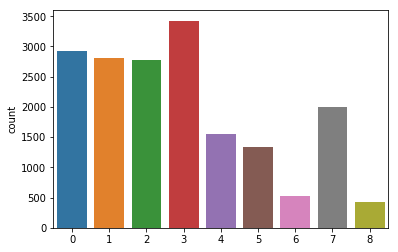

{0: 2929, 1: 2808, 2: 2779, 3: 3425, 4: 1544, 5: 1343, 6: 531, 7: 1996, 8: 425}

In [174]:
#delete "O" =?? o achicar la cantidad.. realizar lo mismos con test...
mask_notO = Z_train != 3
aux = np.random.choice(np.arange(Z_train.shape[0])[~mask_notO], 3500)

new_mask = mask_notO.copy()
new_mask[aux] = True #let 3000

sns.countplot(Z_train[new_mask])
plt.show()
unique, counts = np.unique(Z_train[new_mask], return_counts=True)
dict(zip(unique, counts))

In [157]:
y_obs = np.asarray([ [label2ind[annotation] if annotation != "?" else -1 for annotation in palabra] for dato in y_answers for palabra in dato])
N,T = y_obs.shape
print(N,T)
y_obs

79901 47


array([[ 3, -1, -1, ..., -1, -1,  3],
       [ 3, -1, -1, ..., -1, -1,  0],
       [ 3, -1, -1, ..., -1, -1,  3],
       ...,
       [-1, -1, -1, ..., -1, -1,  3],
       [-1, -1, -1, ..., -1, -1,  3],
       [-1, -1, -1, ..., -1, -1,  3]])

In [178]:
#aplied mask
Z_train = Z_train[new_mask]
y_obs = y_obs[new_mask]
N,T = y_obs.shape
print(N,T)

17780 47


array([[ 3, -1, -1, ..., -1, -1,  0],
       [ 1, -1, -1, ..., -1, -1,  3],
       [ 7, -1, -1, ..., -1, -1,  3],
       ...,
       [-1, -1, -1, ..., -1, -1,  1],
       [-1, -1, -1, ..., -1, -1,  3],
       [-1, -1, -1, ..., -1, -1,  3]])

In [ ]:
#how to build X??

In [102]:
X_train_enc = [[word2ind[c] for c in x] for x in X_train]
X_test_enc = [[word2ind[c] for c in x] for x in X_test]

NameError: name 'encode' is not defined

In [179]:
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
K = np.max(y_obs)+1 # asumiendo que estan ordenadas

y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)

shape: (17780, 47, 9)


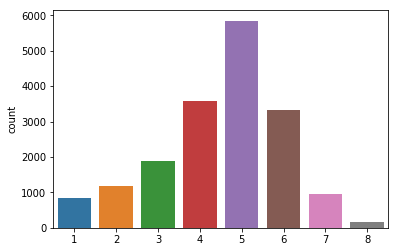

Minimum annotations in a example:  1
Maximum annotations in a example:  8
T data (expected value):  4.515466816647919
Graphics of T weights


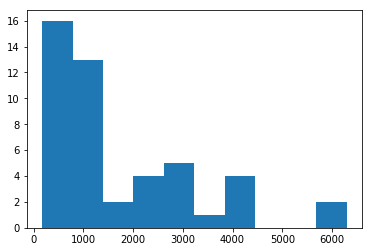

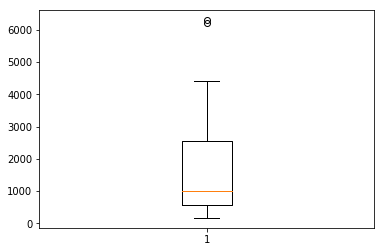

Minimum annotations by an annotator:  170
Maximum annotations by an annotator:  6293
Mean annotations by an annotator:  1708.1914893617022


In [180]:
#graphics and distribution? what is T_data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Bayesian gaussian mixture say is 8 clusters 
DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters


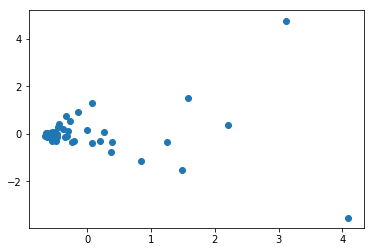

ACC MV on train: 0.6534308211473566
F1 MV on train: 0.6534308211473566
Normalized entropy (0-1) of repeats annotations: 0.19120196236851741


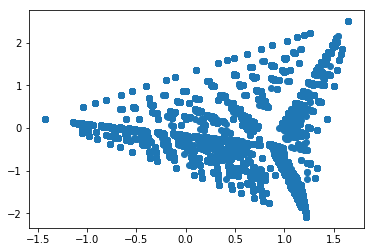

In [181]:
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_train))
print("F1 MV on train:",f1_score(Z_train,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))


predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

### Movie reviews
---
http://fprodrigues.com//publications/deep-crowds/
> Rodrigues, F., & Pereira, F. C. (2018, April). Deep learning from crowds. In Thirty-Second AAAI Conference on Artificial Intelligence. 

Necesario ver cómo discretizar..

In [3]:
folder = "../Deep Learning from Crowds/MovieReviews/"
def read_texts(filename):
    f = open(filename)
    data = [line.strip() for line in f]
    f.close()
    return data
texts_train = read_texts(folder+"texts_train.txt")
targets_train = np.loadtxt(folder+"ratings_train.txt")

texts_test = read_texts(folder+"texts_test.txt")
targets_test = np.loadtxt(folder+"ratings_test.txt")

print("Num. train texts: %d" % len(texts_train))
print("Num. test texts:  %d" % len(texts_test))

Num. train texts: 1498
Num. test texts:  3508


In [37]:
aux = pd.read_csv(folder+"Batch_results_AMT.csv") 
print(aux["Description"][0])
aux['WorkTimeInSeconds']

Given a short review text, predict the number of stars (from 0 to 10) that the movie got from that reviewer.


0          4
1         94
2         11
3         13
4          3
5         74
6          4
7         25
8          4
9          5
10        43
11         9
12         6
13         6
14         4
15        28
16         4
17         8
18         3
19         4
20         7
21         2
22         8
23         7
24         3
25        10
26        48
27         7
28        15
29         3
        ... 
7410       8
7411       6
7412      20
7413      48
7414       4
7415    1411
7416       6
7417      10
7418      15
7419       6
7420       3
7421       9
7422       3
7423       6
7424       6
7425       5
7426      20
7427       7
7428      30
7429       7
7430       4
7431      10
7432      16
7433      23
7434      61
7435       5
7436       5
7437       9
7438       7
7439       4
Name: WorkTimeInSeconds, Length: 7440, dtype: int64

(array([  7.,  40., 137., 206., 279., 251., 285., 183.,  97.,  13.]),
 array([0.05 , 0.145, 0.24 , 0.335, 0.43 , 0.525, 0.62 , 0.715, 0.81 ,
        0.905, 1.   ]),
 <a list of 10 Patch objects>)

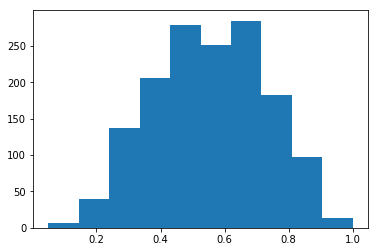

In [40]:
plt.hist(targets_train)

In [41]:
##stratified range..
limits = [0]
pos_values = np.unique(targets_train)

N = targets_train.shape[0]
splits = 5 #5 ,7,8
acum_split = []
data_by_split = N/(splits) #minimum data on split
print("Minimum data on split: ",data_by_split)

for i in range(splits-1):
    if i != len(limits)-1:
        break
    upper_values = pos_values[pos_values>=limits[i]]
    for value in upper_values: #find the upper limit
        range_v = (limits[i] <= targets_train ) & (targets_train < value)
        if np.sum(range_v) >= data_by_split:
            limits.append(value)
            acum_split.append(np.sum(range_v))
            break
range_v = (limits[-1] <= targets_train ) & (targets_train <=1)
limits.append(np.max(pos_values)+0.1)
acum_split.append(np.sum(range_v))
limits = np.asarray(limits)

print("Splits obtained: ",len(acum_split))
print("Splits obtained ammount: ",acum_split)
limits

Minimum data on split:  299.6
Splits obtained:  4
Splits obtained ammount:  [387, 303, 513, 295]


array([0.  , 0.41, 0.58, 0.71, 1.1 ])

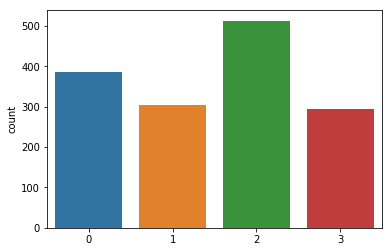

In [42]:
def continous_2_cat(data):
    if data == -1:
        return -1
    return np.where(limits <= data )[0][-1]

targets_train_cat = list(map(continous_2_cat,targets_train ))
targets_test_cat = list(map(continous_2_cat,targets_test ))
sns.countplot(targets_train_cat)


Label Decision 

The numerical ratings were derived from texts in the original html
files.  Note that with our particular conversion scheme, 0-to-4 stars
within a four star system translates into 0.1-to-0.9 in our normalized
numerical ratings, whereas 0-to-5 stars within a five star system
translates into 0-to-1.  (The reasoning was that in a four-star
system, an author is more likely to assign "endpoint" scores because
the dynamic range of the rating scheme is smaller.)
 
The class labels were then derived from the normalized numerical ratings.    
* for the three-class task: 
    * 0: rating <= 0.4
    * 1: 0.4 < rating < 0.7
    * 2: rating >= 0.7

* for the four-class task: 
    *    0: rating <=.3
    *    1: .4 <= rating <=.5
    *    2: .6 <= rating <= .7
    *    3: .8 <= rating


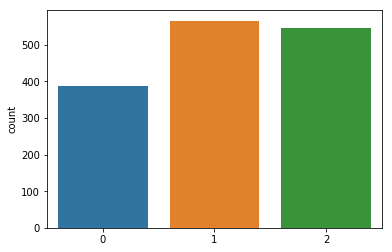

In [49]:
class_type = 3
def continous_2_cat(data):
    if data == -1:
        return -1
    if class_type ==3:
        if data <= 0.4:
            return 0
        elif data < 0.7:
            return 1
        else:
            return 2
    elif class_type == 4:
        if data <= 0.3:
            return 0
        elif data <= 0.5:
            return 1
        elif data <= 0.7:
            return 2
        else:
            return 3

targets_train_cat = list(map(continous_2_cat,targets_train ))
targets_test_cat = list(map(continous_2_cat,targets_test ))
sns.countplot(targets_train_cat)

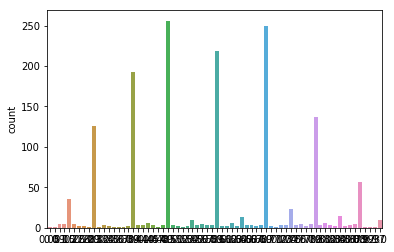

In [69]:
def continous_2_cat(data):
    if data == -1:
        return data
    return math.ceil(data*10) -1

targets_train_cat = list(map(continous_2_cat,targets_train ))
targets_test_cat = list(map(continous_2_cat,targets_test ))
sns.countplot(targets_train)

In [50]:
answers = pd.read_csv(folder+"answers.txt", header=None, delimiter=" ").as_matrix()
answers = answers[:,:-1]
answers[answers == 1.1] = 1.
answers[answers == -0.1] = 0.
print("AMT answers matrix shape: %s" % str(answers.shape))
N_ANNOT = answers.shape[1]
print("Num. annotators: %d" % N_ANNOT)

y_obs = np.empty_like(answers)
for i in range(answers.shape[0]):
    y_obs[i] = list(map(continous_2_cat, answers[i]))
y_obs = y_obs.astype('int16')
N,T = y_obs.shape
K = np.max(y_obs)+1 # asumiendo que estan ordenadas
y_obs

AMT answers matrix shape: (1498, 135)
Num. annotators: 135


array([[ 0,  2, -1, ..., -1, -1, -1],
       [ 0, -1, -1, ..., -1, -1, -1],
       [ 0, -1, -1, ..., -1, -1, -1],
       ...,
       [ 2,  2, -1, ..., -1, -1, -1],
       [ 2,  2, -1, ..., -1, -1, -1],
       [ 2,  2, -1, ..., -1, -1, -1]], dtype=int16)

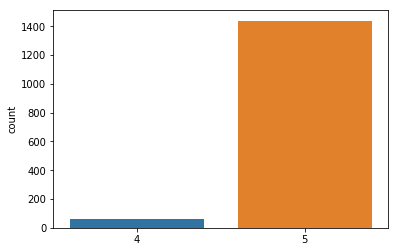

Minimum annotations in a example:  4
Maximum annotations in a example:  5
T data (expected value):  4.959946595460615
Graphics of T weights


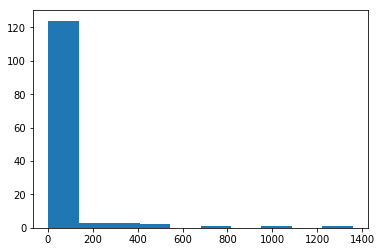

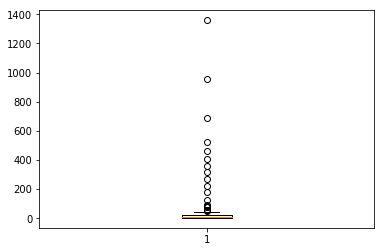

Minimum annotations by an annotator:  2
Maximum annotations by an annotator:  1359
Mean annotations by an annotator:  55.03703703703704


In [51]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones

N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

shape: (1498, 135, 3)
Bayesian gaussian mixture say is 8 clusters 
DBSCAN say is 2 clusters
Affinity Propagation say is 1 clusters


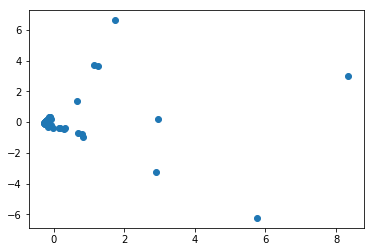

Representation for MV in 0.080277 sec
Estimation MV in 0.000474 sec
ACC MV on train: 0.7423230974632844
Normalized entropy (0-1) of repeats annotations: 0.5049686023522149


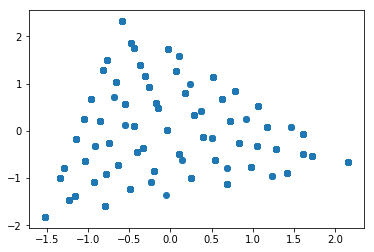

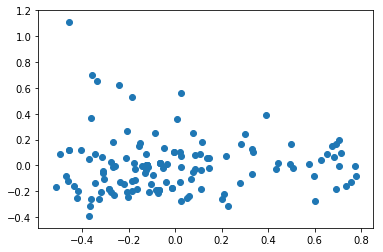

In [52]:
y_obs_categorical = set_representation(y_obs,'onehot') #for raykar
print("shape:",y_obs_categorical.shape)
annotators_pca = project_and_cluster(y_obs_categorical,DTYPE_OP=DTYPE_OP,mode_project='pca')[0]
std = StandardScaler(with_mean=True,with_std=True)
annotators_pca2 = std.fit_transform(annotators_pca)
plt.scatter(annotators_pca2[:,0],annotators_pca2[:,1])
plt.show()

label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf_ma = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==targets_train_cat))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))


predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()


### FG-NET
---
http://biometrics.cse.msu.edu/pub/databases.html  <anotations  
http://yanweifu.github.io/FG_NET_data/index.html < images  
> Demographic Estimation from Face Images: Human vs. Machine Performance

In [3]:
folder ="../FG-Net_Age/"

columns = ["GT","file name","a1","a2","a3","a4","a5","a6","a7","a8","a9","a10"]
df_ann = pd.read_csv(folder+"fgnet_age_estimations.csv",header=None,names=columns)
df_ann.head()

GT           file name    a1    a2    a3    a4    a5    a6    a7    a8  \
0  18  FG_890022_M_18.jpg  16.0  19.0  45.0  23.0  24.0  21.0  22.0  30.0   
1   9  FG_890065_F_09.jpg   8.0  10.0  12.0   7.0  11.0  10.0   7.0   9.0   
2  25  FG_890034_F_25.jpg  30.0  21.0  35.0  33.0  18.0  26.0  30.0  22.0   
3  11  FG_890066_M_11.jpg  13.0  14.0  11.0  14.0  12.0  12.0  12.0  13.0   
4  30  FG_890034_F_30.jpg  44.0  32.0  35.0  45.0  36.0  53.0  45.0  33.0   

     a9   a10  
0  26.0  23.0  
1  10.0  11.0  
2  32.0  44.0  
3  15.0  10.0  
4  25.0  35.0

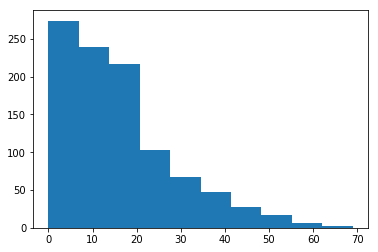

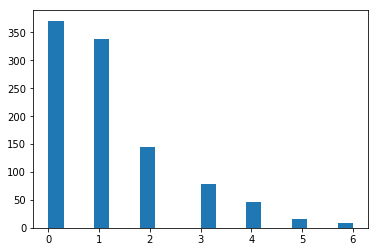

10


In [25]:
gt_aux = df_ann["GT"].values
plt.hist(gt_aux)
plt.show()

#discretizar cada 10?-- exponencial mejor...
K = int(round(aux.max()/10., 0))

Z_data = np.zeros((df_ann.shape[0]))
for i in range(Z_data.shape[0]):
    Z_data[i] = int(gt_aux[i]/10)

    
aux = df_ann.iloc[:,2:].values

r_obs = np.zeros((df_ann.shape[0],K))
for i,anns in enumerate(aux):
    for value in anns:
        r_obs[ i,int(value/10)] +=1

plt.hist(Z_data,bins=20)
plt.show()
print(K)

In [26]:
r_obs

array([[0., 2., 6., ..., 0., 0., 0.],
       [4., 6., 0., ..., 0., 0., 0.],
       [0., 1., 3., ..., 0., 0., 0.],
       ...,
       [0., 5., 5., ..., 0., 0., 0.],
       [0., 1., 3., ..., 0., 0., 0.],
       [0., 2., 6., ..., 0., 0., 0.]])

Normalized entropy (0-1) of repeats annotations: 0.2885518767426358
ACC MV on train: 0.6676646706586826


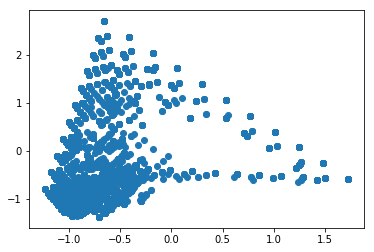

In [31]:
mv_soft = majority_voting(r_obs,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

print("ACC MV on train:",np.mean(mv_soft.argmax(axis=-1)==Z_data))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[0]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()

### DAISEE

In [7]:
folder ="../DAiSEE/Labels/"

df_global = pd.read_csv(folder+"AllLabels.csv")
label_names = df_global.columns[1:]
df_global.head()

ClipID  Boredom  Engagement  Confusion  Frustration 
0  1100011002.avi        0           2          0             0
1  1100011003.avi        0           2          0             0
2  1100011004.avi        0           3          0             0
3  1100011005.avi        0           3          0             0
4  1100011006.avi        0           3          0             0

In [8]:
r_obs = df_global.iloc[:,1:].values
r_obs

array([[0, 2, 0, 0],
       [0, 2, 0, 0],
       [0, 3, 0, 0],
       ...,
       [1, 3, 0, 2],
       [1, 3, 1, 1],
       [0, 1, 0, 0]])

In [10]:
r_obs.sum(axis=-1).mean()

3.967619047619048

### Sentiment Analysis
---
https://eden.dei.uc.pt/~fmpr/malr/  
> Learning from multiple annotators: Distinguishing good from random labelers

http://web.eecs.umich.edu/~mozafari/datasets/crowdsourcing/
> Scaling up crowd-sourcing to very large datasets: a case for active learning  
> Active Learning for Crowd-Sourced Databases


Rodrigues utiliza: In the case of the sentimentpolarity dataset, the stopwords were removed and the remainingwords were reduced to their root by applying a stemmer. This re-sulted in a vocabulary with size 8919, which still makes a bag-of-words representation computationally expensive.  además de hacer LSA

In [2]:
#movie review website RottenTomatoes
folder = "../MTurk_paper/"

df = pd.read_csv(folder+"sentiment_polarity/mturk_answers.csv") 
print("Dataset de Sentiment Analysis shape: ",df.shape)
df.head()

FileNotFoundError: File b'../MTurk_paper/sentiment_polarity/mturk_answers.csv' does not exist

In [10]:
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0

for row in df.values:
    work_id = row[0]
    inp_id = row[1]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1
        
Z_train = np.zeros(contador_data, dtype='int16')
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
texts_train_raw = [[] for _ in range(contador_data)]
texts_train_stem = [[] for _ in range(contador_data)]
for row in df.values:
    work_id = row[0]
    inp_id = row[1]
    text = row[2]
    gt = row[4]
    ann = row[5]
    
    Z_train[data_id[inp_id]] = (gt == "pos")*1
    y_obs[data_id[inp_id], worker_id[work_id]] = (ann == "pos")*1
    texts_train_raw[data_id[inp_id]] = text
    texts_train_stem[data_id[inp_id]] = row[3]
    
    
N, T = y_obs.shape
K = 2

np.savetxt("./Sentiment/rotten/answers.txt", y_obs,delimiter=' ', fmt='%d')
np.savetxt("./Sentiment/rotten/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
with open("./Sentiment/rotten/texts_train.txt", 'w') as fp:
    fp.write("\n".join(texts_train_raw))
with open("./Sentiment/rotten/texts_train_stem.txt", 'w') as fp:
    fp.write("\n".join(texts_train_stem))
y_obs.shape

(4999, 203)

In [2]:
folder = "./Sentiment/rotten/" #from kaggle.. GT data labeled
df = pd.read_csv(folder+"train.tsv", sep='\t')

#hard data
mask_neg = (df["Sentiment"] == 1).values
mask_pos = (df["Sentiment"] == 3).values 
text_neg = df[mask_neg]["Phrase"].values
text_pos = df[mask_pos]["Phrase"].values

sent_test = np.concatenate([np.zeros(text_neg.shape[0]), np.ones(text_pos.shape[0])])
texts_test = np.asarray(list(text_neg)+list(text_pos))

from sklearn.utils import shuffle
texts_test, sent_test = shuffle(texts_test, sent_test)

#np.savetxt(folder+"/sent_test.txt", sent_test[:6000],delimiter=' ', fmt='%d')
#with open(folder+"/texts_test.txt", 'w') as fp:
#    fp.write("\n".join(texts_test[:6000]))   

In [8]:
from keras import preprocessing
MAX_NB_WORDS = 14000
tokenizer = preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts_test)
sequences_test = tokenizer.texts_to_sequences(texts_test)
max_L = 50 
X_test = preprocessing.sequence.pad_sequences(sequences_test, maxlen=max_L,dtype='int32', value=0,padding='pre')
EMBEDDING_DIM = 300
GLOVE_FILE = "../GLOVE/glove.6B.%dd.txt"%(EMBEDDING_DIM)
embeddings_index = {}
with open(GLOVE_FILE) as file:
    for line in file:
        values = line.split()
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[values[0]] = coefs
print('Preparing embedding matrix.')
sorted_x = sorted(tokenizer.word_counts.items(), key=lambda kv: kv[1], reverse=True)
vocab = {value[0]:tokenizer.word_index[value[0]] for i, value in enumerate(sorted_x) if i < MAX_NB_WORDS}
embedding_matrix = np.zeros((len(vocab)+1, EMBEDDING_DIM))
v=0
for word, i in vocab.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector # words not found in embedding index will be all-zeros.
        v+=1
del embeddings_index, sorted_x, tokenizer
gc.collect()
print("Words found on glove: ",v)

Preparing embedding matrix.
Words found on glove:  13725


In [23]:
import keras
model_mvsoft = keras.models.load_model("aux.h5")

### predict x
Z_pred = model_mvsoft.predict_classes(X_test, batch_size=1024)

mask_mistakes = (sent_test != Z_pred)
np.sum(mask_mistakes) #si guardo solo los errores va a tener muy mal acc afuera no??

28591

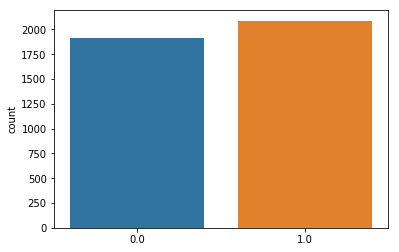

In [24]:
final_mask = mask_mistakes & (np.cumsum(mask_mistakes)<4000)
sns.countplot(sent_test[final_mask])

In [25]:
np.savetxt(folder+"/sent_test.txt", sent_test[final_mask],delimiter=' ', fmt='%d')
with open(folder+"/texts_test.txt", 'w') as fp:
    fp.write("\n".join(texts_test[final_mask]))   

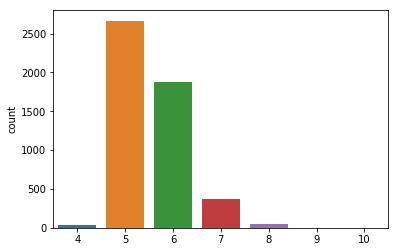

Minimum annotations in a example:  4
Maximum annotations in a example:  10
T data (expected value):  5.550310062012403
Graphics of T weights


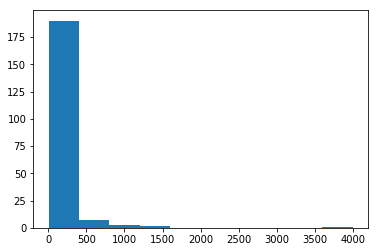

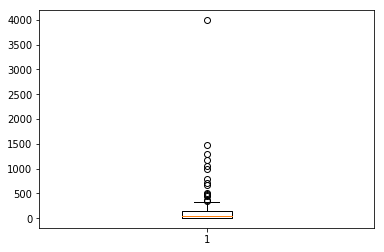

Minimum annotations by an annotator:  5
Maximum annotations by an annotator:  3993
Mean annotations by an annotator:  136.67980295566502


In [26]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.212330 sec
Estimation MV in 0.000391 sec
ACC MV on train: 0.8895779155831166
F1 MV on train: 0.8895779155831166
Normalized entropy (0-1) of repeats annotations: 0.49546839861751707


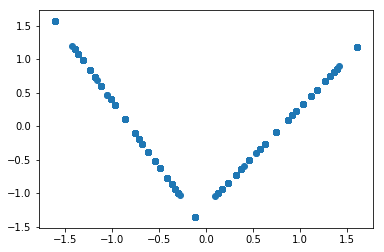

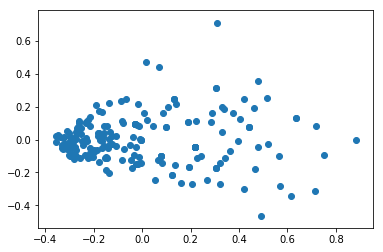

In [45]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_data))
print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

In [97]:
folder = "../Mozafari/Sentiment/"

columns = ["PrimaryKey"]
for i in range(1,6):
    columns.append("User"+str(i))
    columns.append("realLabel")
    columns.append("actual_tweat")
df_ann = pd.read_csv(folder+"tweets10k.crd",header=None,names=columns)
print(df_ann.shape)
df_ann.head()

(1000, 16)


/home/casapanshop/anaconda2/envs/py3/lib/python3.5/site-packages/pandas/io/parsers.py:709: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


PrimaryKey           User1  realLabel  actual_tweat           User2  \
0           1  A17G2QHR8AH5VV          1             0  A3QTDW5WP4GFKV   
1           2  A3OZ8KF0HWSVWK          1             1  A3TSHG5R492EHU   
2           3  A2460QZM5TZC4V          1             1   A52AHJEUWFSA2   
3           4   AADB14P6ZCSOC          0             0  A1SCNO7L71ITFY   
4           5  A2460QZM5TZC4V          1             0  A3P08N6X9HDJ2V   

   realLabel.1  actual_tweat.1           User3  realLabel.2  actual_tweat.2  \
0            1               0  A2QNS7MODF0A2N            1               0   
1            1               1  A1SCNO7L71ITFY            1               1   
2            1               1  A2N2KQXUPLNDWI            1               1   
3            0               0  A29PMRCRJ7Q9ZD            0               0   
4            1               0  A3OZ8KF0HWSVWK            1               0   

            User4  realLabel.3  actual_tweat.3           User5  realLabel.4  \
0  A3TSHG5R492EHU            1               0  A2NBP5OTOYX3WK            1   
1  A2SB5KUOAGU70U            1               1  A1YW00TFC187CC            1   
2  A3OZ8KF0HWSVWK            1               1  A3U1K9X1LXA5JA            1   
3  A2QNS7MODF0A2N            0               0  A3TSHG5R492EHU            0   
4  A2H3M1JVY991Q3            1               1   ARX0S1CIDJLOX            1   

   actual_tweat.4  
0               0  
1               0  
2               1  
3               0  
4               0

In [48]:
df_gt = pd.read_csv(folder+"tweets10k.details",header=None,names=["PrimaryKey","realLabel", "actual_tweat"],index_col=False)
print(df_gt.shape)
df_gt.head() ### could be test..

(10000, 3)


PrimaryKey  realLabel                              actual_tweat
0           1          1  @chazdrums if i know how to do something
1           2          1                          @m_ariii alright
2           3          1                  @lsndr87 Good Luck Girl 
3           4          0                            @sloanb Got it
4           5          1  @lilyroseallen that's hotel tv's for ya

In [ ]:
df_gt["realLabel"].unique()

In [104]:
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0

for row in df_ann.values:
    inp_id = row[0]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    
    for i in np.arange(1,len(row),3):
        work_id = row[i]
        if work_id not in worker_id:
            worker_id[work_id] = contador_work
            contador_work+=1  

Z_data = np.zeros(contador_data, dtype='int16')
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    inp_id = row[0]
    #text = row[2] #extraer desde df_gt
    gt = row[2]
    Z_data[data_id[inp_id]] = (gt == 1)*1
    
    for i in np.arange(1,len(row),3):
        work_id = row[i]
        ann = row[i+2]
        y_obs[data_id[inp_id], worker_id[work_id]] = (ann == 1)*1
    
N, T = y_obs.shape
K = 2
#Z_data
y_obs.shape

(1000, 83)

In [ ]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0

for row in df_ann.values:
    inp_id = row[0]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    
    for i in np.arange(1,len(row),3):
        work_id = row[i]
        if work_id not in worker_id:
            worker_id[work_id] = contador_work
            contador_work+=1  
            
Z_train = np.zeros(contador_data, dtype='int16')
Z_test = []
texts_train = [ [] for _ in range(contador_data)]
texts_test = []
for row in df_gt.values:
    if row[0] in data_id:
        Z_train[data_id[row[0]]] = (row[1]==1)*1
        texts_train[data_id[row[0]]] = row[2]
    else:
        Z_test.append((row[1]==1)*1)
        texts_test.append(row[2])
        
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    for i in np.arange(1,len(row),3):
        work_id = row[i]
        ann = row[i+2]
        y_obs[data_id[row[0]], worker_id[work_id]] = (ann == 1)*1
        
np.savetxt("./Sentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
np.savetxt("./Sentiment/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
np.savetxt("./Sentiment/sent_test.txt", Z_test,delimiter=' ', fmt='%d')
with open("./Sentiment/texts_train.txt", 'w') as fp:
    fp.write("\n".join(texts_train))
with open("./Sentiment/texts_test.txt", 'w') as fp:
    fp.write("\n".join(texts_test))   

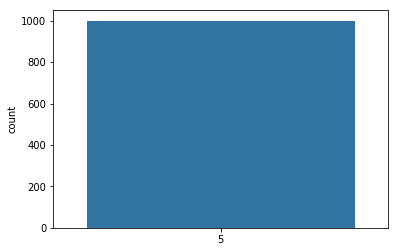

Minimum annotations in a example:  5
Maximum annotations in a example:  5
T data (expected value):  5.0
Graphics of T weights


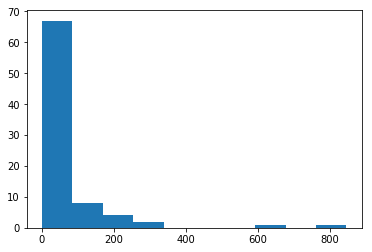

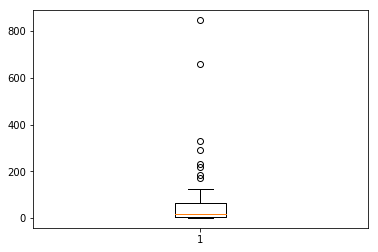

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  846
Mean annotations by an annotator:  60.24096385542169


In [99]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.044220 sec
Estimation MV in 0.000409 sec
ACC MV on train: 0.696
F1 MV on train: 0.696
Normalized entropy (0-1) of repeats annotations: 0.4119131022397207


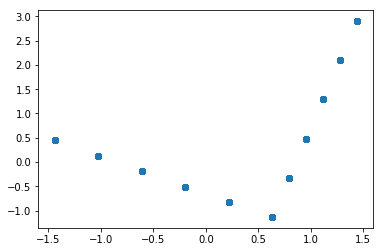

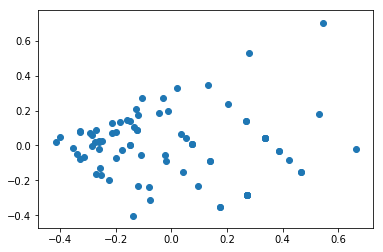

In [100]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
print("ACC MV on train:",np.mean(mv_onehot==Z_data))
print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

In [ ]:
folder = "../Probar/Sentiment/data/"
from scipy.io import loadmat
file1 = loadmat(folder+"8-5.mat")
file2 = loadmat(folder+"patterns8.mat")
file3 = loadmat(folder+"indices.mat")

file1

In [92]:
"""
This archive contains collection of 16327 articles from three Irish online news sources 
(RTE,The Irish Times,The Irish Independent) collected between 2009-07-08 and 2009-10-16. 
A subset of 1660 of these articles were annotated manually by 33 users during that period.
"""

folder = "../Probar/otroSentiment/"
#df_ann = pd.read_csv(folder+"/sentiment_main_annotations.csv")
df_ann = pd.read_csv(folder+"/sentiment_all_annotations.csv",names=["article_id","user_id","annotation"])

#texts in TF representation..
articles_header = ["article_id","article_data(yyyy-mm-dd)","provider(rte,irishtimes,independent)"] +["term_index"+str(i)+":freq" for i in np.arange(1175)]
df_articles = pd.read_csv(folder+"/sentiment_all_articles.csv",header=None,engine='python',names=articles_header)
print("Data (X): ",df_articles.shape)

#vocabulary
df_terms = pd.read_csv(folder+"/sentiment_all_terms.csv",names=["term_id","term_text"], encoding = "ISO-8859-1")
print("Vocabulary shape:",df_terms.shape)

print(df_ann.shape)
df_ann.head()

Data (X):  (16327, 1178)
Vocabulary shape: (79308, 2)
(9603, 3)


article_id  user_id annotation
0          17        6   negative
1          17        7   negative
2          17        3   negative
3          17        5   negative
4          17        4   negative

In [91]:
df_annotations["annotation"].unique()

array(['negative', 'positive', 'irrelevant'], dtype=object)

In [93]:
#.. no hay GT..

data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for row in df_ann.values:
    inp_id = row[0]
    work_id = row[1]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  

y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    inp_id = row[0]
    #text = row[2] #extraer ]TF desde df_articles

    work_id = row[1]
    ann = row[2]
    y_obs[data_id[inp_id], worker_id[work_id]] = (ann == "positive")*1

N, T = y_obs.shape
K = 2
#Z_data
y_obs.shape

(1660, 33)

In [94]:
y_obs

array([[ 0,  0,  0, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [ 0,  0,  0, ..., -1, -1, -1],
       ...,
       [-1, -1,  0, ..., -1, -1, -1],
       [-1,  0,  0, ...,  1, -1, -1],
       [-1,  1,  1, ...,  1, -1, -1]], dtype=int16)

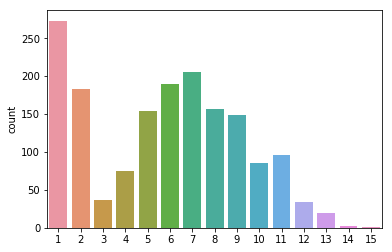

Minimum annotations in a example:  1
Maximum annotations in a example:  15
T data (expected value):  5.784939759036145
Graphics of T weights


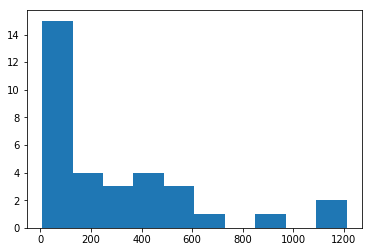

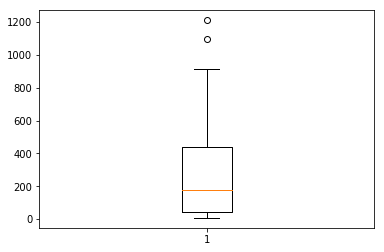

Minimum annotations by an annotator:  7
Maximum annotations by an annotator:  1211
Mean annotations by an annotator:  291.0


In [95]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.098708 sec
Estimation MV in 0.000733 sec
Normalized entropy (0-1) of repeats annotations: 0.3135694930931521


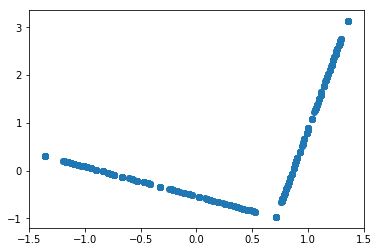

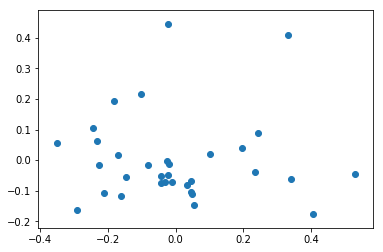

In [96]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(K))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], K**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

### Crowdscale
https://sites.google.com/site/crowdscale2013/shared-task


* Job Title: Judge emotions about weather from Twitter
    * 0 Negative
    * 1 Neutral / author is just sharing information
    * 2 Positive
    * 3 Tweet not related to weather condition
    * 4 I can't tell



In [106]:
folder = "../CrowsourcingatScale/"
df_ann = pd.read_csv(folder+"cf-sentiment-basic.csv")
df_gt = pd.read_csv(folder+"cf-gold/reference_100%.csv")
df_ann.head()

question                                 rater  judgment
0  81988805  df4efb63-1273-49f9-8ad1-bbe823db7e1c         3
1  81988805  297b9a2d-ba91-4611-b0ad-bf96d4e9e76d         3
2  81988805  b162cdcb-4d3e-48da-ba9e-f29a0ac8dd6e         3
3  81988805  e99c283f-ede0-40c4-9914-87a2a11e6f2c         3
4  81988805  42a4a1c9-4e4c-44ac-a20a-d9870532867d         3

In [87]:
aux_df = pd.read_csv(folder+"kaggle/train.csv")
print(aux_df.shape)
aux_df.head()

(77946, 28)


id                                              tweet         state  \
0   1                Jazz for a Rainy Afternoon:  {link}      oklahoma   
1   2                   RT: @mention: I love rainy days.       florida   
2   3  Good Morning Chicago! Time to kick the Windy C...         idaho   
3   6  Preach lol! :) RT @mention: #alliwantis this t...     minnesota   
4   9                     @mention good morning sunshine  rhode island   

               location   s1   s2   s3     s4     s5     w1 ...    k6     k7  \
0              Oklahoma  0.0  0.0  1.0  0.000  0.000  0.800 ...   0.0  0.000   
1  Miami-Ft. Lauderdale  0.0  0.0  0.0  1.000  0.000  0.196 ...   0.0  0.000   
2                   NaN  0.0  0.0  0.0  0.000  1.000  0.000 ...   0.0  1.000   
3  Minneapolis-St. Paul  0.0  0.0  0.0  1.000  0.000  1.000 ...   0.0  0.604   
4             Purgatory  0.0  0.0  0.0  0.403  0.597  1.000 ...   0.0  0.000   

    k8     k9  k10  k11  k12    k13  k14  k15  
0  0.0  0.000  1.0  0.0  0.0  0.000  0.0  0.0  
1  0.0  0.000  1.0  0.0  0.0  0.000  0.0  0.0  
2  0.0  0.000  0.0  0.0  0.0  0.000  0.0  0.0  
3  0.0  0.196  0.0  0.0  0.0  0.201  0.0  0.0  
4  0.0  0.000  0.0  0.0  0.0  1.000  0.0  0.0  

[5 rows x 28 columns]

In [66]:
#ver como descargar los tweets...
CONSUMER_KEY = "gQ1RX1eqCRS39n1dmL9nVzAEp"
CONSUMER_SECRET = "iMiZA2xXC4o7TsypLHj22HP1R0SAdfYqxYgFDKU33mra2SGhyA"
OAUTH_TOKEN = "320425023-iyx7eywe75Po9VtkaOkhcrlhXGFTwzrYYq55xcoH"
OAUTH_TOKEN_SECRET = "4GAlKtNyS0Z4SIOdo4DnlFsBl8KlfczOhGy8I4yByF1Tb"

In [98]:
tweets = api.user_timeline("84314377")
print("Tweets: ", len(tweets))
for aux in tweets:
    print(aux.text)

Tweets:  1
im working in dubai


In [92]:
import tweepy
auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(OAUTH_TOKEN, OAUTH_TOKEN_SECRET)
api = tweepy.API(auth)

tweet = api.get_status("264183816548130816")
print(tweet.text)

Gas by my house hit $3.39!!!! I'm going to Chapel Hill on Sat. :)


In [73]:
aux = pd.read_csv(folder+"old_data/weather-non-agg-DFE.csv")
print("Cantidad de data: ",len(aux["tweet_id"].unique()))
print("Cantidad de workers: ",len(aux["_worker_id"].unique()))
aux

Cantidad de data:  1000
Cantidad de workers:  102


_unit_id         _created_at  _canary         _id         _started_at  \
0      314960380  8/23/2013 23:57:30      NaN  1038995940  8/23/2013 23:57:20   
1      314960380  8/24/2013 00:09:18      NaN  1039004532  8/24/2013 00:09:05   
2      314960380  8/24/2013 00:09:31      NaN  1039004700  8/24/2013 00:08:14   
3      314960380  8/24/2013 00:11:55      NaN  1039006547  8/24/2013 00:11:13   
4      314960380  8/24/2013 00:13:22      NaN  1039007700  8/24/2013 00:11:50   
5      314960380  8/24/2013 00:14:19      NaN  1039008265  8/24/2013 00:12:36   
6      314960380  8/24/2013 00:14:37      NaN  1039008516  8/24/2013 00:13:41   
7      314960380  8/24/2013 00:15:07      NaN  1039008820  8/24/2013 00:14:24   
8      314960380  8/24/2013 00:15:30      NaN  1039009089  8/24/2013 00:14:42   
9      314960380  8/24/2013 00:16:01      NaN  1039009458  8/24/2013 00:14:32   
10     314960380  8/24/2013 00:16:59      NaN  1039010159  8/24/2013 00:14:52   
11     314960380  8/24/2013 00:17:00      NaN  1039010170  8/24/2013 00:12:29   
12     314960380  8/24/2013 00:17:01      NaN  1039010184  8/24/2013 00:16:09   
13     314960380  8/24/2013 00:17:04      NaN  1039010230  8/24/2013 00:14:11   
14     314960380  8/24/2013 00:17:04      NaN  1039010247  8/24/2013 00:16:20   
15     314960380  8/24/2013 00:18:06      NaN  1039011037  8/24/2013 00:16:55   
16     314960380  8/24/2013 00:18:09      NaN  1039011127  8/24/2013 00:15:52   
17     314960380  8/24/2013 00:19:45      NaN  1039012321  8/24/2013 00:15:51   
18     314960380  8/24/2013 00:20:50      NaN  1039013146  8/24/2013 00:19:09   
19     314960380  8/24/2013 00:21:41      NaN  1039013855  8/24/2013 00:20:45   
20     314960381  8/24/2013 00:27:21      NaN  1039018522  8/24/2013 00:27:10   
21     314960381  8/24/2013 00:45:07      NaN  1039035284  8/24/2013 00:44:49   
22     314960381  8/24/2013 00:45:39      NaN  1039035870  8/24/2013 00:45:25   
23     314960381  8/24/2013 00:45:40      NaN  1039035894  8/24/2013 00:45:23   
24     314960381  8/24/2013 00:46:01      NaN  1039036256  8/24/2013 00:45:35   
25     314960381  8/24/2013 00:46:41      NaN  1039036934  8/24/2013 00:45:51   
26     314960381  8/24/2013 00:46:42      NaN  1039036981  8/24/2013 00:45:50   
27     314960381  8/24/2013 00:46:57      NaN  1039037256  8/24/2013 00:46:06   
28     314960381  8/24/2013 00:47:07      NaN  1039037414  8/24/2013 00:46:07   
29     314960381  8/24/2013 00:47:15      NaN  1039037542  8/24/2013 00:46:10   
...          ...                 ...      ...         ...                 ...   
19970  314961378  8/24/2013 00:10:35      NaN  1039005507  8/24/2013 00:08:04   
19971  314961378  8/24/2013 00:10:39      NaN  1039005567  8/24/2013 00:08:26   
19972  314961378  8/24/2013 00:11:44      NaN  1039006365  8/24/2013 00:11:05   
19973  314961378  8/24/2013 00:12:31      NaN  1039007016  8/24/2013 00:07:11   
19974  314961378  8/24/2013 00:13:09      NaN  1039007525  8/24/2013 00:10:25   
19975  314961378  8/24/2013 00:14:36      NaN  1039008481  8/24/2013 00:13:47   
19976  314961378  8/24/2013 00:14:49      NaN  1039008630  8/24/2013 00:12:53   
19977  314961378  8/24/2013 00:14:58      NaN  1039008743  8/24/2013 00:13:24   
19978  314961378  8/24/2013 00:15:10      NaN  1039008850  8/24/2013 00:14:09   
19979  314961378  8/24/2013 00:38:20      NaN  1039028470  8/24/2013 00:36:50   
19980  314961379  8/24/2013 00:12:19      NaN  1039006894  8/24/2013 00:12:07   
19981  314961379  8/24/2013 00:19:32      NaN  1039012136  8/24/2013 00:18:06   
19982  314961379  8/24/2013 00:21:42      NaN  1039013917  8/24/2013 00:21:00   
19983  314961379  8/24/2013 00:22:50      NaN  1039014848  8/24/2013 00:21:54   
19984  314961379  8/24/2013 00:23:32      NaN  1039015361  8/24/2013 00:22:30   
19985  314961379  8/24/2013 00:24:40      NaN  1039016245  8/24/2013 00:23:51   
19986  314961379  8/24/2013 00:24:50      NaN  1039016458  8/24/2013 00:24:05   
19987  314961379  8/24/2013 00:25:26   

In [41]:
bla = pd.read_csv(folder+"kaggle/test.csv")

texts_aux = aux["tweet_text"].values

for i, pepe_i in enumerate(aux.values):
    value = pepe_i[-1]
    
    f1 = aux_df[aux_df["tweet"] == value]
    f2 = bla[bla["tweet"] == value]
          
    if len(f1) != 0:
        print("Found on train: id kaggle: %s e id crowdscale %s "%(f1["id"].values, pepe_i[-2]))
        print("pos en crowdscale: %d, pos en crowdflower %d"%(data_id[pepe_i[-2]],i))
        #print(f1.head())
    if len(f2) != 0:
        print("Found on test: id kaggle: %s e id crowdscale %s "%(f1["id"].values, pepe_i[-2]))
        print("pos en crowdscale: %d, pos en crowdflower %d"%(data_id[pepe_i[-2]],i))
        #print(f2.head())
          

Found on train: id kaggle: [18907] e id crowdscale 84314377 
pos en crowdscale: 67271, pos en crowdflower 1
Found on train: id kaggle: [71807] e id crowdscale 82846118 
pos en crowdscale: 33070, pos en crowdflower 2
Found on train: id kaggle: [4124] e id crowdscale 82843785 
pos en crowdscale: 30759, pos en crowdflower 3
Found on train: id kaggle: [39282] e id crowdscale 82840144 
pos en crowdscale: 28281, pos en crowdflower 4
Found on train: id kaggle: [75685] e id crowdscale 82510997 
pos en crowdscale: 8883, pos en crowdflower 5
Found on train: id kaggle: [111184] e id crowdscale 84313352 
pos en crowdscale: 66251, pos en crowdflower 6
Found on train: id kaggle: [1973] e id crowdscale 81211801 
pos en crowdscale: 94832, pos en crowdflower 7
Found on train: id kaggle: [58643] e id crowdscale 82852809 
pos en crowdscale: 39008, pos en crowdflower 8
Found on train: id kaggle: [3449] e id crowdscale 79194811 
pos en crowdscale: 78225, pos en crowdflower 9
Found on train: id kaggle: [975

Found on train: id kaggle: [86922] e id crowdscale 82510693 
pos en crowdscale: 8580, pos en crowdflower 94
Found on train: id kaggle: [113116] e id crowdscale 82839844 
pos en crowdscale: 27981, pos en crowdflower 97
Found on train: id kaggle: [97720] e id crowdscale 82516775 
pos en crowdscale: 14114, pos en crowdflower 98
Found on train: id kaggle: [46043] e id crowdscale 82849313 
pos en crowdscale: 35528, pos en crowdflower 99
Found on train: id kaggle: [41551] e id crowdscale 79197151 
pos en crowdscale: 80555, pos en crowdflower 101
Found on train: id kaggle: [18400] e id crowdscale 81169556 
pos en crowdscale: 90168, pos en crowdflower 103
Found on train: id kaggle: [16942] e id crowdscale 84317392 
pos en crowdscale: 67925, pos en crowdflower 104
Found on train: id kaggle: [76462] e id crowdscale 82839115 
pos en crowdscale: 27252, pos en crowdflower 105
Found on train: id kaggle: [98344] e id crowdscale 84305178 
pos en crowdscale: 59520, pos en crowdflower 106
Found on train

Found on train: id kaggle: [86280] e id crowdscale 81213147 
pos en crowdscale: 96174, pos en crowdflower 194
Found on train: id kaggle: [28734] e id crowdscale 84320750 
pos en crowdscale: 71282, pos en crowdflower 195
Found on train: id kaggle: [12184] e id crowdscale 83254598 
pos en crowdscale: 39640, pos en crowdflower 196
Found on train: id kaggle: [41282] e id crowdscale 82511269 
pos en crowdscale: 9155, pos en crowdflower 197
Found on train: id kaggle: [41910] e id crowdscale 80059665 
pos en crowdscale: 89695, pos en crowdflower 198
Found on train: id kaggle: [20810] e id crowdscale 81993145 
pos en crowdscale: 3850, pos en crowdflower 199
Found on train: id kaggle: [5842] e id crowdscale 82851664 
pos en crowdscale: 37870, pos en crowdflower 200
Found on train: id kaggle: [114517] e id crowdscale 81992407 
pos en crowdscale: 3112, pos en crowdflower 201
Found on train: id kaggle: [51672] e id crowdscale 81996594 
pos en crowdscale: 6706, pos en crowdflower 203
Found on train

Found on train: id kaggle: [950] e id crowdscale 81214896 
pos en crowdscale: 97917, pos en crowdflower 295
Found on train: id kaggle: [117856] e id crowdscale 82852510 
pos en crowdscale: 38711, pos en crowdflower 298
Found on train: id kaggle: [26324] e id crowdscale 80054061 
pos en crowdscale: 85644, pos en crowdflower 300
Found on train: id kaggle: [104907] e id crowdscale 84305417 
pos en crowdscale: 59758, pos en crowdflower 301
Found on train: id kaggle: [2404] e id crowdscale 82844546 
pos en crowdscale: 31516, pos en crowdflower 302
Found on train: id kaggle: [81827] e id crowdscale 83267294 
pos en crowdscale: 44533, pos en crowdflower 304
Found on train: id kaggle: [40475] e id crowdscale 80056141 
pos en crowdscale: 86201, pos en crowdflower 305
Found on train: id kaggle: [115742] e id crowdscale 81994619 
pos en crowdscale: 4731, pos en crowdflower 306
Found on train: id kaggle: [119630] e id crowdscale 81996571 
pos en crowdscale: 6683, pos en crowdflower 307
Found on tr

Found on train: id kaggle: [95815] e id crowdscale 83255916 
pos en crowdscale: 40912, pos en crowdflower 392
Found on train: id kaggle: [110786] e id crowdscale 81992855 
pos en crowdscale: 3560, pos en crowdflower 393
Found on train: id kaggle: [68941] e id crowdscale 81996092 
pos en crowdscale: 6204, pos en crowdflower 394
Found on train: id kaggle: [34944 44369 53300 80085] e id crowdscale 84311166 
pos en crowdscale: 64087, pos en crowdflower 395
Found on train: id kaggle: [76674] e id crowdscale 82853084 
pos en crowdscale: 39283, pos en crowdflower 397
Found on train: id kaggle: [96328] e id crowdscale 82515944 
pos en crowdscale: 13283, pos en crowdflower 398
Found on train: id kaggle: [18034] e id crowdscale 82675706 
pos en crowdscale: 18834, pos en crowdflower 400
Found on train: id kaggle: [ 30666  60677  62470  68148 102539] e id crowdscale 84031161 
pos en crowdscale: 49999, pos en crowdflower 401
Found on train: id kaggle: [61663 97103] e id crowdscale 80050064 
pos en 

Found on train: id kaggle: [39432] e id crowdscale 81176951 
pos en crowdscale: 93360, pos en crowdflower 495
Found on train: id kaggle: [119778] e id crowdscale 82515186 
pos en crowdscale: 12525, pos en crowdflower 496
Found on train: id kaggle: [54527] e id crowdscale 81172598 
pos en crowdscale: 91607, pos en crowdflower 497
Found on train: id kaggle: [73070] e id crowdscale 82840428 
pos en crowdscale: 28562, pos en crowdflower 498
Found on train: id kaggle: [18199] e id crowdscale 82518284 
pos en crowdscale: 15622, pos en crowdflower 499
Found on train: id kaggle: [16707] e id crowdscale 81996499 
pos en crowdscale: 6611, pos en crowdflower 501
Found on train: id kaggle: [40388] e id crowdscale 84318040 
pos en crowdscale: 68573, pos en crowdflower 503
Found on train: id kaggle: [82476] e id crowdscale 82681076 
pos en crowdscale: 23873, pos en crowdflower 504
Found on train: id kaggle: [72177] e id crowdscale 82853187 
pos en crowdscale: 39386, pos en crowdflower 505
Found on t

Found on train: id kaggle: [ 80797 117352] e id crowdscale 82852342 
pos en crowdscale: 38544, pos en crowdflower 597
Found on train: id kaggle: [28760] e id crowdscale 79197563 
pos en crowdscale: 80967, pos en crowdflower 598
Found on train: id kaggle: [3505] e id crowdscale 82851186 
pos en crowdscale: 37397, pos en crowdflower 599
Found on train: id kaggle: [6014] e id crowdscale 82513470 
pos en crowdscale: 11343, pos en crowdflower 601
Found on train: id kaggle: [16371] e id crowdscale 81178016 
pos en crowdscale: 93824, pos en crowdflower 602
Found on train: id kaggle: [110362] e id crowdscale 81177151 
pos en crowdscale: 93460, pos en crowdflower 603
Found on train: id kaggle: [66118] e id crowdscale 79197068 
pos en crowdscale: 80472, pos en crowdflower 604
Found on train: id kaggle: [  3796 116763] e id crowdscale 82850069 
pos en crowdscale: 36283, pos en crowdflower 605
Found on train: id kaggle: [10367] e id crowdscale 84047934 
pos en crowdscale: 54344, pos en crowdflower

Found on train: id kaggle: [6920] e id crowdscale 82510492 
pos en crowdscale: 8379, pos en crowdflower 687
Found on train: id kaggle: [54130] e id crowdscale 81995666 
pos en crowdscale: 5778, pos en crowdflower 688
Found on train: id kaggle: [101200] e id crowdscale 82678736 
pos en crowdscale: 21533, pos en crowdflower 689
Found on train: id kaggle: [50249] e id crowdscale 80058172 
pos en crowdscale: 88211, pos en crowdflower 692
Found on train: id kaggle: [50502] e id crowdscale 80059451 
pos en crowdscale: 89481, pos en crowdflower 695
Found on train: id kaggle: [13260] e id crowdscale 83270454 
pos en crowdscale: 47368, pos en crowdflower 696
Found on train: id kaggle: [39441] e id crowdscale 83255121 
pos en crowdscale: 40124, pos en crowdflower 698
Found on train: id kaggle: [33263] e id crowdscale 79196168 
pos en crowdscale: 79572, pos en crowdflower 701
Found on train: id kaggle: [82843] e id crowdscale 83270696 
pos en crowdscale: 47589, pos en crowdflower 702
Found on tra

Found on train: id kaggle: [62450] e id crowdscale 82678878 
pos en crowdscale: 21675, pos en crowdflower 800
Found on train: id kaggle: [16285] e id crowdscale 79194550 
pos en crowdscale: 77964, pos en crowdflower 801
Found on train: id kaggle: [56369] e id crowdscale 82837308 
pos en crowdscale: 25453, pos en crowdflower 805
Found on train: id kaggle: [7771] e id crowdscale 83255051 
pos en crowdscale: 40056, pos en crowdflower 806
Found on train: id kaggle: [74619] e id crowdscale 80053682 
pos en crowdscale: 85265, pos en crowdflower 807
Found on train: id kaggle: [19692] e id crowdscale 84051784 
pos en crowdscale: 58069, pos en crowdflower 808
Found on train: id kaggle: [93870] e id crowdscale 82512662 
pos en crowdscale: 10540, pos en crowdflower 809
Found on train: id kaggle: [42967] e id crowdscale 81213907 
pos en crowdscale: 96934, pos en crowdflower 810
Found on train: id kaggle: [110770] e id crowdscale 79194346 
pos en crowdscale: 77761, pos en crowdflower 812
Found on t

Found on train: id kaggle: [83790] e id crowdscale 82517760 
pos en crowdscale: 15098, pos en crowdflower 898
Found on train: id kaggle: [101928] e id crowdscale 83270768 
pos en crowdscale: 47658, pos en crowdflower 899
Found on train: id kaggle: [447] e id crowdscale 82682352 
pos en crowdscale: 25149, pos en crowdflower 900
Found on train: id kaggle: [8107] e id crowdscale 83257918 
pos en crowdscale: 42828, pos en crowdflower 901
Found on train: id kaggle: [7043] e id crowdscale 82511345 
pos en crowdscale: 9230, pos en crowdflower 902
Found on train: id kaggle: [ 30666  60677  62470  68148 102539] e id crowdscale 80051237 
pos en crowdscale: 82831, pos en crowdflower 903
Found on train: id kaggle: [109125] e id crowdscale 79197417 
pos en crowdscale: 80821, pos en crowdflower 904
Found on train: id kaggle: [100018] e id crowdscale 84314450 
pos en crowdscale: 67344, pos en crowdflower 905
Found on train: id kaggle: [102389] e id crowdscale 82847466 
pos en crowdscale: 34385, pos e

Found on train: id kaggle: [5214] e id crowdscale 82675151 
pos en crowdscale: 18280, pos en crowdflower 986
Found on train: id kaggle: [60054] e id crowdscale 84051926 
pos en crowdscale: 58207, pos en crowdflower 988
Found on train: id kaggle: [95649] e id crowdscale 84312749 
pos en crowdscale: 65658, pos en crowdflower 989
Found on train: id kaggle: [1815] e id crowdscale 84304985 
pos en crowdscale: 59327, pos en crowdflower 990
Found on train: id kaggle: [33692] e id crowdscale 84030151 
pos en crowdscale: 48989, pos en crowdflower 992
Found on train: id kaggle: [8615] e id crowdscale 84306277 
pos en crowdscale: 60617, pos en crowdflower 993
Found on train: id kaggle: [46108] e id crowdscale 82676486 
pos en crowdscale: 19612, pos en crowdflower 995
Found on train: id kaggle: [9487] e id crowdscale 84311591 
pos en crowdscale: 64508, pos en crowdflower 996
Found on train: id kaggle: [70286] e id crowdscale 84312565 
pos en crowdscale: 65474, pos en crowdflower 997
Found on train

In [15]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for row in df_ann.values:
    inp_id = row[0]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = row[1]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
            
Z_train = np.ones(contador_data, dtype='int16')*-1
Z_test = []
texts_train = [ [] for _ in range(contador_data)]
texts_test = []
for row in df_gt.values:
    if row[0] in data_id:
        Z_train[data_id[row[0]]] = row[1]
        #texts_train[data_id[row[0]]] = row[2]
    else:
        Z_test.append( row[1] )
        #texts_test.append(row[2])
        
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    y_obs[data_id[row[0]], worker_id[row[1]]] = row[2]
    
aux = pd.read_csv(folder+"possible_text/weather-agg-DFE.csv")
gt_aux = []
left = []
for row in aux.values:
    ID_dat = row[-2] #-2
    
    texts_train[data_id[ID_dat]] = row[-1]  
    gt_aux.append(row[-3])
    if ID_dat in df_gt["question"]:
        print("Era GT")
    #else:
    #    left.append(ID_dat)
    
    
        
#np.savetxt("./Sentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
#np.savetxt("./Sentiment/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
#np.savetxt("./Sentiment/sent_test.txt", Z_test,delimiter=' ', fmt='%d')
#with open("./Sentiment/texts_train.txt", 'w') as fp:
#    fp.write("\n".join(texts_train))
#with open("./Sentiment/texts_test.txt", 'w') as fp:
#    fp.write("\n".join(texts_test))   

In [46]:
texts_train

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 "It's bone chilling cold outside!!",
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [

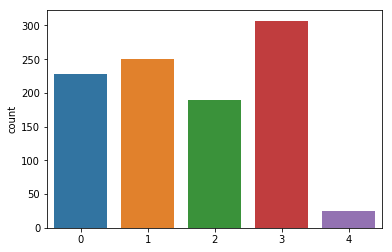

In [33]:
sns.countplot(Z_train[Z_train!=-1])

In [18]:
y_obs.shape

(98980, 1960)

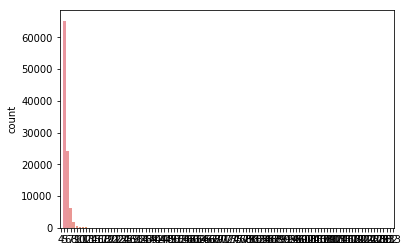

Minimum annotations in a example:  4
Maximum annotations in a example:  133
T data (expected value):  5.75140432410588
Graphics of T weights


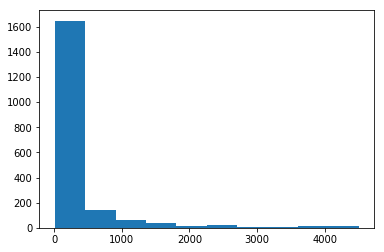

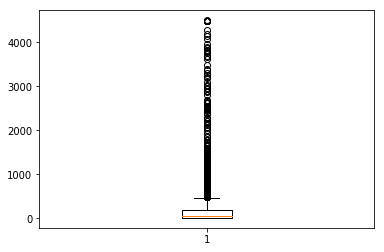

Minimum annotations by an annotator:  8
Maximum annotations by an annotator:  4506
Mean annotations by an annotator:  290.44591836734696


In [27]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 5.267546 sec
Estimation MV in 0.007917 sec
Normalized entropy (0-1) of repeats annotations: 0.26250069754851657


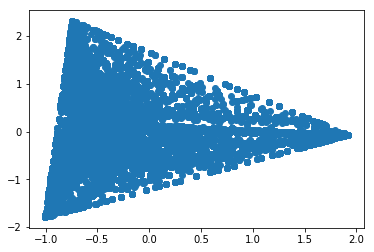

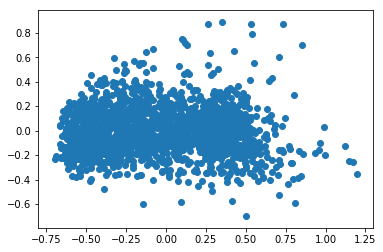

In [31]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
#print("ACC MV on train:",np.mean(mv_onehot==Z_data))
#print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

#### opcion 2 ocupar solo los de crowdflower (son mil)

In [107]:
df_ann = pd.read_csv(folder+"github/weather-non-agg-DFE.csv")
df_ann.head()

_unit_id         _created_at  _canary         _id         _started_at  \
0  314960380  8/23/2013 23:57:30      NaN  1038995940  8/23/2013 23:57:20   
1  314960380  8/24/2013 00:09:18      NaN  1039004532  8/24/2013 00:09:05   
2  314960380  8/24/2013 00:09:31      NaN  1039004700  8/24/2013 00:08:14   
3  314960380  8/24/2013 00:11:55      NaN  1039006547  8/24/2013 00:11:13   
4  314960380  8/24/2013 00:13:22      NaN  1039007700  8/24/2013 00:11:50   

     _channel  _trust  _worker_id _country _region                _city  \
0      probux  1.0000    18939994      PRT      14  Vila Franca De Xira   
1     eup_slw  0.4658    19028457      DEU      02          Holzkirchen   
2   clixsense  0.7630    14400603      SRB     NaN                  NaN   
3   clixsense  0.6429    17475684      IND      02             Tirupati   
4  stuffpoint  0.9286    11800825      SWE      10               Avesta   

              _ip  \
0     2.83.187.82   
1  188.192.44.105   
2  178.221.70.117   
3  117.204.49.167   
4  83.253.207.185   

  what_emotion_does_the_author_express_specifically_about_the_weather  \
0       Neutral / author is just sharing information                    
1                                           Negative                    
2                                           Positive                    
3                                           Positive                    
4                                           Positive                    

   gold_answer  tweet_id                                         tweet_text  
0          NaN  81990560  Grilling kabobs on the grill last night was am...  
1          NaN  81990560  Grilling kabobs on the grill last night was am...  
2          NaN  81990560  Grilling kabobs on the grill last night was am...  
3          NaN  81990560  Grilling kabobs on the grill last night was am...  
4          NaN  81990560  Grilling kabobs on the grill last night was am...

In [108]:
labels_cat = {"Negative":0, "Neutral / author is just sharing information":1, "Positive":2, 
              "Tweet not related to weather condition":3,"I can't tell":4 }

In [109]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for row in df_ann.values:
    inp_id = row[-2]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = row[7]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
        
#Z_train = np.ones(contador_data, dtype='int16')*-1
texts_train = [ [] for _ in range(contador_data)]

y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
for row in df_ann.values:
    y_obs[data_id[row[-2]], worker_id[row[7]]] = labels_cat[row[-4]]
    texts_train[data_id[row[-2]]] = row[-1]
    
    
        
#np.savetxt("./Sentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
#np.savetxt("./Sentiment/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
#np.savetxt("./Sentiment/sent_test.txt", Z_test,delimiter=' ', fmt='%d')
#with open("./Sentiment/texts_train.txt", 'w') as fp:
#    fp.write("\n".join(texts_train))
#with open("./Sentiment/texts_test.txt", 'w') as fp:
#    fp.write("\n".join(texts_test))   
y_obs.shape

(1000, 102)

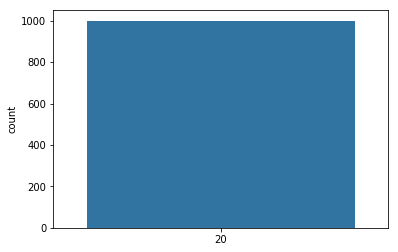

Minimum annotations in a example:  20
Maximum annotations in a example:  20
T data (expected value):  20.0
Graphics of T weights


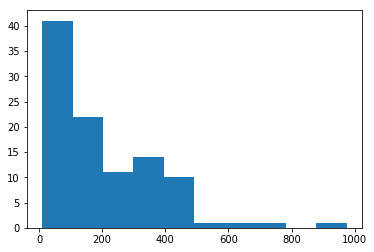

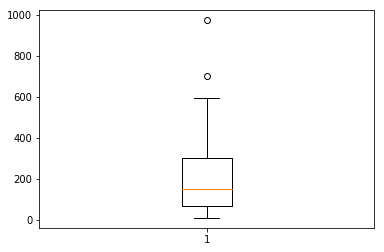

Minimum annotations by an annotator:  10
Maximum annotations by an annotator:  974
Mean annotations by an annotator:  196.07843137254903
Representation for MV in 0.130688 sec
Estimation MV in 0.000397 sec


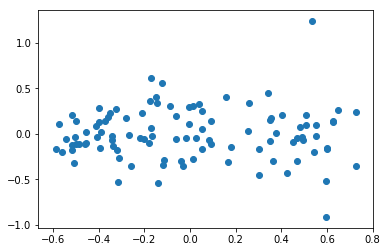

In [111]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())


label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')

Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_onehot)

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

### Semeval 2013 / task2 - B

https://www.cs.york.ac.uk/semeval-2013/task2.html

* Sentiment Analysis in Twitter

* positive|negative|neutral|objective


In [2]:
folder = "../Semeval/"
df_ann = pd.read_csv(folder+"tweeti-b.dist.tsv", sep='\t', header=None, names =["SID","UID","sent"])

df_ann = pd.read_csv(folder+"Tweets/texts_train.txt", sep='\t', header=None, names =["SID","UID","sent","text"])
#df_gt = pd.read_csv(folder+"cf-gold/reference_100%.csv")
df_ann.head()

SID        UID      sent  \
0  264183816548130816   15140428  positive   
1  264249301910310912   18516728  negative   
2  264105751826538497  147088367  positive   
3  264094586689953794  332474633  negative   
4  254941790757601280  557103111  negative   

                                                text  
0  Gas by my house hit $3.39!!!! I'm going to Cha...  
1  Iranian general says Israel's Iron Dome can't ...  
2  with J Davlar 11th. Main rivals are team Polan...  
3  Talking about ACT's && SAT's, deciding where I...  
4  They may have a SuperBowl in Dallas, but Dalla...

In [3]:
labels_cat = {"negative":0, "neutral":1, "positive":2, 
              "objective":3,"objective-OR-neutral":4 }
labels_cat

{'negative': 0,
 'neutral': 1,
 'objective': 3,
 'objective-OR-neutral': 4,
 'positive': 2}

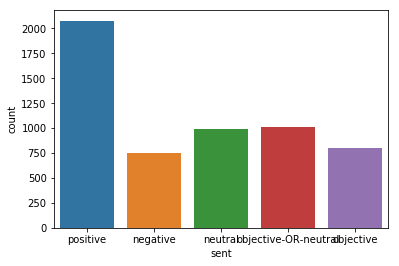

In [5]:
sns.countplot(df_ann["sent"])

In [4]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for row in df_ann.values:
    inp_id = row[0]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    #work_id = contador_work #row[1]
    #if work_id not in worker_id:
    #    worker_id[work_id] = contador_work
    #    contador_work+=1  
        
#y_obs = np.ones((contador_data,df_ann.shape[0]),dtype='int16')*-1
#for row in df_ann.values:
#    work_id = contador_work #row[1]
#    y_obs[data_id[row[0]],work_id] = labels_cat[row[2]]
#    contador_work+=1
    
Z_data = np.ones((contador_data),dtype='int16')*-1
texts_data = [ [] for _ in range(contador_data)]
for row in df_ann.values:
    Z_data[data_id[row[0]]] = labels_cat[row[2]]
    texts_data[data_id[row[0]]] = row[-1].replace("\n", ' ')

        
#np.savetxt("./Sentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
np.savetxt("./Sentiment/Semeval/sent_data.txt", Z_data,delimiter=' ', fmt='%d')
with open("./Sentiment/Semeval/texts_data.txt", 'w') as fp:
    fp.write("\n".join(texts_data))
#with open("./Sentiment/texts_test.txt", 'w') as fp:
#    fp.write("\n".join(texts_test))  
#y_obs.shape

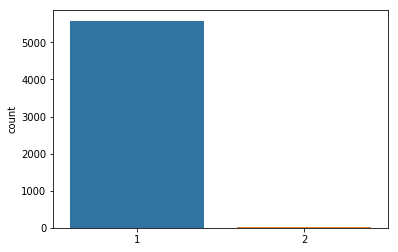

Minimum annotations in a example:  1
Maximum annotations in a example:  2
T data (expected value):  1.0044571224817258
Graphics of T weights


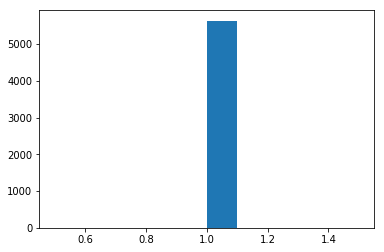

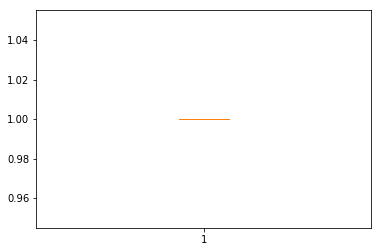

Minimum annotations by an annotator:  1
Maximum annotations by an annotator:  1
Mean annotations by an annotator:  1.0


In [83]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Airline Sentiment
A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as “late flight” or “rude service”).

links
> https://www.figure-eight.com/data-for-everyone/  
> https://github.com/naimulhuq/Capstone

In [3]:
folder = "../Nuevos/AirLine Sentiment/"
df_ann = pd.read_csv(folder+"Airline-Full-Non-Ag-DFE-Sentiment.csv")
df_ann.head()

_unit_id         _created_at  _golden         _id _missed  \
0  681448150  2/25/2015 04:52:40    False  1575073003     NaN   
1  681448150  2/25/2015 05:22:10    False  1575093916     NaN   
2  681448150  2/25/2015 05:24:40    False  1575095606     NaN   
3  681448153  2/25/2015 01:43:24    False  1574913129     NaN   
4  681448153  2/25/2015 01:43:34    False  1574913225     NaN   

          _started_at  _tainted   _channel  _trust  _worker_id  \
0  2/25/2015 04:49:12     False      elite  0.8108    31110645   
1  2/25/2015 05:19:59     False    prodege  0.8919     1908948   
2  2/25/2015 05:20:10     False  clixsense  0.7222    31396033   
3  2/25/2015 01:40:59     False     neodev  0.8966    31346116   
4  2/25/2015 01:40:56     False     neodev  0.8108    31452413   

              ...             airline_sentiment_gold      name  \
0             ...                                NaN   cairdin   
1             ...                                NaN   cairdin   
2             ...                                NaN   cairdin   
3             ...                                NaN  jnardino   
4             ...                                NaN  jnardino   

  negativereason_gold retweet_count  \
0                 NaN             0   
1                 NaN             0   
2                 NaN             0   
3                 NaN             0   
4                 NaN             0   

                                                text tweet_coord  \
0                @VirginAmerica What @dhepburn said.         NaN   
1                @VirginAmerica What @dhepburn said.         NaN   
2                @VirginAmerica What @dhepburn said.         NaN   
3  @VirginAmerica plus you've added commercials t...         NaN   
4  @VirginAmerica plus you've added commercials t...         NaN   

      tweet_created      tweet_id tweet_location               user_timezone  
0  2015-02-24 11:35  5.703060e+17            NaN  Eastern Time (US & Canada)  
1  2015-02-24 11:35  5.703060e+17            NaN  Eastern Time (US & Canada)  
2  2015-02-24 11:35  5.703060e+17            NaN  Eastern Time (US & Canada)  
3  2015-02-24 11:15  5.703010e+17            NaN  Pacific Time (US & Canada)  
4  2015-02-24 11:15  5.703010e+17            NaN  Pacific Time (US & Canada)  

[5 rows x 27 columns]

{nan: -1, 'negative': 0, 'neutral': 1, 'positive': 2}


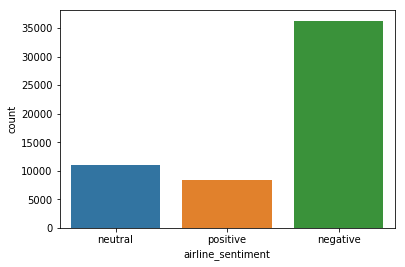

airline_sentiment negativereason
0               neutral            NaN
1               neutral            NaN
2               neutral            NaN
3              positive            NaN
4               neutral            NaN
5              negative      badflight
6              positive            NaN
7               neutral            NaN
8               neutral            NaN
9              negative      CSProblem
10             negative      badflight
11             negative      badflight
12             negative       canttell
13             negative       canttell
14             negative       canttell
15             negative      badflight
16             negative       canttell
17             negative       canttell
18             negative       canttell
19             positive            NaN
20             positive            NaN
21             positive            NaN
22              neutral            NaN
23              neutral            NaN
24              neutral            NaN
25             positive            NaN
26             positive            NaN
27             positive            NaN
28             positive            NaN
29             positive            NaN
...                 ...            ...
55753          positive            NaN
55754          positive            NaN
55755          positive            NaN
55756          negative      badflight
55757          negative      badflight
55758          negative      badflight
55759           neutral            NaN
55760           neutral            NaN
55761          negative        booking
55762          negative         cancel
55763          negative         cancel
55764          negative         cancel
55765          positive            NaN
55766          negative           late
55767          negative           late
55768          negative         cancel
55769           neutral            NaN
55770          positive            NaN
55771          negative      CSProblem
55772          negative      CSProblem
55773          negative      CSProblem
55774           neutral            NaN
55775           neutral            NaN
55776           neutral            NaN
55777          negative         cancel
55778          negative      CSProblem
55779          negative      CSProblem
55780           neutral            NaN
55781          negative        booking
55782           neutral            NaN

[55783 rows x 2 columns]

In [4]:
#cat_map = {e:i for i,e in enumerate(df_ann["airline_sentiment"].unique())}
cat_map = {"negative":0, "neutral":1,"positive":2}
cat_map[np.nan] = -1 #for ground truth
print(cat_map)

sns.countplot(df_ann["airline_sentiment"])
plt.show()
df_ann[["airline_sentiment","negativereason"]]

In [3]:
#second clasification?
df_ann["negativereason"].unique()

array([nan, 'badflight', 'CSProblem', 'canttell', 'late', 'airplanestaff',
       'booking', 'lostluggae', 'cancel', 'damagedluggage', 'longlines'],
      dtype=object)

In [5]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = df_ann["_worker_id"].iloc[i]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
    
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
Z_train = np.ones(contador_data, dtype='int16')*-1
texts_train = [ [] for _ in range(contador_data)]
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    work_id = df_ann["_worker_id"].iloc[i]
    y_obs[data_id[inp_id], worker_id[work_id]] = cat_map[df_ann["airline_sentiment"].iloc[i]]
    if Z_train[data_id[inp_id]] == -1: 
        Z_train[data_id[inp_id]] = cat_map[df_ann["airline_sentiment_gold"].iloc[i]]
        texts_train[data_id[inp_id]] = df_ann["text"].iloc[i].replace("\n",'')
print("ground truth data: ",np.sum(Z_train!=-1))

        
#np.savetxt("./AirlineSentiment/answers.txt", y_obs,delimiter=' ', fmt='%d')
#np.savetxt("./AirlineSentiment/sent_train.txt", Z_train,delimiter=' ', fmt='%d')
#with open("./AirlineSentiment/texts_train.txt", 'w') as fp:
#    fp.write("\n".join(texts_train))
y_obs.shape

ground truth data:  80


(14680, 503)

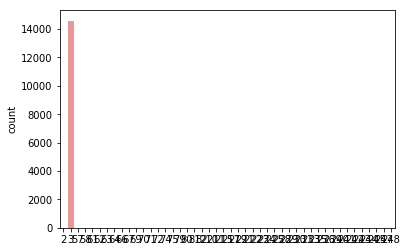

Minimum annotations in a example:  2
Maximum annotations in a example:  248
T data (expected value):  3.799931880108992
Graphics of T weights


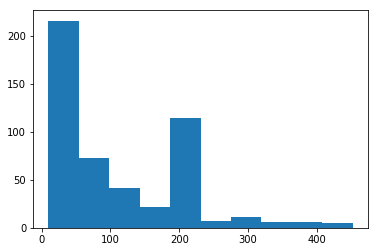

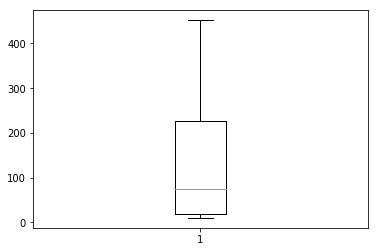

Minimum annotations by an annotator:  10
Maximum annotations by an annotator:  452
Mean annotations by an annotator:  110.90059642147118


In [117]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.499030 sec
Estimation MV in 0.001098 sec
ACC MV on train: 1.0
F1 MV on train: 1.0
Normalized entropy (0-1) of repeats annotations: 0.1724012327296246


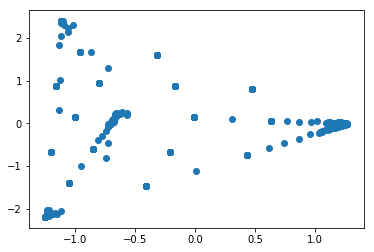

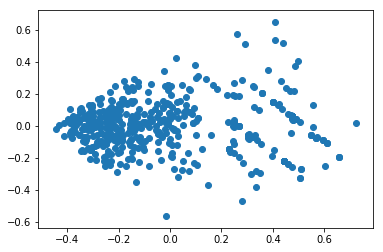

In [119]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
mask_true = Z_train != -1
print("ACC MV on train:",np.mean(mv_onehot[mask_true]==Z_train[mask_true]))
print("F1 MV on train:",f1_score(Z_train[mask_true],mv_onehot[mask_true],average="macro"))

mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

### Plutchnik Emotion
Contributors looked at a single sentence and rated its emotional content based on Plutchik’s wheel of emotions. 18 emotional choices were presented to contributors for grading.
> https://www.figure-eight.com/data-for-everyone/

In [46]:
folder = "../Nuevos/PlutchnikEmotion/"
df_ann = pd.read_csv(folder+"plutchik-wheel-full-DFE.csv")
df_ann.head()

_unit_id        _created_at  _golden         _id _missed  \
0  731671736  6/8/2015 15:27:42    False  1655597414     NaN   
1  731671736  6/8/2015 15:37:09    False  1655611318     NaN   
2  731671736  6/8/2015 15:39:26    False  1655614903     NaN   
3  731671736  6/8/2015 15:44:22    False  1655622353     NaN   
4  731671736  6/8/2015 16:10:09    False  1655661485     NaN   

         _started_at  _tainted        _channel  _trust  _worker_id _country  \
0  6/8/2015 15:26:09     False         instagc  0.6667    28524232      CAN   
1  6/8/2015 15:35:14     False     tremorgames  1.0000    29121923      IRL   
2  6/8/2015 15:35:53     False  points4rewards  1.0000    28755767      USA   
3  6/8/2015 15:38:02     False          neodev  1.0000    32108888      USA   
4  6/8/2015 16:05:56     False  points4rewards  0.8333    20113482      USA   

  _region        _city              _ip   emotion emotion_gold  id  idiom_id  \
0      ON  Scarborough   99.244.116.246   Neutral          NaN   1         1   
1      16     Limerick    95.45.138.162  Surprise          NaN   1         1   
2      VA      Chester     68.57.118.32     Anger          NaN   1         1   
3      CA     San Jose    50.117.41.210  Optimism          NaN   1         1   
4      CA     Pasadena  205.144.165.253   Neutral          NaN   1         1   

                                            sentence  
0  How much of the forecast was genuine and how m...  
1  How much of the forecast was genuine and how m...  
2  How much of the forecast was genuine and how m...  
3  How much of the forecast was genuine and how m...  
4  How much of the forecast was genuine and how m...

In [47]:
cat_map = {e:i for i,e in enumerate(df_ann["emotion"].unique())}
cat_map[np.nan] = -1
print(cat_map)

{nan: -1, 'Ambiguous': 6, 'Aggression': 10, 'Remorse': 16, 'Anger': 2, 'Awe': 15, 'Contempt': 13, 'Optimism': 3, 'Trust': 8, 'Fear': 17, 'Neutral': 0, 'Surprise': 1, 'Love': 4, 'Joy': 12, 'Submission': 5, 'Sadness': 9, 'Anticipation': 7, 'Disapproval': 11, 'Disgust': 14}


In [50]:
df_ann["emotion_gold"].unique()

array([nan,
       'Aggression\nAnger\nAwe\nContempt\nDisapproval\nDisgust\nLove\nNeutral',
       'Aggression\nAnger\nContempt\nDisapproval\nDisgust',
       'Aggression\nAnger\nContempt\nDisapproval\nDisgust\nRemorse\nSadness',
       'Anger\nDisapproval\nLove\nNeutral\nSadness',
       'Joy\nOptimism\nSurprise', 'Ambiguous\nNeutral', 'Joy\nOptimism',
       'Aggression\nAmbiguous\nAnger\nContempt\nDisapproval\nDisgust\nNeutral\nRemorse\nSadness',
       'Aggression\nAnger\nContempt\nDisapproval\nDisgust\nSadness',
       'Aggression\nAnger\nContempt\nDisapproval\nRemorse',
       'Ambiguous\nAnticipation\nContempt\nDisapproval\nFear\nLove\nOptimism\nSurprise\nTrust',
       'Ambiguous\nNeutral\nOptimism\nTrust',
       'Aggression\nAnger\nContempt\nDisapproval\nDisgust\nRemorse',
       'Aggression\nAnger\nDisapproval\nFear\nSurprise',
       'Aggression\nAnger', 'Optimism',
       'Anger\nAnticipation\nContempt\nDisapproval\nDisgust\nFear\nRemorse\nSadness',
       'Awe\nFear\nSurp

In [52]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = df_ann["_worker_id"].iloc[i]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
    
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
Z_train = np.ones(contador_data, dtype='int16')*-1
texts_train = [ [] for _ in range(contador_data)]
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    work_id = df_ann["_worker_id"].iloc[i]
    y_obs[data_id[inp_id], worker_id[work_id]] = cat_map[df_ann["emotion"].iloc[i]]
    if Z_train[data_id[inp_id]] == -1: 
        #how to choose GT??
        try:
            Z_train[data_id[inp_id]] = cat_map[df_ann["emotion_gold"].iloc[i]]
        except:
            Z_train[data_id[inp_id]] = cat_map[df_ann["emotion_gold"].iloc[i].split("\n")[0]]
        texts_train[data_id[inp_id]] = df_ann["sentence"].iloc[i]
print("ground truth data: ",np.sum(Z_train!=-1))
y_obs.shape

ground truth data:  54


(2524, 96)

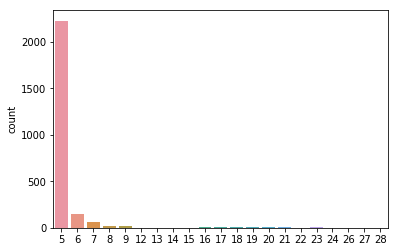

Minimum annotations in a example:  5
Maximum annotations in a example:  28
T data (expected value):  5.467908082408875
Graphics of T weights


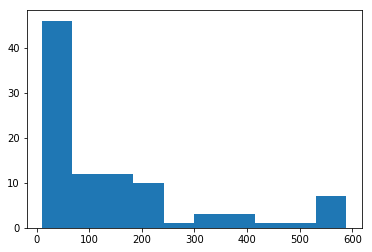

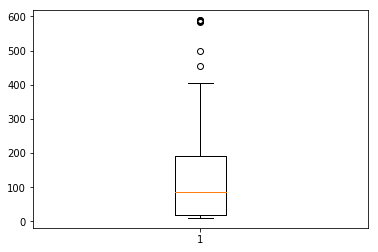

Minimum annotations by an annotator:  10
Maximum annotations by an annotator:  589
Mean annotations by an annotator:  143.76041666666666


In [53]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.110303 sec
Estimation MV in 0.000777 sec
Normalized entropy (0-1) of repeats annotations: 0.38081940435115635


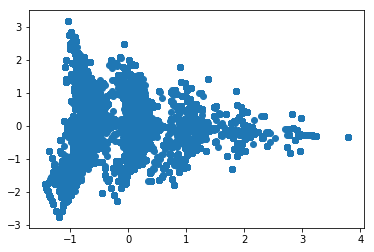

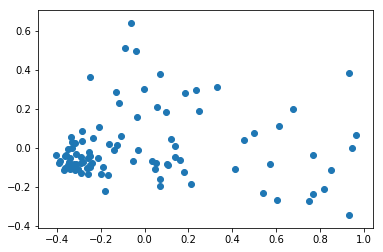

In [55]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
#print("ACC MV on train:",np.mean(mv_onehot==Z_data))
#print("F1 MV on train:",f1_score(Z_data,mv_onehot,average="micro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

### Company URL
A data set where business names were matched with URLs/homepages for the named businesses.
Contributors were asked to visit a provided website and determine if the site matched a given company name. They then categorized the businesses according to the following criteria:

    Automotive
    Consumer Packaged Goods
    Financial Services
    Retail
    Travel
    Other

Data set includes the given company name, URL, and categorization of each business.
> https://www.figure-eight.com/data-for-everyone/

In [29]:
folder = "../Nuevos/CompanyURL//"
df_ann = pd.read_csv(folder+"company-categorization-non-ag-DFE.csv", low_memory=False)
df_ann.head()

_unit_id        _created_at  _golden _canary         _id _missed  \
0  474823173  6/4/2014 23:13:15    False     NaN  1289157499     NaN   
1  474823173  6/4/2014 23:57:33    False     NaN  1289177999     NaN   
2  474823173  6/5/2014 00:29:34    False     NaN  1289197449     NaN   
3  474823174  6/4/2014 22:32:17    False     NaN  1289128970     NaN   
4  474823174  6/4/2014 22:32:59    False     NaN  1289129505     NaN   

         _started_at  _tainted _channel  _trust          ...            \
0  6/4/2014 23:10:56     False  eup_slw  0.6667          ...             
1  6/4/2014 23:55:19     False   neodev  0.7500          ...             
2  6/5/2014 00:26:09     False   neodev  0.7838          ...             
3  6/4/2014 22:31:14     False   neodev  0.8200          ...             
4  6/4/2014 22:30:23     False   neodev  0.7826          ...             

   google1_correct_website google1_correct_website_found  \
0     http://central1.com/                           yes   
1     http://central1.com/                           yes   
2     http://central1.com/                           yes   
3    http://ad-agents.com/                           yes   
4    http://ad-agents.com/                           yes   

  google1_correct_website_found_gold google1_correct_website_foundconfidence  \
0                                NaN                                    1.00   
1                                NaN                                    1.00   
2                                NaN                                    1.00   
3                                NaN                                    0.64   
4                                NaN                                    0.64   

  google1_correct_website_gold google1_correct_website_worker_input  \
0                          NaN                    /www.central1.com   
1                          NaN                    /www.central1.com   
2                          NaN                    /www.central1.com   
3                          NaN                       ad-agents.com/   
4                          NaN                       ad-agents.com/   

  google1_correct_website_worker_inputconfidence  \
0                                         0.6538   
1                                         0.6538   
2                                         0.6538   
3                                         0.2304   
4                                         0.2304   

  google1_correct_websiteconfidence                            website  \
0                            0.6538                                NaN   
1                            0.6538                                NaN   
2                            0.6538                                NaN   
3                            0.3600  http://www.ad-agents.com/kontakt/   
4                            0.3600  http://www.ad-agents.com/kontakt/   

   website_match_yn_gold  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN  

[5 rows x 38 columns]

In [19]:
df_ann[df_ann["website_match_yn"] == "website_no_match"].iloc[:,10:]

_worker_id _country _region         _city              _ip  \
189      17628770      USA      TX        Porter    75.108.233.84   
374      14265684      HUN      03         Gyula     82.150.58.12   
2373     14265684      HUN      03         Gyula     82.150.58.12   
2454     27393376      BRA      07      Brasília    189.6.108.235   
2488     25603852      ROU      17       Craiova    86.126.60.142   
3088     27089497      VNM      44         Hanoi  171.226.141.182   
3204     25747978      PRT      09          Faro    85.246.203.93   
3356     24907909      ROU      09        Brasov    188.27.57.121   
4151     19982940      GBR      B1        Bolton   176.253.129.25   
4159     25670443      MEX      30      Coatepec    189.251.59.85   
5614     27287299      SRB      00      Belgrade  178.223.198.116   
5813     26312996      IDN      30         Garut  125.163.110.190   
5814     27178467      MKD      41        Skopje     31.11.101.79   
5979     13833217      IND     NaN           NaN   115.111.223.51   
5980     24346636      TUR      26     Eskisehir   78.165.210.176   
5981     16567674      PHL      D9        Makati    121.54.32.154   
9045     24660707      ESP      51   Puerto Real   31.131.179.237   
9046     14265684      HUN      03         Gyula     82.150.58.12   
9047     22051892      PER      15          Lima   200.106.38.252   
9682     25747978      PRT      09          Faro    85.246.203.93   
9969     11923509      ROU      33         Sibiu     92.82.70.218   
10275    27024172      PER      15          Lima   190.43.153.199   
10747    18146452      IND      02     Hyderabad      27.6.56.214   
11004    21380810      IND      02     Hyderabad    124.123.83.62   
11005    14265684      HUN      03         Gyula     82.150.58.12   
11838    23446117      BGR      51       Plovdiv    87.97.205.103   
11839    11575732      IDN      30       Bandung  202.152.202.226   
12706    24697927      VEN     NaN           NaN   186.95.116.163   
12760    15997197      MEX      12      Huitzuco     201.145.33.5   
12761    27491710      PHL      M5         Bayan     110.55.1.164   
...           ...      ...     ...           ...              ...   
13967    24697927      VEN     NaN           NaN   186.95.116.163   
13968    11026819      MYS      14  Kuala Lumpur    175.136.22.13   
14116    18146452      IND      02     Hyderabad      27.6.56.214   
14414    27352193      ESP     NaN           NaN     62.37.160.26   
14567    21505935      GBR      H9        London    86.177.182.66   
15474    14265684      HUN      03         Gyula     82.150.58.12   
15697    14265684      HUN      03         Gyula     82.150.58.12   
16335    25945355      POL      77        Kraków    176.115.6.233   
16524    21005843      SVN     NaN           NaN  109.182.140.146   
16919    18866608      DEU      07      Schwerte   87.161.166.224   
16993    21380810      IND      02     Hyderabad    124.123.83.62   
16995    15997197      MEX      12      Huitzuco     201.145.33.5   
18168    17628770      USA      TX        Porter    75.108.233.84   
18407    25603852      ROU      17       Craiova    86.126.60.142   
19096    22436101      IND      25    Coimbatore   122.178.164.18   
19776    26578416      IND      02     Hyderabad   49.204.169.118   
20271    18981438      MAR      57       Tétouan    41.249.69.199   
20281    25747978      PRT      09          Faro    85.246.203.93   
20369    13616832      VEN     NaN           NaN   190.200.140.72   
20919    22436101      IND      25    Coimbatore   122.178.164.18   
20978    20771532      VEN      25       Caracas    200.84.11.249   
20984    25945355      POL      77        Kraków    176.115.6.233   
20985    26312996      IDN      30         Garut  125.163.110.190   
23001    27024172      PER      15          Lima   190.43.153.199   
24100    19132694      LKA     NaN           NaN    61.245.163.38   
25097    18866608      DEU      07      Schwerte   87.161.166.224   
25104

In [33]:
#df_ann["business_category"].fillna("Notcompany", inplace=True) #fill not website match as a class
df_ann.dropna(axis=0, subset=["business_category"],  inplace=True) #fill not website match as a class
    
df_ann[["business_category","website_match_yn",
       "business_name", "google1_correct_website",
       "website", "google1_correct_website_worker_input"]]

business_category   website_match_yn  \
0      Financial Services  website_yes_match   
1      Financial Services  website_yes_match   
2      Financial Services  website_yes_match   
3                   Other  website_yes_match   
4                  Retail  website_yes_match   
5      Financial Services  website_yes_match   
6                   Other  website_yes_match   
7                   Other  website_yes_match   
8                   Other  website_yes_match   
9                   Other  website_yes_match   
10                 Retail  website_yes_match   
11                 Retail  website_yes_match   
12                  Other  website_yes_match   
13                 Retail  website_yes_match   
14                  Other  website_yes_match   
15                  Other  website_yes_match   
16                  Other  website_yes_match   
17                 Retail  website_yes_match   
18                  Other  website_yes_match   
19                  Other  website_yes_match   
20                  Other  website_yes_match   
21                  Other  website_yes_match   
22                  Other  website_yes_match   
23                  Other  website_yes_match   
24                    CPG  website_yes_match   
25                 Retail  website_yes_match   
26                  Other  website_yes_match   
27                  Other  website_yes_match   
28     Financial Services  website_yes_match   
29                  Other  website_yes_match   
...                   ...                ...   
28645              Retail  website_yes_match   
28646              Retail  website_yes_match   
28647              Retail  website_yes_match   
28648              Retail  website_yes_match   
28649              Retail  website_yes_match   
28650              Retail  website_yes_match   
28651              Retail  website_yes_match   
28652              Retail  website_yes_match   
28653              Retail  website_yes_match   
28654              Retail  website_yes_match   
28655              Retail  website_yes_match   
28656              Retail  website_yes_match   
28657              Retail  website_yes_match   
28658              Retail  website_yes_match   
28659              Retail  website_yes_match   
28660              Retail  website_yes_match   
28661               Other  website_yes_match   
28662              Retail  website_yes_match   
28663              Retail  website_yes_match   
28664              Retail  website_yes_match   
28665              Retail  website_yes_match   
28666              Retail  website_yes_match   
28667               Other  website_yes_match   
28668              Retail  website_yes_match   
28669              Retail  website_yes_match   
28670              Retail  website_yes_match   
28671              Retail  website_yes_match   
28672              Retail  website_yes_match   
28673              Retail  website_yes_match   
28674              Retail  website_yes_match   

                          business_name               google1_correct_website  \
0                             Central 1                  http://central1.com/   
1                             Central 1                  http://central1.com/   
2                             Central 1                  http://central1.com/   
3      ad agents GmbH Hamburg - Germany                 http://ad-agents.com/   
4      ad agents GmbH Hamburg - Germany                 http://ad-agents.com/   
5      ad agents GmbH Hamburg - Germany                 http://ad-agents.com/   
6                      ad tech | iMedia                   http://ad-tech.com/   
7                      ad tech | iMedia                   http://ad-tech.com/   
8                      ad tech | iMedia                   http://ad-tech.com/   
9                                AddRev                    http://addrev.com/   
10                               AddRev                    http://addrev.com/   
11                               AddRev                    

In [ ]:
### agregar el nombre...

In [39]:
cat_map = {e:i for i,e in enumerate(df_ann["business_category"].unique())}
cat_map[np.nan] = -1 
print(cat_map) 

{nan: -1, 'Other': 1, 'Retail': 2, 'Financial Services': 0, 'CPG': 3, 'Travel': 4, 'Auto': 5}


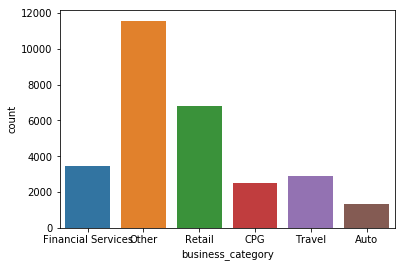

In [40]:
sns.countplot(df_ann["business_category"])

In [41]:
####### GUARDAR DATA
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = df_ann["_worker_id"].iloc[i]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
    
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
Z_train = np.ones(contador_data, dtype='int16')*-1
Z_test = []
urls_train = [ [] for _ in range(contador_data)]
urls_trainB = [ [] for _ in range(contador_data)]
for i in range(df_ann.shape[0]):
    inp_id = df_ann["_unit_id"].iloc[i]
    work_id = df_ann["_worker_id"].iloc[i]
    y_obs[data_id[inp_id], worker_id[work_id]] = cat_map[df_ann["business_category"].iloc[i]]
    if Z_train[data_id[inp_id]] == -1: 
        Z_train[data_id[inp_id]] = cat_map[df_ann["business_category_gold"].iloc[i]]
        urls_train[data_id[inp_id]] = df_ann["google1_correct_website"].iloc[i]
        urls_trainB[data_id[inp_id]] = df_ann["website"].iloc[i]
    
print("ground truth data: ",np.sum(Z_train!=-1))
y_obs.shape

ground truth data:  177


(7333, 837)

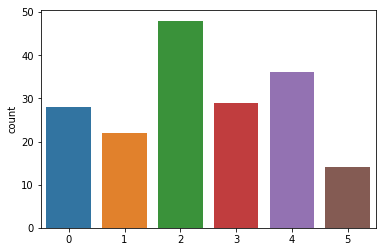

In [42]:
sns.countplot(Z_train[Z_train!=-1])

In [43]:
import urllib, requests, bs4
blacklist = [
    '[document]',
    'noscript',
    'header',
    'html',
    'meta',
    'head', 
    'input',
    'script',
    'style' ,
    'span',
    'button'
    #eliinar titulos "h" o  "a?
]

#dejar solo <p>?

def clean_contenido(inf):
    text = inf.find_all(text=True)  
    output = ''
    for t in text:
        if t.parent.name not in blacklist:
            contenido = t.strip() #deja sin espacios.. esta bien??
            if len(contenido) >0:
                print("Name: %s , contenido: %s"%(t.parent.name,contenido))
                output += ' {}.'.format(contenido)
    return output

In [ ]:
texts_url = []

not_found_url = []
for i,url in enumerate(urls_train):
    content = ""
    try:
        page = urllib.request.urlopen(url).read()
    except:
        #try:
        #    page = requests.get(url).text
        #except:
        try:
            page = urllib.request.urlopen(urls_trainB[i]).read()
        except:
            not_found_url.append([i,url])
            continue
            
    if len(page) ==0:
        #try:
        #    page = urllib.request.urlopen(urls_trainB[i]).read()
        #except:
        #    try:
        #        page = requests.get(urls_trainB[i]).text
        #    except:
                not_found_url.append([i,url])
                continue

    soup = bs4.BeautifulSoup(page, 'html.parser')
    
    if type(soup.title) == type(None):
        #not_found_url.append([i,url])
        #continue
        pass
    else:
        content += soup.title.text.strip()
        
    if type(soup.body) != type(None):
        for i in soup.body.find_all("p"): 
            for value in i.find_all(text=True):
                if value.parent.name not in blacklist and len(value.strip())>0:
                    content += ' '+value.strip()  #re.sub(r'http\S+', '', i.text.strip() )
    
    if len(content) == 0:
        not_found_url.append([i,url])
        continue
    
    #head_title = soup.head.title.text.strip()
    #print("Title encontrado: ",head_title)
    #print("Otro title: ",soup.title.text.strip())
    
    #body_text = clean_contenido(soup.body)
    #body_text = soup.body.find_all("p") #cada uno ponerle.text
    print("Content found: ",content)
    texts_url.append(content)

Content found:  Home - Central 1 /At Central 1, we power financial institutions. READ MORE ABOUT FORGE
Content found:  Agentur für Online & Performance Marketing | ad agents GmbH mission: best performance Als führen wir unsere Kunden seit 2006 zum Erfolg. Unsere Mission: best performance. Von Beratung bis Umsetzung, national bis international, leidenschaftlich und vertrauensvoll. Starten Sie mit uns durch! SEA SEO Affiliate Social Media Advertising Display Advertising Product Data Management Amazon Services Analytics & Data Sie sind auf der Suche nach einem Partner, der Sie bei der Planung und Durchführung eines effizienten und schlagkräftigen Online und Performance Marketings unterstützt? Dann sind Sie bei uns genau richtig! Von Amazon über Social Media Advertising bis zu unseren Analytics Services unterstützen wir Sie ganzheitlich oder punktuell auf Ihrer Erfolgsmission. Profitieren Sie von unserer jahrelangen Erfahrung und starten mit uns durch! Unsere Leistungen Sie wünschen sich e

Content found:  AURUM by Guðbjörg | Icelandic Jewellery Handcrafted by Master Artisans free shipping on orders €120+ free shipping on orders €120+ Your Cart is Empty SAND SAND is inspired by the textured beauty of the peaceful and untouched Icelandic landscape. ASTERIAS Waves quietly breaking on a forgotten beach in the West fjords. Drops rising above the horizon. FALCON The falcon is closely interwoven with Iceland’s history and its battle for independence and freedom. LAX Lax seems to be made up of innumerable threads that weave and connect like a musical composition. SAND SAND is inspired by the textured beauty of the peaceful and untouched Icelandic landscape. ASTERIAS Waves quietly breaking on a forgotten beach in the West fjords. Drops rising above the horizon. FALCON The falcon is closely interwoven with Iceland’s history and its battle for independence and freedom. LAX Lax seems to be made up of innumerable threads that weave and connect like a musical composition. 2018 Featuri

Content found:  Boston Herald - Boston news, sports, politics, opinion, entertainment, weather and obituaries Trending: Sign up for email newsletters
Content found:  Startseite - Bridgestone Deutschland Lkw und Busse Baumaschinen Runderneuerung TomTom Telematics FleetPulse Ob Touring- oder Sportreifen, ob im Sommer oder Winter – unser Angebot an Pkw- und 4x4-Reifen erfüllt zahlreiche Fahrzeuganforderungen und ist für verschiedene Fahrstile geeignet, damit Sie Ihre Fahrten gut hinter sich bringen können. Egal ob auf der Straße, im schweren Gelände, auf großer Tour oder auf der Rennstrecke – unsere Motorradreifen zeichnen sich durch außergewöhnliche Performance und sichere Fahreigenschaften aus. Unsere Transporterreifen sind in der Lage, schwere Lasten und unterschiedliche Straßenverhältnisse zu bewältigen, während sie einen geringeren Kraftstoffverbrauch unterstützen: Zeit und Geld gespart. Das komplette Produktportfolio an Lkw- und Bus-Reifen bietet maximale Sicherheit, Traktion und Ko

Content found:  catalyst sf change starts with a catalyst An era of technological complexities and shifting consumer behaviors and expectations that are evolving faster than many companies can adapt. To survive and prosper brands need to adapt, to remain one step ahead of new paradigms in order to maximize the customer-brand relationship, and meet new customer behaviors and expectations. Visionary leaders recognize when it is time to pivot and activate a new brand strategy. Sign up with your email address to receive news and insights shaping the brand and marketing landscape. Thank you for subscribing to our thoughts lab!
Content found:  Inicio - CDM Smith Declaración de Privacidad Declaración de Privacidad
Content found:  A Non-Profit Hospital in Los Angeles | Cedars-Sinai This website translates English to other languages using an automated tool. We cannot guarantee the accuracy of the translated text. 6 specialties also ranked in the top 10 of U.S. News & World Report 's Best Hospit

Content found:  The domain name connectedmedia.eu is for sale | DAN.COM
Content found:  Interactive Advisors Covestor Ltd (175 Federal Street, Boston, MA, 02110) (also known as "Interactive Advisors") is an Investment
        Advisor registered with and regulated by the Securities and Exchange Commission under the Investment Advisors
        Act of 1940. Registration does not imply a level of skill or training. Covestor Ltd is not registered in any
        jurisdiction outside the United States. While registered as a private limited company in the United Kingdom,
        Covestor Ltd is not registered to provide investment management or advice in the United Kingdom. This website is
        for informational purposes only and is not intended to be a solicitation or advertisement in any jurisdiction
        other than the United States. See important Terms of Use and our Privacy Policy Notice on our Forms and Agreements page. Your trades are executed by Interactive Brokers LLC, a member 

Content found:  Partnersuche mit ElitePartner | für kultivierte und gebildete Singles Bitte aktivieren Sie JavaScript, um elitepartner nutzen zu können. Bitte akzeptieren Sie Cookies in Ihrem Browser, um elitepartner nutzen zu können. Näheres finden Sie hier Geben Sie bitte Ihr Geschlecht an. Geben Sie bitte Ihre E-Mail-Adresse ein. Ihre Angaben sind nicht sichtbar und werden bestens geschützt. Legen Sie bitte Ihr persönliches Passwort fest. Ihr Passwort entspricht nicht den Bedingungen Schützen Sie Ihre Daten mit einem sicheren Passwort. Beachten Sie folgendes: Es gelten die AGB und Datenschutzhinweise . Mit der kostenlosen Mitgliedschaft erhalten Sie regelmäßig Angebote zur kostenpflichtigen Mitgliedschaft und weiteren Produkten der PE Digital GmbH per Email (Widerspruch jederzeit möglich). Finden Sie Ihren ElitePartner! Anhand feiner Kriterien prüfen unsere geschulten Mitarbeiter jede Anmeldung und entscheiden, wer zu ElitePartner passt. Für besonders interessante, inspirierende Kon

Content found:  Elite SEM | Digital Marketing Agency | SEM, SEO, CRO, Display, Mobile Elite SEM is an amazing company! You truly feel valued as an employee and have the autonomy to make an impact." Everyone here is passionate about what they do and it's a wonderful feeling to be surrounded by such an intelligent and motivated team. Elite SEM truly offers great lives for great people. " Elite SEM is a role model for how other companies should treat their employees." Company values and office culture are something that would be hard to copy, even in a movie. " Your personal life and happiness are a HUGE priority to management. This is the first company I've ever worked for that PROACTIVELY sought to make sure my focus was on my family when it needed to be. " Elite SEM matches 100% of an employee’s contributions, up to 4% of an employee's income. Disability, Life, Health, & matching 401k contributions. We provide all employees with the peace of mind that they are fully insured and saving 

Content found:  Check Your Free Credit Report & FICO® Score | Experian Main Menu Main Menu Main Menu CreditMatch CreditMatch Main Menu Main Menu Education Education Education Free for 30 days, then just $19.99 /month † † IMPORTANT INFORMATION A credit card is required to start your free 30-day trial membership ‡ in Experian IdentityWorks SM Premium. You may cancel your trial membership at any time within 30 days without charge. If you decide not to cancel, your membership will continue and you will be billed $19.99 for each month that you continue your membership. You may easily cancel your trial membership online anytime within the trial period without charge. * Credit score is calculated based on FICO ® Score 8 model, unless otherwise noted. In addition to the FICO ® Score 8, we may offer and provide other base or industry-specific FICO ® Scores (such as FICO ® Auto Scores and FICO ® Bankcard Scores). Your lender or insurer may use a different FICO ® Score than FICO ® Score 8 or such

Content found:  CAUDALIE : Soin Cosmétique Naturel ⋅ Visage ⋅ Corps ⋅ Spa  - Caudalie Javascript est désactivé dans votre navigateur. NOUVEAU Une nouvelle génération de solaires : Protégez votre peau, nous protégeons la nature. L'Eau de Beauté Édition Limitée Notre Élixir 100% naturel voit la vie en rose et se pare d’un nouveau flacon en édition limitée. NOTRE ENGAGEMENT POUR LA PLANÈTE Caudalie reverse 1% de son chiffre d’affaires annuel mondial à des associations pour la protection de l’environnement. Édition Limitée Une nouvelle génération de solaires NOTRE ENGAGEMENT POUR LA PLANÈTE En ce moment Des formules à la fois hautement sensorielles et respectueuses de la nature. Succombez aux nouveaux solaires ! Une fragrance unique et sensuelle qui se décline dans une collection de Soins Corps parfumés Évadez-vous avec Thé des Vignes L'Eau de Beauté Édition Limitée Illumine le teint, fixe le maquillage et rafraîchit en un seul geste. Nouveau flacon, même formule ! Vos avantages permanent

Content found:  Hampton & Associates, Scientific & Executive Search Services | Finding the Right Professionals for Your Bioscience Company We are working to get completely compliant with the new European GDPR rules, but are not yet quite there. Please do read our new Privacy Policy Connie Hampton the most click here info@hamptonexecutivesearch.com To schedule time please click here Bioscience Job Kit Comments are closed. Employers: Email me at connie@hmaptonexecutivesearch.com Or click here to book a complimentary consultation Job Seekers: Email me at connie@biosciencejobkit.com Or click here to book a complimentary coaching session If you need to talk to me immediately, call (510) 601-1343 "Connie is a consummate professional - very intelligent and diligent. Most importantly, detail oriented and honest - she will tell you what you need in a position and how to get the right employee. She helped me find talented, qualified employees who wanted to work at our company - most important! A

Content found:  Abbott Nutrition | Nutrition Science, Products, and Research Proper nutrition is the foundation for healthy lives, which is why we at Abbott Nutrition have been developing science-based nutrition products for over 90 years. Our goal in developing these products is to support your patients through all stages of life, from infancy to childhood to adulthood and everywhere in-between, so that they are able to live the fullest life possible. The only complete, balanced nutrition shake that has the unique ingredient HMB, plus 20g of high-quality protein to help rebuild muscle. The Nourish Study, one of the largest clinical studies of its kind, found that Ensure Enlive significantly improved health outcomes. Patients who drank Ensure Enlive twice daily saw improvements in: Abbott Nutrition supports breastfeeding and salutes mothers everywhere. Learn more about Abbott Nutrition’s multicultural breastfeeding materials. © 2019 Abbott. All Rights Reserved. Please read the Legal No

Content found:  AdLift Media Serving top digital content to millions of people worldwide Access our highly engaged audience across multiple platforms and devices Activate campaigns across multiple locations, devices and platforms Our category-leading digital properties deliver premium content and integrated advertising solutions. Constantly fresh and unique, our web content attracts visitors from all over the world across multiple platforms. Through industry-leading content strategy, social media marketing, email marketing and SEO, our intent-driven audience is always increasing. Our web properties reach millions of visitors a month across the globe. Reach the right audience. Our audience is intent-driven, allowing you to target potential customers and reach the highest possible ROI. Our team of experienced digital marketers can deliver millions of impressions, high CTRs and industry-leading ROIs through our network of niche owned and operated web properties. CONTACT US
Content found: 

Content found:  HostMonster - Web hosting
Content found:  Omnichannel marketing automation - Agillic grows your business × By submitting this form, I agree to receive news and announcements from Agillic. And I agree that my data will be handled according to the Agillic Privacy Policy. Sign up for the latest insights on marketing automation Cookie Settings Agillic asks you to accept cookies for performance, social media and advertising purposes.
			Social media and advertising cookies are used to offer you social
			media functionalities and personalized ads. To get more information or amend
			your preferences, press the 'More information' button or click 'Cookie Settings' at the
			left of the website. To get more information about these cookies and the processing
			of your personal data, check our Privacy & Cookie Policy Do you accept these
			cookies and the processing of personal data involved? These cookies are required for basic site functionality and are therefore always enable

Content found:  Apigee
Content found:  Loading
Content found:  Appular - iPhone Application Marketing - iPhone App Public Relations Let's Start Mobile innovation is evolving. As a brand you understand the pitfalls of the digital marketplace: getting noticed, getting users, getting ahead. And we do too. Our mobile experts evaluate, plan and execute marketing campaigns, based on the latest trends, to cut through the noise. Your product serves a unique purpose and has a unique audience, and we work uniquely, with purpose, to find that audience. Our Clients Include
Content found:  Arby's | We Have The Meats® Javascript is currently disabled. Please enable javascript for the optimal experience! TM & © 2019 Arby's IP Holder, LLC. All Rights Reserved. King’s Hawaiian® is a registered trademark of King’s Hawaiian Holding Company, Inc.
Content found:  Toyota Car Dealership in Jacksonville, serving Atlantic Beach, Orange Park | Arlington Toyota You don't have any saved vehicles! Look for this li

Content found:  Diccionarios en línea bab.la - loving languages Nuestros diccionarios son bidireccionales, es decir, que puedes buscar palabras en ambos idiomas a la vez. bab.la es un portal para amantes de los idiomas. Nuestros 44 diccionarios online, conjugaciones y manual de frases multilingüe, serán tu mejor herramienta para traducir y aprender idiomas nuevos. Además, si estás listo para aventurarte a vivir en un país extranjero, en nuestro blog encontrarás todo lo que necesitas saber. Copyright © bab.la, a menos que se indique lo contrario.
Content found:  WeAreBarbarian
Content found:  Barefoot Proximity | Barefoot Proximity This website uses cookies to improve your experience. We'll assume you're ok with this, but you can opt-out if you wish. By harnessing powerful insights and smart targeting, we're able to create behavior-changing ideas and experiences that deliver value to brands. Supported by our proprietary Creative Intelligence process, unique tools and global partners, we

Content found:  Betclic Everest Group Start typing and press Enter to search
Content found:  Registration.bethematch.org
Content found:  Qualia Online Privacy Policy | Qualia Qualia Online Privacy Policy Qualia wants you to be in control of your experience while online. We help our Clients provide you with
                      digital advertising that’s meaningful and supports the Sites you use for free, so everyone wins. We
                      offer two choice mechanisms: an opt-out mechanism as well as the ability to reset your Qualia advertising
                      ID. If you want to exercise choice via either or both mechanisms, please follow the instructions below.
                      To learn more about our technology platform, please visit our privacy policy . If you choose to opt out we will not share the identity of your device with our Clients for the purpose
                      of enabling online behavioral advertising. Note that we do have some Clients who use our 

Content found:  cheap new balance shoes | new balance outlet uk | new balance on sales JavaScript seems to be disabled in your browser. You must have JavaScript enabled in your browser to utilize the functionality of this website. You have no items in your shopping cart.
Content found:  Home - IPG Mediabrands The world has changed, so we have too. We’ve reengineered the very core of our business to guarantee we keep pace with a consumer that moves faster than ever before. The world has changed, so we have too. We’ve reengineered the very core of our business to guarantee we keep pace with a consumer that moves faster than ever before. Technology has outpaced the traditional marketing funnel. Today we must analyze and optimize our efforts in real time to get the very best results for our clients. Technology has outpaced the traditional marketing funnel. Today we must analyze and optimize our efforts in real time to get the very best results for our clients. We’ve designed speed, agility

Content found:  Burrell Communications If you want to lead, look to the leaders. From music, fashion, language, pop culture, art and even politics, the experiences of Black consumers have and continue to influence, shape and reshape the collective. Our expertise and heritage of understanding the cultural catalysts and trendsetters, uniquely positions Burrell to connect with today’s transcultural consumers. Dynamic storytelling for inspired experiences. Welcome to Burrell Communications Group. WE DO TRANSCULTURAL. And we do it well. Our 40+ years of experience has given us the expertise, finesse, and empathy to connect with and engage Millennials, Boomers, and Gen Xers, remember them? From the financially underserved to the socially responsible to gearheads and sneakerheads. We’ll do it for the Gram and clap back on SnapChat if necessary. We create work that gets clicked, liked, and shared. Work that rings both the phones and the register. We’ll make you think…laugh…and we’re especially

Content found:  Cardlytics | The Power of Purchase Intelligence : Cardlytics TM See where consumers are spending across stores, product categories, and geographies – both in-store and online. Our insights from historical purchase data help you identify, reach, and influence likely buyers at scale, as well as measure the true sales impact of marketing campaigns. Our proprietary technology powers bank loyalty programs that promote customer engagement, deepen business banking relationships, and strengthen bank marketing. Drive loyalty using the power of your purchase data, all without exposing your consumers’ personal information. Learn More Analysis: Where are back-to-school shoppers spending? Read Article Dani Cushion, CMO of Cardlytics on Digital Trends Live Read Article Grading Back to School: The Truth About Spending + Shaq Helps Kids Get Equipped Read Article Fall Lays the Foundation for More Holiday Sales Read Post Omni-Shoppers Drive Incremental Value During Back-to-School Read Po

Content found:  Home - Cat's Pride
Content found:  Plan.Net Gruppe - Plan.Net Group Creating Relevance Current Cases Plan.Net Suisse AG: now a member of LEADING SWISS AGENCIES Top position in Internet Agency Rankings defended Plan.Net Group increases turnover to 94 million Euros Daniel Richau assumes creative leadership of Plan.Net Hamburg Plan.Net Media develops visibility-optimised advertising format ... Bosch Home Appliances go global with Plan.Net Plan.Net on top Plan.Net Group increases turnover to 76 Million Euro Defeating cataracts with portrait purchases Winner of BVDW creative ranking Swisscom (Schweiz) AG Telecommunication Remarketing Emmi CAFFÈ LATTE Food Website Toni Jogurt Food Campaign Swisscom (Schweiz) AG Telecommunication Campaign Swisscom (Schweiz) AG Telecommunication Campaign Swisscom (Schweiz) AG Telecommunication Campaign Swisscom (Schweiz) AG Telecommunication Campaign In a digitalised world, it makes no difference to people when, where and how they engage with o

Content found:  Consortio Fashion Group – Consortio Fashion Group är en av de ledande distans- och ehandelsföretagen i Norden. Consortio Fashion Group är en av de ledande distans- och ehandelsföretagen i Norden. Consortio Fashion Group (CFG) är redo för nästa steg efter att Bubbleroom och Cellbes gjorts alltmer självständiga under föregående år. Gruppen kommer att fortsätta på inslagen strategi efter ett väldigt framgångsrikt 2017 och en lika stark inledning på 2018. Gruppen kommer nu att tillsätta två separata dotterbolagsstyrelser för att ytterligare … Tillsammans med namn som Ellos, Nelly och Sportamore står sig Cellbes som en av de utnämnda i kategorin E-handel. ”Efter att i flera år ha skvalpat i bakvattnet till andra gamla postorderföretag gör Cellbes nu entré på Topp100 med en ny sajt – som är tydlig, ren och enkel att … Cellbes har skrivit under Swedish Fashion Ethical Charter. Ett initiativ som Swedish Fashion Council och Association of Swedish Fashion Brands står bakom med sy

Content found:  Ford Motor Company Official Global Corporate Homepage | Ford.com OUR COMMUNITY IMPACT The philanthropic arm of Ford Motor Company is committed to improving people's lives by providing access to resources and opportunities that help all people reach their full potential. SUSTAINABILITY For Ford, the commitment to create a better world is as strong as ever before. We apply our global reach and resources to bring about positive impact, provide trusted mobility and drive human progress. In Corktown, we are creating an innovation hub in an urban setting that will shape the future of transportation. Ford Motor Company will modernize and transform its nearly 70-year old Dearborn facilities and make it a better place to work. Ford Greenfield Labs, Palo Alto is focused on bringing the best of Silicon Valley to accelerate  Smart Vehicles for a Smart World. As the world turns toward digital technology, Ford and the F-150 are once again leading the way. The Stakes Are High: Inside 

Content found:  Homepage | BicWorld PRODUKTE VON BIC ® Schreibwaren Produkte und Kataloge Nachhaltigkeit Wir glauben daran, etwas bewegen zu können BIC ® Qualitätskampagne TV-Spot stellt die Sicherheit von BIC ® in den Fokus NEWSROOM Aktuellste Meldungen 0 BIC ® Produkte wurden weltweit gekauft, seitdem Sie die Seite BICWorld.com aufgerufen haben 14,934 Angestellte weltweit 160 Länder For the 49th year, awarded college scholarships to children of its
North American team members. 34 students earned awards based on their
scholastic achievements, community service & essay submissions as part of
our global effort to improve learning conditions. Congrats! https://t.co/fwujUSsKfV BIC® Kids : großer Malwettbewerb natuerlichbunt... WE BIC Laden Sie Ihr Foto jetzt hoch. Beim Klicken des Buttons "Hier Ihr Foto hochladen" werden Sie zu unserer internationalen, englischsprachigen Webseite weitergeleitet.
Content found:   Sie werden in Sekunden auf die Amazon.de Angebote Seite weitergeleitet. Bitte

Content found:  Home | Doctors Hospital Services Patients & Visitors Health Resources Medical Professionals About Us Services Patients & Visitors Health Resources Medical Professionals About Us Your health in your hands With MyHealth One managing your healthcare and connecting with physicians is now easier than ever. ER Care at Doctors Hospital We have a dedicated pediatric ER and the shortest ER wait times in the area. Fewer Scars & Shorter Recovery Times Doctors Hospital is home to the Advanced Institute for Minimally Invasive Surgery. Where Families Are Born See how our family-centered maternity care keeps mom happy! One We are treating heart attacks in our state-of-the-art Cath Lab. At the Human Motion Institute our goal is simple: to return our patients to normal function as quickly and safely as possible. The Joseph M. Still Burn Center is the largest Burn Center in the country. Living healthy can mean different things to different people, and we aren’t here to judge. Our compass

Content found:  Master Complexity. Discover Opportunity. | DST Systems
Content found:  Official Anaheim Ducks Website | NHL.com As part of our Ducks Summer Q&A series, we're catching up with several players to see how their offseasons are going, their outlooks for this coming season and more. 'Having a chance to chat with [Eakins] 1-on-1, you can see why everybody says such great things about him.' More Ducks Videos The Orange Alliance is a membership dedicated to Ducks hockey created to bring more value to season tickets with exclusive benefits and events. Join today and receive exclusive events, Dedication Rewards program, guaranteed giveaways and much more! Stay connected with the latest team content Full Standings anaheimducks.com is the official Web site of the Anaheim Ducks. Anaheim Ducks is a trademark of Anaheim Ducks, LLC. NHL, the NHL Shield, the word mark and image of the Stanley Cup and NHL Conference logos are registered trademarks of the National Hockey League. All NHL lo

Content found:  Handcrafted Designer 18K Gold Italian Jewelry | Roberto Coin Disney Modern day jewelry designs based on your favorite Disney characters Palazzo Ducale Inspired by the designer’s favorite architectural landmark, the Doge’s Palace, Palazzo Ducale sets itself apart through its use of geometric shapes. Pois Moi Luna Classica Parisienne Inspired by the effortless style of French women, these earrings possess an air of quotidien that so many emulate but very few accomplish. Obelisco Echoing the power of the mighty obelisk, precision is the defining characteristic of the Obelisco Collection – perfect for a woman of confident elegance. Petals A symbol of perfection, the number 3 gives shape to each of the pieces in the Petals Collection. Essential and modern, the design is also delicate, just like the nature it represents. Portofino The view from the sea of this tiered panorama inspired the design of the collection. Ethereal and essential, it is perfectly suited to contemporary

Content found:  Adobe Portfolio | Build your own personalized website
Content found:  Epic Games | Store Store News Help Unreal Engine
Content found:  GEFCO España Solicitudes de clientes Acceda a nuestro portal web para hacer pedidos, realizar el seguimiento de sus envíos y acceder a su panel personalizado. Acceda a nuestro portal web específico para solicitar la entrega de un vehículo, realizar el seguimiento de sus flujos y controlar su inventario. GEFCO España, inventemos juntos el futuro de su logística Leer más Leer más Ver todas las soluciones > clientes industriales > empleados ~ toneladas de mercancía transportadas en un año > vehículos transportados en 2018 Estamos muy orgullosos de llevar a nuestros clientes mucho más lejos ¡Descubra las soluciones de distribución europea que hemos desarrollado para DLG! Solución única de distribución capilar a concesionarios y clientes finales en toda España GEFCO ofrece lo último en tecnología para la gestión de proyectos industriales de c

Content found:  Fab - live your fab life. Fitness, health & wellness products for you. Take the 21-Day Life-Lift Challenge --> CLICK HERE Take the 21-Day Life-Lift Challenge --> CLICK HERE Your Cart is Empty Take the Quiz I am (still) a big fan I used to shop with Fab all the time, back in the days when it was focused on homeware. I was a little sceptical when they repositioned into wellness but I must say, I purchased some of their Yoga gear and the product quality and delivery experience was super. Susan D NYC You Will Love this Yoga Course I am lucky enough to have practiced many times with Linda, the Yoga Instructor on this course. She is best of class, so I know this course is going to be amazing. I can't wait! John L Dublin Bodyboss - Amazing Product!! The product design and function is outstanding. I am a very serious fitness person but I also travel a GREAT deal. The moment I saw the product it instantly appeared to the perfectly envisioned design... but often things don't perf

Content found:  Accueil Kaizen Institute and its Global Group of Companies service clients throughout the world and 
								in some countries where we do not have a legal entity or office yet established, we use carefully selected KI offices within 
								the region, allowing us to leverage local language and culture, combined with our global knowledge and capabilities, adding more 
								value for our clients. Kaizen Institute Consulting Group est une entreprise multinationale qui propose des actions de conseil et de formation au monde des affaires et aux institutions publiques, dans plus de 35 pays. Kaizen Institute accompagne des entreprises de toutes tailles et de tous secteurs économiques.  Fondé en 1985, en Suisse, par Masaaki Imai, Kaizen Institute a ses origines dans le Système de Management du groupe Toyota. Avec un portefeuille de services, destinés à atteindre l’excellence opérationnelle grâce à l’amélioration de la qualité des produits et des services, et à l’augmentat

Content found:  FriendFinder - Have fun, meet people, & find love.
Content found:  High-Speed Internet, Phone & TV | Frontier.com Enter your zip code to find the products we offer in your area. Enter your zip code to find the products we offer in your area. Your Orders Your Orders We've found {{orders.length}} orders for you in the last 30 days. We've found {{orders.length}} order for you in the last 30 days. Get Our Mobile App Access your account anywhere on your time! Pay bills, get help and more! Download for Android Download for iOS Last Chance to Win! Win up to $3,500 just for paying your bill a new way. Enroll in Auto Pay Win up to $3,500 just for paying your bill a new way. Enroll in Auto Pay Surfing is for waves, not channels Check your TV lineup for all the awesome programming. Download Now Check your TV lineup for all the awesome programming. Download Now Our team will be in touch with you as soon as possible Please choose a day and time that works for you. Frontier will cont

Content found:  Delicious Meatless Food & Recipes | Gardein We're insanely passionate about helping the world eat less meat. That's why we make delicious meatless chick'n tenders, meatless meatballs, and more. Now you can skip meat for a meal, or a month, without skipping your favorite foods. Seven Grain Tenders Meatless Meatballs Mandarin Orange Chick'n Fishless Filets Porkless Bites Beefless Burgers Beefless Ground Teriyaki Chick'n Strips Chick'n Sliders Black Bean Sliders
Content found:  Gatesman Agency - Hacking Human Behavior View All About Us info@gatesmanagency.com PITTSBURGH 412.381.5400 CHICAGO 312.670.2900 SPRINGFIELD 417.875.5010 © Copyright 2019 Gatesman,
Content found:  Gemius – Knowledge that supports business decisions az egészséggel kapcsolatos oldalakat felkereső internethasználók aránya Csehországban (November 2017) ©2019 Gemius S.A.
Content found:  Home - Genesis Security Group Get a free quote today. Community Patrol Creating Safe Environments LEARN MORE Site Securi

Content found:  GoPro | Las cámaras de acción más versátiles del mundo
Content found:  Red Pocket Mobile Talk, text & data at the price that's right for you. Customer service in English, Spanish, Chinese and Filipino Talk, text & data at the price that's right for you. Never had an issue with service. Easy to setup service and automated payments. I tell all my friends about it who are in contracts with the big providers for twice the price. The company has been great to work with, and I really am getting great service for an affordable price. I've switched 4 phones to Red pocket (3 from TracFone and 1 from Verizon) and couldn't be happier! The numbers were ported within a couple of hours. I use unlocked phones: Samsung S7, S7-Edge, S9+ and a Huawei. Best inexpensive carrier out there. I highly recommend Red Pocket Mobile to friends and coworkers every chance I get. Good customer support, especially patient with baby boomers. Great product. Great price. Great communication . Great shopp

Content found:  hieromarketing HOME THE TEAM OUR WORK FROM OUR CLIENTS CONTACT US More
Content found:  HLK is a full-service digital agency driven to create authentic brand experiences. HSHS St. John&aposs Children&aposs Hospital Pratt & Whitney U.S. Farmers & Ranchers Alliance Cardinals 1141 South 7th Street Saint Louis, MO 63104 314 571 6300 hello@hlkagency.com
Content found:  Libri.de | Hilfe & Service
Content found:  ERROR 503 - Service Unavailable! Powered by customHOST
Content found:  Hydrogen Recruitment | Award Winning Recruitment Agency Work is an adventure. We’re here to take you where you want to go. The ideal candidate should have the traditional skillset of a PM in terms of resource, activity management etc. but ideally would have a technical background as well. We are currently under mandate from a leading international firm who are looking to expand their corporate team in Dublin. My client, a leading Pharmaceutical company are looking for two Project/Change Managers to 

Content found:  DTS and Ibiquity Digital Corp to Make the Drive Better with HD Radio Technology | DTS DTS is excited to announce it has entered into a definitive agreement to acquire iBiquity Digital Corporation , the developer of digital HD Radio technology for AM/FM audio and data broadcasting for approximately $172 million. DTS expects to finance the transaction through a combination of cash on hand and debt. iBiquity is the exclusive developer and licensor of HD Radio technology, the sole FCC-approved method for upgrading AM/FM broadcasting from analog to digital. HD Radio technology provides compelling benefits, including improved audio quality, expanded content choices and new digital data services such as album cover art and real-time traffic updates. iBiquity’s partners include leading automakers, consumer electronics and broadcast equipment manufacturers, radio broadcasters, semiconductor and electronic component manufacturers and retailers. In particular, iBiquity has very su

Content found:  Initiative – Initiative is a full service global media agency built to grow brands through culture. The agency’s approach to rapidly interpreting and activating on cultural data signals – Cultural Velocity ™ – creates relevant, long-lasting consumer connections that drive business results. Our approach to media is underpinned by a simple reality – advertising avoidance behaviours will continue to accelerate as new platforms and technologies emerge. This will result in the continued deterioration of paid media effectiveness over time as brands struggle with the pace they need to stay relevant. We believe that the speed at which a brand interprets – and responds to – cultural data signals to improve its relevance with consumers is the key to success. We call this Cultural Velocity TM . What hasn’t changed in this fresh approach is our promise to deliver transformative business results. We do this by interrogating data and customer insights, stewarding your investments to 

Content found:  Initiative – Initiative is a full service global media agency built to grow brands through culture. The agency’s approach to rapidly interpreting and activating on cultural data signals – Cultural Velocity ™ – creates relevant, long-lasting consumer connections that drive business results. Our approach to media is underpinned by a simple reality – advertising avoidance behaviours will continue to accelerate as new platforms and technologies emerge. This will result in the continued deterioration of paid media effectiveness over time as brands struggle with the pace they need to stay relevant. We believe that the speed at which a brand interprets – and responds to – cultural data signals to improve its relevance with consumers is the key to success. We call this Cultural Velocity TM . What hasn’t changed in this fresh approach is our promise to deliver transformative business results. We do this by interrogating data and customer insights, stewarding your investments to 

Content found:  Advertising Agency in Huntington Beach, Orange County, Southern California - Creating at the Speed of Culture - Innocean USA
Content found:  Debenhams UK - Fashion, Beauty, Gifts, Furniture & Electricals No items in the cart. Up to 70% off* Fashion & home sale Shop women's *Selected lines Comfort is confidence Explore the campaign Up to half price* beauty & fragrance Shop now *Selected lines. Summer bedding Shop now Up to 60% off* garden furniture Shop now *Selected lines. Up to 70% off* Fashion & home sale Shop menswear *Selected lines. Up to 70% off* Fashion & home sale Shop kidswear *Selected lines. Up to half price* Shop toys *Selected lines. Up to half price* Fashion & home sale Shop electricals *Selected lines. Shop holiday Shop weddings FREE Standard Delivery on orders £50 or over FREE 2 day Delivery on all Click & Collect orders Credit Card and Travel Money find out more Lingerie favourites We'll find your most comfortable bra yet, or it's on us. Get your free f

Content found:  Camille Tries To Blog by Camille Co | A Fashion Blog | Camille Tries to Blog Hopefully you've already watched the two travel videos I did from Finland on my Youtube channel. (If you haven't yet, WHY?!!? Just kidding. You can still watch them here and here.) So as I've said in my previous posts, I've been lucky enough to be invited by Qatar Airways and Visit Finland to explore the beautiful city of Helsinki... We’ve come to the last of my posts for my travel series from Finland (at least for now). And for today on my blog, we’re exploring Porvoo. Porvoo is Finland’s second oldest city. It’s a medieval city that was able… Whoever made pajama dressing chic must be given a medal. It pushes the limits of fashion because it’s definitely not for the faint-hearted. (Let’s be honest. You have to be prepared for some raised eyebrows and judging eyes piercing through your soul. Yes... Let’s play pretend. Let’s pretend I were Parisian with my little beret and undying love for anyth

Content found:  Libertyville Lincoln Sales, Inc. | New Lincoln Dealership in Libertyville, IL Enter your registered email address to request a password reset link. Latitude: Longitude: Tip: to properly print the map, please enable "Print Backgrounds" in your browser's print settings. Libertyville Lincoln Sales, Inc. in Libertyville, IL treats the needs of each individual customer with paramount concern. We know that you have high expectations, and as a car dealer we enjoy the challenge of meeting and exceeding those standards each and every time. Allow us to demonstrate our commitment to excellence! Our experienced sales staff is eager to share its knowledge and enthusiasm with you. We encourage you to browse our online inventory, schedule a test drive and investigate financing options. You can also request more information about a vehicle using our online form or by calling . If you don't see a particular vehicle, click on CarFinder and complete the form. We will gladly inform you whe

Content found:  Wavemaker News Our team in Singapore have launched the first-ever OOH 'scentvertising' bus campaign for Hawley & Hazel and their Darlie toothpaste. News Chevron has launched a regional brand campaign, titled Caltex: World Record-Breaking Fuel in partnership with Guinness World Records™ and National Geographic (FOX Networks Group). Thought leadership Exploring the big issues facing FMCG brands - and finding a way forward. Thought leadership Marking its 10th year, VidCon continues to grow as the ultimate digital video and content event of the year. An unparalleled Community Festival, Creator Conference, and Industry Summit all wrapped up into one creatively innovative experience, this is one Wavemaker POV you don't want to miss. News Wavemaker has announced the appointment of Peter Petermann as Chief Strategy Officer for Germany. He will be tasked with leading strategic and creative business solutions to identify growth opportunities for the agency’s clients and reports t

Content found:  MediaCom UK - the Content + Connections Agency We transform your communications through systems thinking. Our thinking is simple: inspired people will create better work for our clients. We strive to attract and develop the best Systems Thinkers in the industry. This website uses cookies, some of which are necessary for the operation of the website and some of which are designed to improve your experience. You can review the cookies we use in our Privacy policy. If you are happy with the use of these cookies please continue to browse our website. You may adjust your cookie settings via your chosen browser tools. Please visit our Privacy policy
Content found:  Rakuten Marketing Today’s world is more connected than ever before. That means today’s consumers expect more. More personalization. More value. More purpose. 

It’s time for a platform that links new technologies with enhanced Data, sharp strategy and a strong partner network—inspiring people to tune back in. We br

Content found:  Mediaworks | Mediaworks new site MediaWorks designs and develops creative marketing and communication solutions. We listen to each client’s individual goals and produce excellent, cost-effective results. Our seasoned team provides the highest-quality services with the personal and flexible touch of a small agency. Our loyal client base comes to MediaWorks when they need fresh, inventive ways to reach their audience.
Content found:  MercuryMedia Menu
Content found:  MercuryMedia Menu
Content found:  Multi Channel Marketing Services - Marketing Solutions | MeritDirect We are a Data Driven Marketing Company that delivers omni-channel solutions through innovative Marketing Database Technology Platforms. Our marketing solutions focus on specific products and services engineered to solve distinct challenges in the data, digital and analytics space, all powered by technology enabled platforms built for the modern marketer. MeritDirect combines the most current, complete, compa

Content found:  Casino & Resort in CT | Mohegan Sun Party on the Rooftop is the best spot for over-21 fun with $3 Bud Light, specialty cocktails, wine, fire pits, table games, slot machines, food trucks, cornhole and so much more! LEARN MORE . Now Open! Now Open! Deal-icious Thursdays Deal-icious Thursdays August 9th-11th August 9th-11th . Catch up on SEASON 2 Join The Connecticut Sun for Fan Appreciation Night on September 6th! The Connecticut Sun and all of the Back of House team want to make this night all about you! Get ready for giveaways and specials as we celebrate the best fans in the WNBA! Learn More EPISODE 3 | PREPARATION Catch up on SEASON 2 The Back of House and Terrificon teams want you to join them in welcoming John Barrowman. The star of Arrow , Doctor Who and Torchwood will be in The Cabaret Theatre for an intimate and completely unique performance not to be missed! Learn More EPISODE 6 | SPECIAL Catch up on SEASON 2 The Back of House team is rolling out Hot Import Nig

Content found:  Moore and Scarry Advertising - Automotive advertising, digital marketing and branding - Driven to Move You Account Services Dedicated client professionals guide you to results that matter, translating your goals into action, and upholding the standards of your brand. Creative Innovative graphic designers, video editors, and copywriters deliver fresh, award-winning creative across all forms of media. Media Specialized media representatives place your message where it counts, capturing new audiences that translate into new sales. Billing Experienced billing specialists ensure a smooth and hassle-free financial process with no surprises. Moore & Scarry Advertising is 100% dedicated to your automotive retail business. With years of experience serving clients and delivering results in a specific industry, no other agency understands you better. In the early to mid-2000s, other agencies took notice of our trailblazing service and creative, as company co-founder Duncan Scarry 

Content found:  BRIDGE | Find your next customer and reach them anywhere. Digital marketing offers what seems like endless new ways to advertise. But let’s face it, figuring out the right targeting strategy can be really hard. We help you rise above advertising complexity and can connect you to your true buying audience — because we already know your next customer. Marketers have an issue: they’re not sure they’re talking to real people. This is a problem. But where there are big challenges, there are big opportunities. In this video, we talk about real people-based marketing. It’s a term that sometimes gets thrown around in the digital sphere, so let’s break down what it actually means. BRIDGE is the only marketing platform you need to define the exact audience you want to reach. We’ve created custom profiles for every one of the more than 250 million verified people in our platform and share insights nobody else has. That’s because we know every single person in our audience. We can 

Content found:  Mindable Digital publishing with a unique spin. Learn More
Content found:  News Corp News Corp News Corp Reports Fourth Quarter and Full Year Results for Fiscal 2019 News Corp to Report Fiscal 2019 Fourth Quarter and Full Year Earnings News Corp To Review Strategic Options for News America Marketing
Content found:  next idea GmbH GmbH Helene-Weigel-Weg 5 48165 Münster Germany www.nextidea.de Geschäftsführer: Andreas Planer Amtsgericht Münster HRB 10478
Content found:  Inici No tens activat JAVASCRIPT al navegador, pots navegar en la nostra web tranquil·lament, però et recomanem que ho activis perquè puguis fer us del Web amb totes les funcionalitats. No tens activat JAVASCRIPT al navegador, pots navegar en la nostra web tranquil·lament, però et recomanem que ho activis perquè puguis fer us del Web amb totes les funcionalitats. Només cal algú que parli i uns altres que escoltin amb atenció per sentir que el món pot ser més just i sa Un lector con pocos conocimientos de s

Content found:  Orion Worldwide LLC – Orion is a global media agency that provides effective financial savings and asset optimization solutions across Asia Pacific, Europe, Latin America and North America.  Orion is a business unit within IPG Mediabrands, a division of Interpublic Group. Orion Worldwide is a global media company that drives client value through innovative solutions. As the industry has evolved over the past two decades, so has Orion — expanding our global reach and product offering to deliver value for the world’s best brands. Our commitment to developing customized solutions that best address our clients’ needs is propelled by our team’s dedication to diversity of thought, experience and background. 622 Third Avenue, 17th Floor | New York, NY 10017 | 212-551-4000 Our website uses cookies for various purposes, including to enhance the site’s functionality, and help us understand how you use and interact with the website.  To learn more about the cookies used and your c

Content found:  Self catering holidays : Ski and Beach holidays | Pierre et Vacances You have a question? For any questions or if you wish to make, confirm or modify your booking: Call our travel experts: - From UK: 0870 0267 145 (National rates from landlines) - International number: +33 (0)1 73 01 85 66 (English speaking advisor) Monday to Friday: From 8am to 6pm (BST) Saturday: From 8am to 4pm (BST) Frequently asked questions Unable to call? Then you may find the answer to your question in our FAQ section. DEALS OFFERS Research Tip You can search by country, region, ski resort, residence... Select a country or region Enter your participants Premium Pierre & Vacances residences Holiday villages Maeva Adagio BEST PRICE GUARANTEED PAYMENT IN 4 INSTALLMENTS TRIP ADVISOR You are almost registered! You will now receive an email subscription confirmation. Click on the link in the confirmation email to complete your registration!
Content found:  Sistemas de teste e medição automatizados - N

Content found:  Guided Marketing Solutions for Your Small Business | ThriveHive Start Free Start Free Getting found online means having complete business profiles and an active marketing strategy. At ThriveHive, you’ll work one-on-one with an expert marketing guide to complete your business profiles across Google, Facebook, Yelp, Instagram, and your website, and learn how-to use those profiles to effectively market your business more often! Update your business profiles with the details customers want to know Consistently get reviews, share them, and respond to customer feedback Engage prospects and customers with Q+A, and messaging strategies Post more effective updates, promotions, offers, events and more! In addition to your expert marketing guide, use our Perch app to see all your social and review activity in one place – and respond quickly! You’ll also get time-saving tools to generate reviews easily and quickly update your profile on Google. Perch is rated a 4.7 out of 5 in the 

Content found:  Querlesen - Querlesen
Content found:  User Centered Marketing - The Reach Group GmbH Unser Newsletter informiert Sie über Online Marketing Themen sowie News der The Reach Group. Informationen zu den Inhalten, der Protokollierung Ihrer Anmeldung, dem Versand über den US-Anbieter MailChimp, der statistischen Auswertung sowie Ihren Abbestellmöglichkeiten, erhalten Sie in unserer Datenschutzerklärung: https://www.reachgroup.com/datenschutz/ <br>
*Pflichtfeld fleissige Mitarbeiter besondere Städte einzigartige Länder Reichweite in Europa Tassen Kaffee im Monat „Wir lieben was wir tun, denn wir sind Online Marketer aus Leidenschaft und Spezialisten aus Erfahrung. Effizientes Online Marketing orientiert sich nicht an Kanälen: Wir glauben, dass der User im Mittelpunkt stehen muss. Das von uns entwickelte Marketingkonzept des „User Centered Marketing Lifecycle“  basiert auf dieser Überzeugung. Als unabhängiger Partner sind wir für Sie neutral und kanalübergreifend tätig. Wir sin

Content found:  Reynolds & Associates - Las Vegas Attorneys We are a group of lawyers and
              professional legal assistants dedicated to providing the highest
              quality of legal services to the Las Vegas community and beyond.
              The firm is located on the strip in downtown Vegas, just minutes
              from the federal and state courts. ATTORNEYS AT LAW Recognized by Martindale-Hubble with
              an AV Preeminent rating, the very highest award for professional
              excellence in legal knowledge, communication skills and ethical
              standards. Are your savings safe? Unexpected debts or disasters can strike
                at any time. Let us help you prepare now, by arranging your
                assets so they'll continue to take care of you and your loved
                ones no matter what surprises life may throw your way. We have extensive experience making deals in music, film,
                television, and new media

Content found:  Home - Ron Foth Advertising
Content found:  Rosenmehl Mehl ist nicht gleich Mehl - Für jedes Rezept gibt es das optimale Mehl. Darum haben wir von ROSENMEHL eine breite Auswahl für Sie. Ob Sie Kuchen backen, eine Torte zaubern oder Ihr Brot selber machen - mit ROSENMEHL gelingt Ihr Backwerk mit Sicherheit. Von Generation zu Generation weitergegeben.ROSENMEHL bietet eine umfangreiche Sammlung an Rezepten. Lassen Sie sich von uns inspirieren. Rosenmehl möchte etwas bewahren, das für jeden ein Stück Kindheit bedeutet und wunderbare Erinnerungen weckt: alte Backrezepte. Wahre Schätze, die über Jahrzehnte hinweg von Generation zu Generation weitergegeben und auch heute noch geliebt werden. Mit der Stadt am Rande der Kornkammer Bayerns wuchs ein fortschrittliches Mühlenwesen heran, dessen Tradition so alt ist wie die Geschichte von Landshut.
Content found:  Sabre – An innovative technology company NDC APIs for end-to-end workflows are here. Learn more » Learn more » The partn

Content found:  Italy Travel Vacation Packages | Customized Travel To Italy Obrigado por visitar a Select Italy! Oferecemos os melhores serviços para suas férias na Itália,
                incluindo ingressos para museus, óperas, transporte, hospedagem, além de tours por todo o país! Nossos tours podem ser organizados em grupo, particulares ou personalizados - de acordo com seus planos
                e orçamento. Temos guias fluentes em português por toda a Itália. Fique à vontade para navegar pelo nosso site, com certeza vai encontrar algo para sua viagem. Entre em contato conosco para mais informações e pedidos
                de orçamento, sem compromisso. Atenção: Nosso Atendimento ao Cliente é apenas em inglês. Caso já tenha feito um pedido
                e está com alguma dúvida, entre em contato por email através do info@selectitaly.com , informando
                sempre o número do seu pedido. Forgot Password? By clicking START, I agree to the Terms of Use By clicking START,

Content found:  Blocksmithy - A modern mobile take on our favorite classic games.
Content found:  Silk® - Smooth and Delicious Plant-Based Products Yeah, Silk ® is delicious, but we’re passionate about more than just flavor. Put more plants in your diet Satisfy your taste buds It’s what we love to do It’s about the small wins, right? And we’re here to celebrate them all. Some amazing recipes are calling your name. Yes, you! Power up for the day with these oh-so-tasty waffles. Banish smoothie boredom with bright citrus and fresh thyme. Get a little fancy, dairy-free. Elegant and easier than it looks. Sign up and we’ll email you special offers, recipes and insider info. © 2019 WhiteWave Services, Inc.
Content found:  Match™ | Meet Someone New Member Sign In » ** Our Terms of Use Agreement was revised  
    
       10/09/2017. © Copyright 2019 Match Group, LLC wda3-012f-s- Match.com has led to more dates, relationships and marriages than any other site. Learn More » Every year, hundreds o

Content found:  Web Design, Advertising, and Marketing Agency in Portland | Sq1 At Sq1, we have teams of talent for every tactic. So once we
define your core audience (and their look-a-likes), we can effectively surround
them with strategic messaging that gets results. Reach your audience where they live: their devices. Every brand has a story. Make yours a page-turner. Provide a flawless web experience. Insights and execution: it starts and ends here. Because TV, radio, and OOH are still #1. Address your audience at home. Every industry has a unique audience profile warranting a custom-fit strategy. We have proven success within a variety of verticals, pulling in big wins for our clients. And if there’s anything we love more than winning, it’s proving how far we pulled ahead with a little thing called data. We believe in performance transparency with our clients – win or lose. Ticket Sales We completely revamped the Blazers' online ticket buying process after parsing through 4 years o

Content found:  thechrgroup.com is coming soon Check back later.
Content found:  A Digital Strategy Agency - The JAR Group - Measurement, Analytics, Media, User Experience, Consumer Experience, Research, Scale A digital strategy agency with measurable results. The JAR Group specializes in understanding how consumers really use the internet. We bring that knowledge to clients to help build strategies that make measurable impact on your company’s bottom line. With our hands-on approach, you work directly with our team. We listen to your problems and goals, research the market environment using the most powerful tools on the web, work with you to define a strategy, and help see it through to success. You’ll be involved in every step of the process, finding the perfect mix of online strategies and services to achieve your goals. Market Research The JAR Group’s market research efforts help you to understand your customers’ search habits, optimize your site’s content and structure, increase 

Content found:  Travel Spike It’s all about Visits, Bookings and Signups — that’s our focus. We’ve assembled an arsenal of digital ad products exclusively for the travel category which reaches travelers before they book. Thanks comScore! While they rank us the largest travel-dedicated platform, we like to consider ourselves the best. Interestingly, many of our ad products aren’t measured by comScore yet. Go figure. We’ve been at this over a decade. That’s a lot of time evaluating and funding the latest technologies and travel publishers. Our platform is custom built by travel and media veterans. This is our wheelhouse Our Travel Media Platform connects brands with active travel intenders precisely when they are open to suggestion. We walk a unique path in travel media, focused on the ad delivery mechanism, not just data profiles. Display Can’t Do It Alone. It Takes A Village. Display Can’t Do It Alone. It Takes A Village. No single method of digital media adequately reaches your target

Content found:  TrendyMinds We’re full-service, but we’re not generalists. We’ve built a deep bench of expert specialists, so you know you’re getting the best of the best no matter what service you need. Video has the power to connect, move, and motivate people. We’ll tell your story beautifully, through writing, producing and editing with strategy in mind. We’re here to get the word out. Whether it’s advertising, content development, email marketing or anything in between, we’ll get your message across loud and clear. A great website engage your audience all the way from their first visit to their fiftieth visit. We build custom websites that marry functionality, aesthetics and user experience.
Content found:  Shaping meaningful connections | Triad Shopping, however it’s done, is a human act. When a person browses, chooses and buys, their natural desire is to be the unique center of the experience. Retailers and brands must shape meaningful connections with every individual. Triad is 

Content found:  Visit Los Cabos | Official Vacation & Travel Guide Your web browser does not support this video player. Please update your current browser. Los Cabos is a magic land full of contrast, from breathtaking seas, to desert and mountains.
						Also known as “Land’s End” for being located at the tip of the southern Baja California Península. Step into the extraordinary world of Los Cabos where the unparalleled natural beauty, biodiversity and range of amenities will appeal to any personality.
						Scrolling down you will find everything you need to know to visit Los Cabos. Los Cabos is comprised primarily of two towns, San Jose del Cabo and Cabo San Lucas ; which are linked by a 20-mile corridor lined with world-class resort properties and championship golf courses. Noted for its vitality and nightlife, offers a variety of attractions including the Marina, which is regarded as offering the highest quality services and amenities luxury yachters have come to expect. A traditio

Content found:  Coconut Water & Products | Nutrients and Coconut Benefits from Vita Coco Coconut Water Sparkling Coconut Milk Coconut Oil View All Products Our Story The Vita Coco Project Our Coconuts FAQs Contact Nutrient Rich + Electrolytes Bubbles Without The Baggage Dairy Free Taste Full Eat It. Wear It. Swear By It. Our Process Before Vita Coco, you needed a ladder and a machete to get fresh coconut water. Let's be serious, who has a ladder these days? Vita Coco lets you enjoy the delicious, nutrient-rich taste of coconut water anywhere you are—no climbing needed. Most people think we're a coconut water company. We get it. But our coconut products are so much more than just refreshing, thirst-quenching water. That's why we came up with a bunch of different ways to eat, drink, and use our products. Blue Coco Smoothie by Beth Cooke Banana, Berries, and Peach Smoothie by Emily Kammeyer Golden Milk Overnight Oats by Kaleigh McMordie Giving Back We're nothing without our farmers, which

Content found:  Westinghouse Roku TV - Westinghouse Electronics Take Smart TV to the next level with Westinghouse Roku TV feature-packed models. UX Series – FX Series – HX Series Access to over 500,000 movies and TV episodes Stream thousands of free and paid channels Payment required for some channels and content. Channels can change and vary by region. Listen to major music services Easy & Speedy Search Using voice and keyboard Private Listening to listen to your Roku TV Cast Straight From Your Mobile Device Easily share Stream on-the-go to access The Roku Channel your compatible Amazon Alexa or Google Assistant device, your word is its command. Search by title, actor or director to see where to stream your favorite shows for free or at the lowest price. Plus, you’ll see where it’s playing live with an HDTV antenna. (Because one size does not fit all) Take Smart TV to the next level with Westinghouse Roku TV feature-packed models. UX Series – FX Series – HX Series Access to over 500,0

Content found:  Intimissimi online shop - Lingerie and Underwear - Intimissimi Don’t have a My Intimissimi account? Create one now. Just a few clicks to take advantage of all our great offers! Save time! Register via your favourite social network Login to your My Intimissimi account No items on your Wishlist Your bag is empty OR
Content found:  WPP is a creative transformation company | WPP Featured work Latest Share price LSE 915.00p +2.80 NYSE $56.28 +0.55 Data is delayed by 15 minutes Resources Latest Resources Latest Get in touch Sea Containers 18 Upper Ground London, SE1 9GL Tel: +44 (0)20 7282 4600 Email: enquiries@wpp.com VMLY&R and Wendy’s waged war on Fortnite's frozen beef to win a Grand Prix and eight Cannes Lions AKQA Sâo Paulo was awarded a Grand Prix in Entertainment for Music for the Brazilian rapper VMLY&R’s ground-breaking porn magazine won a Grand Prix and Titanium for all the right reasons Grey scored a Silver Lion in the Design category for its work for Volvo on the

Content found:  22squared - Award-Winning Full Service Advertising Agency OUR CLIENTS xml version="1.0" encoding="utf-8"? Generator: Adobe Illustrator 16.0.4, SVG Export Plug-In . SVG Version: 6.00 Build 0) svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd" Atlanta Office (404) 347-8700 Directions Tampa Office (813) 202-1200 Directions 22squared Inc. All rights reserved. Terms of Use a.tab-left(href='/contact') Talk To Us! 22squared Inc. All rights reserved.
Content found:  22squared - Award-Winning Full Service Advertising Agency OUR CLIENTS xml version="1.0" encoding="utf-8"? Generator: Adobe Illustrator 16.0.4, SVG Export Plug-In . SVG Version: 6.00 Build 0) svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd" Atlanta Office (404) 347-8700 Directions Tampa Office (813) 202-1200 Directions 22squared Inc. All rights reserved. Terms of Use a.tab-left(href='/contact') Talk To Us! 22squared Inc. All rights reserved.


Content found:  27terWeb - Agence de communication et webmarketing ACCUEIL L'AGENCE NOS EXPERTISES CONTACT More Contactez-nous
Content found:  Home - 2woa communication GmbH 2woa ist eine junge und kreative Online Agentur. Wir stehen unseren Kunden bei der strategischen Planung, der Kreation und der Ausführung ihrer Online Aktivitäten zur Seite. Wir machen Online Marketing mit rotem Faden. Überzeugen Sie sich selbst, fragen Sie jetzt unverbindlich an! Wir können 2woa Dinge besonders gut: Zum einen kreative Kampagnen umsetzen, die Aufsehen erregen und anders sind. Wir denken out of the box und verbinden diese Kreativität mit unserem Wissen über die Online Welt. Das ist die alte Schule des Marketings. Auf der anderen Seite sind wir digital natives und daher eng mit dem Gedanken verbunden, dem Internet Nutzer mit jeder Marketing-Maßnahme einen Mehrwert zu bieten. Clemens ist unser Geschäftsführer. Er kümmert sich um die Rechnungslegung, Buchhaltung und Kundenakquise. Außerdem spinnt er ve

Content found:  4INFO - 4INFO cross-channel identity solution for Advanced TV Remember how limited TV advertising was before the digital convergence? Targeting was almost exclusively demographic, and success was measured in audience exposure. With Advanced TV Solutions built on our proven cross-channel identity platform  — you can now target your TV audience the same way you target your digital audiences — and then measure results in foot traffic and in-store sales. If OTT, CTV and Addressable TV are part of your consideration, you'll want to take a look at 4INFO's proven solutions. In the rapidly converging digital age, 4INFO’s ability to power people-based marketing helps you remain relevant, competitive and profitable. Imagine mapping customers and prospects to all their screens, and to all the first, second, third-party and location data that defines who they are, where they go, what they do and how they spend. So you can move from demographic targeting to audience targeting. Then 

Content found:  Interceptor - American Airlines Please enable JavaScript to fully experience this site. How to enable JavaScript Click OK to log in and restart your reservation. Click Cancel to continue with your reservation without logging in. We'll redirect you to the home page of the country / region site you choose.
Content found:  Aaron’s: Rent to Own Furniture, Electronics, Appliances | Aaron's No Credit Needed Leasing to own with Aaron’s makes it easy to own the products you want without needing credit. Free Delivery and Set up * Pick a time that works best for you, and we’ll deliver your products right to your door for free! Service and Repair Included Don’t worry about having to fix a product that isn’t working the way it should – defective merchandise is covered while you’re leasing from us! No Hidden Fees We provide flexible lease ownership plans designed to fit your budget – with absolutely no hidden fees. Your browser's Javascript functionality is turned off. Please turn i

Content found:  Portland Oregon Auto Insurance | ABC Agency Inc. Request A Quote CALL  800-941-4754 ABC Agency, Inc has you covered for all of your insurance needs whether you're in Portland, Central Oregon or anywhere in between.  We offer many types of insurance policies from auto and boat, Life, homeowners to commercial and business.  Located in King City, we can service all of Oregon if you are looking for insurance and great customer service.   We are an independent company who offers low rates on all types of auto, home, and life insurance needs. ABC Agency, Inc was created by Mark Artman.  Mark felt he could better serve his clients by becoming an independent agent after being a captive agent for over 12 years.  He felt the opportunity to serve his clients would be far greater by representing many different insurance companies as opposed to representing only 1.  The agency continues to grow with the same core values it was started on.  At ABC Agency you will find personalized se

Content found:  Access Development America’s Largest Private Discount Network for Organizations Featuring over 300,000 of the world's best brands, including: Get Access to America's largest discount network and give your organization the value it needs to succeed. Employers / Employees Association Members Alumni Groups Subscribers / Members Fundraisers Membership Clubs Upsells & Add-Ons Continuity Programs Premiums & Incentives “Earn” & “Burn” Alternatives Customer Incentive Programs Thanks to our direct relationships with over 300,000 merchants, no other discount network comes close to delivering more savings in more communities throughout America. That means everyone you want to reach sees the value – no matter where they shop, eat, play or travel. From turn-key to fully customized, Access has a solution to get your program off the ground and delivering unparalleled value – whatever your budget, technology or timeframe. 80 percent At Access, we think we work with some pretty amazing 

Content found:  Top-selling cooking & baking ingredients | ACH Food Companies, Inc. We manufacture and market some of North America’s top-selling cooking and baking ingredients, so you can bring your love of food to life on the table. ACH Food Companies is a leading marketer of core ingredients long-valued by those who cook with care. We’re passionate about food and committed to enabling the aspirations of our consumers in the kitchen. How about you? To make leading brands that create quality food and inspire memorable experiences ACH brands will be the choice for people when they bake and cook the food they love.  We will energize & expand our great heritage brands through focus & executional excellence, and grounded in the continuous exploration of consumer insight, we will innovate to be at the forefront of consumer needs. Copyright  © 2019 ACH Food Companies, Inc. All rights reserved.
Content found:  Employee Recognition & Engagement Platform | Achievers Empower your workforce with

Content found:  Luxury Sedans and SUVs | Acura.com ILX $25,900* TLX $33,000* RLX $54,900* RDX $37,600* MDX $44,400* NSX Choose Your Language ILX $25,900* TLX $33,000* RLX $54,900* RDX $37,600* MDX $44,400* NSX Choose Your Language
Content found:  Identity Resolution & People-Based Marketing | Acxiom
Content found:  ADAC: Allgemeiner Deutscher Automobil-Club „Mein ADAC“ ist Ihr persönlicher Mitglieder- und Kundenbereich. Hier können Sie Ihre Daten und Verträge einfach und bequem online verwalten. Ohne Papier, von überall und jederzeit.
Content found:  Adacado - Get Creative Smart Adacado is a platform that simplifies the creative aspects of ad creation, so you can spend your time building your business, not your ads. Adacado doesn’t just make better advertising, we make advertising better. get started Choose an ad theme, load your data, and bid farewell to lengthy build-times and mock approvals. It’s dynamic creative made easy. get started Sell more by showing the right ads to the right

Content found:  Perfect Circle
Content found:  AdSpirit AdServer AdSpirit ist eine AdServer-Technologie „Made in Germany“: Eine holistische AdTech-Lösung für alle Anwendungsbereiche im Onlinemarketing. AdSpirit wird als SaaS Plattform von weltweit mehr als 500 Publishern, Vermarktern, Advertisern und Agenturen eingesetzt. Als hochflexibles Produkt unterstützt Sie AdSpirit optimal in allen Bereichen der Display-, Mobile-, Video- und RTB-Werbung. Der AdSpirit AdServer ist speziell für die Bedürfnisse von Publishern & Verlagen, Onlinevermarktern & Networks sowie Advertisern & Agenturen konzipiert. Er bietet volle Unterstützung für alle gängigen Werbeformate: Banner, HTML5, Video, Mobile, Wallpaper, Native, Sonderformate und vieles mehr. Unsere intelligente Optimierung sorgt für mehr Umsatz und den höchsten ROI. Mit den vorgefertigten Schnittstellen z.B. für RTB oder Google AdSense schaffen wir zusätzliche Umsatzpotentiale. Ferner können Sie unseren internen Marktplatz nutzen, um schnell n

Content found:  Adelphic | The Industry Leading Enterprise DSP | Adelphic Adelphic’s enterprise-ready programmatic software helps agencies, brands and other large media buyers engage with consumers across all devices and formats like mobile, desktop, TV, Digital Out of Home, Audio and more. Our intuitive platform is built to make our customer’s lives easier. Within one interface, you can plan, execute and measure your campaigns through a self-service portal, or with the help of our award winning professional services team. Learn about how we leverage our proprietary machine learning technology to drive scale, viewability and ROI for our clients. Our Enterprise self-service platform enables marketers to plan, execute and measure their media campaigns, without sacrificing data transparency and scale. Leveraging Viant’s people-based device graph powered by our 1st party data, marketers can reach their targeted audiences across all channels – including mobile, desktop, TV, Digital Out-of-H

Content found:  ad-media GmbH www.cpi-tv.com www.opusc.com www.aac-worldwide.com www.concretepenfactory.com It’s fun! It’s art! It’s concrete! www.steine-und-erden.net
Content found:  Admeld Since 2008, Admeld has led the industry in helping premium publishers maximize their ad
            revenue and simplify their operations. Admeld pioneered the private ad exchange and
            built technology that made it easy for publishers to identify new opportunities and
            control how every impression is sold. Google bought Admeld in 2011 and we’ve worked diligently to build Admeld’s best
            features into the DoubleClick
            Ad Exchange . Now that we’ve completed the integration, AdX provides publishers a
            unique platform that combines robust, publisher-centric tools with a massive, global
            pool of demand. When paired with our ad server, DoubleClick for
            Publishers (DFP) , the benefits of the DoubleClick publisher platform are even

Content found:  Agencia de Marketing Lead Generation | adSalsa
Content found:  Digitale Werbung, Außenwerbung und Dialogmarketing mit STRÖER - Einfach. Effizient. Erfolgreich Sie möchten regional werben ? Außenwerbung im Kontext der Digitalisierung Die Medienlandschaft hat sich in den letzten Jahren stark verändert. Und mit ihr auch unser Medien-Nutzungsverhalten. Wir sind mobiler geworden – in vielerlei Hinsicht. Key2OOH: OOH-Planung reloaded Das neue Tool verschafft einen ersten Überblick über die mögliche Medialeistung von Außenwerbung. Arbeiten bei Ströer Manche wollen den Spaß eines Start-Ups. Oder die Sicherheit eines Konzerns. Wir fragen uns: Warum nicht beides? Mit oder ohne Berufserfahrung: Wir suchen immer Talente! Plakate und Infoscreen-Spots machen auf die neue "Sportschau" aufmerksam. Geplant sind Out-of-Home Motive – in diesem Jahr auch vermehrt digital – in deutschen Großstädten. Die Ströer SE & Co. KGaA setzt den nachhaltigen Wachstumskurs der vergangenen Geschäftsjahre

Content found:  Home | Advocate Illinois Masonic Medical Center | Chicago Illinois (IL) 1-800-3-ADVOCATE Call to schedule an appointment or find a doctor Welcome to Advocate Illinois Masonic Medical Center 836 W Wellington Ave, Chicago, IL 60657 773-975-1600 Virtual Tour For Patients For Visitors About Us Contact Us Making healthy happen is a journey full of connections and memories of a life well-lived – and at Advocate Aurora Health, we’re here every step of the way to help connect you to your healthy place. Experience and innovation drive our vision for patient-centered care. Our 350 specialists perform more than 20,000 heart procedures each year – that's more than any other provider in Illinois. And, as a national leader in heart outcomes, we’re pioneering the most advanced programs and technology. More cancer patients choose Advocate than any other medical provider in Illinois. Our experience, along with our fellowship-trained surgeons and minimally invasive technology, translates

Content found:  Affiliate Deals - Das Affiliate und SEO Magazin
Content found:  AMN Affiliate Media Network - Better Sourcing Through Technology The pulse of the market Affiliate Media Network has proven once again that when it comes to the Internet they hold their fingers on the pulse of the market. Affiliate Media Network, a leader in online lead generation with thousands of leads moving through its online lead exchange, has opened a Centralized Online Exclusive Lead Exchange where Lead buyers and Lead sellers meet. Affiliate Media Network's advanced proprietary system places lead buyers in the position to receive leads "real-time" in the format they want, and with any filters they need. It also can provide lead buyers the opportunity to simply self-select and download as many leads as they desire from the huge lead database. Lead Sellers have use of Affiliate Media Network's exclusive, easy to use technology, to sell leads that will be instantly matched with the highest bid buyer. F

Content found:  airberlin der Flugverkehr der Air Berlin PLC & Co. Luftverkehrs KG unter dem IATA-Airline-Code AB ist eingestellt worden. Wir möchten uns bei Ihnen für die langjährige Treue bedanken und verabschieden uns in gewohnter Weise mit den Worten "Tschüss, auf Wiedersehen und bye-bye" . Häufig gestellte Fragen zu airberlin finden Sie hier
	» . Bitte haben Sie Verständnis dafür, dass die gewohnten Kontaktmöglichkeiten per Telefon und E-Mail ab
	sofort nicht mehr angeboten werden können. Ihr airberlin-Team
Content found:  Airborne Immune Support Supplements & Advice | Schiff Vitamins Rewards members can enter codes here to collect reward points. Learn more on the Schiff Rewards page. The original Airborne recipe was cooked up by an ingenious teacher about 20 years ago. Why? Because throughout the school year, she wanted to provide her immune system with proper support. From her kitchen, Airborne moved quickly to the local farmers’ markets and beyond. The original tablet, handcraf

Content found:  airjamaica.com - ¡Este sitio web está a la venta! -  Recursos e información.
Content found:  Billige Flüge bei airline direct | Günstige Flug Angebote & Flugreisen | airline-direct.de
Content found:  Flights - Airline Tickets | airtickets®
Content found:  Apache2 Debian Default Page: It works This is the default welcome page used to test the correct 
                operation of the Apache2 server after installation on Debian systems.
                If you can read this page, it means that the Apache HTTP server installed at
                this site is working properly. You should replace this file (located at /var/www/html/index.html ) before continuing to operate your HTTP server. If you are a normal user of this web site and don't know what this page is
                about, this probably means that the site is currently unavailable due to
                maintenance.
                If the problem persists, please contact the site's administrator. Debian's Apache

Content found:  CHI Health CHI Health Lakeside | September 21, 2019 Finding a provider can be hard. We make it easy. Find your career at CHI Health. At CHI Health, we see good happen every day. We see it in the kind-hearted, selfless, forward-thinkers who make every good outcome possible for our patients! Serving residents of Nebraska, southwest Iowa and northern Kansas. Serving residents of Nebraska, southwest Iowa and northern Kansas. Serving residents of Nebraska, southwest Iowa and northern Kansas. Serving residents of Nebraska, southwest Iowa and northern Kansas. Find a provider near you in our extensive network of clinics and hospitals. Find a provider near you in our extensive network of clinics and hospitals. CHI Health Emergency departments are equipped to treat critical illnesses and serious injuries. CHI Health Emergency departments are equipped to treat critical illnesses and serious injuries. CHI Health Clinic Priority Care is a primary care visit with no appointment neces

Content found:  Allina Health | Health care and medical services in Minnesota and western Wisconsin. Something profound happens when our physicians, specialists and employees get to know you—not just as a patient but as a fellow human being. We see a better life for you, just waiting to be lived. At Allina Health, we believe that understanding you and the whole context of your life is the key to helping you do more, feel stronger and live better than you ever thought possible. Together, we can make that life a reality. Because where there’s a human, just about anything is possible.
Content found:  Fertighaus / Ausbauhaus: Traumhäuser ab 115.999€ | allkauf Das Haus zum Leben! Ob Einfamilienhaus, Bungalow, Doppelhaus, Stadtvilla, Zweifamilienhaus oder Mehrgenerationenhaus: Mit den unterschiedlichen Haustypen von allkauf ist jeder ganz persönliche Wohntraum möglich. Informiere dich über dein individuelles Fertighaus! Erleben Sie lichte Momente in unseren Musterhäusern . Beim Bau eines Fer

Content found:  Pauschalreisen bei alltours buchen: alles.aber günstig. JavaScript ist in Ihrem Webbrowser deaktiviert. Bitte aktivieren Sie JavaScript um www.alltours.de in vollem Umfang nutzen zu können. Gerne stehen Ihnen unsere Urlaubsberater bei Fragen und Buchungswünschen telefonisch über unsere Buchungs-Hotlines oder per E-Mail zur Verfügung. Sie wollen eine Reise buchen?* 0211 / 5427 5427 Sie haben in einem Reisebüro oder einem anderen Online-Portal gebucht? 0211 / 5427 4444 Sie haben online auf alltours.de gebucht und haben Fragen zur Buchung?* 0211 / 5427 4144 Sie sind ein Reisebüro und wollen die Reservierung sprechen? 0211 / 5427 4000 *Unsere persönlichen Berater sind für Sie da: An nicht-bundesweiten Feiertagen sind wir von 8:00 - 22:00 Uhr für Sie erreichbar 1 Erwachsener 2 Erwachsene 3 Erwachsene 4 Erwachsene › 4 Erwachsene 0 Kinder 1 Kind 2 Kinder 3 Kinder 4 Kinder › 4 Kinder Je Erwachsenem nur ein Kleinkind (unter 2 Jahren). < 2 Jahre 2 Jahre 3 Jahre 4 Jahre 5 Jahre 6 

Content found:  AlmapBBDO | Agência do Ano, Festival de Cannes, 2000, 2010, 2011 & 2016. Usamos os cookies (proprietários e de terceiros) para ajudar você a navegar em nossos website e colher informações relacionadas ao uso do próprio website. Ao acessar nossas páginas, você concorda com o uso dos cookies. Para mais informações sobre cookies, ou se não concorda com isso, consulte nossa Política de Cookies. PT / EN Clientes Festivais Nenhum resultado de busca encontrado. Keka Morelle é a diretora de arte do 44º Anuário do Clube de Criação Keka Morelle é a diretora de arte do 44º Anuário do Clube de Criação Keka Morelle é a diretora de arte do 44º Anuário do Clube de Criação — 5 de Agosto de 2019, 12:00 AM Guaraná Antarctica apresenta a MEMEARIA: a primeira “estartape” de memes do mundo A arte de criar memes finalmente virou profissão Filmes abordam Inteligência Artificial e outras features do Novo Polo Veiculada na TV e no digital, série de vídeos traduzem ao público as novas tecnologia

Content found:  Intro | AMA - AgrarMarkt Austria eAMA - das Internetserviceportal Cookies helfen der AMA bei der Bereitstellung ihrer Dienste. Durch die Nutzung der Dienste der AMA erklären Sie sich damit einverstanden, dass die AMA Cookies setzt. Erfahren Sie mehr über Cookies, die Verwendung Ihrer Daten sowie über den Datenschutz in der Datenschutzerklärung .
Content found:  Amazon.de: Günstige Preise für Elektronik & Foto, Filme, Musik, Bücher, Games, Spielzeug & mehr
Content found:  Retail: American Girl Select a Location Discover a world for GIRLS! Explore what’s in store. Please read our PRIVACY STATEMENT and TERMS AND CONDITIONS when you visit our site. Copyright © 2018 American Girl. All American Girl Marks are trademarks of American Girl. Recall information Please read our PRIVACY STATEMENT and TERMS AND CONDITIONS when you visit our site. Copyright © 2018 American Girl. All American Girl Marks are trademarks of American Girl. Recall information 1 Save up to 30% off select ite

Content found:  Start Your Own Business | Become an Amway IBO | Amway Canada .
Content found:  ANA, All Nippon Airways web site | ANA - United States English Flight Reservation Login / Join Input with software keyboard Please be sure to read and accept the purpose of collecting personal information on ANA Privacy Policy before proceeding. Join ANA Mileage Club
Content found:  animal.co.uk
Content found:  ANKOMM – KAMPAGNEN | PRODUKTION | MEDIA Damit aus einer Idee ein wirklicher Erfolg wird, müssen Analyse, Konzeption und Umsetzung überzeugen – und genau da kommen wir ins Spiel: Schnell, flexibel und smart nutzen wir alle analogen und digitalen Möglichkeiten, um Ihre Marke oder Botschaft mit Tempo sichtbar zu machen. Dabei beschreiten wir Wege, an die Sie vielleicht gar nicht denken und sorgen mit unserem Netzwerk dafür, dass der Zeitraum von der Idee bis zum Erfolg so klein wie möglich ist. Klingt sportlich? Ist es auch. Aber genau darin liegt unsere Stärke. #taketheexit – METRONOM Re

Content found:  Anschlusstor - AT Media Network GmbH Du bist Vereins-Vertreter und interessierst Dich für die Zusatzvermarktung durch Anschlusstor? Sie sind Werbepartner und möchten treffsicher bei Vereinen werben? Anschlusstor ist Deutschlands größte unabhängige Vermarktungsplattform für den Vereinssport . Als Vermarkter ist es unser erklärtes Ziel, Vereine finanziell durch die Vermittlung von namhaften Werbepartnern zu unterstützen. Diese profitieren wiederum von einem nationalen Zugang zu mehreren tausend Sportvereinen und der Möglichkeit, Ihre Marke in einem hoch emotionalen Werbeumfeld zu platzieren. Verein? Hier entlang… Werbekunde? Hier entlang… AT Media Network GmbH Bayerstraße 69 80335 München TEL:     089 23 888 110 FAX:     089 23 888 129 service@anschlusstor.de Impressum Datenschutz AGBs Newsletter © 2019 AT Media Network GmbH
Content found:  Marketing Technology and Services Agency | Ansira Forrester just named us a strong performer in loyalty services. Experience competit

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  AOL - News, Weather, Entertainment, Finance & Lifestyle The former vice president lashed out at a reporter from a right-wing outlet who said he misquoted President Trump's reaction to the Charlottesville rally. The president turned to counterterrorism chief Joseph Maguire to temporarily fill the void being left by the impending departure of Dan Coats. An Army vet charged with attacking a boy who didn't remove his hat during the national anthem believed he was doing what Trump wanted, his lawyer said. Bryan Knight, a captain with Southwest, touched down on the tarmac at Dallas Love Field Airport while a large crowd watched in awe from the terminal. The "You Need To Calm Down" singer opened up about a slew of hot-button topics in an interview for Vogue's September issue. The supermodel shared a bikini-clad snap on her Instagram this week. He's one of the three prisoners to ever escape the San Francisco prison - where has he been all this time? The "Once Upon a Time in Hol

Content found:  API More » Visit » More » More » SOAE 2019 » More » More » Subscribe Now » Subscribe Now » DENVER, July 31, 2019 DENVER, July 31, 2019 WASHINGTON, July 30, 2019 WASHINGTON, July 30, 2019 DENVER, July 25, 2019 DENVER, July 25, 2019 COLUMBUS, July 23, 2019 COLUMBUS, July 23, 2019 ALBANY, N.Y., July 18, 2019 ALBANY, N.Y., July 18, 2019 WASHINGTON, July 18, 2019 WASHINGTON, July 18, 2019 WASHINGTON, July 17, 2019 WASHINGTON, July 17, 2019 WASHINGTON, July 12, 2019 WASHINGTON, July 12, 2019 Sep 17, 2019 Sep 24, 2019 Oct 14, 2019 Oct 14, 2019 Oct 16, 2019 Nov 12, 2019 API President and CEO · API Careers · Industry Careers · Membership Terms and Conditions · Privacy Policy · Site Map © Copyright 2019 – API. All Rights Reserved.
Content found:  Online Apotheke | Versandapotheke Aponeo versandkostenfrei & günstig
Content found:  Apple (United Kingdom) iPhone X from £529 Or get iPhone X from £21.99/mo. when you trade in your current iPhone at an Apple Store. Please notify me via 

Content found:  Aruba: Best Island Vacation and Getaway Destination This site uses cookies. Some are essential while others improve your browsing experience and allow us to advertise. For more info visit the privacy policy page. Allow inessential cookies for: Your preferences have been updated.
Content found:  Arvato - Bertelsmann SE & Co. KGaA Information about the international media enterprise and it's corporate divisions RTL Group, Penguin Random House, Gruner + Jahr, Arvato; detailed information for journalists in the Bertelsmann SE & Co. KGaA's Press Center as well as everything about Corporate Responsibility activities at Bertelsmann. This website uses cookies to help us providing our services and displaying editorial and advertising related content as well as the analysis of user behaviour. By continuing to use this website you are giving consent to cookies being used. More information and cookie deactivation News | Arvato | Gütersloh, 05/14/2019 News | Arvato | Luxembourg, 02/

Content found:  Ashley Furniture HomeStore | Home Furniture & Decor Previous purchases excluded. Offer is nontransferable and does not apply to sales tax or shipping, In-Home Delivery and handling charges. Offer valid online only. Offer excludes CREATE Your Style Your Way® and other custom products, HomeStore Specials and Beautyrest Black®, Sealy Conform™, Tempur-Pedic®, Stearns & Foster®, Serta® iComfort®, and Sealy® Hybrid™,  Serta® Motion Essentials® and Serta® Motion Perfect® product purchases. Offer may not be combined with any other sale, promotion, discount, or offer, including without limitation Ashley Furniture Outlet, HomeStore Specials, Online Specials, Event Featured Items and Hot Buys. Although every precaution is taken, errors in price and/or specification may occur. We reserve the right to correct any such error(s). Prices or offers may vary in Hawaii and Alaska. Ashley HomeStore retail furniture stores are independently owned and operated. Offer expires 8/13/19 at 5:45a

Content found:  Home Die Webseiten der ASPIAG-Landesorganisationen und SPAR Österreich im Überblick: ASPIAG Logout Lorem ipsum dolor sit ASPIAG Logout In unseren ASPIAG-Ländern Nordostitalien, Slowenien, Ungarn und Kroatien gibt es laufend interessante Neuigkeiten und Informationen, die wir gerne mit Ihnen teilen. Ob Citymarkt, Supermarkt oder Hypermarkt, ob Food- oder Non Food-Sortimente - unsere Konzepte vom Ladenbau über den Vertrieb bis zum Marketing stellen den Kunden und seine Bedürfnisse in den Mittelpunkt. Als Markenbotschafterin der SPAR-Gruppe entwickelt die ASPIAG gemeinsam mit Ihren Partnern maßgeschneiderte Konzepte nach Länder- und Kundenbedürfnissen. Ob Citymarkt, Supermarkt oder Hypermarkt, ob Food- oder Non Food-Sortimente - unsere Konzepte vom Ladenbau über den Vertrieb bis zum Marketing stellen den Kunden und seine Bedürfnisse in den Mittelpunkt. Aktuelle Daten und Fakten zu sämtlichen Ländern im Überblick. Seit der Gründung 1990 expandiert die ASPIAG in den CEE-Märk

Content found:  AT&T® Official Site - Phone Plans, Internet Service, & TV - att.com NEXT-LEVEL POWER Learn how to get the Galaxy Note10 FREE Plus, get a $150 reward card when you order online. Plus, get a $150 reward card when you order online. Gear up for football Your favorite teams. Your favorite players. Get ready for all the action coming your way this fall. Plus, get a $100 reward card when you order online. Kick off the season with Your home is only as smart as your internet Seamless and secure Wi-Fi lets you connect to your smart home, surf with your favorite devices, and browse worry-free. Plus, get a $50 reward card when you order internet! Internet at your Unlimited data. Endless entertainment. AT&T has the only unlimited plan that gives you the choice of premium—now including Spotify Premium—at no extra charge . Get AT&T Unlimited &More SM Our best deals are always online Learn how to get the amazing iPhone 8 64GB for Learn how to get the latest iPhone on Get an LG G8 ThinQ

Content found:  Audena – Möbel nach Maß online konfigurieren JavaScript scheint in deinem Browser deaktiviert zu sein. Dein JavaScript im Browser muss aktiviert sein, damit die Funktionalität unseres Online-Shops gewährleistet ist. Mit unserem Online-Konfigurator planst du in wenigen Klicks ein individuelles Möbelstück aus hochwertigem Massivholz – bequem vom Sofa aus. Einfach eines von unseren Produktdesignern entworfenes Modell auswählen und in den Maßen, der Holzart sowie den Extras beliebig anpassen. Wir haben uns entschieden: Verkauf nur online. So sparen wir uns teure Mieten für Läden und Lager. Ein Vorteil, den wir direkt an dich weiterreichen – mit besonders günstigen Maßmöbeln aus einheimischem Massivholz. Und du kannst planen wann du möchtest – Mitternacht oder sonntags. Bei Audena findest du nicht nur günstige Massivholzmöbel – du sparst zusätzlich hohe Versandkosten. Wir liefern alle Möbel kostenfrei zu dir nach Hause. Direkt in den Raum, wo dein Möbel stehen soll. Und an e

Content found:  a4 | Audience Partners Igniting the Addressable Future Learn More Authenticated Addressable Digital Targeting Delivers Up to 3X the Performance of Cookies Learn More Altice USA Acquires AP to Enable Multiscreen Advertising Learn More Four-Screen Advertising Planning & Activation Learn More Audience-Based, Data-Fueled Targeting Learn More Cross-Device Media Execution Learn More Closed-Loop Sales Attribution for TV & Digital Learn More Markets We Serve Our Expertise Case Studies © COPYRIGHT 2017 AUDIENCE PARTNERS, AN ALTICE COMPANY Voter-targeted digital advertising products and services are protected by U.S. Patent Nos. 9,092,805, 8,763,033, and other U.S. and foreign patents pending.
Content found:  AULIS CONSULT GmbH: Startseite Als Entscheider haben Sie das Steuer in der Hand und bestimmen den Kurs. Überlassen Sie uns den Rest. Verlassen Sie sich auf eine gute Crew mit Sitz in Hamburg, die Ihnen den Freiraum für kreative Arbeit verschafft. Wie das geht und was wir Ihn

Content found:  Austrian.com
Content found:  Autobytel | New Car Prices, Used Cars for Sale, Auto Prices, Car Pictures and Car Reviews Make Acura Alfa Romeo Aston Martin Audi Bentley BMW Buick Cadillac Chevrolet Chrysler Dodge Ferrari FIAT Ford Genesis GMC Honda Hyundai Infiniti Jaguar Jeep Kia Lamborghini Land Rover Lexus Lincoln Maserati Mazda McLaren Mercedes-Benz MINI Mitsubishi Nissan Porsche RAM Rolls-Royce smart Subaru Tesla Toyota Volkswagen Volvo Model Make Acura Alfa Romeo AM General Aston Martin Audi Bentley BMW Bugatti Buick Cadillac Chevrolet Chrysler Daewoo Dodge Ferrari FIAT Fisker Ford Genesis GMC Honda Hummer Hyundai Infiniti Isuzu Jaguar Jeep Kia Lamborghini Land Rover Lexus Lincoln Lotus Maserati Maybach Mazda McLaren Mercedes-Benz Mercury MINI Mitsubishi Nissan Oldsmobile Panoz Plymouth Pontiac Porsche RAM Rolls-Royce Saab Saleen Saturn Scion smart Spyker Subaru Suzuki Tesla Toyota Volkswagen Volvo Model Enter the Dealer Site > 10 Acura MDX Competitors to Consider W

Content found:  Über 500 Autos, die tiefsten Preise der Schweiz - Auto Kunz
Content found:  automobile.it 🚘 - La tua prossima auto. DEALER TOUR Scopri l'evento formativo itinerante di automobile.it Il codice italiano prevede limitazioni per i neopatentati i qu... Quali sono le migliori auto ibride del 2019? Il trend delle ma... Ecco le auto elettriche che debutteranno sul mercato. Rottamazione, ecobonus e modelli auto ibride, elettriche, meta... Guida all’acquisto del modello migliore tra le auto GPL 2019. Quale Suv conviene comprare nel 2019? Quali sono le novità più... Leggi le ultime novità sugli sviluppi futuri del settore. Tutto ciò che devi sapere su questa formula alternativa all’ac... Accedendo tramite il tuo account Facebook, accetti le nostre Condizioni d'Uso e Regole sulla privacy . Creando un account con il tuo indirizzo email o accedendo tramite Facebook, diventi un utente di automobile.it e accetti le nostre Condizioni d'Uso e Regole sulla privacy . Usa almeno 6 caratteri

Content found:  SoftCity – PC Utility Software for Consumers and Businesses
Content found:  Bienvenido a Avanzabus.com - Avanza Autobuses Realiza las siguientes operaciones con tu reserva/billete. Bienvenido/a DESCUBRE SEGOVIA BONO VIRTUAL BUS + PARQUES BUS + HOTEL DESCUBRE LISBOA
Content found:  Avaya | Worldwide Leader in Contact Center, Unified Communications and Cloud Business Solutions The Perfect Cloud for Business Communications Overview Public Private UCaaS CCaaS CPaaS Cloud Services Small & Midsize See new options for getting the most out of cloud in your unique business. Redefine Teaming in Today’s Digital Workplace Overview Calling Collaboration Meetings Phones and Devices Services Strength in hybrid-cloud and UCC platform. Build Loyalty and Value with Every Customer Experience Overview Voice Digital Channels Agent Desktop Workforce Engagement Artificial Intelligence Mobility Services Learn how Avaya is modernizing the contact center. Put Our Experienced Experts to Work for 

Content found:  Home - Innovative Packaging Materials Solutions and Technologies | Avery Dennison Transforming our company, supply chain and industry requires collaboration and innovation from our employees, suppliers, customers and partners. Working together, we’ve made progress toward our 2025 sustainability goals. This membership reflects our ongoing commitment to work with customers and suppliers throughout the supply chain to deliver solutions that can make a material difference in the world. Read more Label and Packaging Materials Visit website > Graphics Solutions Visit website > Reflective Solutions visit website > Digital Ink Solutions visit website > Retail Branding and Information Solutions visit website > RFID visit website > Printer Solutions visit website > Performance Tapes visit website > Fastener Solutions visit website > Vancive Medical Technologies visit website > Performance Polymers visit website > Eight Values. One Team. Our culture is the foundation of everything

Content found:  AW LAB - scarpe e abbigliamento urban sport style di Athletes World Esclusive e super cool: scopri le nuove sneaker in... Vivi l’atmosfera dei campi da basket e scegli le nuove... adidas per questa Primavera/Estate 2018 lancia la... PAYPAL RESO GRATUITO BIG SIZE Visita il nostro blog IMAGE PATH:https://www.aw-lab.com/blog/wp-content/uploads/2018/04/BlogNike-air-uptempo_Wk18-330x200.jpg IMAGE PATH:https://www.aw-lab.com/blog/wp-content/uploads/2018/05/Slides-330x200.jpg IMAGE PATH:https://www.aw-lab.com/blog/wp-content/uploads/2018/04/MAIN-BANNER-2-330x200.jpg IMAGE PATH:https://www.aw-lab.com/blog/wp-content/uploads/2018/05/ISME-Stash-WK19-330x200.jpg Vedi tutti Benvenuto su AW LAB Iscriviti alla newsletter e ricevi un codice sconto di 10€* Autorizzo Compar S.p.A. licenziataria del marchio AW LAB al trattamento dei miei dati personali ai sensi dell'Art. 13 del regolamento Europeo n.679/2016. Per maggiori informazioni leggi l'informativa completa. Invia Iscrivendoti alla

Content found:  Babble | Entertainment, News, and Lifestyle for Moms Prince William Proudly Shares That George Is Taking Ballet Classes — and “Loves It” Halloween Christmas Trees Are Now a Thing for Those of Us Who Just Can’t Wait Until December This New ‘Golden Girls’ Cereal Is About to Become Your New Breakfast Staple 12 Signs You’re Hopelessly Addicted to True Crime Stories — Just Like Me Mom’s Post About the Lack of Postpartum Care Goes Viral: “Our World Forgets About Mothers” This Teacher’s “Meme Stickers” Might Be the Best Way to Grade Papers We’ve Seen Yet 20 Things to Hand Out to Trick-or-Treaters on Halloween That Aren’t Candy 10 Perfect Gift Ideas for That Friend Who’s Always Cold
Content found:  www.babson.edu | Babson College
Content found:  Baby Earth: Everything for Your Baby's World

  
  
| Baby Earth strollers , baby jogger , car seats , uppababy , under the nile Baby On Board!
Baby Earth is committed to keeping your baby safe on the road ... Step out in style with fun

Content found:  Bailey Lauerman: Branding, Digital Marketing & Advertising From our office in Omaha, we have developed an understanding of a large segment of the population between the coasts that is often overlooked by marketers. Misunderstood. Ignored. We call it The Everything In-Between . Through that understanding, we develop work that is smart, respectful, and clever. We are a full service creative agency, specializing in branding, strategy, content development, media, public relations and digital marketing. The Calm in the Storm No logos. No headlines. Just authentic stories of Nebraska. Promoting the best American Chinese food on the planet. Promoting the sweetness of the original branded clementine. What we do has an impact. Our work gets noticed. Our people get noticed. Our clients get noticed. Here's where you go to see the proof of that. Bailey Lauerman Promotes Jessica Jarosh to Head of Account Leadership Bailey Lauerman is Proud to Welcome Three New Hires to the Omaha Off

Content found:  Private Customers | Bank Austria Mobile Banking App The App to manage your banking. 24You The new online banking of Bank Austria. OnlineBanking & BusinessNet The familiar online banking for private customers and companies. The latest information on the UniCredit 2Q19 results . More information New products combine sustainability-based strategies with systematic exploitation of risk premia. More information Global economic slowdown puts the brakes on growth in Austria. More information The economy continues to weaken, falling demand leads to job cuts in Austrian industry. More information More information More information Schoellerbank will be expanded as UniCredit‘s Wealth Management hub in Austria. More information Dieter Hengl new CEO of Schoellerbank and Head of Wealth Management Austria. More information Disruptive technologies offer interesting investment opportunities. More information Manage banking transactions - secure, quick and from anywhere. Full overview an

Content found:  The Best in Fishing, Hunting and Boating Gear | Bass Pro Shops
Content found:  Body Care & Home Fragrances You'll Love | Bath & Body Works details $10 Off 5 for $18 or 7 for $24 Calling all floral fanatics. It’s totally time to give yourself (and your home) flowers. Apple picking. Leaf crunching. Pumpkin everything. This is what fall smells like. Let’s make it a fright night to remember. Halloween’s here (and going screamin’ fast). Meet new Gingham: a celebration of everything you love about Bath & Body Works. Bath and Body Works is your go-to place for gifts & goodies that surprise & delight. From fresh fragrances to soothing skin care, we make finding your perfect something special a happy-memory-making experience. Searching for new seasonal creations or your favorite discontinued scents ? We’ve got you covered there, too. Oh! And while you're browsing, shop our latest & greatest selection of lotions , soaps and candles ! Your browser's Javascript functionality is tur

Content found:  Bazaarvoice: Meet shoppers in all the moments that matter
Content found:  BB Promotion GmbH: Shows! Konzerte! Highlights! Zur Veranstaltungsübersicht Nationale Nummern 01806 – 10 10 11* 01 – 96 096 (Ö-Ticket) 01 – 58 885 (Wien-Ticket) Für Anrufe aus Deutschland: 01806 – 10 10 11* 0900 – 800 800 (Ticket-Corner) *0,20 €/Anruf aus dem Festnetz, Mobilfunk max. 0,60 €/Anruf Hinweis: klimatisierte Spielstätte! Hinweis: Klimatisierte Spielstätte Ab März 2020 in Hamburg Erleben auch Sie die Show hautnah! Die große Show der goldenen 20er Jahre Der Musical-Megahit Cape Town Opera Chorus Disney in Concert faszinierend, mitreißend, sinnlich Die große Show der goldenen 20er Jahre Der Musical-Megahit Inszenierung von ESTHER SCHWEINS Entdecken Sie die Seele Irlands! Die Rückkehr des Königs 27.11.2019 in Frankfurt am Main, Alte Oper Einer der größten Erfolge aus dem Hause Disney Der Märchenklassiker What a feeling! Ab März 2020 in Hamburg Der Stein der Weisen De Edle Wilde 16.09.2019 i

Content found:  BB Seguros Home
Content found:  Banking, Credit Cards, Mortgages, & More | BBVA Microsoft's support for your web browser ended on January 12, 2016. To continue to use our online services, you must upgrade to a current version of Google Chrome TM , Mozilla Firefox ® or Microsoft Internet Explorer ® . Enable JavaScript to login Enable JavaScript to login Due to scheduled system maintenance Mobile, Online and Telephone Banking  may be unavailable on Sunday, August 4 from 12:00 a.m. until 4:00 a.m. CT. In order to minimize disruption to our customers we schedule maintenance at times during which these systems are least likely to be used. At BBVA, we value your business and apologize for any inconvenience that you may experience during this maintenance period. We are transforming banking to put the world's opportunities in your hands. After 11 years as BBVA Compass, we are unifying with our global brand as BBVA. We are transforming banking to put the world's opportunities in

Content found:  Welcome to BEAM Get in touch with us. Send us a message. Your message was sent! Thanks for contacting us. We love to meet new folks and renew old acquaintances. Oops! Something bad happened, and we were unable to send your message. Please try again later, or give us a call. We're excited to announce that we're now part of MERGE . This coming together will bring our clients and prospects increased depth and breadth in key technology and creative service areas. We can't wait to make ever-simpler and more rewarding customer experiences with our new partners. We’re an experience design & digital marketing agency. We’re an experience design & digital marketing agency. We’re an experience design & digital marketing agency. We’re an experience design & digital marketing agency. We dive deep into all available prospect and customer/user data. We overlay 3rd party data. We unearth new targets of opportunity and enhance existing profiles. And we assess performance across media to

Content found:  Engineered Hardwood Flooring Stay in Touch Call Us   866.599.7999
Content found:  Belmont Icehouse Belmont’s website for The Dallas Opera hits all the high notes. SEE MORE As Agency of Record for Dallas Area Rapid Transit (DART), Belmont helps put millions of Texans in motion. SEE MORE Belmont takes visitors to the Center of It All in our new brand campaign for the city of Addison. SEE MORE Working with the Austin Convention and Visitors Bureau, we helped create the stage for the Live Music Capital of the World. SEE MORE Responsible for merchandise and fulfillment, our sister agency, Belmont Swag, concepts, sources and creates non-traditional vehicles that extend a brand’s story. SEE MORE
Content found:  Benjamin Moore Paints & Exterior Stains | Benjamin Moore We understand the profound impact color has on your environment. Select a Benjamin Moore ® color below to see how it influences the mood of this room. The perfect color should be enjoyed for years to come. Extraor

Content found:  Bertelsmann SE & Co. KGaA Information about the international media enterprise and it's corporate divisions RTL Group, Penguin Random House, Gruner + Jahr, Arvato; detailed information for journalists in the Bertelsmann SE & Co. KGaA's Press Center as well as everything about Corporate Responsibility activities at Bertelsmann. This website uses cookies to help us providing our services and displaying editorial and advertising related content as well as the analysis of user behaviour. By continuing to use this website you are giving consent to cookies being used. More information and cookie deactivation News | 07/17/2019 News | RTLGroup | Luxembourg, 07/12/2019 Press Release | Gütersloh, 07/01/2019 Press Release | Gütersloh, 05/16/2019 Press Release | Berlin, 03/26/2019 Press Release | Gütersloh/Casablanca, 01/07/2019 She is CEO of the Bertelsmann Corporate Center in China and Managing Partner of Bertelsmann Asia Investments (BAI): Episode Six of the “Creativity and Entr

Content found:  BettorCommunications.com is available at DomainMarket.com. Call 888-694-6735 We are constantly expanding our inventory to give you
                    the best domains available for purchase! Read or Listen to the Free Book! The top business book that also teaches to give back. This domain name will potentially help you bring in more customers and profits every day, as the domain itself goes up in value. A super premium .Com domain name from DomainMarket.com means instant branding, search engine, and marketing benefits. We make it safe, easy and affordable for you to own BettorCommunications.com right away. DomainMarket.com domains are carefully selected for branding excellence by the world's top domain name appraisers, so you will only find the most prized and premium assets for sale. If the value of one new lifelong customer and its references makes up for the domain cost, imagine how a great domain from DomainMarket.com will benefit when it helps you attract multitud

Content found:  Better Homes and Gardens | Home Decorating, Remodeling and Design Ideas, Gardening, Recipes | Better Homes & Gardens We love the artwork! Better Homes & Gardens may receive compensation when you click through and purchase from links contained on
                      this website.
Content found:  bidphoria.com - ¡Este sitio web está a la venta! -&nbspbidphoria subasta online comprar por subasta compra por pujas pujas descuentos ofertas descuento Recursos e información.
Content found:  The Future of Commerce Is Yours | BigCommerce Create differentiated commerce experiences on the industry’s most versatile enterprise solution. BigCommerce helps Vivino pair community and commerce to grow revenue by 200% YoY. Don’t waste time with rigid platform infrastructure, complicated onboarding and tedious updates. More built-in features, less hidden fees and unlimited scalability. This is ecommerce without limits. Meet the platform leading a new era of ecommerce for enterprise brands

Content found:  Birchbox
Content found:  Die Krankenkasse der neuen Generation | BKK Mobil Oil Wir setzen alles daran, Ihnen den besten Service auf unserer Website zu bieten. Daher wenden wir uns mit einer kurzen Befragung an Sie und wollen erfahren, welche Erwartungen, Bedürfnisse und Wünsche Sie an unsere Website haben und wie wir diese in Zukunft besser erfüllen können. Zeitraum: 26.06. bis 21.07.2019 Sollte der Link nicht richtig dargestellt werden, kopieren Sie diesen bitte in Ihren Internet-Browser. Wir übernehmen 100 % der Kosten für zwei zertifizierte Sport- und Gesundheitskurse pro Jahr bis zu 200,00 Euro pro Person. Wer zwölf Monate gesund geblieben ist, darf sich im Wahltarif cashback über eine Rückzahlung in Höhe eines Monatsbeitrags freuen, bis zu 600,00 Euro. Zahlreiche Zusatzleistungen von A bis Z sind nicht nur für eine umfassende Gesundheitsversorgung gut, sondern auch für das Portmonee.
Content found:  Blackstone - Home Watch the video Learn more Private Equity The ma

Content found:  Wir optimieren das Erlebnis für die Kunden unserer KundenBLUETRADE – Make Digital Impact | Wir optimieren das digitale Einkaufserlebnis für die Kunden unserer Kunden. Die E-Commerce – Agenturen BLUETRADE und nubizz schließen sich zusammen Innovative AI-Lösung auf Basis von IBM Watson und IBM Bluemix. BLUETRADE zeigt Ihnen alles wissenswerte rund um E-Commerce, IBM & Smarter Commerce in kurzen Videosequenzen Die BLUETRADE Lösung Commerce as a Service vereint IBM Websphere, IBM Digital Analytics und weitere Erweiterungen. meta slider
Content found:  Blume2000.de - Bringt einfach Freude Artikel im Warenkorb Wenn Sie dieses Produkt entfernen, löschen Sie Ihren gesamten Warenkorb. Für Ihre Liebsten Blumige Glücksmomente zum Geburtstag verschicken Blumengrüße Blumensträuße, Pflanzen Endecken Sie jetzt unsere Vielfalt bis 19,99 € bis 24,99 € über 24,99 € Blumensträuße, Pflanzen Endecken Sie jetzt unsere Vielfalt Pflanzen Geschenkideen für Sie & Ihn Blume Blog Weitere Einträge 

Content found:  Create, Print, and Sell Professional-Quality Photo Books | Blurb This site uses cookies. Continuing to use this site without changing your cookie settings means that you consent to those cookies. Learn more | How to turn off cookies
Content found:  Error | BMO Bank of Montreal Sorry, but we can't find the page that you're looking for. It may no longer exist, changed location or is temporarily unavailable. Please consider using one of the links below to help you find the information you need. Désolé. Nous ne trouvons pas la page que vous cherchez. Il se pourrait qu'elle n’existe plus, ait déplacée ou soit temporairement inaccessible. Vous pouvez suivre l'un des liens ci-dessous pour obtenir l'information dont vous avez besoin.
Content found:  Error | BMO Bank of Montreal Sorry, but we can't find the page that you're looking for. It may no longer exist, changed location or is temporarily unavailable. Please consider using one of the links below to help you find the inform

Content found:  Comprar vino con BODEBOCA, tu Tienda Online de Vino en España Nueva añada de uno de nuestros vinos más vendidos Una colección repleta de marcas icónicas Vacaciones en el 'Mare Nostrum' con un 10% dto. Ahorra un 40% de descuento y llévate el magnum de regalo Champagnes brutales acunados por la música Dos grandes tintos y un pack para conocer Cigales "Página muy clara y fácil de utilizar.
Gestión de la compra buena
Rapidez en la entrega" Por , 7 Ago 2019 Socio de BODEBOCA "Estoy muy satisfecho con el servicio que nos proporcionan.
Si sería interesante que cuando se hace un pedido y el vino está agotado o pendiente de recibir nueva añada, se nos avisase de que está ya disponible.
 " Por , 6 Ago 2019 Socio de BODEBOCA "Eficacia" Por , 3 Ago 2019 Socio de BODEBOCA "Preciso y fiable" Por , 1 Ago 2019 Socio de BODEBOCA "Rápido, seguro y eficiente " Por , 31 Jul 2019 Socio de BODEBOCA "Nunca fallan ni decepcionan las expectativas puestas. 
Trato muy amable y competente y buena 

Content found:  Bücher online lesen kostenlos - eBooks - Buch veröffentlichen &bullet Deine eBooks bei Amazon, Apple, Thalia, Google Play, Kobo, Weltbild und vielen weiteren Shops &bullet Schneller und persönlicher Support &bullet Individuelle Betreuung und Vermarktung unserer Top-Autoren &bullet Dein professioneller Publishing-Partner: Ein kompetentes Team mit geballtem Spezialisten-Knowhow  in den Bereichen Online-Marketing, Vertrieb und Visibility Mehr Infos Sommer auf Schottisch Karin Lindberg Mörderisches Sylt Thomas Herzberg Ein Daddy zum Verlieben Dana Summer Geist - ledig, schlecht gelaunt, zu verschenken Allyson Snow Ausgerechnet Sylt Thomas Herzberg Beachdating Birgit Gruber Mohnblütenträume Lilyana Ravenheart Never Expected You J. Moldenhauer Des Schicksals Schmied Taja Herbst Silent Water Carmen Liebing BookRix ist eine lebendige, bunte Community in der sich alles um die Themen eBooks und Lesen dreht. Neben unseren offiziellen Veröffentlichungen im Buchhandel kannst Du in d

Content found:  Fantasy Jewelry Box Be the first to know about exclusives, new arrivals and sales.
Content found:  Bowflex - Premium Home Exercise Equipment | Official US Site | Bowflex
Content found:  Menu Covers By Boxerbrand View Menu Covers View Hotel Products Boxerbrand manufactures Restaurant Menu Covers, Stationery Portfolios, and Guest Service Directories. Built with style, elegance and taste, Boxerbrand offers a world-class selection of restaurant menu covers and hotel room products, designed to convey your sense of style. Boxerbrand offers a complete range of styles to fit any décor and budget. Built with attention to detail, Boxerbrand searches for materials from around the world and selects only those that lend themselves to exceptional design and essential durability for restaurant and hospitality usage. While often out of sight, the difference is in the details—including best-of-class construction techniques and quality materials. Menu Covers Hotel Products Product Perfor

Content found:  BrabenderCox | Creativity. For Every Screen.
Content found:  Handpicked Coupon Codes & Online Store Discounts | Brad's Deals Favorite deals hand-selected by Melissa R., Brad’s Deals Editor since 2017 Save 50%. This is the best price we found by $10. It holds two passports, one boarding pass, and up to 11 credit cards. This is the lowest price we have ever seen! Dyson V8 Absolute $330 Shipped 2 Pairs of Eyeglasses from $18 Shipped Kohl's: 40% Off + $10 Off Bras & Panties Crocs: Extra 50% Off! Foldable Adirondack Chair $40 Shipped This is the lowest price we have ever seen! Favorite deals hand-selected by Melissa R., Brad’s Deals Editor since 2017
Content found:  media agency | media planning & buying | brand-links We have built a trusted and loyal client base with transparent media planning and buying. Always aiming to create effective media solutions. 
										We truly care about our clients and their needs. That's why they choose us to work with them. We are an indep

Content found:  Bright Marketing Associates - Improved Marketing Effectiveness Wait… What do you call it when you mix effective strategy with engaging content and deliver it through both paid and earned media channels in order to engage consumers? At Bright Marketing Associates, we have been helping our clients develop effective business plans, marketing strategies, engaging content, technology solutions and media plans for decades.  We have also helped to build high-performance sales and marketing teams. We are happy to customize a short or long-term solution for your business. We provide experienced resources that can serve as an extension of your staff or as independent consultants to provide Business Strategy, Marketing Services or Revenue Acceleration support. Whether you need a temporary CEO, COO, CMO, Chief Creative Officer, CRM Expert, Media guru, Sales Manager or the entire team, we can quickly deploy the right person or people to help solve your business and marketing challen

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  Water Filters And Water Filter Systems | BRITA® We're sorry, but something went wrong. Please try again in a few minutes. The combination of user and password is not correct. Please try again or click ‘Forgot your password?’ to reset. Sorry, but you can’t log in just yet. Please first confirm your MyBRITA registration via the link sent in the confirmation email. Do you know what the essential ingredient is for the perfect cuppa? Request your free water hardness test strip to discover how you can improve the taste of your hot and cold drinks. Great tasting water and less limescale build-up. With a water jug that fits you. Fits a healthy lifestyle and helps keep you hydrated all day. Count on German quality. Enjoy appealing German design. Turns tap water into great tasting, freshly filtered BRITA water. An ecological and convenient alternative to bottled water. Benefit from budget-friendly advantages. And save money. Fits a healthy lifestyle and helps keep you hydrated al

Content found:  Running Shoes & Apparel | Running Gear | Brooks Running Your run style is as unique as you are. Use our shoe finder to find your match. Our sports bras are designed to move with you comfortably, regardless of shape or size.
Content found:  Brother: Products, Services & Solutions from Home Office to Corporate
Content found:  Regionally Accredited College Education | Bryant & Stratton College Career LifePrep at Bryant & Stratton College is a unique set of experiences that assist students in finding their chosen career path both in school and beyond. Students receive a personalized experience that will provide support from your first day in class, to graduation and beyond. Career LifePrep at Bryant & Stratton College is a unique set of experiences that assist students in finding their chosen career path both in school and beyond. Students receive a personalized experience that will provide support from your first day in class, to graduation and beyond. Career LifePrep at B

Content found:  Bullseye Digital | Digital Agency, Digital Marketing
Content found:  B&K - Ihr BMW und MINI Vertragshändler | bundk.de Sein im­­po­san­tes Er­schei­nungs­bild wirkt dank des pu­ri­sti­schen De­sig­ns und der ath­le­tisch­en For­men­spra­che leicht und a­gil. Währ­end­des­sen bie­tet das be­acht­li­che Platz­an­ge­bot des Inn­en­raums ein weg­wei­sen­des Zu­sam­men­spiel aus Ex­klu­si­vi­tät, Funk­tio­na­li­tät und Frei­heit – an­ge­neh­mer Kom­fort bis in die drit­te Sitz­rei­he. Diesem Balanceakt zwischen Funktionalität und Design wird BMW mit dem ersten X7 mehr als gerecht. Die Aus­sage Jo­zef Ka­baňs, Chef­de­sig­ner der Au­to­mo­bil­mar­ke BMW, zum neu­en BMW X7: "Der neue BMW X7 er­wei­tert die X Fa­mi­lie nicht nur um ein neu­es Top­mo­dell, son­dern de­fi­niert ein pro­gressives Lu­xus­ver­ständ­nis für die Mar­ke BMW. “ Wenn Sie an einem X7 interessiert sind, ist B&K der richtige Partner an Ihrer Seite, denn wir leben den Premiumanspruch von BMW Tag für Tag. Ver

Content found:  Burgenland.at: Burgenland.at Hier finden Sie alle teilnehmenden Buschenschanken! Alle wichtigen Informationen finden Sie hier! Hier finden Sie alle Informationen! Hilfestellung und Unterstützung in besonderen Lebenslagen! Alle Informationen zum Natur- und Artenschutz im Burgenland Hier gelangen Sie zu einer Übersicht aller Förderungen Förderung zu den Kosten für die Benützung von öffentlichen Verkehrsmittel am Studienort Veröffentlichungen von Stichtagen und Aufrufe (Calls) für Bundes- und Landesförderstellen Amt der Burgenländischen Landesregierung, Europaplatz 1, 7000 Eisenstadt AUF GOOGLE MAPS ANZEIGEN Telefon: 057-600 E-Mail: anbringen(at)bgld.gv.at KONTAKTFORMULAR
Content found:  BURGER KING® Deutschland - BURGER KING® Um unsere Webseite für Dich optimal zu gestalten und fortlaufend verbessern zu können, verwenden wir Cookies. Durch die weitere Nutzung der Webseite stimmst Du der Verwendung von Cookies zu. Weitere Informationen zu Cookies erhälst Du in unserer Date

Content found:  Architecting the Modern Software Factory - CA Technologies Products Solutions Education & Training Services & Support Partners Company Gain better visibility and predictability into your software spend. We know because we’ve helped some of the world’s largest organizations succeed in digital business at scale. From a team of ten to a global workforce, we take your whole company agile. The software you need to put APIs at the center of your development. Stability with certainty. We’ll make sure your latest release is ready to scale. It’s a 24/7 world. Automate your release efforts to keep up with customer expectations. Insights to know what your customers like; monitoring to ensure they love the experience. Solutions to check the box on safety while blowing the doors off the customer experience. CA Technologies, a Broadcom Company, was once again recognized by the Ethisphere Institute. See what makes us a leader in Gartner’s 2019 Magic Quadrant for Project and Portfolio 

Content found:  Cadreon Smart cross-channel solutions built to make every ad relevant, and every brand engagement valuable. Discover our products Our website uses cookies for various purposes, including to enhance the site's functionality, and help us understand how you use and interact with the website.  To learn more about the cookies used and your choices, please see the Online Privacy Notice . Please indicate below whether you agree to the use of cookies for the purposes described above: You may adjust your cookie settings at any time by clicking . This website uses cookies, including third-party cookies, which allows Cadreon to obtain information about your visit to the website. Please click here to learn more about the cookies used on this website and how to change current settings if you do not agree. You can adjust all of your cookie settings by navigating the tabs on the left hand side. If you disable this cookie, we will not be able to save your preferences. This means that e

Content found:  Generic Error Take me back to www.calphalon.com . By entering above, I agree to receive emails from Sunbeam Products, Inc. d/b/a Calphalon regarding news, updates, offers and promotions regarding Calphalon's products. I understand I may withdraw my consent at any time. Please refer to our privacy policy or contact us for more details.
Content found:  California University of Pennsylvania | Cal U
Content found:  Vacant Property Services | Camelot Europe Camelot Europe are leading, international vacant property management service providers offering a wide range of management and vacant property security services to clients across the public and private sectors SEARCHING FOR A PLACE? VACANT PROPERTY OWNER? Camelot Europe is the leading, international Vacant Property Service Operators offering a wide range of management and vacant property security services to clients across the public and private sectors. Camelot are trusted specialists in; securing, managing and developin

Content found:  Social Media Agentur Köln - capinio - per Anhalter durch die Social Media Unsere Social Media Agentur holt Euch ab und bringt Euch zum Ziel! Jetzt Kontakt aufnehmen!
Content found:  Forsman & Bodenfors react-text: 424 © Forsman & Bodenfors. All rights reserved. /react-text
Content found:  Capitol Broadcasting Company | A diversified communications company working for & serving the community. On the August edition of WRAL’s Out and About TV learn about the exciting summer at Carowinds and take a ... read more Capitol Broadcasting Company and numerous Triangle companies came together at the WRAL Capital Area Career Expo on Thursday, August 1, ... read more Fireworks Shows, Mets’ Affiliate Headline Promo Schedule The Durham Bulls return to Durham Bulls Athletic Park for a six-game homestand ... read more Capitol Broadcasting Company has a new job applicant portal. If you previously applied for jobs with Capitol Broadcasting Company, you will need to set up a new account in

Content found:  paycentive – payment-linked Loyalty
Content found:  Fighting Poverty & World Hunger CARE Humanitarian | CARE 815 Million people around the world are in desperate need of food. Please donate today. Join CARE in our effort to accelerate the end of poverty this generation. News with purpose and powerful stories about women and girls from around the world Read news about women and girls around the world. Read more The first CARE Packages were sent 70 years ago. See how they've evolved Join CARE in our effort to accelerate the end of poverty this generation. Join the Fight WASHINGTON (July 30, 2019) – The global poverty-fighting organization CARE applauds today’s introduction of the Safe from the Start Act (H.R. 4092) in the House of... GOMA (July 17, 2019) – Today, the World Health Organization (WHO) has declared the Ebola crisis in the Democ Marca Perú, the government of Peru’s main tourism and export brand, shared a video interview of CARE Ambassador Rita Angel Taylor (RA

Content found:  Honda Dealer Columbia, South Carolina | New & Used Motorcycles, ATVs/UTVs & Scooters For Sale | Motorcycle Service & Parts | Columbia & Lexington, SC Carolina Honda is a powersports dealer located in South Carolina. We provide new and pre-owned inventory that ranges from Honda ATVs, motorcycles, UTVs, lawn mowers and more! If you are looking for parts and accessories we carry a large selection of Honda accessories for sale as well. At Carolina Honda we pride ourselves on quality service and sales for our customers. Contact our service department to get the right service you need from our Honda trained and certified technicians. We are always here to help. We also provide insurance, financing and motorcycle safety information to keep our powersports customers riding and feeling safe while doing it! We are located in Columbia, SC but also welcome surrounding areas. Visit us, email us or give us a call today.
Content found:  Natural Hair Care, Body and Skin Care | Carols D

Content found:  Cash 4 Gold Watch this video to find out more! Do you have an old piece of gold, silver, platinum, or diamond jewelry sitting unused in your home? Millions of Americans do!  Maybe it’s old or broken. Maybe it was a gift or an inheritance from a loved one. And even if it has sentimental value for you, you’re not likely to ever wear it again. Wouldn’t you like to get cash for these items? Cash4Gold.com is the original online jewelry buyer. We’ll even give you CASH for your jewelry. Our process is Secure. Discreet. Fast. As the original and most respected mail-in gold buyer in the business, Cash4Gold.com knows that selling your keepsakes can be a personal – and often very emotional – decision.  So you need to know you’re making the right choice. Price Match Guarantee for Melt Value with Mail-In, Nationally Televised Buyers. Return the check or call within 10 days and we’ll return your items free of charge. Price Match Guarantee for Melt Value with Mail-In, Nationally Telev

Content found:  Home Tune in for our agency POV on marketing today We’ve made an art form of converting shoppers into buyers, and buyers into advocates. We work with retail partners every day, seeking marketing solutions to achieve mutual growth and success. Work for the leader in Conversion Marketing.
Content found:  MITTERA - Tell Your Story - Contact Us! 515-343-5359 Mittera’s full-service approach connects data-driven revelations, bar-raising creative, and expertly printed materials to give our customers’ brand recognition it deserves. Our team of knowledgeable professionals combines with a dynamic line-up of equipment to create stunning award-winning materials . Our Data & Mailing managers, often in conjunction with our IT team, ensure your distribution list and methods give your message the strongest possible launch. High-impact niche marketing demands flawless customization . Our experts can ensure your message gets to the right person at the right time. The visual conversation 

Content found:  CD Werbeagentur | Kreativität und Effizienz
Content found:  Zugriff verweigert! Der Zugriff auf das angeforderte Objekt ist nicht möglich.
    Entweder kann es vom Server nicht gelesen werden oder es
    ist zugriffsgeschützt.
Content found:  CELLULAR GmbH
Content found:  Centennial College | Community Colleges in Toronto, Canada By clicking Submit, you have read and agree to our Privacy Policy . Apply Now for Your Full-time Program Search Programs Learn a living. In your field. Your community. Anywhere. We’ll help you get there. With more accredited programs, pioneering research projects and partnerships that offer semesters or placements abroad. An education rooted in the principles of global citizenship, equity and social inclusion. All at Centennial College. Match your personality to a career Explore your future career What are you interested in? Academic Preparation, Arts and Science Advanced Manufacturing and Systems Automation Advertising, Marketing and Public Re

Content found:  Cheap Airline Tickets, Hotels & Car Rentals | CheapOair
Content found:  Home - Chicago Advertising Federation Want to contribute to the Chicago Advertising Federation community?! See how you can get involved today! Fill out this short form and tell us exactly how you would like to help. We look forward to your responses!
Content found:  Boston Children's Hospital Two life-threatening conditions. One remarkable wish. Read more Read clinical updates and the latest insights from Boston Children's specialists. MyPatients is a tool for referring providers that gives you access to information about your patient’s care. Learn more Dana-Farber/Boston Children's Cancer and Blood Disorders Center Go to all centers & services » Talk to your healthcare provider about getting your child immunized today . We're working around the clock, creating solutions that are changing families' lives. Hear from CEO Sandra L. Fenwick; and President and COO Kevin B. Churchwell, MD, as we celebrate

Content found:  Chrysler Official Site - Cars and Minivans react-text: 475 RESEARCH /react-text react-text: 499 LOCATE /react-text react-text: 517 COST /react-text react-text: 559 ABOUT YOUR VEHICLE /react-text react-text: 581 SERVICE & MORE /react-text react-text: 791 RESEARCH /react-text react-text: 814 LOCATE /react-text react-text: 831 COST /react-text react-text: 873 ABOUT YOUR VEHICLE /react-text react-text: 894 SERVICE & MORE /react-text GET UP TO $3,500 TOTAL CASH ON A 2019 CHRYSLER PACIFICA LIMITED GET UP TO $4,500 TOTAL CASH ON A 2018 CHRYSLER PACIFICA HYBRID THIS INCLUDES $1,000 HYBRID CONQUEST BONUS CASH GET $6,000 IN CASH ALLOWANCE ON SELECT 2019 CHRYSLER 300 MODELS TURN UP THE MUSIC GET UP TO SIX MONTHS OF APPLE MUSIC TO STREAM OVER 50 MILLION SONGS AD-FREE INCENTIVES & OFFERS No matter where you live, there are great incentives and offers on new Chrysler vehicles. Take a look at the special offers near you. INCENTIVES & OFFERS No matter where you live, there are great in

Content found:  Request Rejected
Content found:  Uniforms - Corporate Apparel | Cintas Let us know how we can help you and a Cintas representative will contact you shortly: Let us know how we can help you and the Cintas Talent Acquisition Team will contact you shortly. While you’re doing what you’re passionate about, Cintas is there doing the rest. Cintas helps over a million businesses with everything from fire extinguishers and first aid supplies to uniforms and floor mats. So, you can do what you do best and open your doors with confidence every day. Thousands of companies across North America trust their business and brand image to the power of the Cintas Uniform. See the positive impact our uniforms can have on your customers and staff and keep them ready for the workday. read more › Cintas Facility Services offers a variety of solutions to help improve your image, keep you safe, and save you money. See below to find a service that fits your needs. read more › A complete solution 

Content found:  Citizen Watch US Official Site | Citizen
Content found:  Cancer Treatment & Cancer Research | City of Hope Comprehensive Cancer Center | Los Angeles, CA
Content found:  Clarks Shoes Online | Back To School Shoes | Sale Now On We've noticed that your browser does not support JavaScript. This may degrade your experience of this site. We use cookies to give you the best online experience. By using our website you agree to our use of cookies in accordance with our Cookie Policy Your browser is out of date and may not be compatible with our website. By closing this window you acknowledge that your experience on this website may be degraded FIND A CLARKS STORE or STORES  ( ) OUTLET  ( ) PARTNERS  ( ) SELECT FOR STORE DETAILS: The official online shop for Clarks shoes. Discover the official Clarks site, featuring a variety of shoes for kids and adults. Explore a range of sizes and styles – there’s something for everyone. Email Address
Content found:  バックリンクで大手の企業にも負けないSEO対策ができ

Content found:  Web Page Under Construction
Content found:  COBALT GROUP, INC. Your Custom Text Here Enjoy this original batik from youthful artists in Thailand! Cobalt Group is a team of diverse professionals dedicated to assisting leaders in building sustainable organizations, businesses and communities. We serve as respected advisors, strategists and project managers to leaders committed to achieving their full potential and growing the potential of other leaders and resources in their midst. Our practice model crosses traditional disciplinary boundaries and uniquely enables sustainable change and the achievement of outcomes. Leaders need trusted strategic partners. They choose us for our record of helping to clearly define a vision, identify issues and opportunities, build capacity for change, achieve desired outcomes, measure results and create the conditions for sustainable, healthy cultures. As one of our clients put it, “Cobalt Group takes all of the moving parts of a project a

Content found:  Home | Cocomore – Agentur für Marketing, IT und Experience Design Wir entwickeln Kommunikation und Services für unsere hybride Welt, in der Digitales und Analoges zusammenwachsen. „ “
Content found:  Codemasters - Racing Ahead
Content found:  Conception de produits industriels, fabricant et constructeur de four industriel : Codere Industrial furnaces for heat treatment swiss quality since 1989 Du 09 au 11.08.2019: International Heat Treatment à Beijing (CN) Du 17 au 19.09.2019: Thermobrabotka à Moscou (RU) Du 07 au 11.10.2019: MSV Fair à Brno (CZ) Du 22 au 24.10.2019: Industrial Transformation Asia-Pacific à Singapour (SG) Du 22 au 24.10.2019: HK Kongress à Cologne (DE) Information: Notre entreprise sera fermée du 29.07 au 09.08.2019. Nous vous souhaitons de belles vacances! Route de Miécourt 12 CP 147 2942 Alle SWITZERLAND T : +41 32 465 10 10 F : +41 32 465 10 11 info@codere.ch CODERE SA Route de Miécourt 12 CP 147 2942 Alle SWITZERLAND T : +41 32 465 10 10 F : +41 32

Content found:  Programmes immobiliers neufs | Cogedim depuis l’étranger 7 jours sur 7 +33 9 70 255 255 depuis l’étranger 7 jours sur 7 Trouver un logement Trouvez votre maison ou appartement parmi un vaste choix en IDF et en régions. Voir les offres Devenir propriétaire Nos réponses à toutes vos questions : PTZ, TVA réduite, financement... En savoir plus Investir dans l'immobilier Réduire vos impôts ou vous constituer un patrimoine, disposer d'un revenu locatif. En savoir plus Parrainer Vos proches ont un projet immobilier ? Dites-le-nous et recevez des chèques cadeaux ! Je parraine Toutes nos Pour habiter ou investir, découvrez nos nouveaux programmes immobiliers neufs en avant-premiè... Ne manquez pas nos Achetez aujourd’hui pour habiter demain un logement neuf, investissez en loi Pinel dans de l’... Découvrez nos Profitez de nos nouveaux programmes immobilier neufs en lancement, en Île-de-France, en régio... Découvrez toute notre offre de parkings en Île-de-France et en régions : s

Content found:  Birthday Cakes Cupcakes Bakery - Cold Stone Ice Cream Our new Reese’s Peanut Butter Ice Cream Cups handcrafted with our super-premium ice cream are bound to be a new peanut butter and chocolate obsession! During the month of August, visit participating Cold Stone® locations to donate $1 or more and receive double My Cold Stone Club® Rewards points on your entire purchase!  All proceeds go directly to Best Buddies. This summer, we’re adding to our lineup of Classic Cookie Dough Ice Cream Creations™ with three new, delicious takes on cookie dough flavors. You provide the party, we'll make the celebration with super-premium ice cream, yummy mix-ins, and supplies! Join our eClub and get TWO CREATIONS® FOR THE PRICE OF ONE, plus much more!
Content found:  Coldwater Creek® | Clothing and Accessories for Women
Content found:  Coles Supermarkets It looks like you are using an old version of your browser and some features of our website might not work properly. For the best onli

Content found:  Wisconsin | Ascension Ascension primary care doctors take time to develop a relationship with you, understand your situation and coordinate the best care for your needs. Featured Primary Care Areas Ascension specialists use their expertise in a specific area of medicine to support a complete care plan that's personalized to your needs. Featured Specialty Areas Please enter 2 or more letters of the last name. Ascension offers convenient scheduling that allows you to check-in for estimated treatment times at ERs and Urgent Care Centers or schedule appointments for healthcare services - including visits to your primary care doctor. We want to give the best care possible. That's why we are coming together as Ascension to offer a more diverse range of doctors and opening up communications between caregivers across Wisconsin. Since 1848, our Wisconsin physicians and associates have embraced changing times and growing communities to provide quality healthcare for our patients.

Content found:  weg.de – jetzt die günstigsten Reiseangebote buchen & sparen Noch mal auftanken - Bis 31.08. Mallorca 1 Woche, DZ/HP inkl. Flug TOP Deals der Woche z.B. 1 Woche, DZ/AI inkl. Flug Kreta 1 Woche, DZ/HP inkl. Flug Türkei 1 Woche, DZ/AI inkl. Flug Ägypten 1 Woche, DZ/AI inkl. Flug Fuerteventura 1 Woche, DZ/HP inkl. Flug Einfach mit Corsica Ferries reisen TOP Städtereisen z.B. Rom 3 Tage, DZ/Ü inkl. Flug Exklusive Blitzdeals z.B. Barcelona 3 Tage, DZ/Ü inkl. Flug Erwachsenenhotels z.B. Ibiza 1 Woche, Suite/Ü inkl. Flug Infinity Pools z.B. Thailand 1 Woche, DZ/ÜF inkl. Flug SENTIDO Hotels & Resorts 1 Woche, DZ/HP inkl. Flug Kreuzfahrt-Deals 1 Woche, Innenkabine mit VP inkl. Flug 1 Bis zu 50% auf die Hotelleistung ² Gutscheinbedingungen ³ Rechtliche Bedingungen *Das Angebot ist nach Verfügbarkeit erhältlich und zuggebunden
Content found:  Conair® Corporation By clicking Subscribe, you acknowledge that you have read and agreed to our Terms of Use and Privacy Policy . You're abo

Content found:  ConocoPhillips ConocoPhillips Reports Second-Quarter 2019 Results; Delivered Strong Free Cash Flow and Financial Returns; Raised… ConocoPhillips Announces Quarterly Dividend ConocoPhillips to Hold Second-Quarter Earnings Conference Call on Tuesday, July 30 ConocoPhillips Announces Quarterly Dividend ConocoPhillips Reports First-Quarter 2019 Results; Operating Plan Continues to Deliver Strong Free Cash Flow and… ConocoPhillips Donates Nearly $3 Million to Support Data Science ConocoPhillips Announces Agreement to Sell United Kingdom E&P Subsidiaries ConocoPhillips Closes Sale of Its Interest in Greater Sunrise Fields ConocoPhillips to Hold First-Quarter Earnings Conference Call on Tuesday, April 30 ConocoPhillips to Hold First-Quarter Earnings Conference Call on Tuesday, April 30 ConocoPhillips Donates $1 Million to Support Data Science at the University of Houston International Arbitration Tribunal Orders Venezuela to Pay ConocoPhillips $8.7 Billion for Unlawful Expropr

Content found:  Número 1 en eficacia de marketing por correo electrónico | Constant Contact Herramientas potentes. Asesoramiento de marketing. Y mucho más. Nuestras plantillas modernas y optimizadas para sitios móviles junto con nuestro editor que emplea el método de arrastrar y soltar hacen que sea sencillo crear, personalizar y enviar mensajes profesionales que funcionan para tu industria (desde la venta minorista hasta el sector inmobiliario o las organizaciones sin fines de lucro) e interactúan con tus clientes en cualquier dispositivo. Sin codificación ni estrés. (El 1.6 % restante olvidó su contraseña). Conéctate con los clientes en el lugar que ellos visitan todos los días: su bandeja de entrada. Email marketing es la herramienta más eficaz para crear conciencia, la adquisición, la conversión y la retención 2 , y ofrece un retorno de la inversión. 3 1. Business Insider (2015). 2. Gigaom Research Report: Workhorses and Dark Horses – Digital Tactics for Customer Acquisition (2014)

Content found:  Bluehost.com
Content found:  Cornell University You're in! You've accepted! How do you make the most of it? Andrea Bonds ’20 finds her home as a Hotelie Three on faculty awarded DOE early career grants "John Akomfrah: Vertigo Sea" on view USDA awards $1.8M to Cornell for food science research New Cornell, Ithaca College dining partnership on the menu Introducing The Consult, a veterinary audio project In every county in New York, communities depend on Cornell to turn discoveries into . New York State Impact CORNELL Alert: Ithaca Campus POWER OUTAGE areas of Triphammer Road, Dearborn Place, and Jessup Road on Cornell Univ… https://t.co/zFtbZqnZAH How does sustainability connect to a hypothetical zombie apocalypse? What do our ecological identities mean for hum… https://t.co/ANgAbbumLB Now we have one more reason to see the gritty new movie, "The Kitchen", this weekend. https://t.co/M4OdYsfGKE Check out our latest eNews: learn about the tangled history of forest fires, wi

Content found:  Coromega | Liquid Fuel Packs | Omega-3 support@coromega.com http://wayback.archive-it.org/7993/20171114183727/https:/www.fda.gov/Food/IngredientsPackagingLabeling/LabelingNutrition/ucm072932.htm Shop Shop CBD The Squeeze Request A Sample FAQ Wholesale Contact More
Content found:  corporaciondermoestetica.com - ¡Este sitio web está a la venta! -&nbspcirugia estetica reduccion de senos aumento de senos medicina estetica cirugia ocular Recursos e información.
Content found:  Las Vegas Luxury Hotel | The Cosmopolitan Let the other you play. Join Identity Membership and Rewards to get VIP access, exclusive offers, and handsome rewards. Let the other you play. Join Identity Membership and Rewards to get VIP access, exclusive offers, and handsome rewards. Journey on a trip to a new dimension of entertainment with OPIUM, the new show at The Cosmopolitan of Las Vegas from the creators of Absinthe. Book your stay to enjoy residential-styled living spaces with private terraces and

Content found:  Crispin Porter Bogusky Experience design that literally paved the road for customers Domino’s built its success over the past 50 years on delivery. It has also earned trust over the last decade by proving itself to be a brand that cares about, listens to and acts in service of its customers. Now it is looking to do the same for carryout. Potholes, cracks and bumps in the road are problems across the U.S., both for cars and the safety of carryout pizza. The Paving for Pizza initiative helps repair roads all over the country to make sure carryout customers get their pizza home in pristine condition. Within two months of launch, the project received more than a billion media impressions while customers submitted 137,000 nominations from 15,257 different zip codes in all 50 states. “CPB gets that it’s no longer enough to just tell an entertaining story in an advertising campaign. They understand to persuade consumers today you need bold, meaningful brand actions that direct

Content found:  Crispin Porter Bogusky Experience design that literally paved the road for customers Domino’s built its success over the past 50 years on delivery. It has also earned trust over the last decade by proving itself to be a brand that cares about, listens to and acts in service of its customers. Now it is looking to do the same for carryout. Potholes, cracks and bumps in the road are problems across the U.S., both for cars and the safety of carryout pizza. The Paving for Pizza initiative helps repair roads all over the country to make sure carryout customers get their pizza home in pristine condition. Within two months of launch, the project received more than a billion media impressions while customers submitted 137,000 nominations from 15,257 different zip codes in all 50 states. “CPB gets that it’s no longer enough to just tell an entertaining story in an advertising campaign. They understand to persuade consumers today you need bold, meaningful brand actions that direct

Content found:  Crispin Porter Bogusky Experience design that literally paved the road for customers Domino’s built its success over the past 50 years on delivery. It has also earned trust over the last decade by proving itself to be a brand that cares about, listens to and acts in service of its customers. Now it is looking to do the same for carryout. Potholes, cracks and bumps in the road are problems across the U.S., both for cars and the safety of carryout pizza. The Paving for Pizza initiative helps repair roads all over the country to make sure carryout customers get their pizza home in pristine condition. Within two months of launch, the project received more than a billion media impressions while customers submitted 137,000 nominations from 15,257 different zip codes in all 50 states. “CPB gets that it’s no longer enough to just tell an entertaining story in an advertising campaign. They understand to persuade consumers today you need bold, meaningful brand actions that direct

Content found:  Breakfast Restaurant | Lunch and Dinner | Family Dining | Gift Shop | Cracker Barrel This is not a reservation. You will be added to our Wait List; although, you may have a short wait when you arrive while we get ready for you. We can’t wait to see you! Your estimated wait is %timeLeftInMin%. Please let the Host know when you arrive. To accommodate all our guests, we will have to remove your name from the Wait List if your party is not present when your table is ready. If this was an error, add yourself to the Wait List by clicking the button below. When you sit down to enjoy our classic Southern meals, we hope you'll taste the difference right away. Check out our blog to see what inspires the unique items we stock, get ideas on using them, and more. "Cracker Barrel Old Country Store" name and logo are trademarks of CBOCS Properties, Inc.; Reg. USPTO. © 2019 CBOCS Properties, Inc.
Content found:  Crain.com - Crain Communications Delivering news to more than 6 million gl

Content found:  The advertising platform for the open Internet | Criteo Target shoppers who are ready to buy from you and show them products they’ll love. Our 1:1 personalization gets you an average of 13x Return on Ad Spend. Target shoppers who are ready to buy from you and show them products they’ll love. Our 1:1 personalization gets you an average of 13x Return on Ad Spend. Generate brand awareness and interest in your products. Get people to start considering your products or services. Encourage interested people to make a purchase. Criteo was built on the open Internet, and believes in the opportunity, choice and freedom that it offers to everyone. With our holistic suite of advertising solutions, retailers, brands, and publishers of all sizes can access the data and technology they need to best attract and keep their customers. Thanks for signing up for Criteo's newsletter, The Thread . Look forward to regular updates on the current and future state of retail, trends to prepare f

Content found:  Crucial US | DRAM, Solid State Drive (SSD) & Memory Upgrades The easiest way to find 100% compatible upgrades Fast capacity for less. Compatible with new iMac ® models! Clone your data with Acronis® and install with ease! SSD firmware upgrades and support Take your game to the next level The easiest way to find 100% compatible upgrades Find a 100% guaranteed compatible upgrade Find a 100% guaranteed compatible upgrade Select your computer or motherboard model to find compatible SSD & DRAM upgrades. Select your computer or motherboard model to find compatible SSD & DRAM upgrades. Select your computer or motherboard Select your computer or motherboard We could not find the model you entered.
Content found:  Cruise.com - Find the best Cruise Deals and Discount Cruises Forgot Password? Not a member? JOIN NOW Register with Cruise.com to get access to exclusive rates, discounts and special offers. There was an error! Please re-enter your credentials and try submitting the for

Content found:  Christian Science Monitor - CSMonitor.com Link copied. News – at its best – inspires compassion and empathy by introducing us to people and places around the globe. News is the story of "us." The Monitor is exploring a new weekly newsletter to connect you with the world. Interested? Enter your email below for updates on this project. Read the latest issue Monitor Daily Subscription benefits include: About the Monitor Daily. Monitor Weekly + Daily Subscription benefits include: Plus: About the Monitor. Less noise. More insight.
Content found:  Home | CSS Germany
Content found:  Home - CSX.com CSX  $66.74 ShipCSX From horse-drawn rail cars to electric locomotives, CSX celebrates a rich history covering almost 190 years. Scroll through time to explore our history and heritage. At CSX, we strive to effectively communicate our vision to our customers, partners, and communities. Read our press releases and view our ads and videos. The mission of CSX’s Pride in Service program

Content found:  CV Directo, los mejores productos a los mejores precios Los mejores precios en los mejores productos *En compras de $1,999 o menos ** En compras mayores a $2,000 pesos Relajación y confort para toda la familia
Content found:   CVS.com ® is not available to customers or patients who are located outside of the United States or U.S. territories. We apologize for any inconvenience. For U.S. military personnel permanently assigned or on temporary duty overseas, please call our Customer Service team at 1-800-SHOP CVS (1-800-746-7287) if you need assistance with your order.
Content found:  CyberAgent America, Inc. | CyberAgent America, Inc.
Content found:  D'Acquasparta - D'Acquasparta, luxury sneakers per ogni occasione. donna uomo donna uomo uomo © 2019 - EDOARDO & LORENZO S.R.L. - Via Ilio Barontini 5/3 - 50018 - Florence - Italy - C.F. P.Iva FI 04858390489 - Isc.reg n. 53298-rea n. 415640- I contratti conclusi tramite il sito dacquasparta.it sono contratti a distanza disci

Content found:  Davenport University Davenport University offers flexible, career-focused degree programs that help you earn the education, skills and real-world experience you need to rise above the rest. Learn More I'm a High School Student I'm a Transfer Student I'm a Graduate Student I'm an Adult Returning to School I am or was a Military Service Member I'm an International Student At Davenport University, we aren't just concerned with helping you gain a degree; we are concerned with helping you gain a career. Our areas of study are built around degree programs that function as activity-based and hands-on training sessions. Choose your area of interest to see how we can help you achieve the future you're looking for. At Davenport, our mission is to provide each and every one of our students with the means to pursue an education that will help them achieve the career of their choice. See what we can do for you by visiting the financial aid page. With over 35+ athletic teams and 40+ 

Content found:  Davis Elen Read More Hello? Who’s there? GreatCall. GreatCall, who? That’s the question most people asked when startup GreatCall came on the scene in 2006. At the time... Go to college. Graduate. Pray you get a job. Then, spend years trying to pay off your student debt. There has to be a better way. Enter Udacity, a startup determined to design a university for the 21st century.
Content found:  Kidney disease and dialysis information - DaVita Today’s Kidney Diet Cookbooks Get free kidney-friendly recipe collections from DaVita dietitians. Kidney Disease Life with CKD Kidney Smart Classes Education Videos Kidney Care Vocabulary Additional Resources Learn more and get your questions answered in a no-cost kidney education class. Recipes Recipe Collections Kidney-Friendly Cookbooks Kidney Diet Tips Blog Articles Videos Dialysis Treatments Home Dialysis Transplant Disease Management Insurance & Financial Management Prescription Management Travel Support Emergency Services Fi

Content found:  DCU Home | DCU
Content found:  Doyle Dane Bernbach We’re now in the process of redoing our website. In the meantime, if you’d like to get ahold of us, you can reach us below.
Content found:  Doyle Dane Bernbach We’re now in the process of redoing our website. In the meantime, if you’d like to get ahold of us, you can reach us below.
Content found:  Dungeons and Dragons Online The latest news, sales, bonuses, events, and more! Evarina encounters butterflies and wishes everyone a great summer in our 427th DDO Screenshot of the Week! The latest news, sales, bonuses, events, and more! Dungeons & Dragons Online® interactive video game (c) 2017 Standing Stone Games LLC. All other elements (c) 2017 HASBRO, Inc. Standing Stone Games and the Standing Stone Games logo are trademarks or registered trademarks of Standing Stone Games LLC. Dungeons & Dragons Online and Wizards of the Coast and their respective logos are trademarks of Wizards of the Coast LLC and are used with permiss

Content found:  Dell Sitio Oficial | Dell Chile
Content found:  Dell Offizielle Seite | Dell Deutschland Plus kostenloser Versand. Details finden Sie im Produktbereich. Das Angebot endet am 14. August 2019. Weitere Informationen finden Sie im Produktbereich. Das Angebot endet am 14. August 2019. 2 Jahre Premium Support gratis ! Jetzt verfügbar: Sie können die Produkte ganz einfach im E-Katalog bestellen. Technologie. Beratung. Partnerschaft. Ihre KMU Seite
Content found:  Sitio Oficial de Dell | Dell España Disfrute de envíos gratuitos. Vea los productos para obtener información sobre la oferta. Las ofertas finalizan el 14 de agosto de 2019. Vea los productos para obtener información sobre la oferta. Las ofertas finalizan el 14 de agosto de 2019. Ver todos los portátiles para uso particular Ver todos los portátiles para uso profesional Ver todos los equipos de sobremesa para uso partic Ver todos los equipos de sobremesa para uso profes Ver todos los monitores para uso particular LCD, L

Content found:  Dentsu Aegis Network We are Dentsu Aegis Network. The first global marketing services group built for the digital economy. We are designed around your customers and fuelled by our ambition to drive sustainable business growth for your brand and business. We help our clients win, keep and grow their best customers, embracing the potential of disruption together.  By innovating at pace and driving systemic collaboration, our solutions are built seamlessly around you and your customers. Brands matter. But how you build them in a digital economy has changed. Find out how, drawing on interviews with industry experts and leaders . We use cookies to personalise content, to provide social media features and to analyse our traffic. We also share information about your use of our site with our social media, advertising and analytics partners. You can change your cookies settings, please see our cookie policy here . Otherwise, if you agree to our use of cookies, please continue to

Content found:  Landing page design, banner ad design and web design. For online business success, upgrade your company's image with custom landing page design, social media design, advertising, and more from DesignPax. Quality delivered quickly and for a great price. DesignPax is a one-stop-shop for landing page design, banner ad design, Facebook page design, Twitter background design and custom website design services. All our designs are custom made, 
prices are fixed and transparent, turnaround time is rapid and every order comes with three free revisions. 2009 Designpax.  All Rights Reserved. Terms Of Use Privacy Policy | Contribute to the Article Uploading files... Please do not close this page.
Content found:  Houston Web Development | Mobile App Development Company in Houston, Austin, Dallas, TX We are one of the best Web Design and Mobile App Development Company based in Houston Texas. We are experienced, knowledgeable and friendly people who are always ready to help you in al

Content found:  American Diabetes Association® Diabetes isn’t a choice, but we can all choose to fight it. Your gift makes a difference and will go a long way to support research for a cure and better treatments as well as to raise awareness about the #EverydayReality of living with this disease. Let’s beat it together! Donate today Other Ways to Donate: Nearly 30 million battle diabetes and every 23 seconds someone new is diagnosed. Diabetes causes more deaths a year than breast cancer and AIDS combined. Your gift today will help us get closer to curing diabetes and better treatments for those living with diabetes. Updates are focused on new research findings impacting care for cardiovascular disease and chronic kidney disease in people with diabetes. Donate towards diabetes research today and your gift will be matched. If you’re struggling to pay for insulin, ADA can help. We’ve consolidated all the resources you need so that you can find help, fast. Top with vegetables you like and 

Content found:  Die Schneider Gruppe - Renault, SEAT & Dacia-Fachhändler schneider DIE SCHNEIDER GRUPPE GMBH Impressum Datenschutz Kontakt
Content found:  Welcome to Diesel Online Store We are redirecting you to the local version of diesel.com In case of a problem please use one of the links below
Content found:  Welcome to Diesel Online Store We are redirecting you to the local version of diesel.com In case of a problem please use one of the links below
Content found:  Lose weight with great food delivered | Diet Chef
Content found:  Agencia de medios online, agencia de publicidad online, agencia inbound marketing Google no es suficiente para incrementar tus ventas, ya no sabes cómo mejorarlo más manualmente. Facebook no me funciona, no sé cómo sacarle partido al social media y el display no tiene los CPLs que me gustaría. El retargeting tampoco me aporta tanto. Me suenan los modelos de atribución pero sigo pendiente de un sistema last click. Las 9 Claves Definitivas para la Optimizac

Content found:  Digitas Health - The Agency of Now Digitas Health is a creative agency purpose-built to connect health and wellness brands with peoples’ desire to make healthy, confident choices for themselves and for their loved ones. We call this “Helping not Selling.” The doctor won’t see you now. Yes, taking one overused and cliché phrase and turning it on its head has become an overused cliché itself. But, it remains true. According to ZS’s 2017 AccessMonitor and AffinityMonitor findings, […] Any brand is delighted when new customers discover, engage, and convert, but tracking that customer journey can be challenging for brands and agencies. On May 3, I moderated a panel discussion during Philly Tech Week’s […] The Cannes Lions International Festival of Creativity has named its 21 jury members for this summer’s Pharma and Health and Wellness Lions. The Lions Health part of the festival will take place on June 18 […] Let the judging begin. Cannes Lions Health has stocked up its pha

Content found:  Dillard's - Official Site of Dillard's Department Stores - Dillards.com | The Style of Your Life CART RESERVATIONS! Items added to your cart will now be reserved for 15 minutes. Afterwards, they will stay in your cart until they sell out! ESTEE LAUDER GIFT WITH PURCHASE! Choose your FREE gift with any $37.50 Estee Lauder purchase. PICK UP IN STORE NOW AVAILABLE! Free shipping to your local store for orders over $50. *Exclusions apply . CART RESERVATIONS! Items added to your cart will now be reserved for 15 minutes. Afterwards, they will stay in your cart until they sell out! ESTEE LAUDER GIFT WITH PURCHASE! Choose your FREE gift with any $37.50 Estee Lauder purchase. PICK UP IN STORE NOW AVAILABLE! Free shipping to your local store for orders over $50. *Exclusions apply . CART RESERVATIONS! Items added to your cart will now be reserved for 15 minutes. Afterwards, they will stay in your cart until they sell out! Get updates about new products & the latest trends! Prices 

Content found:  Insurance - Car, Home, Pet and Travel Cover - Direct Line Car insurance Home insurance Pet insurance Travel insurance Breakdown cover SELECT Premier Life insurance Car Home Pet Travel Breakdown SELECT Life Support Company Follow us © 1999-2019 U K Insurance Limited Direct Line general insurance policies are underwritten by U K Insurance Limited. Registered office: The Wharf, Neville Street, Leeds LS1 4AZ Registered in England and Wales No.1179980. U K Insurance Limited is authorised by the Prudential Regulation Authority and regulated by the Financial Conduct Authority and the Prudential Regulation Authority. Registration number 202810. The Financial Services Register can be accessed through www.fca.org.uk .
Content found:  Verti Versicherung AG - Versicherung heute - direkt und günstig Angebot berechnen Finanzielle Absicherung für Ihre Lieben. Angebot berechnen Jetzt Sondertarif nutzen und bares Geld sparen. Jetzt sparen Individueller und günstiger Versicherungsschutz.

Content found:  Boating Guide, Find Your Dream Boat | Discover Boating No boat? No problem. Enter your city or zip code to search for boat rentals and charters near
                        you. Explore different boat types and find the one that’s right for you Boating may be more affordable than you think. Use our Boat Loan Calculator to estimate your monthly payments. Our comprehensive guide has all the information you need View certified dealers near you Search all water access points in your area Select your state to view upcoming boat shows near you Owning & Operating Helpful articles for boat owners. So it’s time to sell your boat or trade it in. Few people own just one boat in a lifetime, and we can’t keep them all—it’s all part of the fun. Here are some approaches and tips to trading-in or selling your boat so that you can get your next one. Sea trials are an important step within the boat buying process that allows you to take a boat for "test run." Learning how to conduct a se

Content found:  666棋牌赌钱—胶南市666棋牌赌钱有限公司
Content found:  DMT | DMT-Group Dr Andreas Hucke, project director CERA, and Nadine Kohl, project manager sustainability and raw materials, DMT Mining Consulting & Engineering –
		
                    Read more Lara Smith, Managing Director, CORE CONSULTANTS –
		
                    Read more Ole Larsen, Director of Climate Adaptation Living Lab (CALL) Copenhagen –
		
                    Read more Prof. Manfred Joswig, Head of the Institute of Geophysics, University of Stuttgart –
		
                    Read more Dr. Oliver Stoschek, Head of Hydrogeology and Water Management, DMT –
		
                    Read more Dr. Ralf Fritschen, Head of Business Segment Surveying and Geomonitoring, DMT GmbH & Co. KG –
		
                    Read more Dirk Harbecke, Chairman of the Board, Rock Tech Lithium Inc. –
		
                    Read more Harald Berndt, Chairman of the Geoscientific Committee, Bundesverband Erdgas, Erdöl und Geoenergie e. V. (BVEG) –
		

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  Perfumes, cosméticos & maquillaje online | Perfumería DOUGLAS
Content found:  Welcome to Corteva Agriscience The Consumer Hub provides a forum for consumers to share ideas, questions, and concerns about agriculture today. Opinion Collaboration Adding Value Products & Services Family Food Facts Without the Fluff Agricultural Development Anti-Counterfeiting Our Expanded Portfolio Can Enhance Your Yield The Consumer Hub provides a forum for consumers to share ideas, questions, and concerns about agriculture today. Corteva Agriscience™ is sponsoring an eight part BBC documentary series exploring the complexities of our food system from field to fork. We are building on our heritage to address the challenges of tomorrow. Connect with us: Copyright © #year Corteva. All rights reserved. ® ™ Trademarks of Corteva, DuPont, Dow AgroSciences and Pioneer and affiliated companies or their respective owners.
Content found:  eCommerce SEO & Paid Search (PPC) Consulting | Downtown eCom

Content found:  Driver's Village Automall in Cicero, NY New York State's ONLY Automotive MegaCenter! Enter your registered email address to request a password reset link. Structure My Deal tools are complete — you're ready to visit Driver's Village! We'll have this time-saving information on file when you visit the dealership. Done with the tools you need? You're ready to visit Driver's Village! Get Driving Directions At Driver's Village, our highly qualified 
technicians are here to provide exceptional service in a timely manner. 
From oil changes to transmission replacements, we are dedicated to 
maintaining top tier customer service, for both new and pre-owned car 
buyers! Allow our staff to demonstrate our commitment to 
excellence. At Driver's Village, we're proud to treat our customers' individual needs with paramount concern. Our team is here to work with you, get to know you, and help you make the automotive decisions that are perfect for your one-of-a-kind situation. As New Yo

Content found:  easyCredit – Der Kredit, der mehr kann.
Content found:  easyCredit – Der Kredit, der mehr kann.
Content found:  Intelligent umschulden / Schulden sanieren  / Umschuldung / easyhelp DEUTSCHLAND Easyhelp DEUTSCHLAND bietet Ihnen die Chance, Ihre Schulden endlich in den Griff zu bekommen. Sehen Sie selbst, welche Möglichkeiten wir Ihnen bieten. Nehmen Sie sich Zeit und schauen Sie in Ruhe. Denn einem Neustart steht jetzt nichts mehr im Wege  -  in Ihre schuldenfreie Zukunft! Einfach Anfrage stellen -> wir informieren Sie ausführlich, sofort und diskret. 0175 52 75 722 Wir sind nun auch über Facebook für Sie erreichbar.Hier erfahren Sie alle news und Fakten rund um das Thema Schulden und können selbstverständlich auch direkt mit uns in Kontakt treten. Hier geht es direkt zu unserer Facebook Seite. Einen Ausweg aus Ihrer Schulden-Situation bietet das Verfahren der Schuldenbefreiung. Auf legaler Basis können sich überschuldete Privatpersonen und Gewerbetreibende von Ihren Sch

Content found:  ecomars.com
Content found:  Home | Community Health Network To register for MyChart, our patient communication and information system, you’ll need the activation code from your enrollment letter. If you haven’t received an activation code, please request one to begin. Continue to Registration Request Activation Code Sign In to MyRecord Indiana has the nation’s highest rate of students who have contemplated suicide. The statistics are alarming, and addressing this health crisis requires all of us. We've teamed up with WTHR to create the resources parents and teachers need to talk about suicide prevention. Centers for Medicare & Medicaid Services will provide $2,560,494 to address health-related social needs of east side residents to improve access to food, housing and social supports. Exceptional care. Simply delivered. That's our commitment to you and your family. With compassionate caregivers and tools such as MyChart we make managing your health as simple as possible.

Content found:  Worldwide Golf Shops - Your Online Golf Store for Golf Clubs, Shoes & Equipment Free Shipping On All Orders Over $99! *Exclusions Apply LEARN MORE 90 Day 100% Satisfaction Gurantee. LEARN MORE Looking to trade-in your used golf clubs? Try our Trade-In portal. LEARN MORE FREE SHIPPING ON ALL ORDERS OVER $99! *EXCLUSIONS APPLY ORDERS PLACED BY 1PM PST SHIP SAME DAY SEE DETAILS Clubs Shoes Apparel GPS & Tech Balls Bags & Carts Accessories Sale Better feel. Better distance. Step onto the course in style Pro S/L - Hyperflex II - Tour S | Previous Season Styles Shop full club family savings
Content found:  Efficient Frontier Efficient Frontier
Content found:  Effinity Brasil – A rede de afiliação Effinity! Em seus 15 anos de experiência no setor digital, a Effinity percebeu que o crescimento das empresas passa pelo desenvolvimento das redes de parceiros digitais. Influenciadores, prescritores, implementadores de negócio ou publicitários: a trama (malhagem) e o comando desses 

Content found:  EIF: Philanthropic Programs & Fiscal Sponsorship for Artists & Entertainers More About the Entertainment Industry Foundation The Entertainment Industry Foundation serves as a gateway to giving for the entertainment industry, creating and supporting groundbreaking programs that raise awareness and funds for issues that affect millions of people around the world. More on Our Programs A crisis relief program that brings together the entertainment community to support disaster response. Funds the newest and most promising cancer treatments to help patients now. A public awareness campaign that aims to create a cultural shift around voting and civic engagement. EIF provides fiscal sponsorship services to members of the entertainment community who are looking to increase their impact and leverage their platforms for social good. More on our Philanthropic Partners Creating equality, inclusivity and opportunity for women in music. Inspiring people to live their healthiest lives

Content found:  Eastern Mountain Sports | Shop Outdoor Gear, Clothing, Accessories & More Your browser's Javascript functionality is turned off. Please turn it on so that you can experience the full capabilities of this site. Purchase gift cards via email & mail, or check current gift card balances. *some exclusions apply
Content found:  EMU Australia - United States FREE SHIPPING FREE SHIPPING Ever Natural The EMU Difference Contact Us Our Materials Our Name Ever Natural The EMU Difference Contact Us Our Materials Our Name Free Shipping & Free Exchanges* Ever Natural The EMU Difference Contact Us Our Materials Our Name Your browser's Javascript functionality is turned off. Please turn it on so that you can experience the full capabilities of this site. © Copyright EMU (Aust) Pty Ltd. All Rights Reserved
Content found:  Unterwäsche, Dessous & Lingerie Online Shop | enamora.de Javascript scheint in Ihrem Browser deaktiviert zu sein. Sie müssen JavaScript in Ihrem Browser aktivieren um a

Content found:  Dinner Cruises, Charters & Sightseeing Tours | Entertainment Cruises Find A Cruise Entertainment Cruises, is North America's largest dining cruise company with day and evening cruises, excursions and private charters across the US and Canada. Come cruise in a unique space with views other venues can’t offer. Planning’s easy. We have customizable packages and someone to do the work for you. Let us turn your special occasion into an unforgettable celebration. We are inspired by our commitment to excellence and dedicated to giving our guests an incredible experience. Join us on the water! Start Planning>> Learn More>> Learn More>>
Content found:  Entravision
Content found:  Immobilier - annonces de vente et location entre particuliers Site gratuit et moteur de recherche d’annonces pour acheter ou louer un appartement, un terrain, une maison ou une villa à vendre de particulier à particulier. C’est aussi le coin des bons plans pour se loger en réalisant une importante écono

Content found:  Online Marketing Agentur SEA, SEO, Social Media, Affiliate, Display Mitgliedschaft im Partner-Programm bestätigt hohe Qualität der Zusammenarbeit. Wir betreuen seit 15 Jahren internationale Top Kunden aus dem Versicherungs- und Banksektor. Damit sind wir starker Partner für die Finanz Branche mit höchster Finanz Expertise. Mit Mobilität kennen wir uns aus. Auf der Strasse, auf Schienen, in der Luft und auf dem Wasser. Wir bringen Ihre Produkte für Sie zum Konsumenten. Online oder Online to Offline. Mobilfunk, Festnetz, Internet und Smart Service Produkte sind unser Metier. Wir bespielen alle Entertainment Formate. TV, Serie, Stream, Hörspiel, Film und Musik. Eprofessional ist Experte für den Healthcare Vertrieb im Bereich medizinischer Artikel und Nahrungsergänzungsmittel. Omnichannel & Device übergreifende Markenkommunikation für Brands Eprofessional ist die Agentur mit der höchsten Fashion Kompetenz. Profitieren auch Sie von unseren Big Data Insights für mehr Umsatz u

Content found:  equimedia | Digital Marketing Agency Insight HubSpot Call-to-Action Code end HubSpot Call-to-Action Code HubSpot Call-to-Action Code end HubSpot Call-to-Action Code HubSpot Call-to-Action Code end HubSpot Call-to-Action Code Pace HubSpot Call-to-Action Code end HubSpot Call-to-Action Code HubSpot Call-to-Action Code end HubSpot Call-to-Action Code HubSpot Call-to-Action Code end HubSpot Call-to-Action Code Innovation HubSpot Call-to-Action Code end HubSpot Call-to-Action Code HubSpot Call-to-Action Code end HubSpot Call-to-Action Code HubSpot Call-to-Action Code end HubSpot Call-to-Action Code Blended HubSpot Call-to-Action Code end HubSpot Call-to-Action Code HubSpot Call-to-Action Code end HubSpot Call-to-Action Code HubSpot Call-to-Action Code end HubSpot Call-to-Action Code Passionate about data and unashamedly geeky Rigour and inspiration ensuring quick results every time Efficient and effective planning and buying Ideas that take advantage of opportunities We deli

Content found:  Home | EP+Co AdAge EP+Co named to 2019 AdAge A-List & Creativity Awards Forbes In the gig economy, small agencies are ideally suited to remain creative and thrive The Drum Men’s Wearhouse marketing leader on building trusted agency relationships Muse Inside EP+Co's CoLab Workshop, Haven for the Lost Arts of Making Campaign Are we there yet? EP+Co's MD on men's 'discomfort' of gender imbalance Experiential Activation Denny’s Mobile Relief Diner Social + Content Bohemian Rhapsody Campaign Men’s Wearhouse Experiential Activation Puma Hypefest Social + Content 5 Days of Giftmas with The UPS Store Come to “unthink” of it, we’re not really an agency at all. A thousand miles from the traditional sense, technically 730.3 miles from SC to NYC, we’re a stew of like-minded spirits that’s hard to put your finger on, or put in a box – an octagon maybe – but never a box. We like that. Bicycling.com Top 25 Companies for Cyclists Kidding Around Greenville Best Companies for Working Par

Content found:  Esprit Mode für Damen, Herren & Kinder im Online-Shop | Esprit
Content found:  Esri: GIS Mapping Software, Spatial Data Analytics & Location Intelligence Help your community initiatives gain momentum Smart city planning made simple See how GIS connects us and brings positive change Modernize your utility network with GIS Pioneering ArcGIS , powerful mapping and analytics software Unleashing data's potential in every industry Helping our users make news with their great work Hosting epic events showcasing all things GIS Sharing the maps we love
Content found:  Estrategias de Inversion | Tu portal para invertir en bolsa Secciones Lo más le ído Secciones Lo más le ído Secciones Lo más le ído Secciones Las cotizaciones más vistas Secciones Secciones Ei - Estrategias de Inversión Boletín de bolsa Apúntate y recibe análisis gratuitos Enviando... Al hacer click en Enviar, aceptas expresamente las Condiciones de Uso y Privacidad Boletín de bolsa Completa tu registro y accede a 

Content found:  Reisen zu Sonnenpreisen - mit ETI in den Urlaub fliegen ✔ Exklusiv bei ETI
Content found:  ETS Home Power your progress with assessments and research tools designed to help you make decisions with confidence. View all ETS products Get tools to measure educator readiness and effectiveness, with unparalleled client support. Learn more Develop and measure the English-language proficiency of students, candidates and employees. Learn more Recruit, place and retain the right students, measure learning outcomes and demonstrate program effectiveness. Learn more Help students show what they know and can do through assessments and programs that reflect how they learn today. Learn more Build the team that helps your business compete by measuring and developing key skills associated with workplace success. Learn more Meaningful measurement today can help you set your best path forward tomorrow. Our assessments and research tools are designed to help you make decisions with confiden

Content found:  Regionally Accredited Online College - Excelsior College - excelsior.edu
Content found:  Exelon Corporation - Home - Exelon
Content found:  Expansión - Diario Económico e información de mercados Portada El Ejecutivo quiere acabar con la utilización de los falsos autónomos que hacen las empresas. Valerio anulará los cambios que hizo el PP en los convenios. 09:02 08:38 08:33 08:47 08:22 08:00 divisas, depósitos... empresa, autónomo... fondos, vivienda... economía, finanzas... Amparo Polo y Roberto Casado Solo Brexit Ricardo Perez Transformación Digital Ismael de la Cruz Prisma Bursátil Manuel Conthe El sueño de Jardiel Enrique Quemada Clariana Fusiones y adquisiciones Marcelo Casadejús Loqueelvientosellevó 24.07.2019 Ignacio Perea Director de inversiones de Tressis 12.07.2019 Trea AM Alfonso de Gregorio y Lola Jaquotot © Apúntate a nuestras newsletters Apuntarme Síguenos en
Content found:  Adventure Cruises With Lindblad Expeditions 1.800.EXPEDITION (1.800.397.3348) REASO

Content found:  Check Your Free Credit Report & FICO® Score | Experian Main Menu Main Menu Main Menu CreditMatch CreditMatch Main Menu Main Menu Education Education Education Free for 30 days, then just $19.99 /month † † IMPORTANT INFORMATION A credit card is required to start your free 30-day trial membership ‡ in Experian IdentityWorks SM Premium. You may cancel your trial membership at any time within 30 days without charge. If you decide not to cancel, your membership will continue and you will be billed $19.99 for each month that you continue your membership. You may easily cancel your trial membership online anytime within the trial period without charge. * Credit score is calculated based on FICO ® Score 8 model, unless otherwise noted. In addition to the FICO ® Score 8, we may offer and provide other base or industry-specific FICO ® Scores (such as FICO ® Auto Scores and FICO ® Bankcard Scores). Your lender or insurer may use a different FICO ® Score than FICO ® Score 8 or such

Content found:  EY – Global | Building a better working world For CEOs, are the days of sidelining global challenges numbered? 5G is redefining telecoms fast. Are you up to speed? Why your next big bet should be in food innovation Select your location No search results have been found Local sites EY search Popular quick links Audit quality Attractiveness Blockchain Digital Diversity and Inclusiveness Growth Inclusive growth Purpose Trust Workforce Global review Women Fast Forward Global Conference Global Capital Confidence Barometer Entrepreneurship Accelerating Growth Stay up to date with our Editor's Picks newsletter. Subscribe NEW YORK, 30 JULY 2019. EY announces the launch of Pointellis, a new solution that supports the provision of individualized therapies that target each cancer patient’s specific treatment needs. LONDON, 22 July 2019. EY announces a new collaboration with the World Energy Council on the topic of innovation in energy and its platinum sponsorship of the 24th World

Content found:  🚲 Fahrradträger » für 2, 3 oder 4 Fahrräder 🚲 Fahrradträger als Kupplungsträger (Bild: Dmitry Vereshchagin – Fotolia.com) Wer im Urlaub mobil sein will, nimmt sein Fahrrad einfach auf einem Fahrradträger mit in den Urlaub. So lässt sich die Umgebung viel leichter erkunden. Aber nicht nur für den Urlaub ist der Fahrradträger praktisch, auch für den Sonntagsausflug können einfach mehrere Fahrräder mitgenommen werden. Ein Transport von Fahrrädern im Innenraum eines Autos ist somit nicht nötig und für längere Strecken auch völlig ungeeignet. Es gibt verschiedene Möglichkeiten für die Fahrradmitnahme. Die meist genutzt Variante ist der Kupplungsträger für die Anhängerkupplung (kurz: Fahrradträger für AHK). Weitere Varianten sind der Dachträger und der Heckträger . Teilweise bringen Autos auch ein eingebautes internes Trägersystem für Fahrräder mit. Selbst kleine Autos wie der Opel Adam können mit einem integrierten Fahrradträger geliefert werden. Aus Kostengründen wird in de

Content found:  Farbflut Entertainment GmbH Der Kampf um die Stadt ist eröffnet, werde zum größten MAFIABOSS aller Zeiten in diesem actionreichen Multiplayer-Echtzeit Strategiespiel. In Mafia Empire bist du der Boss, der den Einfluss und das Wachstum seiner Mafia selbst in die Hand nimmt. Du planst und entscheidest, welche kriminellen Missionen deine Mafia-Mitglieder durchziehen. Dabei musst du strategisch vorgehen und dich immer wieder an verschiedene Situationen in der Stadt anpassen. Greife andere Spieler an oder verbünde dich mit ihnen, raube Banken und Polizeistationen aus oder bekämpfe die dominierende Gang Los Malos, du hast Wahl. Die strategische Tiefe von Mafia Empire wird dich in ihren Bann ziehen. Pennergame 2 Promille ist ein echtes Hamburger Original und wagt den Schritt über das klassische Browsergame hinaus, hin zum Multiplayer-Echtzeit-Erlebnis. Du durchsuchst Mülleimer nach nützlichem Plunder, kombinierst diesen zu neuen, verrückten Gegenständen und erledigst Aufgaben 

Content found:  FIAT: Carros 0km, Sedan, Hatch, Minivan e SUVs Você está em {{ inferredGeolocation }} Temos ofertas de acordo com sua localização
Content found:  FIAT - OFFICIAL WEBSITE | FIAT.COM Ciao Fiat customer service 00 800 3428 0000 Toll-free number active 24h/24 365 days a year Social Info and assistence via Twitter FCA Italy S.p.A. Corso G. Agnelli 200, 10135 Turin, Italy Turin Companies Register / Tax code no. 07973780013 Company capital 800.000.000 Euros, fully paid up A single shareholder company
Content found:  Fiat Deutschland | Neuwagen Modelle SOMMERGEFÜHLE INKLUSIVE Erleben Sie sorgenfreien Fahrspaß mit dem neuen Fiat Leasing: Schnell sein lohnt sich: Sichern Sie sich bis zum 31. August 2019 besonders attraktive Angebote für viele Fiat Modelle.* Ciao Fiat Kundenservice 00 800 3428 0000 CIAO FIAT hilft Ihnen bei allen Fragen rund um Ihren Fiat weiter. Kundendienst kontaktieren ** Kraftstoffverbrauch kombiniert (l/100 km) nach RL 80/1268/EWG und CO₂-Emission kombiniert 

Content found:  Fiksu | Data-fueled mobile marketing
Content found:  finegoods.de - ¡Este sitio web está a la venta! -&nbspfinegoods Recursos e información.
Content found:  Cyber Security Experts & Solution Providers | FireEye To give you the best possible experience, this site uses cookies.  Find out more on how we use cookies . APT41 An espionage and cyber crime operation Which SOC Model is right for your organization? Gartner on Security: “Don’t Try To Do It All” Delivers comprehensive prevention, detection and response capabilities, including Network, Endpoint, and Email solutions under one platform – Helix. Responds to critical breaches worldwide and provides cyber security consulting services to protect against cyber threats. Leverages the full power of FireEye to relentlessly protect our customers from impactful cyber-attacks with managed detection and response. Empowers security teams with forward-looking, high fidelity, adversary-focused intelligence and actionable advice. Fir

Content found:  The Florida Lottery Please enable JavaScript in order to view this site properly.
Content found:  Hotel Flandrischer Hof - Ihr Hotel in Köln Sie planen eine Tagung in Köln? Gerne unterstützen wir Sie bei der Planung. Vorab können Sie sich gerne über unsere Pauschalen Online erkundigen. Übernachten Sie drei Nächte in unserem Hotel und erhalten Sie eine Nacht gratis zu ausgewählten Terminen während der Ferienzeit. In der Stadt Köln wird eine Kulturförderabgabe von Reisenden erhoben. Die Höhe dieser Aufwandssteuer beträgt 5% vom Bruttologispreis. Wenn die Übernachtung beruflich zwingend erforderlich ist, so muss das folgende Formular vollständig ausgefüllt werden, damit diese Abgabe komplett entfällt. Damit Sie gut für Ihre Reise nach Köln gewappnet sind, folgen hier ein paar wichtige Hinweise... Unsere Zimmer können Sie in vier unterschiedlichen Kategorien reservieren. In der Übersicht erhalten Sie einen Vergleich über die Vorzüge der jeweiligen Kategorie Im Internet gibt

Content found:  Blumen verschicken mit Gratis-Geschenk | Blumenversand FloraPrima - Blumen online verschicken auf FloraPrima.de Mein Blumenversand Blumen verschicken leicht gemacht! Bestellen Sie auf Wunsch mit Gratis-Vase & Grußkarte. Express-Lieferung möglich - weltweit. 19,99 € inkl. MwSt, zzgl. Versand 7 Sonnenblumen Blumenstrauß Sonnenaufgang Blumenversand seit 18 Jahren Blumenstrauß Sommergefühl Rosenherz "Zum Geburtstag" Rote FAIRTRADE Rosen naturals: Summer Meadow naturals: Spell of Lights naturals: Summer Love Blumenstrauß Karat Blumenstrauß Glücksfee Rosenbund Zuckerwatte Arrangement Sonnengruß Orchidee mit weißen Blüten Blumenstrauß Vincent Blumenstrauß Glücksmoment Asiatische Orchideen mit Vase Blumenstrauß Blütenfee Rosentrio Serenade Blumenstrauß Danke Blumenstrauß Sommerfest Strauß Sommerfestival Blumenstrauß Sommerglück Blumenstrauß Sonnengelb Bunte FAIRTRADE Rosen Blumenstrauß Zauberhaft Arrangement Rosenzauber Blumenstrauß Helios Blumenstrauß Sommertanz Blumenstrauß S

Content found:  Florida’s Natural orange juice – the best orange juice brand only from Florida We’re a cooperative of hundreds of grower-owners with only one business: Bringing you the finest orange juice possible. We handcraft all of our never-from-concentrate juices and blends. Learn more about what’s inside here. Questions? Comments? Let’s talk. Our Friends ©2019 citrus world, inc.
Content found:  Flowercard | Fresh Flower Delivery & Flowers By Post (In A Card) Your basket is empty Order by phone 24hrs a day 0344 482 4422 sales@flowercard.co.uk
Content found:  Flurry - App Analytics for Android & iOS The right data can help answer your hardest
                                                        questions and optimize your app experience. Flurry mobile 
                                                        app analytics can help by analyzing activity across your 
                                                        app portfolio. All Working with Flurry for their
           

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  FOCUS Online - Nachrichten Eine Erbschaft kann für die Betroffenen schnell teuer werden, vor allem dann, wenn es um Immobilien geht. Werden Freibeträge überschritten oder Fristen nicht eingehalten, nutzt der Fiskus das eiskalt aus. So vererben Sie eine Immobilie richtig an Ihre Kinder - und schützen so Ihr Vermögen. Deutschland hinkt dem Nato-Ziel, zwei Prozent des BIP für die Verteidigung auszugeben, weit hinterher. Die USA beklagen das seit Jahren. Nun drohen sie damit, die in Deutschland zu Tausenden stationierten US-Soldaten abzuziehen. Polen könnte davon profitieren. Einige Menschen halten Bügeln für überflüssige Zeitverschwendung, aber wer sich zu dieser Sorte zählt, den erwartet häufig eine böse Überraschung - das Lieblingsshirt ist wieder einmal zerknittert. Doch mit diesem Trick kann jeder für einen glatten Look sorgen, ohne ein Bügeleisen in die Hand nehmen zu müssen. Von FOCUS-Online-Redakteur Teamleiter Videoressort Gabriel Fehlandt Sie kam zu früh zur Welt,

Content found:  Follett - Educational Products, Services and Technology 08.01.19 -
                With the 2019-20 school year approaching, Follett has released Destiny 17.0, a new version of the market-leading solution featuring important enhancements to Destiny Library Manager, Destiny... District & School Administrators, 
                                    Teachers & Librarians As a leading content, technology and services provider to PreK-12 schools and districts, we partner with educators and administrators to offer solutions that help transform learning. Campus Administration, Faculty and Store Managers Digital content, course materials, merchandise in a retail environment that promotes the school brand and mission - Follett leverages unique perspective and applies industry insights to deliver a superior campus store and curriculum experience for our partners. Music, movies, books and publisher services Baker & Taylor is Follett's premier worldwide distributor of books, digital

Content found:  Ford Deutschland – Eine Idee weiter | Ford DE Cookies sind für die optimale Nutzung einer Website grundlegend. Man kann sagen, dass sie tatsächlich auf fast allen Websites zum Einsatz kommen. Mit Cookies werden Ihre bevorzugten Einstellungen und andere Informationen gespeichert, mit denen wir unsere Website verbessern können. Es gibt jedoch keinen Anlass zur Sorge, denn Sie können über keine der von uns gesammelten Informationen persönlich identifiziert werden. Mehr über Cookies, und wie Sie diese in Ihrem Web-Browser steuern können, erfahren Sie im Ford Cookie Guide . Produktneuheiten Aktionen & Angebote Alle PKW entdecken Produktneuheiten Aktionen & Angebote Alle PKW entdecken Produktneuheiten Aktionen & Angebote Alle PKW entdecken Produktneuheiten Aktionen & Angebote Alle PKW entdecken Produktneuheiten Aktionen & Angebote Alle PKW entdecken Ford Branchenlösungen Transit Center Alle Nutzfahrzeuge entdecken Produktneuheiten Aktionen & Angebote Alle PKW entdecken Alle P

Content found:  Ford IE - The Official Homepage of Ford IE Cookies are essential for you to get the best out of our website. In fact, almost all websites use them. Cookies store your preferences and other information which helps us improve our website – but don’t worry, none of the information we collect on our site identifies you personally. You can find out more about cookies, and how to control them using your browser settings, in the Ford Cookie Guide . Coming Soon Explore All Vehicles Coming Soon Explore All Vehicles Coming Soon Explore All Vehicles Coming Soon Explore All Vehicles Coming Soon Explore All Vehicles Transit Centres Explore All the Commercial Vehicles Explore All Vehicles Cars Commercial Vehicles Hybrid & Electric Vehicles Technology Future Vehicles Ford Stores Build & Price Request a Test Drive Get a Brochure Find a Ford Dealership Finance Your Ford Ford Promotions Accessories Warranties Ford Insure Ford Lifestyle Collection Transit Centres Ford Credit Overview Pers

Content found:  FORMium
Content found:  Bolsos de Marca, Zapatos y Joyas de Lujo online - FORZIERI mujer | Hombre mujer | Hombre Llame al +1 855 930 0808 de forma gratuita (USA) | Resto países +39 055 0620243 © 2019 Forzieri
Content found:  Fotobuch und Fotokalender von CEWE – Aktueller Testsieger 0,08  €* Ein selbst entworfenes Fotoprodukt ist etwas ganz Besonderes. Wir bieten Ihnen mit über 1.000 Fotoprodukten nicht nur eine große Auswahl, sondern wir sind mit dem Onlinefotoservice auch europaweit vertreten. Als prämierter Fotoanbieter bietet wir Ihnen mehr: langjährige Erfahrung, top-aktuelles Know-how und beste Qualität – damit Sie Ihre schönsten Erinnerungen für immer festhalten. Und damit Sie Ihrer Kreativität freien Lauf lassen können, bieten wir Ihnen eine große Auswahl an Formaten, Designs und tollen Geschenkideen. So ist für jeden Anlass mit Sicherheit ist das Passende dabei. Können Sie sich noch erinnern? Das mühsame Einkleben von Fotos in ein Album? Diese Zeiten sind längst

Content found:  foursquaregb2 Home About Foursquare National Church (GB) Ministries Resources & Media More office@foursquaregb.org we are FOURSQUARE. 12th-13th Church Planting School with Ralph Moore 28th-31st National Youth Conference in Market Bosworth Registration Form 18th-21st National Children's Camp 6th-7th Senior leaders day TBC DLT North 26th-28th National Convention in Hoddlesdon 23rd National Day of Prayer
Content found:  FOX
Content found:  20th Century Fox FR CHERCHER
Content found:  20th Century Fox | Movies In Theaters and Coming Soon | Shop for Movies on Blu-ray, DVD, 4K Ultra HD, or Digital Screen Dive, a new podcast from 20th Century Fox, takes a deep dive into the movies we love, exploring why they steal our hearts and how they make their marks on popular culture. Each episode pulls back the curtain on a beloved, iconic film, with host Anna Van Valin interviewing the actual creators and contributors of these films. From The Sandlot to Planet of the Apes , this insigh

Content found:  Games - Free Online Games at FOG.COM
Content found:  Credit Score – Get 3 Credit Scores & Credit Report Start by getting all 3 credit scores . 
                    Your scores change and you want to see what lenders and others see. Each bureau scores your credit differently, so you need to see all 3. We'll watch for activity at all 3 credit bureaus , including new accounts opened in your name. 
                    You'll instantly be alerted to changes to your credit profile you may not be aware of. Ongoing access to your credit information helps you guard against ID theft & fraud. 
                    In the event of a breach, we'll provide you with direct restoration support and service. We're here for you 24/7. Triple Accuracy FreeScore shows if your credit profile contains errors. Does yours? 
                        Know for sure by staying on top of your credit information at FreeScore . Triple Protection FreeScore guards against identity theft, 
                 

Content found:  FREITAG | Unique items made from recycled truck tarp FREITAG newsletters are free. Short. In digestible gaps. Usually colorful. And sometimes a little funny. Over the past years, more have opted in than opted out. So we’re guessing there’s people who actually like them. After erecting a functional, everyday memorial made of recycled truck tarp to the prototypical Swiss paper shopping bag, FREITAG is now setting its sights on the globally problematic case of bags that rustle. CREATE LESS WASTE!
Content found:  Fresh Express Salad Kits and Recipes What makes our organic salads officially “organic”? Let us explain!
Content found:  Home · Friendly's
Content found:  Partnersuche bei LoveScout 24 - Über 1 Million Erfolgspaare Unsere Mitglieder suchen ihr ganz persönliches Glück – und wir helfen ihnen dabei. Los geht’s! Die Profile auf LoveScout24 sind sehr ausführlich. Finden Sie Ihren Traumpartner entweder über die Suchkriterien oder über die Profildetails. Erkennen Sie seri

Content found:  www.frosta.de Seit 2009 berechnen wir für alle Frosta Produkte den Co2 Fußabdruck und zeigen ihn auf unserer Webseite (ganz unten). Tiefkühlkost wird ja oft als besonders klimabelastend wahrgenommen. Tatsächlich ist es aber nicht so, wie dieser Instagramm Post der Tagesschau zeigt. Unsere veganen Gerichte haben meist sehr niedrige Werte. Den niedrigsten Wert von… „Von Fisch bis Nudeln: in der Produktion lerne ich, wie ich selbstständig die verschiedensten Produkte herstellen kann.“ Als angehende Fachkraft für Lebensmitteltechnik bin ich in sämtlichen Bereichen der Produktion eingesetzt: Von den Produktionslinien für Fertiggerichte und Fisch bis zur Soßenherstellung und Gewürzverwiegung – Der Alltag als… „An meinem ersten Tag in der Lagertechnik hatte ich sofort das Betriebshandy in der Hand und somit die Verantwortung über alle technischen Probleme, die wir Mechatroniker beheben.“ Zu meiner Ausbildung bei FRoSTA bin ich über einen kleinen Umweg gekommen. Ich habe nach d

Content found:  FUNBOX Pop-Up Selfie Museum Step into FUNBOX where each room sparks wonder and surprise. This 9,000 sq. foot maze features 60,000 unique pieces, urging you to express yourself however you please. Two convenient locations to spread the joy! The FUNBOX family will be supporting Friends of Foster Children San Gabriel Valley. Since 1976, they have enhanced the quality of life for abused, abandoned and neglected children in the San Gabriel Valley by providing goods, volunteer services and financial support to foster children living in residential treatment centers and to emancipated youth. For making it to the bottom of the site, here is a link to our Disco Room Playlist filled with 80’s music that will make you want to dance your heart out!
Content found:  FUNBOX Pop-Up Selfie Museum Step into FUNBOX where each room sparks wonder and surprise. This 9,000 sq. foot maze features 60,000 unique pieces, urging you to express yourself however you please. Two convenient locations 

Content found:  Funstage | We offer multiplatform game services to millions of gamers around the world "Funstage is a true customer company, focused on delivering innovative solutions that meet the needs of its customers. We couldn’t be more thrilled that Funstage is using to Social.com as its platform to deliver social advertising across its global footprint." "We have been working as a mobile advertising and analytics partner for funstage.com since their launch into the mobile applications market. We have been pleased to chart the rise of their success and look forward to the future with them. They are a fantastic company to work with who are not only experts in their field but also all round nice people!" Lost in translation? Not at GameTwist, which is available in 13 languages (Czech, German, English, Spanish, Greek, French, Italian, Hungarian, Polish, Portuguese, Slovenian, Turkish, and Russian). GameTwist currently offers more than 400 games, including classic card games such as 

Content found:  Galeries Lafayette | Le Grand Magasin qui ne dort jamais !
Content found:  GameDuell: Online Games - Real People, Real Prizes Welcome to one of the world's largest game communities The quick card game for young and old. Guaranteed thrills to the very last second! You love to play games online ? Are you also a game expert? At GameDuell you can learn all about games for free , internet games and fun games . Our glossary clearly explains each genre and uses many examples because we are always happy to inspire new fans with our passion. For example, it is particularly interesting that flash games originally found their way onto the internet as small minigames , until they became further established and more and more providers started to offer browser-games . Since that time, online games have become a diversified form of entertainment on the internet that you should definitely not miss out on. Whether you like to play free browser games online , are a fan of card games, pre

Content found:  Gander Outdoors - The Favorite for Fishing, Hunting, Camping, Outdoor Gear | Gander Outdoors Your browser's Javascript functionality is turned off. Please turn it on so that you can experience the full capabilities of this site. Sign up for emails and stay up-to-date on the latest news, events, and promotions.
Content found:  Garanti BBVA
Content found:  www.gardenorganic.org.uk | Your garden is your own little patch of the world to look after. Most gardens are quite small, but there are 15 million of them in the UK. If all of these gardens were cared for organically, it would create a much better environment – for our families, plants and wildlife. By becoming a member you can join the thousands of people in the UK and overseas who are already leading the movement for an organic and sustainable future for us all. Garden Organic's Education Department has been supporting a partnership led by Coventry Public Health and Think Active, with an aim to make a difference to th

Content found:  General Mills Canada Making life delicious
Content found:   We can't find what you're looking for. It may be temporarily unavailable, moved or deleted. Please try another search.
Content found:  Genesis HealthCare System-Zanesville, Ohio - Genesis HealthCare System - Zanesville, Ohio Our interventional cardiologists use small and advanced technologies to treat dangerous heart problems. Our experienced, fellowship-trained surgeons and orthopedic team will diagnose your problem and use the latest technology to treat it. Every word is our commitment to you, whether you’re being treated for a sore throat, a broken bone or a complex heart condition. Genesis OneCall helps you find a family doctor near work and home for you and your family. Use the advanced provider search or browse alphabetically by name: Genesis Hospital 2951 Maple Ave. (740) 454-4000 Search all locations More Events Genesis HealthCare System 2951 Maple Ave. Zanesville, OH 43701 (740) 454-4000 (800) 322-4762

Content found:  Startseite | German Pellets German Pellets GmbH Am Torney 2a 23970 Wismar Deutschland / Germany kontakt(at)german-pellets.de +49 (0) 3841 - 30 30 60
Content found:  Deutschland Tourismus - Reisen, Urlaub, Ferien Sie haben es fast geschafft Sie erhalten nun eine E-Mail mit den von Ihnen registrierten Daten. Bitte bestätigen Sie den Link im Newsletter. Die Registrierung für unseren Newsletter ist erst dann abgeschlossen. Sie haben den Bestätigungs-Link geklickt. Damit ist Ihre Anmeldung komplett. Ab sofort erhalten Sie den gewünschten Newsletter. Schade... Wir haben Sie vom Reiseland Deutschland-Newsletter abgemeldet. Wir würden uns freuen, wenn Sie weiterhin unsere digitalen Kanäle nutzen und hoffen, Sie bald wiederzusehen! Mehr zum Bild Thank you! You're almost there You will now receive an email with your registered data. Please click on the link in the newsletter to confirm. You will then be signed up to our newsletter. By sending this form, I consent to the storage, 

Content found:  GetJar - Download Free Apps, Games and Themes APK Home | Quick download | Terms | Privacy | Cookie | DMCA | Contact | For OEMs | Tags | Publish Your App © 2019 GetJar
Content found:  Royalty Free Stock Photos, Illustrations, Vector Art and Video Clips - Getty Images
Content found:  Royalty Free Stock Photos, Illustrations, Vector Art, and Video Clips - Getty Images
Content found:  Photos, illustrations, vectoriels et vidéos libres de droits - Getty Images
Content found:  Growth from Knowledge | GfK Global Please activate JavaScript in your browser settings to enable all features of this website. Enhance shopper profiles with behavior-based insights Four routes to sales success with weekly data Get inside the mind of your consumer We connect data and science. Innovative analytics solutions provide answers for key business questions around consumers, markets, brands and media – now and in the future. As an analytics partner , we promise our clients all over the world “Gro

Content found:  Kaiser Permanente Washington
Content found:  GHD - A company offering engineering, architecture, environmental & construction services GHD is one of the world's leading professional services companies operating in the global market sectors of water, energy and resources , environment , property and buildings , and transportation . Talk to your local GHD contact Operating seamlessly across our 5 market sectors to deliver effective solutions for our clients. Explore our sectors Connecting the knowledge, skills and experience of our people to deliver successful project outcomes. Explore our projects From Advisory to Zoology, we’ve got you covered Explore our services Talented people delivering technical excellence with imagination Explore a career at GHD View More Copyright © GHD 2018
Content found:  Ghirardelli Chocolate Company Custom Mix Build your own customized mix, and Save 20%! CHOOSE YOUR FLAVORS Sweet Summer Treat Recipes Explore Business Gift Options Create your 

Content found:  GLAAD The 30th Annual GLAAD Media Awards recognize and honor media for their fair, accurate and inclusive representations of the lesbian, gay, bisexual, transgender and queer (LGBTQ) community and the issues that affect their lives. Send a message to transgender and gender nonconforming people in this country and around the world to let them know you stand with them. Support GLAAD's mission to accelerate acceptance for all LGBTQ people. The GLAAD Media institute equips and empowers advocates and storytellers to strengthen their media impact and accelerate acceptance for the LGBTQ community. GLAAD works through entertainment, news, and digital media to share stories from the LGBTQ community that accelerate acceptance.
Content found:  Glispa | Mobile Ad Tech Made Simple Glispa is a mobile ad tech company. We are dedicated to empowering our partners with sophisticated solutions that make it simple for agencies and brands to connect with target audiences and for publishers 

Content found:  Online Werbung mit Fokus auf Brand Safety | Goldbach Wir bieten Ihnen sowohl für Video- als auch für Display-Kampagnen datengetriebene und kontextsichere Targetings an, um Ihre Zielgruppe zu erreichen. Context Safety, Brand Fitting und die strikte Einhaltung der DSGVO-Richtlinien stehen bei uns an oberster Stelle. Unsere Produkte optimieren wir sowohl auf Grossflächigkeit und hohe Visibilität als auch auf View Through Rates und Completion Rates. Auch für unsere programmatisch buchbaren Angebote garantieren wir unseren Kunden Brand Safety. Der Siegeszug von Bewegtbild hält an: Videoinhalte nehmen auf allen Screens einen immer grösseren Raum ein, was dem heutigen Informations- und Konsumverhalten entspricht. Rund 50% aller Konsumenten schauen sich Videoinhalte auf mobilen Geräten an. Bewegtbild-Werbung ist für Werbetreibende somit wichtiger denn je. Online Video macht es möglich, Werbebotschaften emotional zu inszenieren und auf jedem Screen auszuspielen. Werbung in redak

Content found:  Golf News, Tournaments, Tours & Leaderboards | Golf Channel Full Schedule PGA TOUR LIVE THE NORTHERN TRUST - Round 2 Dustin Johnson,                                                                                            Jon Rahm,                                                                                            Webb Simpson,                                                                                            Brooks Koepka,                                                                                            Matt Kuchar,                                                                                            Rory McIlroy,                                                                                            Bryson DeChambeau,                                                                                            Justin Thomas,                                                                                            Tommy Fleetwood,       

Content found:  BIG | Welcome to BIG. As you might’ve guessed by our name, Brand Innovation Group is a branding and marketing agency in the heart of the Midwest. What you might not know is that our friends and clients call us Big—and they also call us “smart,” “sophisticated,” “creative” and “collaborative.” (For more flattery, click here.) Branding is our bread-and-butter—so it should come as no surprise that it’s also what we do best. For more than two decades, we’ve built, revitalized and supported organizations of all ilks and industries. But over the years, we’ve discovered our sweet spot for brands in the healthcare, nonprofit, financial, e-commerce and manufacturing markets. Whether your organization needs a slight pivot or a large-scale overhaul, our goal is the same—inspire action from the audiences who will grow your brand and build your success. No one knows your business better than you. But very few know branding better than Big. Looking for results? It all starts with a s

Content found:  Green Smoke® Discontinuation Announcement WARNING: This product contains nicotine. Nicotine is an addictive chemical. Green Smoke ® e-vapor products are no longer available for sale online. If you have any questions, please call 1-888-224-1345 to speak to a customer care representative. We will provide a refund of your purchase price for any Green Smoke ® product that does not meet your expectations, if you contact us within 6 months of your retail or e-commerce purchase and if the cartridge is not expired.  Customers will need to provide proof of purchase and proof of age. Please call 1-888-224-1345 to speak to a Green Smoke ® customer care representative. Please dispose of Green Smoke ® e-vapor devices, cartridges, batteries and chargers responsibly. The Green Smoke ® e-vapor device includes a lithium-ion rechargeable battery. When discarded, it must be recycled properly in accordance with state or local requirements. Green Smoke ® e-vapor products contain tobacco-der

Content found:  Group 1 Automotive Your Your Your The innovative online car buying process that puts car buyers IN CONTROL. We're proud to say that we are just as passionate about our people as we are our cars. Apply today and be part of the best company in automotive retail. New Car Sales Professional, Automotive Sales Professional SEE 95 POSITIONS New and Used Car Internet Sales   Manager, Service Manager SEE 19 POSITIONS Service Advisor, Automotive  Technician, Parts Counter, Valet SEE 174 POSITIONS Service Advisors,  Parts Department Manager SEE 41 POSITIONS Visit Our Val-U-Line™ of Cars CLICK HERE We were shocked and saddened to learn about the tragedy in El Paso but are grateful to learn about @PdNHFoundation's El Paso Victims Relief Fund. We sincerely hope our $200,000 donation helps victims and their families in their time of need. Congratulations to Chip Chappee, Senior Service Advisor, on his 35th Anniversary with Advantage BMW in Houston! Chip started at David Hobbs BMW (bec

Content found:  Groupon® Site Officiel | Bons plans & Shopping en ligne jusqu'à -70% Connectez-vous pour recevoir des notifications personnalisées à propos de vos deals, offres spéciales, et plus. Découvrez nos top catégories Loisirs & Sorties Beauté & Spas Restaurants Shopping Voyages Prévisions de l'été Forme & Bien-être Services automobiles Les deals Groupon offrent un moyen simple d'obtenir des réductions importantes tout en découvrant de nouveaux établissements dans votre ville. Profitez de promo aux alentours sur des restaurants , spa , hôtels , salles de sport , coiffures , esthéticiennes , manucures et plus encore... Prenez inspiration pour vos idées de cadeaux sur Groupon : trouvez de deals incroyables Cadeaux Pour Lui , Cadeaux Pour Elle , Cadeaux Pour Eux , Cadeaux d'anniversaire et cadeaux à prix raisonnables . Groupon France et Groupon International Travel GmbH sont membres de la Fédération du e-commerce et de la vente à distance (FEVAD) et adhèrent au service de médiation

Content found:  Gut Günstig Versichert - Vergleich der günstigsten Versicherungen! Der Funktionsumfang und die Benutzerfreundlichkeit unseres Service ist im Moment stark eingeschränkt Um alle Funktionen unserer Webseite in vollem Umfang nutzen zu können, aktivieren Sie bitte Javascript. Auf unserer Seite finden Sie gute und günstige Versicherungsprodukte, die von Experten bewertet werden. Wo es möglich ist bieten wir Ihnen leicht verständliche, einfach zu bedienende Vergleichsrechner für qualitativ hochwertige Tarife an. Bei allen anderen Versicherungen bieten wir Ihnen statt einem Versicherungsvergleich ausgewählte Testsieger an, die sie leicht und schnell online berechnen sowie abschließen können. Als freier, unabhängiger Versicherungsmakler sind wir an keine Gesellschaft gebunden und können stets den passenden Versicherungsschutz anbieten. Wir setzen auf objektive Bewertungen, Transparenz und Verständlichkeit. Sie können zu allen Versicherungen im Vorfeld die Versicherungsbedingunge

Content found:  Électroménager Haier France - Consultez tous les produits Haier France
Content found:  海尔家电家居 - 美好住居生活解决方案提供商 KFR-35GW/28QVP23AU1 BD-82DEM ES80H-PLUS5 LS55AL88T72 国家 中国
Content found:  Hair Club | Hair Replacement Solutions for Men and Women Receive a FREE HAIR HEALTH CHECKUP! Love Your Hair. Live Your Life. Love Your Hair. Live Your Life. Love Your Hair. Live Your Life. Love Your Hair. Live Your Life. Chase W. | Xtrands+® Client Results may vary. Our Expertise For more than 40 years, we’ve helped change the way clients experience life. We’ve been helping men and women with hair loss for decades, so there’s one thing you can count on—our expertise. When it comes to providing guidance, knowledge and experience, no one is more qualified to help you get the results you want. The Right Solution It doesn’t start with treatment. It starts with an analysis. Your hair loss experience is unique. Your solution should be, too. Schedule your free consultation with us today so we ca

Content found:  haniel.de - Haniel.de Wir verbinden die Professionalität des Private-Equity-Business … … mit dem Werteverständnis eines Familienunternehmens. Wir sind Family Equity seit 1756! Heute hat Haniel sämtliche von Rentokil Initial plc gehaltenen Minderheiten-Anteile an der CWS erworben. Im Dezember 2016 hatten Haniel und Rentokil Initial eine Vereinbarung zur Bildung eines Joint Ventures unterzeichnet, die im Juni 2017 mit der Veräußerung der Initial-Aktivitäten an Haniel umgesetzt wurde. Vereinbarungsgemäß erhielt RI im Rahmen der Transaktion als Kaufpreisanteil 17,8 Prozent an der CWS. mehr Haniel verfügt über 1,4 Milliarden Euro für den weiteren Portfolioausbau. Welche Unternehmen in die Auswahl kommen, bestimmen klare Kriterien. Ulrich Dickel, Mitglied der Geschäftsleitung und verantwortlich für die Unternehmensentwicklung, erläutert, welche Unternehmen Haniel sucht und wie der Weg zu einer neuen Beteiligung aussieht. mehr Haniel hat sich selbst verpflichtet, transparent ü

Content found:   Founded in 2007 as a member of Freemount Group , Harrenmedia reunites more than 80 professionals with a management team of more than 150 years of accumulated expertise in the digital market. Maintaining offices in Argentina, Brazil, Mexico, Israel, Spain & Uruguay, Harrenmedia is a leading company in the online & mobile advertising markets Join our portfolio combining ultimate Real Time Bidding technology and dedicated account managers. We will follow up with every detail to maximize your profit. You will have access to top advertisers around the world, exclusive offers and daily optimizations to ensure 100% fill rate; for us, every impression counts. As a forward thinking company, Harrenmedia knows the importance of optimizing a client’s budget in order to get better results. Our targeting technologies will help reach the right audience & maximize ROI, and our wide access to inventory will allow an increase in brand reach and awareness. Our competitive advantage consi

Content found:  Harvey Residential & Commercial Exterior Windows & Doors 1920s Victorian brought back to life with amazing modern rehab. See the Transformation This Old House chose Harvey windows for a variety of projects. THIS OLD HOUSE PROJECTS Saving money goes beyond just swapping light bulbs. Learn about Energy Efficiency From replacing windows to new construction, we can help. Proper installation, and an experienced contractor, are vital. Harvey contractors, learn about our Big 3 Event promoting windows, roofing and siding now through Sept 30, 2019. Generic windows are for generic homes. Harvey windows are custom made, right here in the USA. The average employee has been with Harvey for more than 12 years. Learn how that benefits the homeowners and contractors we serve. Colors, hardware, grids, shapes and more. Customize your Harvey windows with a full spectrum of options. Saving energy means saving money. Virtually every window we make meets or exceeds ENERGY STAR requirements. 

Content found:  Publicis Hawkeye | A Connected Human Experiences Agency | Let's Human™. Our ideas are more powerful. Because they’re more human. A philosophy that drives everything we do. Do what you love and you’ll never work a day in your life. Give us a call, an email or a visit. We always enjoy getting to know a fellow human. Human is always happening. Get new information and check out our latest inspirations.
Content found:  HCSC | Health Care Service Corporation (HCSC) ► Play video Our Impact ► Play video Who We Serve ► Play video Our Ethics ► Play video Our Purpose Health Care Service Corporation, a Mutual Legal Reserve Company. © Copyright Health Care Service Corporation. All Rights Reserved. File is in portable document format (PDF). To view this file, you may need to install a PDF reader program. 
            Most PDF readers are a free download. One option is Adobe® Reader® which has a built-in screen reader. Other Adobe accessibility tools and information can be downloaded 

Content found:  Laboratory Diagnostics - Siemens Healthineers USA 1 Be the first to know about our events, trainings and news Feedback Thank you. Would you like to provide detailed feedback?
Content found:  Fitness-studios Healthcity in Deutschland gratis probetraining Mit Personal Training erreichen Sie Ihr Ziel sicher Freunde lassen Freund nicht alleine trainieren! Regeneration Q&A mit dem Business Manager von HealthCity Deutschland Interview Michael #5weekprogram 7 gute Gründe, warum Sie sportlich aktiv sein sollten! Alle Nachrichten Maryrose - Personal Trainer Askia - Personal Trainer Alexander - Personal Trainer Ivica - Personal Trainer Abonnieren Gratis testen! Fehlt Dir in letzter Zeit immer wieder die richtige Motivation und Du sitzt lieber auf der Couch, anstatt Deine Sportgeräte zu benutzen? Wir können Dir helfen! Warum nicht mit einem Freund gemeinsam trainieren? Gemeinsam im Club Sport zu machen, macht nicht nur viel mehr Spaß, sondern führt auch schneller zu Deinen Zielen.

Content found:  Herbalife - US - Official Site Earn extra income by working part or full time, helping people live a healthy, active life. To order, connect with an Herbalife Nutrition Independent Distributor. Jay & Meera moved to Chicago with the goal of starting their nutrition business.  Learn more about how they’ve built their business and successfully opened a nutrition club here. View the Statement Of Average Gross Compensation © Herbalife International of America, Inc. No reproduction in whole or in part without written permission. All Rights Reserved. All trademarks and product images exhibited on this site, unless otherwise indicated, are the property of Herbalife International, Inc. View the Statement Of Average Gross Compensation
Content found:  Herb Chambers Dealerships | New and Used Car Dealership | Boston, MA Enter your registered email address to request a password reset link.
Content found:  Kluge Kommunikation | Hesels vom Berg Werbeagentur Hesels vom Berg, Oberhausen

Content found:  Hilton Brands | Global Hospitality Company To fill the earth with the light and warmth of hospitality by delivering exceptional experiences – every hotel, every guest, every time. To be the most hospitable company in the world by creating heartfelt experiences for Guests, meaningful opportunities for Team Members, high value for Owners and a positive impact in our communities. Live Unforgettable. In landmark destinations around the world, Waldorf Astoria Hotels & Resorts reflect the culture and history of their extraordinary locations. With a fresh, modern expression of it’s rich, authentic legacy, Waldorf Astoria provides guests the exceptional environment and the personalized attention of True Waldorf Service that creates unforgettable experiences for our discerning travelers. Found in the world’s most alluring locations, LXR Hotels & Resorts immerse you in truly profound travel experiences. We’ve connected legendary luxury properties into a network of hotels offering

Content found:  Hip Digital Media Portable
Bluetooth speakers are available in the market for a long time but recently
they got a hype in the market and making them popular among people. In the
older days, Bluetooth technology was not enough to produce good sound quality. But
recently things in Bluetooth are advanced and 4.0 version was introduced giving
higher transfer rate, and higher transfer rate data means it has ability to
produce greater sound quality on our portable speakers. It’s the fact
that portable speaakers cant compete with the full home audio system but they
are still good enough to taking them to campsite, party or some other place
where you need your music with yourself. People are
using portable speaker for different uses, most of them are buying these
portable Bluetooth speaakers for the purpose of taking them outdoor and enjoy their
playlist on the go. For particular
needs, the market provides different kind of speakers in different kind of
sizzes for everyones par

Content found:  Managed Cloud Services | Managed AWS | Managed Azure The Hostway|HOSTING Unified Cloud layers the industry’s leading managed services atop AWS and Azure cloud infrastructures. The result is unmatched, single team support and visibility into cloud environments powered by Hostway|HOSTING. — Read More The cloud is crowded with hundreds of providers claiming to deliver secure, compliant managed cloud hosting solutions. Yet only 20 are selected by Gartner for inclusion in its annual Magic Quadrant for Cloud-Enabled Managed Hosting . Keep reading to learn what separates us from the pack. — Read More © 2019 Hostway|HOSTING. All rights reserved.
Content found:  Hotels, Motels & Accommodations Tips | Stay Here - Condé Nast Traveler Plus 2 free gifts! The ultimate source of travel inspiration plus 2 free gifts Stay Here Whether you want room service or a home of your own Why Boutique Hotels Are Jumping on the Bunk Bed Trend Philadelphia Is Taking on Soho House With the Fitler Clu

Content found:  HOTELPLAN Ferien: das persönlichste Online-Reisebüro der Schweiz Auf YouTube finden Sie regelmässig Videobeiträge rund ums Thema Reisen. Mehr ansehen Die Holiday Box App gestaltet die Feriensuche und das Buchen einfacher denn je. Mehr ansehen Erhalten Sie die besten Angebote und Ferien-Schnäppchen direkt auf Ihr Handy. Mehr ansehen
Content found:  Compare & Save on Cheap Hotel Deals - HotelsCombined change configuration Forgot your password? Reset it here . Get the best tools to find the best deal on your hotel. We'll never post anything to your account without your permission No thanks Already have an account? By registering, you agree to our Terms of Use and Privacy Policy . Please complete the challenge below to continue using the site. Compare all the top travel sites in one simple search and find just what you're after. Too easy. No booking fee, no mark-up. That's our promise to you . Over 400 million travellers trusted us to ﬁnd the best deal on their hotels last 

Content found:  Httpool | Cross Channel Ad Network It is the age of multiscreen and multitasking. Yet, executing integrated advertising campaigns across channels and devices poses significant challenges. Httpool is committed to change that. Httpool is a cross-channel ad network, with 21 offices across Europe and Asia. It offers the broadest range of ad products and solutions across multiple channels and devices! We are using cookies to give you the best experience on our website. You can find out more about which cookies we are using or switch them off in . This website uses cookies so that we can provide you with the best user experience possible. Cookie information is stored in your browser and performs functions such as recognising you when you return to our website and helping our team to understand which sections of the website you find most interesting and useful. You can adjust all of your cookie settings by navigating the tabs on the left hand side. <p>Strictly Necessary Cookie

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  hurra.com - Online Marketing Agentur in Stuttgart und Berlin Als Experten in Sachen Online-Marketing analysieren, optimieren und testen wir von Hurra™ seit 1998. Dank unseres internationalen Teams können wir das in über 25 Sprachen an insgesamt acht Standorten: Stuttgart, Berlin, Paris, Krakau, Moskau, London, Amsterdam und Madrid. Dass wir mit unserer einzigartigen Kombination aus Performancemarketing und Produktentwicklung auf dem richtigen Weg sind, zeigen unsere zufriedenen Kunden aus allen Verticals sowie die Auszeichnungen unserer Partner. Mehr über hurra.com Von Suchmaschinenmarketing über Display bis Social Media: Wir unterstützen Sie in allen Bereichen des Online-Marketings! Es gibt immer die richtige Strategie für Google, Facebook und Co. - und gemeinsam mit Ihnen finden wir sie! Ideen und Erfahrung haben wir zuhauf, höchste Kompetenz im Bereich Suchmaschinenwerbung auch. Jetzt fehlen nur noch Sie! Sie möchten mehr über uns und unsere Leistungen erfahren? Sie 

Content found:  I-Behavior:  the premier provider of database marketing and behavioral targeting services Participate in KBM Group's iBehavior Data Cooperative, and exponentially increase the effectiveness of your marketing efforts. Enhance your company’s housefile with greater insight into the interests, lifestyles and behaviors of your customers. Grow your business by delivering your marketing message to the right audience across all channels.
Content found:  Anker | #UseAnkerInstead FREE SHIPPING on Orders Over $28.00 Your cart is empty Wireless Charging 101 All You Wanted to Know About Wireless Charging All-New: PowerIQ 3.0 Get the Universal High-Speed USB-C Charger Now Access exclusive offers, news, and more.
Content found:  IBC SOLAR | Deutschlands erfahrenster Photovoltaik Anbieter Erleben Sie das efa:home Gefühl! Mit Energiemanagement von IBC SOLAR MIT DER KRAFT DER SONNE LEBEN! So funktioniert’s… Unabhängigkeit steigern und Stromkosten senken Energiesysteme, die sich für Unter

Content found:  IBERIA.COM in Italia - i migliori prezzi per i voli Iberia Utilizziamo cookie propri e di terzi per migliorare la Sua esperienza e i nostri servizi. Se continua a navigare considereremo accettato il loro utilizzo. Può ottenere ulteriori informazioni nella nostra pagina Politica dei cookie . Entra in On Business E usufruisci di tutti i vantaggi del nostro programma aziendale Informati Inizia sessione per visualizzare promozioni esclusive e utilizzare i tuoi Avios. Recupera password Registrarsi I tuoi Avios ID: Livello: Punti: Informati Recupera password Registrarsi Città di partenza Destinazione Il numero di bebè non può essere maggiore a quello degli adulti. Un adulto può viaggiare con un massimo di 2 minori di 5 anni (un bebè più un bambino oppure due bambini). Se il terzo bambino (e gli ulteriori bambini) è maggiore di 5 anni può proseguire. Per informazioni più dettagliate Si metta in contatto con Serviberia al numero telefonico . Aggiungi un biglietto per un neonato

Content found:  Applied Solutions and Trusted Products that Improve Lives | IDEX IDEX (NYSE: IEX) is a company that has undoubtedly touched your life in some way. From clamps that hold air bags safely in place, components used in DNA sequencing, to the Hurst Jaws of Life® rescue tools, we make thousands of products that are mission-critical components in everyday activities. August 2, 2019 Our Fluid & Metering businesses design, produce, and distribute some of the most recognized names in positive displacement pumps and flow meters, compressors, injectors, and other fluid-handling pump modules and systems. Our Health & Science businesses design, develop, and manufacture liquid subassemblies and precision components for a range of applications requiring precise control and measurement. Our Fire & Safety/Diversified Products segment produces firefighting pumps and controls, apparatus valves, monitors, nozzles, rescue tools, lifting bags, and other components and systems for the fire and 

Content found:  IFS Financial Services Inc. | Dartmouth, Nova Scotia Broker Login Customer Login Apply for an account Jonathan Ritchie V.P. of Operations & Technology John Pocock Accountant Annemary Butcher CSR Ashley Bourque CSR Barbara Trudeau Sales & Marketing Co-ordinator Jai Laba President Debbie Sutherland CSR Harriette Dauphinee CSR Supervisor Brenda Brelis Business Development Manager, Western Canada Ian McMahon Business Development Manager, Ontario Kathy Walters Business Development Manager, Atlantic Canada info@ifs-finance.com 1-800-565-1153 © Copyright 2002-2017 IFS Financial Services Inc. | Terms of Use | Privacy Statement | Web Design Halifax by: immediaC
Content found:  iFuel • We Launch, Grow, and Reinvent Brands Branding Design Development eCommerce Media Experiential We believe you should be different, so you can be better. Tell better stories, create a better solution to a problem, generate better results. You don’t create your own category by doing what everyone else

Content found:  Il Gufo: Abbigliamento per Bambini e Neonati - Il Gufo
Content found:  The A-Team (TV Series 1983–1987) - IMDb Movies , TV & Showtimes Taxi Driver (1976) # 100 on IMDb Top Rated Movies » Celebs , Events & Photos Natalie Portman » # 141 on STARmeter News & Community Watchlist Find industry contacts & talent representation Access in-development titles not available on IMDb Get the latest news from leading industry trades Claim your page and control your brand across IMDb & Amazon Deadly Maneuvers While the team uses a period without a job to retreat for military-style physical training, a syndicate of crime lords is so fed up with the A-team ruining their business that they pay legendary ... Black Day at Bad Rock After B.A. is seriously wounded in a firefight and has lost a lot of blood, the team decides to hole up in a little town called Bad Rock. They seek the aid of an attractive female doctor, but she ... A Nice Place to Visit When a Vietnam buddy of the team dies, th

Content found:  ▷ Immobilien - Häuser - Wohnungen - finden bei immowelt.de Der Funktionsumfang und die Benutzerfreundlichkeit dieser Seite ist im Moment stark eingeschränkt, da JavaScript nicht aktiviert ist. Veröffentlichen Sie Ihre Immobilienwünsche und erhalten Sie persönliche Angebote von Eigentümern und Maklern Führen Sie Ihre Interessenten per Livestream durch Ihre Immobilie. Erhalten Sie kostenlose unverbindliche Finanzierungs- angebote für Ihr Bauvorhaben Erhalten Sie eine kostenlose unverbindliche Kapitalanlagen-Analyse Finden Sie Umzugsunternehmen in Ihrer Region und lassen Sie Profis für sich arbeiten. Falls Sie verdächtige Nachrichten erhalten, die nach Ihren Zugangsdaten fragen oder Sie zum Besuch einer fremden Webseite auffordern, wenden Sie sich bitte direkt an uns. Wir gewährleisten den größtmöglichen Schutz Ihrer persönlichen Daten und geben sie nicht an Dritte weiter. In Kürze erhalten Sie eine E-Mail mit einem Bestätigungslink. Klicken Sie bitte auf diesen Link, um I

Content found:  Home - Infogroup Data. Intelligence. Action. Results. The Forrester Wave™ named us a top B2B marketing data provider. You build it. We’ll power it. Implement ongoing CRM cleansing and enrichment powered by industry-leading data. Our databases are among the cleanest, most robust in the world. But what we help you do with them is what makes all the difference. Our business and consumer databases, marketing technology, and agency services fortify your efforts to find the best leads and ideal place of conversion. We can help you develop an omnichannel lead generation strategy that fits your business like a glove. From multichannel, integrated campaigns to co-registration networks and program management, we offer a solution that’s ready to seamlessly step in and make a difference. Our industry-best reference and research tools offer the cleanest, most up-to-date data for attracting, retaining, and providing library card holders and academia patrons with the tools they need t

Content found:  That page can't be found Updated cookies policy - you'll see this message only once. Barclays uses cookies on this website. They help us to know a little bit about you and how you use our website, which improves the browsing experience and marketing - both for you and for others. They are stored locally on your computer or mobile device. To accept cookies continue browsing as normal. Or go to the cookies policy for more information and preferences. Barclays Bank UK PLC. Authorised by the Prudential Regulation Authority and regulated by the Financial Conduct Authority and the Prudential Regulation Authority (Financial Services Register number: 759676). Barclays Bank UK PLC adheres to The Standards of Lending Practice which is monitored and enforced by The Lending Standards Board. Further details can be found at www.lendingstandardsboard.org.uk . Barclays Insurance Services Company Limited is authorised and regulated by the Financial Conduct Authority (Financial Services 

Content found:  Banca online ING: Conti Correnti, Mutui, Prestiti e Investimenti Controlla lo stato di attivazione Il prestito personale online per realizzare i tuoi progetti! Con Prestito Arancio in 5 minuti puoi avere una risposta! Per te fino a 50.000€. Vai Risparmio o grandi progetti? Qualunque sia la tua esigenza, abbiamo un profilo adatto a te! Identifica i tuoi bisogni e scopri i fondi che ING ha selezionato per te. Vai Con l’App di ING attivi il Token e autorizzi le operazioni dal tuo smartphone in modo 100% sicuro, veloce e gratuito. In più puoi impostare e ricevere notifiche push su tutte le tue transazioni e consultarle quando vuoi nella sezione archivio notifiche. Vai La libertà di prelevare contante in Italia ed in Europa con carta di debito e avere le principali operazioni online, in filiale o al telefono a zero. Ti basta semplicemente accreditare lo stipendio! Vai ING vince il “Premio dei Premi” dell’innovazione 2019 nel settore bancario. Il riconoscimento, istituito dal

Content found:  The Content Amplification Platform – Native Advertising | inPowered
Content found:  Hoesch Group AG – Beteiligungsgesellschaft im Versicherungs- und Finanzdienstleistungsbereich Die Hoesch Group AG ist im Jahr 2000, unter Beteiligung von Goldman Sachs AG als Private Equity-Finanzinvestor und Hoesch & Partner GmbH entstanden. Heute agiert das Unternehmen als Beteiligungsgesellschaft fokussiert auf die Versicherungs- und Finanzdienstleistungsbranche. Die strategische Positionierung wird über gezielte Beteiligungen an Unternehmen als Investor und/oder aktiver Business Angel kontinuierlich und erfolgreich ausgebaut. Know-How, exzellente Versicherer-Beziehungen und Marktmacht sind die ideale Basis für die erfolgreiche Beteiligung an InsurTech- und FinTech-Unternehmen. Hoesch & Partner GmbH Hoesch Consultants GmbH Deutsches Verbraucherportal für Versicherungen GmbH Private Finance Partner GmbH Gewerbeversicherung24 Vergleichsportal GmbH Covomo Versicherungsvergleich GmbH Carl

Content found:  Intel | Rechenzentrumslösungen, IoT und PC-Innovation Durch die Anmeldung stimmen Sie unseren Leistungsbedingungen zu. Folgendes vergessen? Intel username oder password ? Arbeiten Sie für Intel? Hier einloggen . Die von Ihnen verwendete Browser-Version wird für diese Website nicht empfohlen. Wenn Sie eine Aktualisierung zur neuesten Version Ihres Browsers erwägen, klicken Sie auf einen der folgenden Links. Intelligente Leistung, Grafiken der nächsten Generation, branchenführende Konnektivität. Die Intel® Core™ Notebookprozessoren der 10. Generation definieren Notebook-Computing neu. 5G Das Innovationsprogramm „Project Athena“ 1 ist ganz auf die Anforderungen von vielbeschäftigten, mobilen Personen ausgerichtet und verändert unsere Herangehensweise beim Design und bei der Herstellung von fortschrittlichen und modernen Notebooks. Forschung Die neuesten skalierbaren Intel® Xeon® Prozessoren bieten ein datengestütztes Portfolio an Lösungen und fördern so die Modernisierung 

Content found:  Intermarché
Content found:  Community for expatriates & global minds | InterNations InterNations makes use of JavaScript. Please enable it to have full user experience. Not a member yet? Join now Connect with other expats in your city Join exciting events to meet international people Get tips & information about your destination …in worldwide …in worldwide 420 cities worldwide 3.6m members around the world 6,000 events & activities every month 200+ destination guides Ready to join? Curious to learn more about InterNations? Visit our About section ! Made with ❤ in &
Content found:  INTERNETONE AG: Ihr Online-Full-Service-Provider aus Köln „Und was gibt es Neues?“ – hier halten wir Sie auf dem Laufenden mit Neuigkeiten rund um die INTERNETONE AG, Ihrem Online-Full-Service-Provider aus Köln. Stöbern Sie gerne durch unsere News! Unser starkes Team aus Fachexperten hat uns zu einem der führenden Internet-Full-Service-Provider für performancestarke Online-Produkte gemacht, de

Content found:  Interscope Records If, in the title of Tory Lanez’ new album, I Told You , you think you read a triumphal tone on the singer-... or
Content found:  Home
Content found:  Turn leads into buyers All-in-one email marketing, autoresponder, survey and CRM software. Buy Now Buy Now Interspire's email marketing software is fully featured and was built specifically to help automate your follow up marketing, giving your sales team more motivated leads in the process. It will turn more leads into buyers - we guarantee it, or your money back. Well guys I have been impressed with Interspire Email Marketer and it's functionality. I actually looked at Interspire Email Marketer several years ago, but opted to purchase a Windows based Email Marketing product (I don't know whether I should reveal the software, what the heck it caused me so much grief - "Mass Email Express". Biggest mistake of my life which totally screwed my credibility with clients. For 3 years I went without an Email M

Content found:  Invivo, a Philips company Invivo Corporation has always been inspired by a better way.  A better way for you, a better way for your patients, and a better way to address unmet needs in the ever-changing healthcare landscape. In our relentless pursuit of “better,” Invivo is pleased to announce our transition as an integral part of Philips Oncology Solutions – a new business unit with a sole focus of helping you build best-in-class oncology programs. From diagnosis and staging, to treatment decision, to therapy planning and follow-up, see how Philips Oncology Solutions is addressing challenges in cancer care by providing solutions across the entire care delivery pathway.


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  iolo technologies - Windows PC Tune-up Software Experts In One Convenient Interface Total Performance, Protection & Privacy New System Mechanic ® Ultimate Defense ™ Now on iOS and Android Safeguard Your Passwords and Credit Cards Learn More » Clean, stabilize and speed up your PC. In minutes, you’ll get a personalized report detailing any problems found, plus a list of recommended fixes.
Content found:  Parfum günstig kaufen: Online Parfüms | Parfumerie notino.de hier Parfum Damen Parfum Männer Ausverkauf Limitierte Editionen Lufterfrischer Neuheiten Alles Neuheiten Nischendüfte Damen Nischendüfte Herren Unisex-Nischendüfte Creed Montale Alles Haarfarben Haarbürsten Trockenshampoo Hairspray Haarschneidemaschine Dauerwelle Friseurbedarf Haarwachstum Alles Gesichtsreinigungsbürsten Make-up Entferner BB creme Gesichtsmasken Mizellenwasser Trockene Haut Alles Blush Eyeliner Lidschatten Lippenstift Foundation Mascara Nagellack Puder Concealer Primer Alles Deodorants Körperpf

Content found:  iProspect Norge | Markedsføring uten synsing We use cookies to personalise content, to provide social media features and to analyse our traffic. We also share information about your use of our site with our social media, advertising and analytics partners If you want to change your cookie setting, please see the ‘how to reject cookies’ section of our Cookies Notice . Otherwise, if you agree to our use of cookies, please continue to use our website.  To learn more, view our Cookies Notice . Verden Nord-Amerika Sør-Amerika Europa, Midtøsten og Afrika Asia Den digitale økonomien har fundamentalt endrer hvordan vi jobber med commerce. Trust is not an issue, it is the issue. Lyst til å bli en del av Norges største og tyngste fagmiljø innen Performance Marketing? Vi er verdens ledende digitale performance marketing-byrå. Performance. It's not what we do. It's who we are. Vi har prisvinnende spesialister over hele verden, som jobber dedikert med å utvikle de mest effektive str

Content found:  Isobar Global | Global Digital Agency We use cookies to personalize content, to provide social media features and to analyze our traffic. We also share information about your use of our site with our social media, advertising and analytics partners. If you want to change your cookie setting, please see the ‘how to reject cookies’ section of our Cookie Policy . Otherwise, if you agree to our use of cookies, please continue to use our website. We use cookies to personalize content, to provide social media features and to analyze our traffic. We also share information about your use of our site with our social media, advertising and analytics partners. If you want to change your cookie setting, please see the ‘how to reject cookies’ section of our Cookie Policy . Otherwise, if you agree to our use of cookies, please continue to use our website. Building brands and idea-led experiences that engage people & motivate behaviour Constructing end-to-end experiences through platf

Content found:  ITV Hub - The home of ITV Relive all the juicy villa action from series 1-5! Relationship-based reality show hosted by Caroline Flack. Episode 3 Ross Kemp explores the country's knife crime epidemic after the worst year on record. Yesterday 7.30pm Series 2 - Episode 1 Dean Macey and Adam Rooney travel to Spain to attempt to catch a giant wels catfish. Yesterday 8pm Series 3 - Episode 2 Ranvir Singh and her team of experts are in Sunderland with the Todd family. Yesterday 8.30pm Series 6 - Episode 1 Wanting to show off her new boyfriend to everyone, Scheana throws a lavish party. Yesterday 9pm Kim taunts Jai, but will he cave? Yesterday 8pm Head back to the African Savannah... A team of girls and a team of boys face off in a battle of the sexes. The story of the auction house selling off crooks' hidden riches. Yesterday 9pm Series 12 - Episode 17 Peter accepts more business trips away and soon becomes clever and cultured. Yesterday 11.05pm Series 1 - Episode 3 Drama seri

Content found:  Iwo-Bau » I & K Fiedrich
Content found:  iYogi - Computer Support When your computer, software applications, or digital devices give you trouble, get expert tech support, fast. Awards and recognition Honors iYogi has received Quisque mattis convallis velit, eu aliquet leo lacinia vel. Nulla eu arcu pretium, condimentum leo vitae. iYogi technicians consistently delight me with awesome tech support. Best customer service I have ever received! I love the way iYogi experts give instant tech support. Wherever I am, they are always there to help me. iYogi support team absolutely rocks! Got rid of the virus in a flash and brought my computer up to speed. Good Karma!. iYogi support team absolutely rocks! Got rid of the virus in a flash and brought my computer up to speed. Good Karma!. Anytime, anywhere remote tech help for your home devices. DIY videos that make even the most complex tech issues look simple. Make your PC run like new and enjoy the best protection from security 

Content found:  Jemabonne : abonnement magazine et presse pas cher espace client panier Total 0 Féminins Actualité People TV/Jeux Jeunesse Nouveautés Maison Mode Bagagerie High Tech Produits culturels Hors-séries Anciens numéros Féminins Actualité People TV/Jeux Jeunesse Nouveautés Maison Mode Bagagerie High Tech Produits culturels Hors-séries Anciens numéros Jemabonne.fr est le site officiel d'abonnement presse de CMI France. Profitez des offres d'abonnement magazine à prix réduits sur tous les magazines féminins, people, décoration, cuisine, enfants, TV, actualités et loisirs. Découvrez tous nos magazines ! Par e-mail cliquez ici Par courrier Par téléphone Envoyer un mail Accéder à la FAQ
Content found:  Jenny Craig - A Top Weight Loss Diet for 9 Years Straight Rapid Results leverages the innovative science of the Circadian Rhythm, which was awarded the 2017 Nobel Prize in Physiology/Medicine Sign up for free tips, offers & weight loss info! Privacy Our Trial Program is where you'll 

Content found:  Windshield replacement, Auto Glass, Windshield repair | JN Phillips Auto Glass So we'll come to you! We offer mobile service, which means you can stay at home, at the office, or wherever you choose, and our professional team members will conveniently repair or replace your windshield at your location.
Content found:  Free Resume Review | TopResume Get a free, confidential review from a resume expert. A comprehensive review from trusted experts Objective feedback on your skills and expertise Personalized recommendations on your resume Where shall we send your critique? We’ll get you a detailed analysis of your resume within 48 hours. Now, we just need to know where to send it! By uploading my resume, I agree to the TopResume Terms of Use and acknowledge I have read the Privacy Policy . Thank you! Your critique is on the way. Our review will help you with tips on the design, structure and content of your resume. While you wait, we have plenty of expert career advice on ou

Content found:  Erlebnisse, Reisen & Erlebnisgeschenke | Jochen Schweizer Du erreichst unsere Hotline zu folgenden Zeiten: Mo-Fr: 8-20 Uhr | Sa. 10-16 Uhr * Es fallen die Kosten deines Providers für Telefonate in das deutsche Festnetz an. Erlebniskategorien Erlebnisfinder Jochen Schweizer verwendet Cookies (Eigene und Dritte), um dir ein personalisiertes Surferlebnis mit interessanten Informationen (Erstellung von Nutzerprofilen) zu präsentieren. Indem du auf der Seite weitersurfst, stimmst du den Cookie-Nutzung zu. Wir leben in einer Welt, die immer schneller, bunter und lauter wird. Da uns Familie, Freunde und Arbeit tagtäglich in Beschlag nehmen, vergessen wir allzu oft, uns auch mal etwas Besonderes zu gönnen. Dabei ist es gerade das Außergewöhnliche, das wir intensiv erleben , das uns an unsere Grenzen bringt und uns in Erinnerung bleibt . Wir inspirieren Menschen, Dinge zu tun, die sie nicht tun würden, wenn sie der Marke Jochen Schweizer nicht begegnet wären. Mit dieser Philosop

Content found:  James Webb Space Telescope (WEBB/JWST) NASA Official site of the design, build, test and launch of JWST. Many organizations play a role in the JWST design, construction and in the future  collection and distribution of JWST science data. (Overview of the spacecraft, mission and science) (Future home of science data and images) (Overview of the spacecraft, mission and science) (European Space Agency) (European Space Agency JWST site for scientists) (Canadian Space Agency) (NASA centers, academic and industry partners) More on NASA.GOV: JWST related Missions. NASA Images, videos, TV & more. Official NASA HQ Social Media News, Careers, Locations  & more. Everything you NEED TO KNOW is here on the JWST Home Page.  Begin your exploration here. Everything you NEED TO KNOW is here on the JWST Home Page.  Begin your exploration here. The James Webb Space Telescope, also called Webb or JWST, is a large, space-based observatory, optimized for infrared wavelengths, which will comp

Content found:  J. Walter Thompson Worldwide en You can change your browser setting to disable cookeis, but it may affect
        your experience of this website. Click here to find out more about our cookies and how we use them. If you continue to
        use this site without changing the settings, you consent to the use of the cookies.
        If at any time you change your mind, you can, of course, change the cookie setting
        in your browser. Sie können Ihren Browser Einstellung ändern, um Cookeis zu unterdrücken.
        Dies konnte allerdings das Erleben der Website einschränken. Klicken Sie hier um mehr über Cookies und deren Einsatz zu erfahren. Wenn Sie diese Seite weiterhin
        Nutzen ohne die Einstellungen zu ändern, stimmen Sie dem Einsatz der Cookies zu.
        Sollten Sie später ihre Meinung ändern, können Sie selbstverständlich die Cookie
        Einstellung ihres Browsers anpassen.
Content found:  J. Walter Thompson London  - J. Walter Thompson London menu
Co

Content found:  Protección antivirus y software de seguridad en Internet | Kaspersky Presentamos la seguridad adaptativa patentada. Se adapta a tu estilo de vida para mantenerte protegido. Protege tu vida digital en PC, Mac y dispositivos móviles Ofrece un antivirus imprescindible para PC Te entrega a ti y tu familia nuestra mejor protección en PC, Mac y dispositivos móviles Protege tu vida móvil y los datos personales almacenados en tus dispositivos Protege tus comunicaciones, ubicación, privacidad y datos en Internet. Ciberseguridad de última generación Nuestras soluciones de seguridad ofrecen la combinación de protección y capacidad de administración que su empresa necesita. Elegir tipo de producto Soluciones de seguridad galardonadas Nuestras tecnologías de seguridad galardonadas facilitan la protección de tus computadoras, tablets y teléfonos. Porque un teléfono o tablet es tan vulnerable como una computadora, te ayudamos a proteger mejor tus dispositivos móviles. Renueva tu licen

Content found:  Kesselhaus GmbH: Online Marketing, Affiliate Marketing Beratung, Leadgenerierung E-Commerce, SEM, SEO, Display Ads, Social Media, Analytics Strategie, Beratung, Konzeption, Seminare & Workshops
Content found:  K. Hovnanian® Homes – New Home Builders Recently Viewed Communities or ® In 1959 our Founder, Kevork S. Hovnanian (pictured with his son, Ara), came to a new land with a dream: to build a home for his family, and for all families seeking a better life. Although we were greatly saddened by his passing in 2009, his dream inspires us every day. Now in our 60th year, his integrity and legacy continue to guide us as we come together to build homes and communities for each and every family who puts their trust in us. It is a privilege to share our story with you. I'm Ara Hovnanian, CEO and Chairman of Hovnanian Enterprises ® , Inc. Thank you for your interest in our new homes and communities. I am delighted you are considering K. Hovnanian ® Homes to be the builder of y

Content found:  Kimberly-Clark Corporation
Content found:  Kindernothilfe. Gemeinsam wirken. - Kindernothilfe Kindernothilfe. Gemeinsam wirken. 2019 feiert die Kindernothilfe ihren 60. Geburtstag. Ein guter Grund, zurückzuschauen und mit vereinten Kräften für Kinderrechte durchzustarten! Alle geplanten Aktionen finden Sie auf unserer Jubiläumsseite. Im Bereich Training & Consulting finden Sie die Kindesschutz-Schulungsangebote der Kindernothilfe. Erfahren Sie hier mehr über die Inhalte und lassen Sie sich Ihr Angebot erstellen. Am 26. Juli unterzeichnete der guatemaltekische Innenminister Enrique Degenhart ein binationales Abkommen mit der US-Regierung, das Guatemala zu einem sicheren Drittstaat erklärt. Mit einer Kinder-, Projekt- oder 1+3=4 Patenschaft tragen Sie dazu bei, benachteiligten Kindern weltweit zu helfen. Lassen Sie uns gemeinsam wirken. Endstation Straße. Kein schöner Ausblick in die Zukunft vieler Kinder, die nicht wissen, wo sie hingehören, alleingelassen ohne Obdach. H

Content found:  KLM Royal Dutch Airlines – Flights | Vliegtickets | Flüge Flights UK - Flights US - Flüge - Vliegtickets - Vols - Vuelos Country Sitemap Legal notice Juridische informatie © 2019 KLM
Content found:  Kmart - Deals on Furniture, Toys, Clothes, Tools, Tablets & TVs Kids' polos & school uniforms 40% off Kids' shoes starting at $9.99 School supplies under $5 Kids' backpacks 33% off Featured bikes up to 25% off On-ear headphones with mic & remote, $31.44 | reg. $39.99 Linsay smart LED touch lamp with notepad, $19.99 | reg. $49.99 Furniture up to 30% off Bedding up to 30% off Mattress toppers & pillows up to 25% off Cannon towels up to 25% off Storage & organization up to 30% off Featured camping up to 40% off Patio furniture up to 40% off Outdoor play up to 30% off Summer fashion up to 60% off Extra 15% off $40+ Clothing, Shoes, Hom with code SAVENOW Online only. Extra 15% off $40+ Clothing, Shoes, Bedding & Bath, Small Kitchen Appliances, Cookware, Windows & Flooring, and Se

Content found:  Kohler
Content found:  Konica Minolta Business Solutions Deutschland | KONICA MINOLTA Sie können Ihre Fragen und Anregungen bequem über dieses Kontaktformular an uns richten. Für Service- und Support-Anfragen sowie technische Probleme besuchen Sie bitte unseren Support-Bereich . Konica Minolta Business Solutions Deutschland GmbH Europaallee 17 30855 Langenhagen Finden Sie einen Standort oder Partner ganz in Ihrer Nähe. Professionelle IT-Solutions für smarte Unternehmen: Individuelle Lösungen für Ihr Business Informieren Sie sich über unsere Office-Lösungen: Hardware, Software und Services aus einer Hand Erstellen Sie aus einem Bogen Papier ein beeindruckendes Druckprodukt mit Professional Printing Lösungen Vereinfachen Sie Ihre IT: Mit Hardware, Software, Applikationen und Services auf einer einzigen IT-Plattform Weitere Business Areas Multifunktionssysteme zum Drucken, Scannen und Kopieren Hier finden Sie eine Übersicht aller Produktionsdrucksysteme Unsere Services für

Content found:  Home - Korean Air © 1997-2019 Korean Air
Content found:  Home - Korean Air © 1997-2019 Korean Air
Content found:  Internet, televisie, vast bellen en mobiel met 4G netwerk | KPN waarmee kunnen we je helpen? En ontvang € 100,- bovenop de inruilwaarde van je oude smartphone. Actie: ontvang € 168,- korting. Actie: ontvang € 100,- extra inruilwaarde Actie: ontvang nu € 100,- cashback. Heb je TV van KPN? Dan kijk je gratis elke week een wedstrijd van één van de topclubs uit de Eredivisie op FOX Sports 1. Liever nóg meer voetbal of andere topsporten kijken? Kies dan voor het hele FOX Sports Pakket. Ben je op zoek naar jouw nieuwe nummer 1 hit? Of wil je gewoon een lekker achtergrondmuziekje? Bij KPN krijg je iedere maand korting op je Spotify Premium of Spotify Family-abonnement. Bij een Samsung Galaxy S9 krijg je nu een Hansdoek cadeau: een zachte, grote strandhanddoek met daarop Hans, de ex-miljonair. Lekker voor op je strandbedje!
Content found:  The Kraft Heinz Company Th

Content found:  Kuoni - Agence de voyages en ligne, offre séjours, circuits, safaris Circuit "Beautés du Laos et du Cambodge" Circuit "Dépaysement sud-africain" Hôtel LUX* South Ari Atoll Choisissez le nombre de voyageurs, la durée de votre séjour et l'ensemble de vos options : hébergement, activités, transports... Un mariage, un anniversaire, un départ à la retraite, créez votre liste et partagez la avec vos proches. Nos conseillers vous proposeront un voyage adapté et personnalisé Appuyez-vous sur une expérience et une expertise reconnue Nous connaitre Nos formules Groupes & Entreprises Partir avec nous Suivez NOUS Venez nous voir INSCRIVEZ vous A LA NEWSLETTER En cliquant sur inscription, j'accepte de recevoir des offres promotionnelles de Kuoni. AKOA
Content found:  Performance Marketing mit KUPONA | kupona-media.de Please enable JavaScript to get the full experience. Sie befinden sich in bester Gesellschaft! Erfahren Sie hier alles über unsere Partner, Zertifizierungen und natürli

Content found:  Home Furniture: Living Room & Bedroom Furniture | La-Z-Boy
Content found:  Nuestra esencia - ”la Caixa” Este Sitio web utiliza cookies propias y de terceros para mejorar tu accesibilidad, personalizar tu navegación, recopilar información estadística sobre tus hábitos de navegación, mostrar publicidad y anuncios relacionados con tus preferencias. Si sigues navegando, consideramos que aceptas su uso. Puedes cambiar la configuración u obtener más información en Política de cookies ESPAÑOL CATALÀ ENGLISH Comprometidos con el presente y con el futuro de las personas En su compromiso con el desarrollo socioeconómico del territorio, desde sus inicios ”la Caixa” proporcionó servicios en el ámbito social, cultural y cívico para mejorar la calidad de vida de las personas. En su compromiso con el desarrollo socioeconómico del territorio, desde sus inicios ”la Caixa” proporcionó servicios en el ámbito social, cultural y cívico para mejorar la calidad de vida de las personas.
Conten

Content found:  Home Lighting - Fixtures, Lamps & More Online | Lamps Plus Our collection of modern lighting offers sparkle with a twist. Get room ideas and shop our professionally decorated rooms for lighting & more. Shop designer lighting brands! Find lamps, fixtures & more for your home. Lamps Plus offers a complete selection of indoor and outdoor lighting fixtures. From stylish ceiling light fixtures, chandeliers and trend-setting ceiling fans to thousands of designer lamps and lamp shades that are in-stock and ready to ship. Look for top lighting brands like Robert Abbey, Feiss, and Schonbek. Then explore our exciting line of exclusive custom lighting , including the Color+Plus lighting collection with over 100 designer colors to choose from. If you need ideas, browse our room inspiration gallery for hundreds of designer inspired home lighting ideas and more, or visit one of our social media sites for the latest design news. We've got a world of style in store for you online - Dis

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  Story— We partner with brands and their agencies—advertising, media, events, pr and activation—to create custom programs that feature content, social media, influencer activation, video, innovative display, mobile apps, events and whatever else we can dream up that connects your brand with our sophisticated audience. We create custom executions with the right publishers + influencers to fit each story your brand wants to share. Say hello by sending an email to info@wearestoryline.com Mastercard |Tap Into SXSW Multi-faceted program celebrating the culmination of the exclusive relationship between Google Wallet/PayPass with live coverage of the festival and live streaming the SubPop showcase on same day at events in five cities across the country. Find out more Gap | Pico Creative Loft Uncovering and sharing the story of one of the last American denim studios. Read about how we did it Lincoln Now | White Label Content Working with Lincoln to develop it's voice as they lau

Content found:  Laughlin Constable | Full-Service Advertising Agency | Chicago & Milwaukee You did it! Check your inbox. You’ve got mail.
Content found:  Lavazza: Italy’s favourite espresso New Jolie Plus: the pleasure of authentic espresso in one single move! The smallest, most practical and quiet coffee machine. Discover Jolie. She is back. The new Carmencita model made in the exclusive Urban Black version. A great coffee is your best ally: Lavazza Business, the quality of the bar where you want it. Coffee Ground Capsules A goal in every cup A goal in every cup Sustainability Report 2018 Beautiful harmonious Italian coffee Beautiful harmonious Italian coffee The Classic Collection: a pillar of the Lavazza offering for lovers of traditional Italian espresso coffee with a contemporary twist, created for perfect extraction in professional settings. More than Italian More than Italian The Lavazza experience goes way beyond Italian coffee Lavazza Business Lavazza Business The best solutio

Content found:  Lee Enterprises We have far more journalists than all our competitors and provide information vital to our communities. Our digital and print products reach more than 75% of the adults in our largest markets each week. Weekly publications Monthly digital views Newspaper subscribers No competitor can match the results we deliver through our websites, apps, newspapers, and niche publications. Our publishing platform, Blox CMS , gives our properties the tools they need to create incredible value for readers and advertisers. Â© 2019 Lee Enterprises. All rights reserved. Powered by BLOX CMS from TownNews
Content found:  Legacy.com | Where Life Stories Live On Search SEARCH BROWSE SUBMIT SEARCH SYMPATHY GIFTS SEARCH BROWSE BROWSE BROWSE More Options More Options More Options Shutterstock It is hard to grieve the woman who ruled American letters, because she still feels so very present... Get customized obituary news delivered directly to your inbox. When someone you care abou

Content found:  LegalZoom | Start a Business, Protect Your Family: LLC Wills Trademark Incorporate & More Online | legalzoom.com In addition to certain guarantees provided by law, LegalZoom guarantees your satisfaction with our services and support. Because our company was created by experienced attorneys, we strive to be the best legal document service on the web. If you are not satisfied with our services, please contact us immediately and we will correct the situation, provide a refund or offer credit that can be used for future LegalZoom orders. Updated April 13, 2012 An LLC is a business entity created under state law that can shield you from personal liability. LLCs are becoming the most popular way to start a business due to their ease and flexibility. A corporation is a separate and distinct entity under the law. The corporate business structure can help shield the business's owners–the corporation's shareholders–from liability and, under some circumstances, help them reduce th

Content found:  Leitrim | Explore - Experience - Enjoy menu
Content found:  Lekkerland - The Convenience Company
Content found:  Le Monde.fr - Actualités et Infos en France et dans le monde Consulter le journal La France engrange une très belle moisson de blé et d’orge Apple délivre ses premières cartes de crédit aux Etats-Unis L’économie mondiale menacée d’une overdose d’argent gratuit « Le rapport Delevoye sur les retraites ne prend pas en considération les particularités de la profession d’avocat » Charles Manson, visage macabre des démons de l’Amérique De quoi sont faites les étoiles ? La 5G est-elle dangereuse pour la santé ? Qui sont les gardiens de la révolution, le bras armé de la République islamique d’Iran ? « Les moustiques, éclatez-vous, éclatez-les ! » « La Suisse peut transmettre au fisc français 40 000 numéros de compte d’UBS » Deliveroo, la révolte des tâcherons Espagne : la droite choisit encore l’extrême droite Les coups de gueule les plus mémorables de Jean-Pierre Mo

Content found:  Pôle Media Grand Paris Select Page 5000 8000 Recrutement : Stage Chargé(e) de projets divers AFFICHER Labo Diffuseurs 2019 Événements AFFICHER 360 Film Festival 2019 : Appel à contenus Appels à projets AFFICHER Plaine Commune : Appel à projet ESS 2019 Appels à projets AFFICHER Découvrez les lauréats du Labo 2019 ! autre catégorie AFFICHER 9ème Journée des Jeunes Producteurs Indépendants Événements AFFICHER TOUT AFFICHER FOLLOW plus de tweet AFFICHER Orfeo https://lepole.org/wp-content/uploads/2017/07/Orfeo-prod-logo.jpg 4D Motion https://lepole.org/wp-content/uploads/2018/06/logo-4dmotion-small.png Akatimi https://lepole.org/wp-content/uploads/2017/05/Akatimi-logo.png Initiative Plaine Commune https://lepole.org/wp-content/uploads/2019/01/logo-initiative-plaine-commune.png CIFAP https://lepole.org/wp-content/uploads/2017/07/Cifap-logo.jpg Unterval https://lepole.org/wp-content/uploads/2017/07/Unterval-logo.jpg Tamanoir https://lepole.org/wp-content/uploads/2019/01/taman

Content found:  Levelwing | Digital Marketing Agency | Charleston, SC | New York, NY Levelwing was founded as a data-mining and analytics company. This core foundation has created strength in our business, and the performance we deliver, as a full service digital agency. A relentless focus on data, reporting and insights Digital, programmatic and 100% transparent Video production, display and social activation Designed for context and delivered on the biggest stages Strategy, customer insights and media auditing A committed focus on the often-overlooked details that create strong brands Providing every client full access and control to all billing, data, tools and technology Clearly defining the manner in which we can work together more efficiently and effectively 16 years of partnership Bridgestone Leading B2B sales strategy Lenovo Mapping updates for GPS Navigation Ford 12 consecutive sponsor activations Super Bowl Rio, PyeongChang and Tokyo Olympic Games Copyright © 2019 Levelwing C

Content found:  LG Electronics UK | Consumer & Home Electronics from LG | LG UK To properly experience our LG.com website, you will need to use an alternate browser or upgrade to a newer version of internet Explorer (IE9 or greater). The LG.com website utilises responsive design to provide convenient experience that conforms to your devices screen size. In order to get the best possible experience our LG.COM website please follow below instructions. If you’re using Internet Explorer 8 or earlier, you will need to use an alternate browser such as Firefox or Chrome or upgrade to a newer version of internet Explorer (IE9 or greater) . If you’re using Internet Explorer 9 and higher, turn off your Internet Explorer browser’s “Compatibility View settings” by following steps below: NOT JUST A NEW TV. LG V50 ThinQ LG V40 ThinQ LG G7 Fit LG Q7 Learn About See 21:9 Monitors XBOOM is LG’s all-new speaker brand designed for a premium sound experience. Feel the exceptional sound quality of XBOOM Se

Content found:  Everyday Health: Trusted Medical Information, Expert Health Advice, News, Tools, and Resources Alzheimer's Disease How Alzheimer’s Disease Affects You May Depend on Your Sex Migraines You Manage Migraines Like It’s Your Job — What Would Your Title Be? My Health Story A Diabetes Diet Guide Life With MS By Trevis Gleason Stormy Weather Brings MS to Mind Let's Talk About Epilepsy By Kurt Eichenwald What to Do If You Witness a Seizure Health Answers 5 Things to Know About Alzheimer's The Itch to Beat Psoriasis By Howard Chang Facing a Fear of Needles Sanity Break By Therese Borchard 30 Quotes to Motivate You to Keep Going Paging Dr. Gupta By Sanjay Gupta, MD What Is Runner’s Knee? Recipe Roundup Watermelon Cubes Rheumatoid Arthritis 250+ RA Tips We Just Had to Share Budget-Friendly Guide 12 Ways You Can Cut Your Prescription Costs Emotional Health A Guide to Working Through the Grief After a Loss by Suicide Everything You Need to Know About Bug Bites and Disease Special Rep

Content found:   Eli Lilly no se responsabiliza de los sitios y páginas web a los que aquí se hacen referencia y que se ofrecen únicamente a título informativo. ¿Desea usted continuar al siguiente sitio? Continuar Salir Contacto Mapa del Sitio
Content found:  Eli Lilly and Company Copyright © 2019 Eli Lilly and Company. All rights reserved.
Content found:  Content Delivery Network (CDN) Service Provider | Limelight Networks – Learn More – Learn More – Learn More – Learn More Whether you’re delivering online video, web content, application or IoT data, the experience has to be fast, reliable and secure. Limelight’s edge cloud platform provides a unique combination of global private infrastructure, intelligent software, and expert support services that enable current and future workflows and put audience experience first. egress and ingress capacity & 100GbE private backbone realtime live streaming Points of Presence Direct connections to DDoS, WAF and Bot Management protection Live + VO

Content found:  Collinson © 2018 Collinson CLO, Inc. A Delaware Corporation with registered address of 5217 Tennyson Parkway., Ste 100, Plano, Texas 75024, USA. Terms of Service Privacy Policy Terms of Service Privacy Policy
Content found:  The Integer Group® | Global Commerce Agency So the landscape of what’s possible is limitless. We are curious, inventive and brave. We utilize cultural insights to fuel creative ideas that build brands and connect with people where they are living, looking and buying, accelerating shoppers toward commerce. We call this connected creativity, and it places us at the Intersection of Branding and Selling ® . So the landscape of what’s possible is limitless. We are curious, inventive and brave. We utilize cultural insights to fuel creative ideas that build brands and connect with people where they are living, looking and buying, accelerating shoppers toward commerce. We call this connected creativity, and it places us at the Intersection of Branding and S

Content found:  Lodigrana: l’azienda e il caseificio - Lodigrana: the Company and the dairy - Lodigrana : l'entreprise et la fromagerie - Lodigrana: Das Unternehmen und die Käserei Questo sito utilizza solo cookie tecnici per garantire una migliore navigazione. Se prosegui nella navigazione acconsenti all’utilizzo dei cookie. Leggi qui per maggiori dettagli. Mantenere e riscoprire i valori della tradizione cesearia lodigiana , questa, in sintesi, la filosofia su cui poggia la produzione dell’azienda lombarda, famosa per il formaggio Bella Lodi dall’inconfondibile crosta nera . I principi fondamentali: regole di produzione precise , latte italiano certificato e selezionato in una precisa, quanto ristretta zona . 
                                    Tutto questo è il formaggio lodigiano , tipico ; un culto che risale al granone , passa per la raspadüra e rappresenta l’eccellenza dei prodotti italiani nel mondo, spesso conosciuti e annoverati come "parmesan" o formaggi "grana". The missio

Content found:  Lotus Cars - Lotus Cars Official Website - For the Drivers The torchbearer for performance through light weight Blends the extreme with the sublime True Lotus dynamics meet GT refinement The Lotus Evora GT4 Concept race car will be at both @theavdoldtimergrandprix at the @nuerburgring and the @lotuscupeurope at @brandshatchofficial this weekend. Let us know if you spot it!

#ForTheDrivers Proud to be partnering with @norwichcityfc Lotus Evija will make its North American public debut next week at ‘The Quail: A Motorsports Gathering’ and Pebble Beach Concours d’Elegance.

#LotusEvija #ForTheDrivers The Cup badge is not for show. It’s the mark of a car that was built to lap hard all day without complaint and could be raced competitively by adding little more than a roll cage.

#ForTheDrivers #LotusElise The Elise Cup 250 uses highly advanced aerodynamics to generate 148kg of downforce at its maximum speed of 149mph. That amounts to a 14% increase in the car’s weight at hi

Content found:  Site corporate de Barrière HAUT DE PAGE Barrière est une Marque sous laquelle sont commercialisés notamment les établissements de deux Groupes distincts: Groupe Lucien Barrière (GLB) et Société Fermière du Casino Municipal de Cannes (SFCMC). Vous êtes ici sur le site Barrière, qui regroupe l'ensemble des métiers et établissements exploités sous la Marque Barrière. Pour accéder au site de la SFCMC, entreprise côtée sur Euronext Paris - Compartiment B, veuillez cliquer sur le bouton ci-dessous. Voir le site du groupe SFCMC Voir le site du groupe SFCMC Notre Esprit Lire la suite Notre Stratégie Lire la suite La Fondation Barrière Lire la suite Notre politique RH Lire la suite Présentation globale de Planète Barrière Lire la suite Lire la suite Lire la suite Lire la suite Casinos Lire la suite Hôtels Lire la suite Evénements et Séminaires Lire la suite Bien-Être Lire la suite Restaurants Lire la suite Spectacles Lire la suite Golfs Lire la suite Barrière fait durer le plais

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  Lungenliga Schweiz Diese Website verwendet Cookies. Erfahren Sie mehr in der Datenschutzerklärung . Ferien mit Bewegung in Spotorno. Melden Sie sich jetzt für die Reise im Oktober an! Ferien mit Bewegung in Spotorno. Melden Sie sich jetzt für die Reise im Oktober an!
Content found:  Home | 
	
	
		Lush Fresh Handmade Cosmetics US Or sign in using your social network So many masks, so little time! Learn how to choose the perfect one Shampoo bars: small and mighty! How to do an at-home facial Soothe and moisturize sensitive skin with Dream Cream Deep-cleansing minty scrub Strong, scrubby and stimulating Sea-inspired softener Get your glow on Detoxifying, brightening blend For heavenly soft skin Refresh and balance Gentle vanilla orchid cream For big, beachy hair Lavender, lavender, lavender Buttery, scrubby honeybee A natural alternative We’ve found our goods in their natural habitat with Lushies like you! Wanna see more? Follow us @lushcosmetics. Your browser's Javascript

Content found:  SnowZone – La pista de esquí de Madrid Xanadú
Content found:  Magazine Subscription Discounts & Deals | Magazines.com Shop the Back to School Sale and Save up to 88% OFF! Magazine Subscription Discounts View All » Sports Illustrated Kids View Options InStyle View Options Real Simple View Options Sports Illustrated View Options Entertainment Weekly View Options TIME View Options Southern Living View Options Food & Wine View Options PEOPLE View Options The Economist View Options National Geographic View Options Us Weekly View Options Sunset View Options Scientific American View Options The New Yorker View Options THE WEEK View Options Woman's World View Options HGTV View Options Stephanie assisted me with my recent PEOPLE magazine subscription order.  She was helpful, efficient and very knowledgeable about the magazines. I normally do not give praise for good service but thought Stephanie’s was extraordinary and she needed to be recognized. -Anonymous The service I receiv

Content found:  Mandalay Bay Resort and Casino, Las Vegas - Mandalay Bay We use cookies to improve your experience. These cookies vary by type and/or jurisdiction. Read our privacy policy to learn more about how we use cookies and how you can manage them. We use cookies to improve your experience. These cookies vary by type and/or jurisdiction. Read our privacy policy to learn more about how we use cookies and how you can manage them. {{tierDetails.tierPoint| number:0}} Tier Credits M life Rewards gets you access to the best MGM Resorts has to offer. Join today and receive: • Up to 10% off room rates • Pre-sale ticket offers to world-class entertainment • Discounts at participating retail shops • Access to unique M life Moments To view and book offers for Borgata Hotel Casino & Spa in Atlantic City, click here. To learn about important changes coming to M life Rewards on October 1, click here. If so, you'll need to activate your account to enjoy all the features and benefits M life Rew

Content found:  Luxury 5 Star Hotels & Resorts Worldwide | Mandarin Oriental Hotel Group Treat yourself with one of our enticing packages. There's never been a better time to enjoy the Mandarin Oriental experience. An extra night, a spa credit and breakfast. An extra night, a spa credit and breakfast. Enjoy a complimentary third or fourth night with daily full breakfast, served in the privacy of your room or in our restaurant, for one or two people. Suite Temptations guests receive a spa credit and a VIP welcome amenity. Additional benefits available when you log in to or join Fans of M.O. Full daily breakfast included with stay Full daily breakfast included with stay Start the day with a full daily breakfast, served in the privacy of your room or in our restaurant, for one or two persons. Additional benefits available when you log in to or join Fans of M.O. Show-stopping views come as standard at these rooftop hideaways – along with destination dining, sun-dappled pools and loungers y

Content found:  MAPA Internet / Ob es um Familienplanung, Babys oder die tägliche Arbeit im Haushalt geht - wir liefern Produkte, auf die sich Familien rund um den Globus verlassen können. Unsere Spontex Haushaltsartikel und unsere Kondome nehmen eine Spitzenposition im nationalen Markt ein. Mit unserer Babycare-Marke NUK sind wir in Deutschland unangefochtener Marktführer - ein Ziel, das wir auch international verfolgen. Unsere langjährige Erfahrung, die konsequente Investition in die Entwicklung und Fertigung von Qualitäts-Produkten, der schonende Umgang mit den natürlichen Ressourcen, strenge Sicherheitsnormen und die Nähe zu den Bedürfnissen der Verbraucher bilden die Basis unseres Erfolges. Einen Überblick über unsere Produktpalette bekommen Sie unter dem Menüpunkt Markenwelten .
Content found:  Seguros MAPFRE - Seguros de auto, moto, hogar, vida y salud
Content found:  Country selection | marc-cain.com/en К сожалению, в данный момент доставка в Россию невозможна.  Мы будем рады, 

Content found:  Modern Marketing Measurement & Optimization | Marketing Evolution Maximize Your Marketing ROI and Brand Impact We help forward-thinking brands truly measure and optimize their marketing at every touchpoint through big data and person-level insights. "A Leader" in Marketing Measurement and Optimization Solutions Read the Full Report Reach your consumers more effectively by understanding how they interact at every touchpoint across online and offline channels. Use advanced analytics to measure and optimize key performance indicators (KPIs) like campaign performance, engagement, and sales. Leverage insights and campaign recommendations to make the best decisions on your media mix, budget, creative rotation, brand-building efforts, and long-range planning. HubSpot Call-to-Action Code end HubSpot Call-to-Action Code This development is proof that we have developed influence in the organization, putting us in a great place to continuously drive improvement in our business goi

Content found:  Things to Do in Massachusetts | Things to Do in Boston |  Massvacation.com
Content found:  Mastercard | A World Beyond Cash | Leader in Global Digital Payment Solutions & Technology Mastercard is partnering with Nationwide as it prepares to launch a new business banking service targeting Britain’s 5.6 million small businesses. The Mastercard Symbol will now stand on its own across cards using the red and yellow brand mark, acceptance  marks at retail locations both in the physical and digital worlds, and major sponsorship properties You may have heard news of a collective claim on behalf of all UK adults against Mastercard. Mastercard UK’s President, Mark Barnett sets out his thoughts on the action.
Content found:  Preparación de Oposiciones y Cursos Online ¿POR QUÉ ESTUDIAR EN MasterD? conoce más de MASTERD Desde su creación en 1994, MasterD es el centro referencia en formación a distancia y preparación de oposiciones a nivel nacional. Con 25 centros distribuidos por t

Content found:  Kredit aufnehmen ▷ einfach, schnell, günstig | MAXDA (TÜV-geprüft) Servicehotline Wunschbetrag Laufzeit Kostenlose Kreditprüfung Top-Beratung und beste Konditionen Für Ratenkredite mit und ohne Schufa Individuelle Kredithöhe, Laufzeit & Wunschrate * Angaben gem. § 6a PAngV: Unveränderlicher Sollzinssatz ab 3,92%, effektiver Jahreszins ab 3,99% - 15,95%, Nettodarlehensbetrag ab 1.500,- bis 250.000,- €, Laufzeit von 12 bis 120 Monaten, Bonität vorausgesetzt. Maxda GmbH, Boschstr.3, 67346 Speyer. Bei einem Nettodarlehensbetrag von 10.000,- € und einer Laufzeit von 36 Monaten erhalten 2/3 der Kunden von Maxda vorraussichttlich einen eff. Zinssatz von 8,90% oder günstiger (geb. Sollzinssatz 5,26%). Auch Ratenkredite ohne Schufa möglich Maxda ist Ihr Spezialist für Kredite ohne Schufa-Eintrag. Bei uns erhalten Sie den schufafreien Kredit. Beantragen Sie Ihren Kredit ohne Schufa. Setzen Sie jetzt auf uns, einem starken Partner für passende Autokredite und erfüllen Sie sich sch

Content found:  Credit Cards - Apply for a Credit Card Online | MBNA Main Menu Back Making it easy to compare credit cards and find the right one for you. Whatever you need a credit card for, whether that’s transfers or purchases, to compare card features and benefits start with a Clever Check. Complete a short form to see MBNA credit cards you’re eligible to apply for, your estimated credit limit and likelihood of being accepted - all without affecting your credit rating. This video explains just how easy it is. Make fast and secure payments using a card, or a range of mobile devices, usually without entering your PIN. Access your account online or on your mobile, making it easy to manage everything securely and at any time. As you’d expect, we take account security very seriously, so you can use your credit card with confidence. We offer a range of payment methods, including debit card and Direct Debit... choose one which suits you best. Giving you the flexibility to move funds from 

Content found:  McCANN NEW YORK
Content found:  Home - McDaniels Interactive - 309-346-4229 SEO WEBSITES PPC VIDEO EMAIL SOCIAL OTT stands for “Over The Top” which refers to video content (movies, tv shows, etc.) that is streamed via the internet without a traditional TV contract. The biggest names in the game are Netflix, Hulu, Roku, YouTube and Amazon Prime Video. These services offer users the luxury of choice from the comfort of their own home. Read More! Having an effective online presence is essential for insurance agencies in today's economy. McDaniels has partnered with Pekin Insurance to deliver a web solution to independent agencies that help you navigate the ever-changing digital landscape. Read More Deer Creek-Mackinaw had a big project to tackle: the completion of the Jim McDonald Field. The Farnsworth Group scored with a well-engineered project that will serve the district far into the future. In this video, McDaniels Marketing captures the community's appreciation and ex

Content found:  mcgarrybowen The power of brand plus brand action. 2018 Cannes winner! New technology solves age-old problem. From sandwich maker to co-creator in life and food. Powerful tech inside means amazing experiences outside. The importance of a point of view.  Not just a point of difference. Socially driven holiday program speaks for itself. Leveraging Twitter to filter out the bad in life and water. Technology solutions to humanity’s biggest challenges. Bit-Coin meats its match! The future of car sharing meets the future of communications. From physical place to emotional destination. Making a BFD about new HVR seasoning Feeding the appetite and the heart Can social make a big impact with kids? Oh Yeah! Great stories move hearts, minds, and products Recognizing those whose contributions inspire others Credit where credit is overdue. Time to take pride in the award-winning work of our creative team. mcgarrybowen was named a 2019 Best Place to Work by Ad Age. This one time...at

Content found:  The McGillis School | Independent School, Salt Lake City, Utah - Home As a small, grinning first-grader struggles to hold the door open for you, your first glimpse offers everything a school should be — light, warm, open, the bustle of kids, and parents surrounding the brewing coffee. A place where everyone, from teacher to student to parent, feels welcome.
Content found:  McKesson | Medical Supplies, Pharmaceuticals & Healthcare Solutions Medical Supplies & Equipment For Providers | For Pharmacies Health Mart Retail Pharmacy Franchise Generic Drug Purchasing It’s not just a package. It’s a patient. Rely on our accurate, safe and speedy drug distribution services to build a better patient experience. Find the quality wholesale supplies and equipment you need for your high-performing lab, physician practice or post-acute care setting. Satisfaction guaranteed. Balance customer care, operational efficiency and business growth with the help of our pharmacy management tools 

Content found:  Wavemaker News Our team in Singapore have launched the first-ever OOH 'scentvertising' bus campaign for Hawley & Hazel and their Darlie toothpaste. News Chevron has launched a regional brand campaign, titled Caltex: World Record-Breaking Fuel in partnership with Guinness World Records™ and National Geographic (FOX Networks Group). Thought leadership Exploring the big issues facing FMCG brands - and finding a way forward. Thought leadership Marking its 10th year, VidCon continues to grow as the ultimate digital video and content event of the year. An unparalleled Community Festival, Creator Conference, and Industry Summit all wrapped up into one creatively innovative experience, this is one Wavemaker POV you don't want to miss. News Wavemaker has announced the appointment of Peter Petermann as Chief Strategy Officer for Germany. He will be tasked with leading strategic and creative business solutions to identify growth opportunities for the agency’s clients and reports t

Content found:  Wavemaker News Our team in Singapore have launched the first-ever OOH 'scentvertising' bus campaign for Hawley & Hazel and their Darlie toothpaste. News Chevron has launched a regional brand campaign, titled Caltex: World Record-Breaking Fuel in partnership with Guinness World Records™ and National Geographic (FOX Networks Group). Thought leadership Exploring the big issues facing FMCG brands - and finding a way forward. Thought leadership Marking its 10th year, VidCon continues to grow as the ultimate digital video and content event of the year. An unparalleled Community Festival, Creator Conference, and Industry Summit all wrapped up into one creatively innovative experience, this is one Wavemaker POV you don't want to miss. News Wavemaker has announced the appointment of Peter Petermann as Chief Strategy Officer for Germany. He will be tasked with leading strategic and creative business solutions to identify growth opportunities for the agency’s clients and reports t

Content found:  Online Media Strategie | media BROS. Als Unternehmen ist es ganz und gar nicht verkehrt, hohe Ziele zu haben. Du musst lediglich strategisch denken und handeln, um dein Ziel effizient und schnell zu erreichen. Strategie vor Taktik ist der Schlüssel zum Erfolg. Wir helfen Unternehmen, ihre Produkte messbar erfolgreich zu vermarkten. Mit Online Strategien und Marketing Automation. Fang mit deiner Website an. Wie stark ist sie wirklich? RoboAuditor embed code start RoboAuditor embed code end So funktionieren gute Online Advertising Kampagnen Wir gehen jeden Tag motiviert zur Arbeit, um die besten Online Advertising Kampagnen zu entwickeln, die beste Beratung zu bieten, Mehrwert und messbaren Erfolg für unsere Kunden zu schaffen. Online Advertising Erfolg. Einfach und effizient. Alles beginnt mit der Strukturierung der wichtigsten Aspekte deines Cases. Wir arbeiten hierfür mit eigenen Checklisten. Die Übersetzung von Unternehmens- in Online Ziele ist das Fundament, um mit O

Content found:  MEDIAPRO | líder del Mercado Audiovisual Europeo Política de consentimiento de cookies Aquí puedes configurar tus preferencias y elegir como quieres que nosotros y otros empresas seleccionadas utilícemos tus datos mediante la instalación de cookies o el uso de tecnologías similares. Para más información sobre cookies puedes consultar nuestra Política de Cookies. La recogida de información sobre el uso de contenido por su parte y la combinación con información previamente recogida, usada para medir, entender e informar sobre su utilización del contenido. Esto no incluye la Personalización, la recogida de información sobre su uso de este servicio para personalizar posteriormente el contenido y/o la publicidad dirigida a usted en otros contextos, es decir, en otros servicios, como sitios web o aplicaciones, a lo largo del tiempo. El almacenamiento de información, o el acceso a información que ya está almacenada en su dispositivo, como identificadores de publicidad, identif

Content found:  Mediavalue – Agenzia di Comunicazione Milano Ricercare sempre qualcosa di nuovo, straordinario, impensato. Risvegliare lo stupore nelle persone con progetti di comunicazione e marketing originali, potenti, orientati al risultato. Questo, in breve, è il nostro obiettivo. Il nostro portfolio racchiude marche piccole fino ad arrivare alle multinazionali. Lavoriamo con la testa, con le mani e con il cuore per costruire la tua storia. Creiamo punti di contatto tra la tua azienda, i tuoi brand e il loro pubblico. Idee, racconti, emozioni, valori, soluzioni: siamo un mondo di possibilità, tutte da sperimentare. Ti aiutiamo a costruire il posizionamento del tuo brand in modo distintivo rispetto alla concorrenza e a creare un legame positivo, emozionale e duraturo nella mente dei tuoi consumatori. Il percorso e la strategia, rigorosamente condivisi, ti pongono alla guida del cambiamento pur lasciandoti piena libertà di movimento. In pratica, ti forniamo servizi su misura nelle a

Content found:  MegaPath Business Phone & Internet - Connect Your Business SMB Portal Enterprise Portal Partner Catalog View all Portal Logins See services at your address and get a free quote. Return to Service Results You are one step away from savings up to 45% Find out how today. Get a Quote or Call Unified Communications and cloud-based phone service: re-invent your business, save money. Business Phone Services See Voice Offers Business-grade high-speed Internet solutions to fit your needs and budget. Available nationwide. Business Internet See Internet Offers Get the best in reliability. No downtime. Fully-managed service. Guaranteed priority support. Managed Network Services See Network & Security Offers MegaPath, a Fusion company, provides business communications and connectivity solutions for medium and large enterprises. We are experts at securely connecting business locations and remote workers with nationwide Internet, managed networks, voice and unified communications. We 

Content found:  MenschDanke GmbH MenschDanke - das sind GutscheinPony.de, Schnaeppchenfuchs.com und Tripdoo.de. 3 Seiten, 1 Ziel: mit attraktiven Gutscheinen und Schnäppchen beim Online-Shopping zu sparen. Alle Angebote werden von unserer fachkundigen Redaktion mit großer Sorgfalt ausgewählt und geprüft - damit unsere User nur die besten Deals bei uns finden. Durch unseren hohen Qualitätsanspruch haben wir es geschafft, täglich mehr als 200.000 User zu erreichen und zahlreiche namhafte Kooperationspartner wie eBay, Zalando oder ICQ für uns zu gewinnen. Zu unseren Projekten
Content found:  Mercy Hospital & Medical Center Chicago From board certified physicians to licensed midwives, and certified childbirth experts to caring nurses, Mercy has everything you need to welcome the newest member of your family with love and confidence. googleoff: index Mercy Hospital Rated High Performing in Heart Failure and COPD by U.S. News & World Report 08/08/2019 Mercy Hospital Lab among 41 U.S. Centers

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  What is Meth, Effects of Meth & Facts About Methamphetamine - Meth Project
Content found:  Official Website of MetLife Stadium, Home of Super Bowl 48, New York Giants and New York Jets © 2018 MetLife Stadium. All Rights Reserved. | Web Site design and development by Americaneagle.com | Privacy Policy | Terms & Conditions | Site Map
Content found:  Dijital Pazarlama | Online Reklam Ajansı | SEM | SEO Dijital Pazarlama | SEM | SEO | E-Mail Marketing | RTB | Bid-Management | Multi-Channel-Customer-Journey-Tracking Websitenizin dönüşümlerini arttırmak için çeşitli noktalarda analizler yapıp, tavsiyeler verip, oluşan projeleri yönetiyoruz. Customer Journey Tracking ile segmente ettiğimiz ziyaretçilerinize, tüm internet mecralarında görsel paylaşımlar ve özel teklifler yapıyoruz. Google Arama Motorunda, sizin için önemli olan sorgulamalarda organik olarak rakiplerinizin üstünde görüntülenmeniz için detaylı çalışmalar yapıyoruz. Tecrübeli uzmanlarımızla, Google Adwords arama k

Content found:  Mortgage & Finance Association of Australia | MFAA The peak national body representing over 13,500 professional finance brokers. An outline of all the current industry regulatory activities. An outline of all the current industry regulatory activities. Supporting your success through advocacy, education and promotion. Supporting your success through advocacy, education and promotion. The Royal Commission has signalled changes that could threaten your business.

The industry faces potential policy changes that could make the mortgage broker channel unsustainable, drastically redu... MFAA members commit to continuous professional development and an industry code of conduct. The MFAA has a proven track record of representing the finance broker profession with decision makers. Drive more traffic to your website with the MFAA’s suite of mortgage and finance calculators. 24 calculators, only $99, exclusive to MFAA members. The Mortgage Broking Industry Group, of which the MFA

Content found:  Business Analytics & Mobility Solutions | MicroStrategy updating your browser Welcome to the era of Zero‑Click Intelligence™. See why MicroStrategy was named a Leader in The Forrester Wave™: Enterprise BI Platforms (Client-Managed), Q3 2019 report. See why MicroStrategy received the highest scores in four of six use cases for analytics and BI—maintaining its lead year over year. See why Ventana Research ranks MicroStrategy #1 overall value index leader in Embedded Analytics and BI. Gartner does not endorse any vendor, product or service depicted in its research publications, and does not advise technology users to select only those vendors with the highest ratings or other designation. Gartner research publications consist of the opinions of Gartner’s research organization and should not be construed as statements of fact. Gartner disclaims all warranties, express or implied, with respect to this research, including any warranties of merchantability or fitness for a par

Content found:  Homepage | Mindshare World This website uses cookies, some of which are necessary for the operation of the website and some of which are designed to improve your experience. You can review the cookies we use here . If you are happy with the use of these cookies please continue to browse our website. You may adjust your cookie settings via your chosen browser tools. It appears that your browser has JavaScript disabled. This Website requires your browser to be JavaScript enabled. RT @IMPACT_onnet: Growth is top priority for MA Parthasarathy aka Maps, CEO of Mindshare South Asia,even as he... @Mindshare From #MindshareAustralia: We like to stay on top! Congrats to #TeamMindshare who continues to stay on top as Austra…... @Mindshare Follow Insights: The Power of Music Adaptive Marketing Afterad Contacts Meet the Team © 2018 Mindshare
Content found:  Homepage | Mindshare World This website uses cookies, some of which are necessary for the operation of the website and some of

Content found:  Full Service Advertising & Marketing Agency in the UK | Integrated Marketing Services - Mirabelle A marketing services agency dynamically set up to deliver integrated solutions, strategy and execution. Our campaigns thrive through the dedication of a talented and driven team.  We passionately ensure we execute multi-platform campaigns with fluidity to gain the best possible outcomes, always taking consideration of budget and deadlines.
Content found:  Grass Valley Homepage
Content found:  Classic Cars | Mirbach Automobile Mirbach Automobile Wegen Bauarbeiten kommt es momentan zu Störungen im Telefon und E-Mail Verkehr. Im Störungsfall erreichen Sie uns unter: Tel. +49 1520 1999 889 Marke Baujahr info@mirbach.de +49 (0) 8121 25160 30 Oldtimer und Youngtimer bei Mirbach Automobile in Anzing bei München. Bei uns finden Sie klassische Oldtimer und Youngtimer von Chevrolet, Corvette, Mercedes Benz, Camaro, Jaguar, Porsche und vieles mehr. Ob Coupé. Cabriolet oder Limousine –

Content found:  Home-MiTAC Discover MiTAC's Unrivaled JBOF Storage @ FMS August 6-8, Flash Memory Summit 2019 MiTAC Booth # 1049 Santa Clara Convention Center, USA Bringing Innovation Closer to You We strive to deliver the latest technologies to the market in a timely manner, bringing their benefits to the people and organizations that need them most. Your Goals, Our Solutions We value the needs of each customer to reach a consensus, and set goals, and then go all out. Innovating One Step at a Time As they say, there is no "I" in "team", and we couldn't agree more. We value teamwork but also recognized the steady contributions of the individual in achieving our goals. INNOVATING YOUR BUSINESS Streamline your business operations with our solutions for greater productivity and profitability. NEWS ROOM Get the latest news and updates from around MiTAC. 2019-08-02 2019-07-31 2019-07-10 2019-06-17 2019-06-10 FINANCIAL PERFORMANCE All figures are based on the 2018 financial year-end result. 

Content found:  Travel and Tourism Integrated Marketing Agency | MMGY Global MMGY Global can take your career to new places. MMGY Global has offices and affiliates all over the world.
Content found:  Personalized Gifts, Favors and More | M&M'S - mms.com 25% Off Bulk Candy & DIY at mms.com. Offer valid online only, not valid in stores. Offer expires 08/10/19 at 11:59 PM PT. Excludes NFL, MLB, clearance and sale items. Offer may not be combined with volume pricing or any other promotional offers including Groupon Voucher and may not be applied to existing orders. Offer may be subject to change. Use code 25OFFBULK at checkout. 15% Off Chocolate Gifts at mms.com. Offer valid online only, not valid in stores. Offer expires 08/10/19 at 11:59 PM PT. Excludes NFL, MLB, clearance and sale items. Offer may not be combined with volume pricing or any other promotional offers including Groupon Voucher and may not be applied to existing orders. Offer may be subject to change. Use code CHOCOLATEGIFTS

Content found:  Welkom bij Orange 1099 849 908 702 Alle toestellen Gratis levering en retour Voordelige webpromo’s 91% tevreden klanten Ik wil
Content found:  Programmatic Digital Advertising Technology & Solutions | PubMatic The digital media ecosystem is complex, and each of our clients has unique challenges and opportunities. Our products have been developed to address this, allowing adoption of our entire tech stack or the utilization of individual modules that can be bundled together to build solutions that meet each of our client’s distinct needs. Our product vision is to provide publishers and buyers with a full advertising technology stack.  But the key is that it is not monolithic. Each component of our platform is extensible and customizable, so while you can take it as is, you can also build differentiated offerings. Each product is a separate module that can be swapped in or out as needed – use it all, or just use some – you are in control. We know that knowledge is power, 

Content found:  Mövenpick Hotels & Resorts | Book Hotel Rooms | Official Website Chase the midday sun, head to the hills or find some city shade at one of our 80+ hotels and resorts for an unforgettable summer experience with savings up to 30%. Book now Book your family stay at Mövenpick Hotels & Resorts and share new fun experiences with your loved ones! Find out more BEST RATE GUARANTEE $20 VOUCHER FREE WIFI Explore our hotel selection matching your interests See hotels See hotels See hotels Get access to additional benefits when you book on our website View offer Book now View offer Book now View offer Book now View offer Book now View offer Book now View offer Book now Discover the buzz of city life from Berlin to Bangkok, or chill out on tranquil beaches from Tunisia to Thailand. It’s the collection of experiences – of moments spent in faraway places – that makes life wonderful. From intimate resorts in exotic locations to well-located city centre and airport hotels, Mövenpick Hot

Content found:  Allianz Partners - International group corporate website Video cannot be shown without accepting cookies
Content found:  Monsanto: A Modern Agriculture Company Discovering traits to improve yield, water efficiency and adaptability. Have questions or concerns? Have questions or concerns? Feel free to reach out and learn more. True innovation requires people who are brave enough to ask big questions and offer truly unique perspectives. Diversity of opinion and knowledge are key to the scientific method, and are therefore key to the way we hire. The more welcoming Monsanto becomes, the more opportunities we have to better serve farmers as they steward the land. If you need a reasonable accommodation to search for or apply to a job, contact us by email at global.talent.acquisition@monsanto.com . In connection with the acquisition of Monsanto Company by Bayer Aktiengesellschaft, Computershare Trust Company, N.A. has been retained to manage the exchange of Monsanto common sto

Content found:  Moonfruit: Responsive Website Builder | Let's Make a Website Start your 14-day free trial with Moonfruit Mix and match our ready made template blocks to create a unique website that truly suits you. It's easy - no tech skills needed. Our friendly support team are always a click away. We've got you covered. Hosting, domains, email, beautiful stock imagery, handy apps, SEO and more - plus, your website is fully optimised to look great on every device. Restaurants, salons, hotels, startups, artists, event planners, musicians, actors, photographers, plumbers and electricians have used Moonfruit to get their business, profession or passion online. Don't have an account? Sign up or login using your username Forgotten your Password? or Please enter the email address you registered your account with. You need to follow the instructions provided in the email we send you. Already have a Moonfruit account? Log in or sign up using email By signing up you agree to accept and adhere 

Content found:  The Morton Arboretum | To plant and protect trees for a greener, healthier, and more beautiful world Within a submenu, From top level menus, Marvel at awe-inspiring nature-themed sculptures created entirely from more than half a million LEGO bricks. Magnificent trees, glorious seasonal color, sweeping vistas: your support preserves all this and more at The Morton Arboretum. Grow tree stewards of the future by inspiring creativity and learning at the many education programs just for youth at The Morton Arboretum. With scientific research at home and conservation leadership around the world, The Morton Arboretum is leading in the work to save trees. Thursday evenings through August 15, bring your family to The Children's Garden for kid-friendly after-hours entertainment with music and more. On Friday, August 23, enjoy an elegant dinner featuring fresh, . Generation after generation, trees remind us that what we invest in today will shape our shared future. Join The Morton

Content found:  Onlineshop | MÜLLER
Content found:  MullenLowe - We’re a different kind of beast.
Content found:  MullenLowe - We’re a different kind of beast.
Content found:  Multiópticas: gafas, lentillas y audífonos
Content found:  multiyork.co.uk
Content found:  Musgrave Group Musgrave announces profit of €84.5 million for 2018 Read the full Annual Report here Caring for our world Our sustainability strategy 140 years of food leadership and a passion for brand innovation SuperValu celebrates 10 years as GAA partner Annual report & review 2018 Careers Sustainable from field to fork Healthy and inspiring food Building better brands Entrepreneurial partners Destination place to work SuperValu won 64 awards and Centra won 26 awards. SuperValu won 64 award wins at the 2019 Great Taste Awards making them, once again, the top performing Irish supermarket at the world’s largest and most trusted food and drink awards. SuperValu’s wins... Sales peak at all time high of 100,000 chicken wings 

Content found:  Geldanlage und Banken: Vergleiche Kosten, Zinsen und Leistung 2019 Das Portal Sparplanvergleich.com machte sich seit 2012 das Fördern von Sparplänen für Kinder, Jugendliche und junge Erwachsene zur Aufgabe. Um Finanzwissen und fundierte Empfehlungen auch mit mehr Produkten als nur Sparplänen anzubieten, werden die Inhalte von Sparplanvergleich.com zukünftig auf bankwelt.de in der eigenen Sektion für Sparpläne und Vergleiche weitergeführt. Die My Finance Coach Stiftung startete 2010 zunächst über die Domain myfinancecoach.de und später über die Webseite myfinancecoach.org. Durch sehr positive Resonanz von Bildungseinrichtungen konnte sie dabei nach eigenen Angaben zum größten gemeinnützigen Anbieter für ökonomische Bildung werden. Das Ziel der Stiftung war dabei die Verbindung von Schule und Wirtschaft in Form von engen Kooperationsprogrammen, die insbesondere die Themen Digitalisierung und finanzielle Bildung forcieren sollten. Dadurch sollte ökonomisches Verhalten lang

Content found:  Nationwide UK Ireland Closure | Nationwide This site uses cookies and by using the site you are consenting to this. Find out why we use cookies and how to manage your settings. Our services are available as usual All products All products All products All products All products All products All products Notice of Closure Nationwide UK Ireland, the Irish branch of Nationwide Building Society, has ceased banking operations in Ireland. All enquiries should be directed to the Closed Nationwide International Accounts Team as follows: Business Savings Team Nationwide Business Savings Kings Park Road Moulton Park Northampton NN3 6NW Calling from the UK: 0800 66 55 11 Calling from outside the UK: +44(0)1604 852054 Fax: +44(0)1604 856040 Email: ClosedNationwideInternationalAccounts@nationwide.co.uk Nationwide Building Society is authorised by the Prudential Regulation Authority and regulated by the Financial Conduct Authority and the Prudential Regulation Authority under registra

Content found:  Digital Media Agency London | Navigate Digital A performance marketing agency for challenger brands seeking to close the gap on the leading players in their markets. Multi-channel digital transformation Integrated partnership to drive brand association and favourability Using Affiliate Marketing to drive low cost customer acquisition Driving visits & engagement Find out more about the services we offer our clients from our offices in London & Sydney Read more about our commitment to employee wellness and wellbeing Some call it a better way, we call it the right way. No bullshit. No bravado. No bureaucracy Navigate Insights Read our what our team are thinking about the latest developments in the digital world
Content found:  Navona Media | Affiliate Marketing, Data List Management and Other Marketing Services Our affiliate network contains a wide selection of campaigns spread across multiple countries and verticals. We are focusing on email, desktop offers/traffic. To a 

Content found:  Home | Northeast Indiana Regional Partnership As a region, we represent the best of what it truly means to be American. Our drive to succeed has been matched only by our unwavering resolve and strength. Hard work, innovative craftsmanship and a “don’t quit” mentality are a foundation for all that we do. We know that the contribution of many trumps the success of the individual every time. We are united for the common good. We’ve been building out the regional capacity since our inception, and this is what all of our initiatives focus on. Uniting the region with a common mission and vision for Northeast Indiana ensures that as we develop strategies to build a globally competitive region and to support our mission to increase business investment. The ROC, the investor board for the Northeast Indiana Regional Partnership, is made up of more than 130 of our region’s top business leaders who live and work in the 11 counties we represent. This unique consortium is designed to

Content found:  NET OFICIAL - No site é mais Barato | NET Vírtua 120MB por R$99*! Televendas Horário de funcionamento trocar Para sua casa Ultravelocidade de 120 Mega e estabilidade de conexão, ideal para 4 a 7 dispositivos conectados. Muito mais alcance com Wi-Fi Plus. Acesso ao NOW no seu computador, tablet ou smartphone. Para você Plano Claro Pós 7GB + 7GB de Bônus de Internet + 7GB de Extraplay para assistir NOW, Youtube, Netflix e Claro Vídeo. Ligações ilimitadas + Apps ilimitados pra usar sem gastar da sua internet. Para sua casa : Ultravelocidade de 120 Mega e estabilidade de conexão, ideal para 4 a 7 dispositivos conectados. Muito mais alcance com Wi-Fi Plus. NET HDTV no plano Fácil HD + de 90 canais para curtir filmes, séries, desenhos, notícias e shows e em todas as telas com o NOW, onde e quando quiser. Plano Fone Ilimitado Brasil com muito mais economia. Para sua casa : Assine 120 Mega e leve 240 mega com Wi-Fi Plus. Ideal para 4 a 7 dispositivos conectados. NET HDTV no pla

Content found:  netzeffekt - Digitalagentur für messbare Erfolge
Content found:  Suchmaschinenoptimierung - SEO Freelancer zum Festpreis buchen Ich – Soeren Eisenschmidt – biete dir, in einer wertgeschätzten Geschäftsbeziehung mit mir, die Möglichkeit von meiner Expertise nachhaltig zu profitieren. Detaillierte, verständliche Betreuung basierend auf Erfahrungen aus meiner praktischen Tätigkeit als Online-Marketing-Experte, wird dein Projekt und dich pushen und fit machen um im Wettbewerb reichlich sichtbar zu sein. Suchst du jemand für die Kurzwahl um schnell Antworten und Lösungen zu erhalten? Dann melde dich bei mir und schöpfe aus meinem Erfahrungsschatz. Mit Handlungsanweisungen und Analysen bringe ich mich aktiv in dein Projekt ein. Die Möglichkeiten der Zusammenarbeit sind vielfältig, nur musst du deine Chance schnell ergreifen, da ich als SEO-Freelancer nur begrenzte Kapazitäten habe. Meine Kosten spielen eine untergeordnete Rolle. Mich als Dienstleister und Geschäftspartner an 

Content found:  NEWBIZZ – Unternehmensberatung | Coaching „Der Kluge kennt Alles, der sehr Kluge kennt Alle“ Chinesisches Sprichwort Unsere Partner sehen uns seit 1993 als Praktiker, in dessen Mittelpunkt der messbare Erfolg seiner Kunden liegt. Mit Gründung der New Bizz 2005 haben wir unseren Aktivitäten einen gebührenden Rahmen gesetzt. Ob Banken, Versicherungen, Maklerpools und Vertriebe, wir bieten unseren Mandanten als Beratungsspezialist in der Finanzdienstleistung ein umfassendes Portfolio: Vom Unternehmenscoaching über Personalvermittlung und Outplacement bis hin zur Begleitung von Unternehmenskäufen und die damit verbundene Kapitalbeschaffung. Als Vermarktungs- und Vertriebsprofi halten wir zudem Leistungen vor, die für unsere Mandanten einen zusätzlichen Asset liefern. Wir verbessern für unsere Mandanten die operative Leistungsfähigkeit und die langfristige Wettbewerbsfähigkeit nachhaltig. Ich investiere mit Ihnen in ein Solarkraftwerk und begleite Sie in diesem Kontext von A

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  New Media Consulting Since 1998, NMC provides integrated online marketing strategies and manages implementation to clients in the industries of manufacturing, product development, and property development. Beyond building sites and implementing applications, NMC works as your company's multimedia marketing 
            department. For a fraction of the cost of hiring internal personnel, NMC clients receive the benefit of a full service 
            marketing firm synchronized with your complete sales and marketing program. Copyright © 2018 New Media Consulting
Content found:  New Mexico Tourism & Travel - Vacations, Attractions & Things to Do The site uses cookies to store information on your computer. Some are essential to make our site work, others help us improve the user experience. By using the site, you consent to the placement of these cookies. Read our Privacy Statement to learn more. View the Adventure Guide online, or request to have one sent to you.
Content f

Content found:  Internet veloce a banda larga per la tua casa | EOLO In area riservata potrai modificare l'indirizzo e-mail e/o la password di accesso. Verrai ricontattato da un nostro operatore nel più breve tempo possibile. Controlla i dati inseriti Ti preghiamo di riprovare più tardi Vuoi abbonarti a EOLO? Parla con noi per qualsiasi dubbio o richiesta. Inserisci i tuoi dati e ti richiameremo. EOLO ti fornisce un'assistenza efficente e personalizzata. Sei già nostro cliente? EOLO Super Un’offerta completa per navigare e guardare tv in streaming in contemporanea su più device. Scopri le offerte EOLO dedicate alla casa e scegli il servizio più adatto alle tue esigenze. Internet per la seconda casa EOLO per i professionisti è l'offerta di servizi studiati per i professionisti e la piccola-media impresa. Internet per l'attività stagionale Hai bisogno di un chiarimento? Ti serve assistenza? In questa sezione trovi tutte le informazioni che ti possono servire e i riferimenti per contattar

Content found:  Nissan  France | Crossovers, voitures électriques, citadines, sportives & utilitaires (*) Les chiffres et prix indiqués sur le site ne sont valables qu’à la date à laquelle ils sont fournis et peuvent être modifiés sans préavis. Les prix des véhicules neufs présentés sur le site sont des prix maxima conseillés exprimés en euros TTC pour les véhicules particuliers et en HT pour les véhicules utilitaires sauf indication contraire. Ils ne valent pas offre de contracter à moins qu’ils ne soient accompagnés par un bon de commande. Les véhicules neufs sont exclusivement vendus par les concessionnaires Nissan. Pour les véhicules électriques, le prix de vente conseillé inclut un bonus écologique de 6000€ (sous réserve de modification de la réglementation et d'éligibilité à cette prime). (*) Les chiffres et prix indiqués sur le site ne sont valables qu’à la date à laquelle ils sont fournis et peuvent être modifiés sans préavis. Les prix des véhicules neufs présentés sur le site 

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  Home | NLP Life Training
Content found:  Neue Mediengesellschaft Ulm mbH | Empowering Business
Content found:  Home - DE | Nokia Lernen Sie kontinuierliche Zusammenarbeit und Innovationen bei Nokia und anderswo kennen Informieren Sie sich über aktuelle Neuigkeiten und Veranstaltungen rund um Nokia. Kommen Sie ins Gespräch Get the latest news from Nokia delivered straight to your inbox.
Content found:  Search Engine Marketing - Online Digital Agency | The Engine We We We’ve proudly accepted distinguished international online marketing prizes for our campaigns. We’re the only in Iceland, In 2017 we won “Best Local Campaign” for MS Skyr in the UK. The delicious Icelandic dairy product was being introduced to the market and exceeded all expectations. In 2018, we won the EUROBEST Grand Prix with the Swedish F&B for “Best Use of Media” for Visit Sweden and Airbnb. We have a strong relationship with Google as their only Premier Partner in Iceland. We host informative events in

Content found:  Home | Northplains www.northplains.com info@northplains.com Contact Us Privacy Policy About Us Careers News Support Xinet Documentation Partner Portal Solutions Xinet This content is blocked. Accept cookies to view the content. This site uses cookies to store information on your computer. Some are essential to make our site work; others help us improve the user experience. For more information on cookies, please read our Privacy Policy . ​To clear cookies on your device, please check your browser settings.
Content found:  Hospital Health System in the Chicago Area | NorthShore Locations Donate NorthShore Connect Rebecca Marsalli is on the right path to better monitor her health, for herself and her family. Read the full story in the Spring issue of Connections Magazine . Your resource for timely health and wellness news, inspiring patient stories and tips to lead a healthy life. Personalized care on a whole new level—integrating genetics as part of each patient's care p

Content found:  Forfait Mobile Pas Cher, Forfait Téléphone 4G illimité | NRJ Mobile au lieu de 189<sup > &euro;99</sup> au lieu de 219 €99 au lieu de 359<sup > &euro;99</sup> au lieu de 369 €99 Go = Allez-y, What = Quoi Les engagements NRJ Mobile NRJ Mobile Entreprise Espace Client Et retrouvez-nous sur : / basé sur avis sur les 12 derniers mois NRJ Mobile, service de l'opérateur Euro-Information Telecom , vous propose des forfaits avec ou sans engagement ainsi qu'une gamme de forfaits bloqués. En poursuivant votre navigation sur notre site internet, vous acceptez l'utilisation de cookies pour sécuriser votre connexion et faciliter votre navigation, vous proposer des offres adaptées et permettre l'élaboration de statistiques. Pour en savoir plus ou pour désactiver les cookies, consultez notre page de présentation des cookies . Personnalisation des cookies
Content found:  Agentur für Digital Marketing | Online Agentur Düsseldorf | nu: communications gmbh Zu unseren Kunden gehören börsen

Content found:  Nutricia Advanced Medical Nutrition Ireland - www.nutricia.ie Nutricia Ireland: +353 (01) 289 0283 NutriciaHCP.com is a new website dedicated to the needs of healthcare professionals supporting you in your clinical practice More Details The latest innovation developed by Nutricia Medical Dietitians designed specifically with dietitians in mind. More Details Our pioneering medical nutrition range. More Details NEW presentation for Nutricia tube feeds. A blueprint for better. More Details © All rights reserved by Nutricia 2019
Content found:  NUVIGIL® (armodafinil) Tablets [C-IV] Ask your doctor to write dispense as written (DAW) on your NUVIGIL prescription *Out-of-pocket costs may vary based on insurance coverage. Limitations apply. Please note, this offer is not available for patients eligible for Medicare, Medicaid, or any other public payer coverage. See full Terms and Conditions for eligibility and restrictions. *Out-of-pocket costs may vary based on insurance cover

Content found:  Home | Telefónica Deutschland
Content found:  CD Duplication | CD & DVD Replication | Oasis CD Manufacturing Custom packaging solutions that you won’t find anywhere else but Oasis. CDs & DVDs ready as soon as tomorrow! Services to make your life easier and fulfill your ambitions. CALL US TOLL FREE: 1-888-296-2747 (9AM - 5PM EDT) Facebook @OasisDisc info@oasiscd.com
Content found:  Experiential Marketing in SF, LA & NYC | OBE - On Board Experiential VIEW JOB OPENINGS On Board Experiential is an award-winning , full-service experiential marketing agency with offices in San Francisco, Los Angeles and New York City.  We are experts in Consumer Engagement Marketing , B2B Conferences , Internal Events , Retail Experiences , Pop-up Installations , Influencer Marketing , and Press Events (to name a few). But don’t take our word for it—our Work speaks for itself. On Board Experiential 85 Liberty Ship Way #114 Sausalito, CA 94965 415.331.4789 On Board Experiential 3437 Jack North

Content found:  OEV Online Dienste GmbH | Ein Unternehmen der Sparkassen Finanzgruppe „Interactive Thinking“ ist dabei eine Haltung, die unser Handeln prägt und der wir uns jeden Tag aufs Neue verpflichten. Unsere Arbeit zielt stets auf Ideen und Lösungen, von deren Wirtschaftlichkeit, Leistung und innovativer Kraft wir überzeugt sind. Ihre Verwirklichung begleiten wir je nach Kundenwunsch beratend, koordinierend oder ausführend. Die OEV engagiert sich seit 2001 im Markt für digitale Medienprodukte, Online-Dienste und digitalen Vertrieb. Begonnen haben wir mit Dienstleistungen speziell für Versicherungen. Mittlerweile begleiten wir Unternehmen aus der gesamten Finanzdienstleistungsbranche, die neue Wege im Vertrieb gehen und die digitalen Medien dafür nutzen wollen. OEV Lösungen sind nicht nur machbar, sie machen auch einen Unterschied! Ein Unterschied, der sich im Übrigen in klaren Zahlen ausdrückt – ob das Ziel nun Umsatzsteigerung oder Einsparung lautet. Dabei begleiten wir unsere K

Content found:  We Believe | Olivet Nazarene University Deposit Now Nestled in the Village of Bourbonnais, just 45 minutes from Chicago, is our 275-acre main campus. The setting includes park-like landscaping surrounding historic and state-of-the art facilities. With 5000 students, it's large enough to offer a world-class education, and small enough that you know your fellow schoolmates. Life on Campus Every visit to Olivet is unique, and our Admissions team is here to help. We want you to plan the day that suits you: campus tour; class visits; professor meetings; financial aid consultation; lunch together- all these are available to you and your family. You pick the day, and we will make it happen. Learn More No matter your area of interest, Olivet offers a degree that matches! With more than 140 areas, you are sure to find what you love here. Take a moment and browse our interactive Areas of Study Interest Grid. Browse the Grid An Olivet tradition, Purple & Gold Days are unique, cust

Content found:  Home | OMD We use the power of data, diverse perspectives and empathy to drive more profitable performance. Want to know how? eCommerce is one of our biggest growth areas. Want to hear how we do it differently? Our people are everything at OMD. Want to hear why? Smart and original content is what wins us awards. Want to hear how? We're always on the pulse of future market trends. Want to know how to stay ahead of the curve? We take a holistic approach to creating seamless, effective, and entertaining experiences. Want to know how? We create valuable experiences, building richer relationships between people and brands. Want to hear how? Better decisions, faster is our strategic mission that drives us. Want to hear how? ROI is the single most important area for clients and yet the most complex to achieve. Want to see how we deliver ROI? Aligning yourself with the right partnerships is essential. Want to know what it takes to create the perfect partnership? Work With 62% o

Content found:  Home Was für ein Erfolg für die OMD Schweiz bei den Effies 2016: Gleich zwei Auszeichnungen haben unsere Teams beim wichtigsten Preis für Markenkommunikation in der Schweiz errungen. Die Kampagne „Migros – Avs. B – The Battle of Tastes“ wurde von der Jury mit einem silbernen Effie ausgezeichnet und eine bronzene Auszeichnung haben wir uns für die Kampagne „Migros Weihnachten – Feiern wir zusammen“ verdient. Ein grosser Dank an alle beteiligten Kollegen Dani, Thomas, Verena und ihren Teams für die – im wahrsten Sinne – ausgezeichnete Arbeit. Die beiden Preise bekommen einen besonderen Ehrenplatz in unserer Trophäensammlung. Unser Data und Insights Team pflegt mit dem LINK Institut eine langjährige Zusammenarbeit in der Analyse von Online-Kampagnen. Nun wurde das Insight Tool „DOC – Demographics on Campaign - an das Programmatic Media System von rightcallmedia angeschlossen, was neue Möglichkeiten im Bereich Prognose, Planung Einkauf und Reporting ermöglicht. Link zur Pre

Content found:  www.onlinemusictv.com HOME Obtén acceso a las mejores web radios y web TVs con lo último de la música. ¡Disfruta de la mejor música del momento!
Content found:  Online Printing Services - Digital and Offset | Onlineprinters Customer service: Monday - Friday 08:00 a.m. - 12:00 p.m. EST | Login New account Forgot password New account Forgot password Memo list View cart Your benefits Newsletter Save 25 % on retractable banners! 33.5" x 79", four-color print on one side for only Catalogs 5.5 8.5 inch 250 catalogs, 80 lb. Paper, 16 pages, Cover 10 pt. Cardstock Gloss for only Vinyl Banners 3 2 ft. 18 oz. Vinyl for only You can now custom print event tickets for your cultural happenings, sports competitions or other events. Our high-security paper stock prevents potential ticket fraud. [more] Onlineprinters is one of the first print shops in Europe to have its postpress operations certified according to PSO. The result: top quality. [more] Retractable banners are a must-have 

Content found:  Restaurants and Restaurant Reservations | OpenTable Join the more than 40,000 restaurants which fill seats and manage reservations with OpenTable. Favorite restaurant not yet on OpenTable? Suggest a restaurant.
Content found:  Home | Operation Smile For as little as $50 a month, you can provide life-changing surgeries and bright, beautiful new smiles. With 35 years of expertise, we continue to provide life-saving reconstructive cleft surgeries and increase our overall surgical safety, quality and capacity worldwide. Volunteer story This is the story of a woman whose selfless nature has left a legacy of healing across her community. Volunteer story Doctor Fayyaz has performed thousands of cleft surgeries, but one patient revealed a definitive moment in his career. Volunteer story A volunteer on Operation Smile's second medical mission to Vietnam, Susan Andrew recalls a life-changing experience. A child’s cleft lip or cleft palate can be repaired for as little as $240 and

Content found:  Orange22 Design Lab LLC | Design & Strategy Consultancy Insert copy here, which should vary depending on your region. Accept
Content found:  OrangeSprocket | A Creative Technology Company
Content found:  Organic Welcome to Organic – The Interaction Agency™. Explore the work, ways and words that underscore
              what we do best. Welcome to Organic The Interaction Agency™. Explore the work, ways and words that underscore
              what we do best. Organic Fact Sheet Privacy Policy Consumer Privacy Shield
Content found:  Oriental Trading | Party Supplies, Toys, Crafts & More All content on this site is available, via phone, Monday to Friday from 6:00 AM to 10:00 PM CST or Saturday and Sunday from 7:00 AM to 10:00 PM CST at . .
If you experience any accessibility issues, please contact us . Oriental Trading MindWare CustomFun365 MarryMe Fun365 Luau Up to 50% off Luau Supplies! Sunday School Religious Giveaways starting at 10c per piece Pumpkin Decorating Kits Ki

Content found:  Overnight Prints for all your Online Printing needs, Business Cards and more Your customized printed product, delivered to you, when you want it. Our products are all about you. We know that everything you print through Overnight Prints, is a reflection of you and/or your company. Whether you're using a template or uploading a customized image, we're committed to offering the highest quality products. Make a statement with our Original Premium Business Cards, or be a conversation starter with our Ultra Thick Fat Business Cards and Sandwich Business Cards. Leave a lasting impression with stunning Postcards or Brochures that make people take notice. If you need it tomorrow, we'll get it to you tomorrow. Overnight Prints stands alone in the industry when it comes to delivery. Simply select the available date of delivery and we will get your order to you on that date. With BITGIT™, place your order by 8:00 pm EST and your order will be in your hands the next day – no other 

Content found:  Online invitations, cards and flyers - Paperless Post Have a finished design? You can upload, customize and send it using our platform. We've partnered with Paper Source to provide paper versions of our digital designs. See what's inspiring us:
Content found:  Parallels: Mac & Windows Virtualization, Remote Application Server, Mac Management Solutions © 1999-2019 Parallels International GmbH. All rights reserved.
Content found:  Paramount Pictures
Content found:  Paramount Pictures France | le site officiel de Paramount Pictures France Line-up Retrouvez-nous sur : Contacts © 2015 Paramount Pictures. All Rights Reserved.
Content found:  Appart hotel Villejuif : votre appartement hôtel Appart'City à Villejuif Sélectionnez vos dates de séjour. ( personne s ) Un code avantage ? Votre Appart’hôtel s’est fait une beauté LE CONCEPT APPART’CITY : LIBRE DE FAIRE COMME CHEZ VOUS Chez Appart’City vous êtes libre de vivre à votre rythme, de faire ce que vous voulez même en déplacem

Content found:  Partnersuche bei Parship. Jetzt starten! Bitte aktivieren Sie JavaScript, um Parship nutzen zu können. Bitte akzeptieren Sie Cookies in Ihrem Browser, um Parship nutzen zu können. Näheres finden Sie hier Geben Sie bitte Ihr Geschlecht an. Geben Sie bitte Ihre E-Mail-Adresse ein. Legen Sie bitte Ihr persönliches Passwort fest. Ihr Passwort entspricht nicht den Bedingungen Schützen Sie Ihre Daten mit einem sicheren Passwort. Beachten Sie folgendes: Es gelten die AGB und Datenschutzhinweise . Mit der kostenlosen Mitgliedschaft erhalten Sie regelmäßig Angebote zur kostenpflichtigen Mitgliedschaft und weiteren Produkten der PE Digital GmbH per Email (Widerspruch jederzeit möglich). Deutsches Institut für Service Qualität, April 2017 Parship-Paarbefragung 2013 in Koop. mit der Uni Duisburg-Essen Hochrechnung aus Nutzerbefragung 2016, DE Wussten Sie, dass die Partnersuche auf klassischem Weg durchschnittlich 6 Jahre lang dauert?! Die Online-Partnersuche mit Parship ist daher I

Content found:  Integrated Ad Agency | Pavone WE'RE READY TO SINK OUR TEETH IN Think it so A diverse agency culture building smarter ideas faster, in all media Featured Work Trends Report Interested in healthcare? Interested in trends? Then you’ve come to the right place. It’s a shift all marketers must make in order to compete and thrive in the data-driven, consumer centric economy. At no point have brands had more data at their fingertips to inform strategies and evaluate effectiveness. Whether it’s first party or third party, social or sales data the real value lies in what you do with it — how to integrate it into the decision-making process — before, during and after the communications cycle. Our analytics offer includes a full suite of services ranging from data mining and visualization to predictive analytics. Experience Social Channels Let's Talk
Content found:  PAYBACK: Home Market leader mobile payment in Germany Collect Points, pay and activate coupons mobile with the new ap

Content found:  Customer Engagement and Digital Process Automation Software | Pega White Paper Case Study PegaWorld 2019 Customer Engagement Customer Service Digital Process Automation Who is Pega? For the 10th consecutive year, Gartner recognizes Pega as a Leader in the 2019 Gartner MQ for CRM Customer Engagement Center report. Read our report to learn where your customer service may be falling short - and what you can do about it. Great American uses Pega Customer Service to make exceptional customer experiences. Pegasystems Inc. is the leader in software for customer engagement and operational excellence. Pega’s adaptive, cloud-architected software – built on its unified Pega Platform™ – empowers people to rapidly deploy and easily extend and change applications to meet strategic business needs. Over its 35-year history, Pega has delivered award-winning capabilities in CRM and digital process automation (DPA) powered by advanced artificial intelligence and robotic automation, to hel

Content found:  Penske Truck Leasing - Full Service Truck Leasing Let us show you the value of leasing. Move your business forward with connected fleet solutions. Keep your fleet and business moving. Partner with Penske to keep your fleet performing and your business moving. Fleet financing, trucks spec'd to your needs and rental trucks for added capacity Comprehensive maintenance management at our shop, your shop or a third party shop Talent management, shop efficiency and the latest technology provided at your location Get back on the road any time with Penske's 24/7 roadside assistance. Need more capacity? Penske can supply rentals at a moment's notice. Penske can help you stay on top of federal, state and local regulations. Gain visibility, simplify compliance and increase fleet efficiency. Free electronic logs and tools for truck drivers. What you need to know to comply. Manage your fleet online with Fleet Insight™, Penske's proprietary tool that saves you time and gives you visib

Content found:  Performics: The Performance Marketing Agency | Performics Performance Media Motivating clicks across channels. Performance Content Content that drives real results. Planning & Insights Deciphering consumer intent. Analytics & Technology Measure, Optimize, Convert, Repeat. More Case Studies Performics Blog View All Posts July 26, 2019 Unconfirmed “Maverick” Google Algorithm Update: July 2019 August 8, 2019 The Featured Snippet: July 2019 August 5, 2019 Pinterest Adds Browsable Catalogs to Pins and Personalized Shopping Ideas in Feed – What it means for the purchase journey Performics Twitter Feed . @Google a annoncé cette semaine une mise à jour de son algorithme dans la sélection des résultats affichés en #FeaturedSnippets . Alors menace pour les acteurs établis ou opportunité pour les nouveaux entrants ? bit.ly/31kNmQd #SEO @Publicisactiv_ @PublicisWW @PubSapientFR @MarcelAgency @PublicisGroupe @PublicisConseil @PublicisETO Ça manque peut-être un peu de @PublicisMediaF

Content found:  Petersen Automotive Museum WINNING NUMBERS: THE FIRST, THE FASTEST, THE FAMOUS DISRUPTORS UNCOMPROMISED DESIGN After an extensive renovation, the Vault presented by Hagerty® has more than doubled in size and now features over 250 vehicles from around the world. Discover some of the most iconic and rare cars, motorcycles, and trucks spanning over 120 years of automotive history on the largest guided automotive tour in the United States. Guided tours traverse the globe, featuring vehicles from 6 different regions, and provide an immersive experience exploring the history of the automobile, from early legends to stunning modern supercars. Visitors will see turn-of-the-twentieth-century cars, head-of-state cars, American classics, cars belonging to Hollywood legends, award-winning hot rods, cars that pushed the boundaries of innovation, and many other surprises. VEHICLES ON DISPLAY BOOK THE VENUE PETERSEN 25TH ANNIVERSARY SIGN UP TO RECEIVE OUR NEWSLETTER We respect your pr

Content found:  P&G España English عربي English عربي עִבְרִית English English English English English Español Português English Français Español Español Español Español Español Español Español Español English Español English 中文 中文 English English Indonesian 日本語 한국어 English English English 中文 Tiếng Việt English English Français Nederlands English български Dansk Suomen Kieli Français Deutsch ελληνικά Magyar English Italiano Limba Română English Norsk Nederlands język polski český Limba Română русский язык српски Español Svenska Deutsch Français English Türkçe украї́нська мо́ва English Descargar aquì Historias de Ciudadanía Corporativa P&G España Formamos personas y marcas líderes. Únete a P&G y participa en retos globales. Nos centramos en crear marcas y productos que aportan valor a consumidores y accionistas. Trabajamos cada día para crear productos de calidad que mejoran las vidas de las personas. Desde los inicios de la empresa de William Procter y James Gamble en 1837 hasta la comp

Content found:  PHD Media Worldwide - PHD is a global communications planning and media buying network, built on a culture of smart strategic thinking and creative innovation Menu Welcome to PHD Worldwide – we’re a global communications planning and media buying network, built on a culture of smart strategic thinking and creative innovation. PHD's latest publication, Overthrow II explores the 10 different challenger strategies used most powerfully today by brands breaking through in their market. More offices in the WARC Media 100 than any other network. Ranked 2nd most awarded Media Agency Network in the world for the second year running. Named Media Network of the Year 2018 by Campaign, Eurobest and Cristal Watch Adam Morgan and Malcolm Devoy discuss the challenger narratives being used by brands to cut through an increasingly noisy and distracted world. Our global planning and collaboration platform SOURCE combines playful gamification techniques with hard-core strategic principles 

Content found:  Phone House: Móviles y Tarifas Orange, Vodafone, Yoigo y Jazztel. También puedes realizar tu compra en Phone House por teléfono. Te ayudamos a contratarlo y resolvemos todas tus dudas Al contactarnos aceptas nuestra política de privacidad o llámanos al 91 085 16 86 o llámanos al 91 085 16 86 (Horario de atención: 10:00h - 22:00h) Te ayudamos a contratarlo y resolvemos todas tus dudas Al contactarnos aceptas nuestra política de privacidad En Phone House encontrarás ofertas en Móviles y Smartphones nuevos y reacondicionados , en Informática , Fotografía y mucho más. Disfruta de descuentos exclusivos en marcas como Samsung , Xiaomi , iPhone o Huawei . En Phone House  podrás reparar tu móvil o asegurar tu smartphone a un precio competitivo. ¿Te has cansado de tu viejo móvil y quieres venderlo? Compramos tu móvil y lo valoramos sin compromiso. Podrás comprar online y aprovechar de todos los servicios en nuestras más de 500 tiendas Phone House . ¿Buscas un portátil o un elect

Content found:  Vêtements Femme | Pimkie Recherche Je m'identifie Je suis une nouvelle cliente Your browser's Javascript functionality is turned off. Please turn it on so that you can experience the full capabilities of this site.
Content found:  Pinehurst Resort | Golf, Spa & Dining Summer Tee Golf Package Enjoy an extra night and round FREE! RATES FROM $1,171*, 7/1-9/4/19. A $195 PREMIUM APPLIES TO PINEHURST NO. 2. VIEW ALL RATES . *Per person for two nights, based on double occupancy. Subject to tax and resort service charge. Kids 17 and under stay and play free when sharing a room with a parent. Kids 12 and under also eat free. An additional fee per child applies when playing No. 2. Contact us to plan your next golf getaway. Call to book your accommodations, tee times, spa treatments and more. U.S. Amateur Package Experience the country’s longest-running amateur championship in legendary fashion. Rates from $999*, 8/15-8/17/19. VIEW ALL RATES . *Per person, based on double occupanc

Content found:  Pizza Hut - Siehe Aktionen, Restaurants oder bestell Pizza online! Schaue dir unsere leckeren Bestseller an Nein Ja Nein Ja Diese Website verwendet Cookies, um Dienste bereitzustellen. Sie können die Bedingungen für Speicher- oder Zugriffs-Cookies in Ihrem Browser festlegen. komunikat OK Der Übergang zur Startseite, löscht deine Bestellung Die Adressänderung kann dazu führen, dass sich das Restaurant, in dem deine Bestellung geliefert wird, ändert und die Verfügbarkeit der Produkte variiert. Deshalb wird dein Warenkorb gelöscht. Adresse ändern Die Adressänderung kann dazu führen, dass sich das Restaurant, in dem deine Bestellung geliefert wird, ändert und die Verfügbarkeit der Produkte variiert. Deshalb wird dein Warenkorb gelöscht. Adresse ändern Produkt ist nicht verfügbar in diesem Restaurant oder in dieser Bestellart. Ich stimme hiermit der Verarbeitung meiner persönlichen Daten (einschließlich: Name, Vorname, E-Mail-Adresse, Telefonnummer) zu, um kommerzielle Infor

Content found:  Interactive Marketing & Social Media Consulting Agency | SEO | Online Advertising | Email Marketing | Web Development | Pop Labs Our passion is to help our clients achieve better online marketing results, and we help them by focusing on solutions that their target audience really wants. We like to think that we do awesome work. You can take our word for it. And, of course, you can always check out some of our success stories to see for yourself. Creating an effective online presence doesn't have to be rocket science. Our process can help you to communicate efficiently online and to deliver maximum results. By employing a unique, holistic and hands-on approach to search engine marketing and social media, we help our clients achieve better interactive marketing results. We serve thousands of small- to mid-sized businesses (with the occasional multi-national conglomerate), and develop key processes and efficiencies that yield better results at a lower cost and enhance your

Content found:  Los Angeles Digital Marketing | POSSIBLE Join POSSIBLE. Global offices and contact information. Learn more about POSSIBLE through our news and awards. Big ideas make a big difference. The POSSIBLE point of view. Who we are and what we do. Leah Talbot LA.CAREERS@POSSIBLE.COM 12180 Millennium Drive, Suite 420 Playa Vista, CA 90094 Visit site Visit site Visit site
Content found:  Win with People's Postcode Lottery | Home Want to know how it works? Sign up before midnight on 22nd August to play in our September draws. Winning postcodes are announced every day. Check out our Draw Results to find out if your postcode has won. shared by one lucky postcode area * Sign up by 22nd August to play in our next draws *Maximum ticket prize is 10% of draw proceeds up to £400,000. Estimated draw proceeds for the September draws is £1.835 Million, therefore we anticipate the maximum possible ticket prize will be £183,500. Winning postcodes for September's draws announced daily; 7 Sept–4 

Content found:  #1 Cloud-Based Electronic Health Record | Practice Fusion EHR We make running your practice simpler and more efficient 
                    so you can focus on what matters most — your patients Sign up now Save time with smart charting that adapts to you. Smart charting. Minimize data re-entry with shortcuts and a library of customizable templates built by providers like you. Automatic favorite lists. Reduce the number of keystrokes and clicks in your workday by selecting from a list of frequently used orders throughout the EHR. Code Assist. Search for diagnostic criteria using natural language terms and never memorize another code again. Learn more about intuitive charting Help your patients get their medication faster. Order from anywhere. Cloud-based e-prescribing lets you manage medication orders, refill requests, and pharmacy communication from any location. Send to anywhere. Connect to most e-prescribing enabled pharmacies in the country to quickly fill medication

Content found:  Project A  | The Operational VC This site uses own cookies and third-party cookies to analyse the usage of our website, to personalise your surfing experience and to enable the delivery of interest-based advertisements. If you continue using the website, we will assume that you are accepting the use of cookies as described in our privacy policy , in which you may opt-out of receiving cookies at any time. This site uses cookies. If you continue to use this website, we will assume that you have approved.
Content found:  Homepage - Propel-London Connecting... Senior Appointments Building your leadership team Welcome to Propel Discover our unique culture and approach to staffing How we can help Find out more about what we do and who we do it for Jessica grew Blippar into an established global technology leader in the fields of AR and computer vision within 6 years. She has been featured in ... Kate is one of Europe’s best-known internet advertising pioneers, becoming Google

Content found:  Online Press Release Distribution Service | PRWeb PRWeb offers new and improved tools to increase digital word-of-mouth Consumers in 2018 are more aware of how their data is being tracked and some of them are quickly losing trust in companies. Meanwhile, the evolution of mobile, artificial intelligence (AI ), Internet of Things (IoT) and search presents new technological challenges for PR, marketing and communications professionals. There’s an overload of online information right now, […] Consumers in 2018 are more aware of how their data is being tracked and some of them are quickly losing trust in companies. Meanwhile, the evolution of mobile, artificial intelligence (AI ), Internet of Things (IoT) and search presents new technological challenges for PR, marketing and communications professionals. There’s an overload of online information right now, […] Read More EXECUTIVE SUMMARY It’s been both an extraordinary and challenging year for journalism — to say the least. 

Content found:  Ayuntamiento de Puente Viesgo. Aes . Hijas . Las Presillas . Vargas . CANTABRIA. Valle Río Pas..
Content found:  Pulse Jobs | Healthcare jobs in London and the UK The best nursing jobs from community to critical care, general, mental health, paediatrics, theatres and midwifery. Search our wide range of jobs in dietetics, occupational therapy, physiotherapy, podiatry, radiography and speech. Find the best psychological therapies roles across the UK for psychology, talking therapies and in IAPT. Health Science roles in anatomical pathology, biomedical science, clinical physiology, pharmacy and more. We place locum & permanent psychiatrists within NHS Trusts, leading private hospitals and other public sector organisations. We're able to offer the best permanent and locum doctor roles within the NHS, leading private hospitals and other public sectors. Temporary and permanent social work vacancies across specialisms and including social work management positions. At Pulse, w

Content found:  Purolator – Canada's Shipping Company for Courier and Freight Main Navigation Save up to 40% by opening a new Purolator Business Account.* By opening an account online, you will automatically be registered for online shipping. Enter up to 75 tracking numbers / PINs or tracking references in the box below. Customer Packaging Your own box or packaging, up to 100 pieces per shipment. Purolator Express ® Box A durable corrugated cardboard box that is ideal for shipping binders, large documents and other important items that may require handling protection. 18" x 12" x 3.5" (45.7 cm x 30.5 cm x 8.9 cm) ** Purolator Express ® Box is only available when shipment is prepared using an automated shipping system. See Purolator Terms and Conditions of Service for details. Purolator Express ® Envelope A legal-sized cardboard envelope, perfect for shipping all of your important documents. 12.5" x 16" (31.75 cm x 40.64 cm) Purolator Express ® Pack A convenient, easy-to-use, sealable b

Content found:  Wireless Technology & Innovation | Mobile Technology | Qualcomm This is the age when speed over the air creates speed on the track. We packed 30 years of mobile invention into a purpose-built wireless data solution that helps Mercedes-AMG Petronas Motorsport dominate Formula 1. Go to the Invention Age Leveraging our mobile technology leadership, we’ve created an AI solution designed to meet cloud AI inference needs for datacenter providers. The Qualcomm® Cloud AI 100 is built from the ground up, addressing the most important aspects of cloud AI inference—including performance and power efficiency leadership, scale, process node advancements, and signal processing expertise. Learn about Cloud AI 100 Qualcomm Cloud AI is a product of Qualcomm Technologies, Inc. and/or its subsidiaries. A Qualcomm® Snapdragon™ 8 Series Mobile Platform provides premium mobile experiences built on 5G, AI, and extended reality (XR)—providing breakthrough connectivity, unimaginable performance

Content found:  Quidco - The UK’s #1 Cashback & Voucher Codes Site We are safe, secure and there are no hidden charges. As the money flows in, you can transfer it to your bank account, PayPal account or have it paid as an Amazon.co.uk Gift Card Quidco, the UK’s number one cashback site, helps you earn every time you buy online. Our mission is to empower you to buy
                    better, however you choose to spend your money. Because buying better means a better life. Over 7 million people
                    in the UK have joined us since 2005 sharing over £400 million in cashback. There's no limit to how much you can
                    earn – our average active member pockets £300 each year! Cashback is the money you can get back on your purchases as a reward when you are a Quidco member and buy online at our partners.
                    Quidco members can earn cashback rewards on purchases at over 4,500 retailers when they buy via us. That means
                    huge savin

Content found:  Rail Europe 0 8 16 24 32 40 Rail Europe is the official distributor representing all the European railways and networks. Buy your train passes and tickets all over Europe! Site Map | Contacts | About us | RSS 2.0 © 1999-2007 Rail Europe 4A. All rights reserved.
Content found:  railtour |  railtour - der Schweizer Reisespezialist Die Schweiz ist eines der beliebtesten Reiseländer der Welt. Kein Wunder, findet man doch auf kleinstem Raum vier verschiedene Kulturen und Sprachen, einzigartige Naturlandschaften, eine fantastische Bergwelt mit glasklaren Seen und überschaubare Städte mit einem grossen Kulturangebot. Immer mehr Schweizerinnen und Schweizer verbringen ihre Freizeit, Kurzreisen und Ferien in ihrem Heimatland, ganz unter dem Motto: «Sieh, das Gute liegt so nah!». Wir haben die 7 besten Tipps, Events und Festivals zusammengestellt. Für alle Sommerreisen «Bahn + Hotel» nach Paris schenken wir Ihnen für Abreisen vom 1.7.–28.8. ein 3-Tages-Metroticket Zone 1–3 pro Pe

Content found:  WE ARE FIERCELY INDIVIDUAL - RAPP.com TOYOTA RAV4 RAPP NY'S PRESIDENT TALKS DATA & CREATIVITY WITH FORBES RAPP NY'S PRESIDENT TALKS DATA & CREATIVITY WITH FORBES REMINGTON RAPP'S CEO ON THE VALUE OF STORYTELLING RAPP'S CEO ON THE VALUE OF STORYTELLING VIRGIN MEDIA RAPP UK POWERHOUSE INITIATIVE RAPP UK POWERHOUSE INITIATIVE <p><strong>RAPP</strong> is an Omnicom Company.</p> <strong>RAPP</strong> is an Omnicom Company. RAPP is an Omnicom Company. &#169; 2019 RAPP. All rights reserved. © 2019 RAPP. All rights reserved. Privacy Policy Consumer Privacy Shield
Content found:  Regionally Accredited College Online and on Campus | Rasmussen College Skip to Content (Press Enter) Rasmussen College Your future doesn't have to wait—you can earn a degree that works for you and your budget. That's why we offer accelerated programs, employer alliances, seamless transfer policies and flexible learning options. With scholarships, grants and plenty of other ways to save, we focus on lowe

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  Rate Market Place | Mortgage Rates: Refinance, Home Purchase, Home Equity and Improvement, Debt Consolidation, Loans and Lenders Loan Type: Mortgage Refinance Home Purchase Refinance with Cash Out Home Improvement Debt Consolidation Home Equilty Loan Credit Profile: Good Poor Fair Excellent Home Type: Single Family Home Condominium Town Home Multi-Family Dwelling Unit Duplex Get a Quote RateMarketplace is your online resource for mortgage rates and insurance quotes we can match you with mortgage lenders from large financial institutions across the United States. More Your Online Personal Loan search in your location. The average consumer compares 3 rate quotes before choosing More Having the right kind of insurance is a critical component of any good financial plan. More If you're looking for a credit card, RateMarketplace can help save you time and money by matching you with options that may be best for you. More If you are looking for a mortgage refinance, home equity

Content found:  Publicis Sapient | Seize the Space Between Next and Now Global Head of AI, Robotics and Data Insight For so many organizations, the mere presence of AI/ML technology does not equate to meaningful business impact. Here are three ways strategic thinking sets apart mature retailers in AI. Vice President, Management Consulting Insight As more and more products and services evolve from physical to digital, many businesses face a tough choice for the future of their delivery platforms. Research Director, IDC News Publicis Sapient has been named a leader in the worldwide 2019 IDC MarketScape for digital strategy consulting services. The study evaluates the worldwide capabilities and business strategies of 11 prominent digital strategy consulting suppliers using client input as a significant part of the assessment. How We Work We fuse startup thinking and agile methods to help established companies and the public sector increase their customer value, drive operational effective

Content found:  Digital Marketing for Local Business Online - ReachLocal +1 214 683 8536 +1 214 683 8536 See How Globally proven solutions and deep expertise that scale to help national companies go local. See How See How The smarter way to reach local customers Get leads, not just clicks. We’ll help you target and engage your local customers based on data, deep insights, and an integrated advertising approach. Take control of your online presence. We’ll make sure you get found and look great online with accurate, reliable listings, compelling content, SEO, and more. With 24/7 access to in-depth reporting and a team of experts on your side, you’ll know how your programs are performing and how to improve them. When the leads come rolling, we’ll help you engage them and deliver a great experience with communication tools that make it easy to follow-up quickly and stay top of mind. Click a Section for More Info Based on ReviewTrackers over the past 12 Months. Q4 '18 Get your free digital 

Content found:  Red Hat - We make open source technologies for the enterprise Welcome, Log in to your Red Hat account Your Red Hat account gives you access to your member profile and preferences, and the following services based on your customer status: Your Red Hat account gives you access to your member profile, preferences, and other services depending on your customer status. For your security, if you're on a public computer and have finished using your Red Hat services, please be sure to log out. Discover how open architecture, processes, and culture can complete your cloud strategy. This season explores the epic stories of programming languages that shape technology. The landmark acquisition strengthens open source innovation and the open hybrid cloud. A collection of cloud-native runtimes. An enterprise-ready Kubernetes container platform. A platform for public and private clouds. A block and object storage platform for clouds. A suite of tools for private and public cloud infra

Content found:  Red Lobster Seafood Restaurants Current wait: Estimated Current Wait††: For parties ko text: ($data.waitlist.maxPartySize() + 1) /ko or larger, call us at . *Required fields: ††Estimated current wait time: Who: Number of guests: Estimated Arrival Time: Tell us where you are for the latest specials and prices Current wait: See All Skip to Content Learn about Rock Lobster and sustainable fishing efforts to ensure there’s lobster to enjoy for generations. This video was produced in partnership with Great Big Story Subject to change or end without notice. Pricing and participation may vary. Make every trip to Red Lobster more rewarding with My Red Lobster Rewards! Join today and get 75 bonus points toward your first reward. Google Play and the Google Play logo are trademarks of Google LLC. Apple and the Apple logo are trademarks of Apple Inc., registered in the U.S. and other countries. App Store is a service mark of Apple Inc., registered in the U.S. and
                  

Content found:  Reif trifft Jung - die spezielle Kontaktbörse für junge Frauen und reife Herren - date junge Frau, junge Frauen kennenlernen, treffen
Content found:  Startseite - Reinwerfen statt Wegwerfen
Content found:  Renault Deutschland - Passion for Life Renault Deutschland Mit seinem dynamischen und selbstbewussten Profil betont der völlig neue CAPTUR seinen einzigartigen Stil. Für den Kadjar, den Mégane Grandtour und viele weitere Renault Firmenfahrzeuge Konfigurieren Sie Ihr Wunschmodell! Regelmäßig die besten Angebote und aktuellsten News! Ihr Renault Händler kauft Ihr Auto - Unabhängig von der Marke Nützliche Links 2 2 2 Deutsche Automobil Treuhand Download 1 2 3 4 5 Passion for life © Renault 2019
Content found:  Renault Polska | Samochody nowe i używane | Samochody dostawcze Renault Polska Sprawdź wyjątkową ofertę na modele z rocznika 2019 Zanim ruszysz przed siebie, skorzystaj z naszej oferty sezonowej Wszyscy testują Renault! Przetestuj i Ty Gotowy na nową odsłonę? Nr 1 

Content found:  IBM iX | Your business by design partner Watch our reel (2:09) Work We harness data, insight and technology to break new ground in experience design. Capabilities iX melds the creativity of an agency and deep industry expertise of a business consultancy with 100+ years of IBM technological innovation and world-class platforms and cognitive tools. Studios We’re a diverse mix of strategists, creatives and technologists spanning eleven North American Studios — and 40 total around the world. Ready to see what we can do for your business? Say hello! Financing iX Connect with us on: Visit YouTube Visit Twitter Visit LinkedIn iXConnect Newsletter Explore the latest insights:
Content found:  REWE.de - Ihre Startseite für Lebensmittel im Internet! Entdecken Sie Angebote in ihrem REWE Markt! Sie bestellen Online, wir liefern nach Hause! Rezept, Ernährung und Kochinspiration Erhalte Informationen zu Öffnungszeiten & Angeboten. Einkauf bis zur Wohnungstür liefern lassen oder am Wun

Content found:  RIU.com | Ofertas | Reserva tu hotel en los mejores destinos
Content found:  RIU.com | Offers | Book the best vacation resorts and hotels
Content found:  RIVALUS | Unrivaled Performance Spend $59.99 or more and receive a complimentary Native Pro 100 12-serving ($17.99 value). Try a different flavor each week. AUGUST’S FLAVOR OF THE MONTH (FOTM) IS BLUE RASPBERRY. ALL MONTH LONG, SAVE 25% ON YOUR RIVALUS BLUE RASPBERRY FAVORITES! GIVE US FIVE MINUTES AND WE'LL GIVE YOU $10! Help us with a quick survey and get $10 off your next order. FIRST HOT MIXING WHEY PROTEIN Our Price HIGH PROTEIN LEAN GAINER Our Price ELITE MULTI-SOURCE PROTEIN BLEND Our Price Delivering pro athletes the complete package. ZERO BANNED SUBSTANCES. 100% Performance. We Know athletes Seriously maximize your training results. We’re always seeking new ATHLETES and INFLUENCERS. © . Rivalus | Unrivaled Performance. All Rights Reserved.
Content found:  R.J. Reynolds Tobacco Company What does transforming to

Content found:  Kevin C. Marshall At the outset of a project, it’s important that the team and UX designer understand the scope of what they are trying to achieve. Clear scope upfront will lead to better outcomes at the end of the work. Once there is clarity on the problem being solved and the user’s needs, the next phase in the UX process is generating different possible solutions that will meet business needs and user needs, and that will be technically feasible. Once the team or UX designer is confident that the proposed solution will work for users and move the needle on the desired business metrics, the project transitions into build and launch mode. Copyright 2019 - Rocket Interactive, Kevin C. Marshall UX Architect
Content found:  Rockfish Digital These are challengers, ready to disrupt. Leaders, ready to evolve. We’re proud to be their partners. (479) 464-0622 (972) 464-1033 (513) 381-1583 (479) 464-0622 (212) 210-3653 (312) 269-5563 Home | Services | Work | Careers | Contact ©

Content found:  Index of /
Content found:  Official Rosetta Stone® - Language Learning - Learn a Language Start fine-tuning your pronunciation from the very first lesson with our patented 
              TruAccent speech-recognition engine. That way, you’ll be confident that you know what 
              to say and how to say it. “I studied about two-thirds of the program before I went to Greece, 
                and when I got there I was able to have real conversations and be 
                understood easily.” - Jessica, Greek learner The best way to learn a language is to surround yourself with it, 
      so our Dynamic Immersion ® method does just that. “…It helps me understand my customers that don’t speak English. 
        I now feel comfortable enough to take on that task myself [and that] enables 
        me to provide better customer service as well as help coworkers.” Support Manager, Walmart The best way to learn a language is to surround yourself with it, 
    so our Dynami

Content found:  R&R Partners - Move with Purpose
Content found:  The Largest Animal Welfare Charity in the UK | RSPCA
Content found:  Willkommen bei rtv.de – Informiert entspannen Ihre Seite für ein gesundes Leben mit Spaß! Hier finden Sie die besten Hausmittel, vertrauenswürdige Medizin-Infos und gesunde Rezepte. Ihre Seite für ein gesundes Leben mit Spaß! Hier finden Sie die besten Hausmittel, vertrauenswürdige Medizin-Infos und gesunde Rezepte.
Content found:  Running Warehouse | Shop Running Shoes and Gear Mon - Fri: 7:30am - 9pm EST
Content found:  A Top US & Chicago Hospital - Rush University Medical Center Rush University Medical Center Conditions and Treatments Search by Topic or Doctor's Name Doctors at Rush Focus on You At the end of the visit, my goal is to have the patients feel more informed and to feel like their issues have been properly addressed. — Octavio Vega, MD, internist I enjoy the challenges of piecing together the puzzle – putting difficult, complicated signs a

Content found:  The Salvation Army International - The Salvation Army International Start WOWSlider.com BODY section The UK is latest to launch its variation of the campaign, coinciding with a major modern slavery plot line in ITV’s Coronation Street Read more The designation indicates the risk of infection constitutes a public health risk to other countries through the international spread of disease. The Salvation Army has a robust response plan in place, in DRC and neighbouring countries. Read more The Salvation Army is supporting 500+ of the most vulnerable families of internally-displaced people living in camps in Maiduguri. Read more Paul Mortlock welcomed Gordon to ‘101’ and handed over the newly-produced books to a delighted Gordon Taylor. Read more The September-December 2019 issue of Words of Life , The Salvation Army’s daily reading series, offers the promise of Peace and Presence. Read more General Brian Peddle admitted 95-year-old Commissioner Harry Read to the Order of th

Content found:  Sandlot Solutions - Health Information Tips Treat burns are included as one of the most frequent cases occur in the world. It may cause by the […] How to lose belly fat in a week? Losing the belly fat in a week is such an incredible work […] Sometimes, we have to think about exercise to burn belly fat. Who doesn’t want to be able to wear a […] Are bored with your common straight hair? Do you need to refresh your hairstyles? If your answer is yeses and […] Hair bangs is very important especially for women. As we know that hair is commonly called as the crown of […] What types of hair for round face is the best? Well, physical appearance is one of the most important things […] Green Tea Self Improvements Healthy Family Hygiene Products Health Test 6 Vegetables High In Fiber Daily Inspirational Quotes for Self Improvements Traits of a Healthy Family Healthy Supplements Vitamin
Content found:  Las Vegas Sands Corporation HISTORY LEADERSHIP CAREERS PROCUREMENT & SUPPLY CHAIN

Content found:  Publicis Sapient | Seize the Space Between Next and Now Global Head of AI, Robotics and Data Insight For so many organizations, the mere presence of AI/ML technology does not equate to meaningful business impact. Here are three ways strategic thinking sets apart mature retailers in AI. Vice President, Management Consulting Insight As more and more products and services evolve from physical to digital, many businesses face a tough choice for the future of their delivery platforms. Research Director, IDC News Publicis Sapient has been named a leader in the worldwide 2019 IDC MarketScape for digital strategy consulting services. The study evaluates the worldwide capabilities and business strategies of 11 prominent digital strategy consulting suppliers using client input as a significant part of the assessment. How We Work We fuse startup thinking and agile methods to help established companies and the public sector increase their customer value, drive operational effective

Content found:  The Trading & Investment Specialist | Saxo Group Get fast and reliable access to 35,000+ instruments from any PC, Mac, tablet or smartphone. SaxoTraderGO is our powerful yet easy-to-use platform, complete with a comprehensive suite of trading tools and features. Our professional-grade platform is fully customisable across multiple screens, and includes advanced features such as Depth Trader and algorithmic orders. SaxoTraderPRO is downloadable on Windows or Mac, and your account syncs seamlessly with the SaxoTraderGO mobile and tablet apps when you’re on the move. Get ultra-competitive spreads and commissions across all asset classes. Receive even better rates as your volume increases. Trade 182 FX spot pairs and 140 forwards across majors, minors, exotics and metals. Go long or short on 9,000+ instruments with tight spreads and low commissions. Access 19,000+ stocks across core and emerging markets on 36 exchanges worldwide. Trade a wide range of commodities as CFDs, f

Content found:  SDA Bocconi School of Management
Content found:  Seagate - Maximise data’s potential | Seagate UK Sign In as Protect your data. Enhance your gameplay. Improve your storage. Recover your files. Browse internal drives. Boost your performance. Rescue your data. Leverage flash storage. Achieve greater capacity. Deploy better infrastructure. Because you don’t have that kind of time. Increase NAS capacity and performance with IronWolf. BarraCuda ® 510 SSD is built for performance. Prepare To Battle The Swarm With Seagate's Game Drive For Xbox “Gears 5” Special Edition Read More
Content found:  Welcome seaideas.com - BlueHost.com
Content found:  SEAT - Explore our Compact Cars, MPVs, SUVs, Sedans & more We inform you that through this website managed by SEAT IRELAND (hereinafter, SEAT) we use technical and personalization cookies, analytics cookies to analyze browsing habits on the website, advertising cookies to effectively manage the advertising content we show you and behav

Content found:  selektiv media: Startseite
Content found:  Alkemy Digital Enabler La nostra mission è accompagnare le aziende attraverso le rapide trasformazioni portate dal digitale, con l’obiettivo di contribuire significativamente alla crescita del loro business . Aiutiamo le aziende a ridefinire strategie , prodotti e servizi , strumenti di comunicazione e di vendita , coerentemente con l’ evoluzione delle tecnologie e dei nuovi comportamenti dei consumatori . Uniamo le migliori competenze esistenti sul mercato, aggregando business di eccellenza nel digitale: Advisory, eCommerce, Creativity & Brand Strategy, Content, Social, UX & Design, Digital Transformation, Media & Performance, Technology, Big Data & Advanced Analytics. Nel corso del 2013 abbiamo acquisito Seolab , società leader nelle attività SEO e performance marketing e nel 2016 BizUp , web marketing agency con ulteriori competenze specialistiche quali il content marketing applicato alla performance. Nel dicembre 2014 dall’

Content found:  Send Flowers Online in UK | Free Delivery | Serenata Flowers Peace Aztec Sun Peace Strawberry Sundae Twilight Spring Time Blue Dendrobium Perfect Pinks Summer Holiday Beautiful Smile Mojito Bella Spring Skies Scarlett Pimpernel Freya A Dozen Red Roses Giftwrap Morning Chill Bali Hai Flirtini Autumn Fair Lush Lillies Summer Sorbet 20 Luxury Red Roses Thank You Adore Nana's Garden Pink Letterbox Flowers School's Out Bouquet Narnian Dreams Two Dozen Red Roses Scented Sunshine Ianthe Pure Love Gift Bag Blooms, baskets, arrangements and gorgeous bouquets – we have been sending flowers in UK online since 2003. At Serenata Flowers, an established British online florist, we are helping you turn everyday moments into memorable floral occasions full of joy and cheer thanks to fresh flowers. If you need flowers to order online in the UK, be it London or Glasgow, you can count on us to deliver both beautiful flower bouquets and a smile. We source fresh flowers from growers and farm

Content found:  ServiceLive - Build. Fix. Install. Design. Book the right Pros and get your home projects done right.
Content found:  Field Service Management Software for the Enterprise Service Industry Learn more . The ServiceMax mobile app has the service execution functionality you need
to improve technician productivity with any device. When a technician is needed on site, you need to ensure that your field
service execution teams are utilized efficiently. Empower your technicians to review, debrief, and close work orders with
customer signatures, while ensuring customers' SLAs are met, every time. Installed Base Management helps technicians maintain up-to-date asset
information, and provide extraordinary service.
Content found:  Digital Marketing Overview | Conversant Drive customers to buy at specific locations Motivate your customers to buy more, more often Find new customers who match your goals Encourage customers to reach goals beyond purchases Sell more of your partner bran

Content found:  Sharethrough - Enhanced Advertising for the Modern Web Please enable JavaScript in your browser settings to properly display this website.
Content found:  The Sharper Image - Official Site You are now enrolled in our Sharper Image VIP Program. Continue shopping to start earning your You are already enrolled in our Sharper Image VIP Program. Continue shopping to earn your Receive a 1-year subscription to Wired with any purchase - a $12 Value Enter your promo code at checkout to see your savings! Enter your email address to instantly receive your promo code and see your savings at checkout! No Thanks, I like paying full price. Please note: We do not sell or share our customer’s email addresses.
Content found:  SHB Individual Marketing & Advertising Stuttgart Niemand will wirklich Werbung. Alle wollen Antworten. Relevante Antworten. Informationen zu Produkten, die interessieren. Unterbrecher-Werbung funktioniert nicht mehr. Internet und Vernetzung haben das Leben verändert

Content found:  Lounge4Diamonds - Custom Made Jewelry Since 1980 You have no items in your shopping cart. You'll start your "Journey" with our most professional and knowledgeable staff. They will explain and guide you to your engagement ring inspiration. Our team of experts will guide you and create the most finest quality piece of Jewelry. We always stand behind our creations to guarantee your peace of mind. There are no products matching the selection. Free shipping on all US orders. Contact us 24 hours a day, 7 days a week Simply return it within 14 days for an exchange. We ensure 100% risk free shopping. Subscribe to our newsletter and get latest promotions and discounts.
Content found:  Shepherd Advertising Agency
Content found:  Shermans Travel
Content found:  Sherwin-Williams Paints, Stains, Supplies and Coating Solutions
Content found:  Shift Digital | Shift Digital – Lead Management Tools and Marketing Support You invest heavily in establishing your brand message. Now invest i

Content found:  The Berlin Shoe Brand - SHOEPASSION.com Feinste Budapester Herrenschuhe von Deutschlands exklusivster Herrenschuhmarke – meisterliche Handwerkskunst seit 1879. Zwei Marken, eine Leidenschaft JavaScript scheint in Ihrem Browser deaktiviert zu sein. Sie müssen JavaScript in Ihrem Browser aktivieren um alle Funktionen in diesem Shop nutzen zu können. Login Warenkorb Auf www.shoepassion.fr sind Bestellungen ausschließlich für Frankreich, die französischen Überseegebiete und die Schweiz möglich. Um eine Bestellung für Deutschland aufzugeben, wechseln Sie bitte auf www.shoepassion.de. Show message in English
Content found:  Viajes baratos | Ofertas de viajes y escapadas baratas de última hora Regístrate y recibe nuestra newsletter
Content found:  Online Cash Back Shopping – Coupons & Promo Codes | ShopAtHome.com
Content found:  Shoplocal.com | Your Local Deals
Content found:  SHOPMACHER | Wir entwickeln eCommerce weiter "Ohne die richtigen Produktdaten verkaufen sich die Prod

Content found:  Silverback Advertising Online marketing means delivering results to our clients. Our digital department has a track record of success, focusing on targeted campaigns that drive quality traffic to your website. Compelling copy combined with vivid visuals is our recipe for top-notch creative.  Our team of in-house designers, editors, writers, producers, directors, and photographers are fully equipped to take your next creative project from concept to completion. When it comes to media buying, one thing matters: experience. Our media buying team has 40 years of automotive ad buying experience, which ensures you get best-in-market pricing no matter the programming. Our work encompasses a variety of manufacturers and dealers. See some of our latest work here. Jean Mahon Hampton Roads Acura Association CTV/OTT viewing now accounts for 1.26 hours per day of video viewing.  It is a must-have strategy for increasing consideration and supporting organic and PPC activity. An autom

Content found:  St. Joseph Hospital of Orange | Orange County Hospital St. Joseph Hospital is a values-based Catholic health care provider with a tradition of and commitment to excellence, based on the vision of the Sisters of St. Joseph of Orange. The hospital's strong belief in the intrinsic dignity of each person commits it to be a just employer to its 3,800 employees; to provide healthcare for the whole person, body, mind and spirit; and to collaborate with the 1,000-member medical staff and other health care providers to increase access to quality health care. As an awarding-winning medical group, we offer a diverse group of physicians that represent the finest primary care programs available. Our physicians value the relationship they have with each of their patients and encourage each patient to play an active role in disease prevention and management. St. Joseph Hospital is committed to building a healthy partnership between you and your doctor. By encouraging you to take an ac

Content found:  ŠKODA Home Für jeden das richtige ŠKODA Modell. Alle Modellneuheiten Alle Events ŠKODA AUTO Deutschland GmbH KODIAQ RS 2,0 BiTDI SCR DSG 4x4 176 kW (240 PS) innerorts 7,4 - 7,2 l/100km, außerorts 5,8 - 5,6 l/100km, kombiniert 6,4 - 6,2 l/100km, CO2-Emissionen kombiniert 167 - 163 g/km, CO2-Effizienzklasse C - B Kraftstoffverbrauch für den FABIA 1,0l TSI 70 kW 5-Gang: innerorts: 5,8; außerorts: 3,8; kombiniert: 4,5. CO2-Emissionen kombiniert: 103 g/km (gemäß VO [EG] Nr. 715/2007). Effizienzklasse: B Kraftstoffverbrauch für den FABIA Cool Plus 1,0l TSI 70 kW 5-Gang: innerorts: 5,8; außerorts: 3,8; kombiniert: 4,5. CO2-Emissionen kombiniert: 103 g/km (gemäß VO [EG] Nr. 715/2007). Effizienzklasse: B Kraftstoffverbrauch für den FABIA Soleil 1,0l TSI 70 kW 5-Gang: innerorts: 5,8; außerorts: 3,8; kombiniert: 4,5. CO2-Emissionen kombiniert: 103 g/km (gemäß VO [EG] Nr. 715/2007). Effizienzklasse: B Kraftstoffverbrauch für den FABIA COMBI 1,0l TSI 70 kW 5-Gang: innerorts: 5,7; au

Content found:  Skullcandy | Headphones, Earbuds, Speakers & More Push True Wireless Earbuds and Digiwatch in Rad Blue. Check out Indy, the true wireless alternative. Sign up and save on your first order. Be the first to get access to limited-edition products, exclusive music performances, and athlete stories. © 2019 Skullcandy.com All Rights Reserved Sign up and save on your first order. Be the first to get access to limited-edition products, exclusive music performances, and athlete stories. Thank you for subscribing! There was an error subscribing your email address. Please try again. Sign up now to get your hands on exclusive content from our live stream concerts, podcast interviews, and be the first to know about our freshest deals. Thank you for subscribing! There was an error subscribing your email address. Please try again.
Content found:  Sky TV, Broadband & Mobile | News, Sports & Movies | Sky.com We use cookies to give you a better service e.g. showing relevant tailored adve

Content found:  Slimming World - The UK's favorite way to lose weight is now in the USA. Enjoy delicious, satisfying, healthy meals you can make with everyday ingredients — no weighing, no measuring, and no counting calories. Join fellow members in a weekly online meeting where you’ll share, shine, support others and be supported to reach your dream weight. Make activity part of your daily life, one gentle step at a time. Find out how support, inspiration and friendship from your online Slimming Group will help you make real, lasting changes and lose weight for life. Our plan is based on energy density and satiety, and pasta is a low-energy dense food and very filling—making it a great choice for weight loss. Great news—there’s no calorie counting with Slimming World! You’ll naturally lower your calorie intake with Slimming World without counting a single one. No food is banned at Slimming World, so the short answer is yes! But you’ll likely find yourself naturally choosing healthy foo

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  SMARTADV - интеллектуальная рекламная платформа SmartAdv - интеллектуальная рекламная платформа. Она позволяет транслировать Вашу рекламу на большом количестве рекламных площадок и публиковать ее на тех страницах, контент которых максимально соответствует содержанию Ваших объявлений Показы объявлений: 10 637 155 084 Клики: 8 031 383 Благодаря системе SmartTarget , Ваши объявления автоматически таргетируются по маркам и моделям и публикуются на тех страницах рекламных площадок, контекст которых максимально соответствует содержанию рекламного объявления В стоимость уже включен Геотаргетинг : Вы оплачиваете только переходы посетителей из Москвы и Московской области Региональные переходы вы получаете в качестве бонуса Интерактивные рекламные блоки , использующие самые современные web-технологии, визуальные эффекты, и элементы взаимодействия с пользователями. Для поддержания показателей качества трафика на высоком уровне и защиты рекламных компаний наших клиентов от атак кон

Content found:  home - SMZ See Our Story We’re the overachievers who happily work under the radar, creating noise with a purpose. See What We Make We’re proud to partner with these BELOVED BRANDS: Tell us about your brand. We can’t wait to give it a voice.
Content found:   Dear Peeqer, Thank you for being one of the 1.5 million peeqers who made it more fun to shop online. We remain committed to delivering the best new brands in an exciting shopping experience. In order to do that, we are working with our brand partners to enable larger catalogs and faster ship times. To reach this goal of creating a truly stellar eCommerce experience, we will be putting sneakpeeq.com on hiatus. If you are a customer or brand with outstanding questions, please email us at support@sneakpeeq.com. We always look forward to hearing from you, and can't wait to share our next steps. Thank you for peeqing, The sneakpeeq Team
Content found:  SNIPES Onlineshop - Sneaker, Streetwear und Accessoires Ich möchte zuk

Content found:  Noticias, análisis y descargas de software, guía de las mejores apps  - Softonic ¿Sueñas con una web sin publicidad? Navega con Brave. Publicidad Publicidad Publicidad Publicidad El GTA más grande jamás creado ¡Construye tu propia aventura! Un mundo de juegos online fabricados con piezas de LEGO ¿Quieres ser el amo de Vice City? Vuelve la mejor serie de simuladores de vida ¡Construye tu propia aventura! La tercera parte de la mítica serie GTA Videojuego gratuito del género battle royale GTA San Andreas vuelve mejor que nunca Un Minecraft de bolsillo para Android Videojuego gratis inspirado en GTA V Videojuego gratuito multijugador de batallas Un Minecraft de bolsillo para iPhone/iPad GTA San Andreas volvió mejor que nunca Sobrevive a un campo de batalla hostil en Free Fire - Battlegrounds Emulador gratuito de juegos móviles Publicidad Publicidad Sobre nosotros Desarrolladores Legal Usuarios Sitemaps: Softonic en: El nombre y el logotipo de Softonic son marcas registrada

Content found:  Sophos Next Generation Data Protection: Security Made Simple Award-winning endpoint protection with artificial intelligence and EDR, giving you unmatched defense against malware, exploits, and ransomware. The world's best visibility, protection, and response, powered by deep learning and Synchronized Security. Combine the power of AI and automation to simplify compliance, governance and security monitoring in the cloud. Sophos Home includes artificial intelligence to block advanced viruses, malware, exploits, and ransomware attacks. Solutions that share threat intelligence and talk to each other, managed through a single, centralized interface, from firewall to endpoint. Start a Sophos demo in less than a minute. See exactly how our solutions work in a full environment without a commitment. © 1997- 2019 Sophos Ltd. All rights reserved.
Content found:  Perfekte Produktdaten. Überall. Zu jeder Zeit | Feed Dynamix Perfekte Produktdaten. Überall. Zu jeder Zeit. Die Feed Eng

Content found:  Spa De Soleil | Home  | Private Label Skincare & Manufacturing JavaScript seems to be disabled in your browser. You must have JavaScript enabled in your browser to utilize the functionality of this website. Welcome to Spa De Soleil! You have no items in your shopping cart. Our mission is to help clients create a clear brand vision and bring products from concept, to completion, to market success. Our products are formulated with safe and environmentally friendly ingredients that result in clean and effective skincare. Our products are free of harmful chemicals and are always cruelty-free. Our promise is to share more than 28 years of industry knowledge, product expertise, and beauty experience. We continue to innovate and strive to provide the highest-quality products. We stand behind our products. Check out Spa De Soleil on Yelp Want to speak to someone? We're here to answer any questions. Just call! +1 (818) 504-3200 * Required Fields
Content found:  Home - spadvertis

Content found:  Spin Master - Play Online Games, Watch Videos And More! Demo Duke is the truck that loves to crash! Answer the call to brawl and become the 
                            ultimate Bakugan master! Perform epic stunts, crazy crashes 
                            and brutal bashes with Monster Jam 
                            monster trucks! At the prestigious 2019 Toy of the Year (TOTY) Awards! Save the day with the Ultimate Rescue Firetruck! Learn more about the history of Spin Master! Follows Cheetree, Penguala, Draggle, and Puppit as they find a mysterious scroll containing a Hatchtopian legend! No job is too big, no pup is too small! The PAW Patrol pups are ready to save the day.. and you can help them! We’re unboxing tons of all new Series 2 Twisty Petz! See all new bracelet finishes & animals! Will we unbox the super rare? You are leaving the Spin Master Web site and will be entering another Web site, which will have different terms of use and privacy policies. KIDS, p

Content found:  Sportnachrichten – aktuelle News & Livestreams | SPORT1.de Es sind neue Beiträge auf unserer Startseite vorhanden. Sichern Sie sich günstige Preise im SPORT1 Online-Shop - JETZT ENTDECKEN Wir verwenden Cookies und ähnliche Technologien, um Dir unseren uneingeschränkten Service sowie personalisierte Anzeigen anzubieten.
        Weitere Informationen und Widerspruchsmöglichkeiten findest Du hier .
Content found:  Sport 2000 : sport, mode et accessoires Votre fidélité récompensée grâce au programme de fidélité du groupe Sport 2000, La Carte. Votre fidélité récompensée grâce au programme de fidélité du groupe Sport 2000, La Carte. Identifiant Mot de passe
Content found:  sportsbase.eu Disponible y a la venta - Sedo.com Sedo utiliza cookies propias y de terceros para poder optimizar la página web y ofrecerle una información basada en el uso que se ajuste a sus intereses. Si hace uso de nuestra página web, declara su conformidad con el uso de cookies. Encontrará más informaci

Content found:  Welcome to Spyglass Entertainment
Content found:  Build a Website – Website Builder – Squarespace Our award-winning templates are the most beautiful way to present your ideas online. Stand out with a professional website, portfolio, or online store. Trusted by the world’s best, Squarespace empowers people with creative ideas to succeed. Idris Elba — 2HR SET Adrienne Raquel Danny Bowien — Mission Chinese Food Leon Bridges Sarah Levey — Y7 Studio Sadie Williams Our all-in-one platform gives you everything you need to run your business. Whether you’re just getting started or are an established brand, our powerful platform helps your business website grow. Engage with your audience using our comprehensive set of marketing tools, from search to social to Squarespace Email Campaigns . Creating a powerful communications strategy has never been easier. Think of Squarespace as your very own IT department, with free, unlimited hosting, top-of-the-line security, an enterprise-grad

Content found:  STABILO.com - www.stabilo.com A cookie is a small string of information that the website you visit transfers to your computer for identification purposes. Cookies can be used to follow your activities on the website and that information helps us to understand your preferences and improve your website experience. Cookies are also used to remember your user name and password, for instance. You can turn off all cookies if you prefer not to receive them. You can also have your computer warn you whenever cookies are being used. For both options you have to adjust your browser settings (such as Internet Explorer). There are also software products available that can manage cookies for you. Please be aware though that when you have set your computer to reject cookies, this can limit the functionality of the website you visit and it is then possible that you do not have access to some of the features on the website. A cookie is a small string of information that the website you 

Content found:  STAX | ピュアサウンド コンデンサー型ヘッドフォン 平素は格別のお引き立てに預かり厚く、心より御礼申し上げます。弊社では誠に勝手ながら下記の日程を夏季休業とさせて頂きます。何かとご迷惑をお掛けするかと存じますが、何卒ご理解賜ります様お願い申し上げます。  2019年8月 […] 平素はSTAX 公式通販サイトのご愛用を賜り誠にありがとうございます。この度、システムリニューアルの為、7/31(水)16:00～8/1(木)9:00はオンラインショップサービスを一時停止させて頂きます。 ご注文について […] 有限会社スタックスは7月13日(土)、14(日)11時～18時 ベルサール秋葉原にて開催されるポタフェス2019東京・秋葉原に出展いたします。2F フォレストルームの17番にて先月発売したSR-L500MK2、700MK […] 有限会社スタックスは7月6日(土)10時30分～17時 中野サンプラザにて開催されるポタ研2019夏に出展いたします。15F フォレストルームの18番にて先月発売したSR-L500MK2、700MK2の試聴、SRM-D1 […] Tweets by STAX1938 有限会社スタックス- stax 会社概要 採用情報 プライバシーポリシー Copyright © STAX All Rights Reserved.
Content found:  StayFriends.de - Schulfreunde finden Um unsere Webseite für Sie optimal zu gestalten und fortlaufend verbessern zu können, verwenden wir Cookies. Durch die weitere Nutzung der Webseite stimmen Sie der Verwendung von Cookies zu.

Weitere Informationen zu Cookies erhalten Sie in unserer Datenschutzerklärung. Suchen Sie unter 15 Millionen Mitgliedern Ihre Schulfreunde. Die Suche ist auc

Content found:  NYU Stern School of Business | Full-time MBA, Part-time (Langone) MBA, Undergraduate, PhD, Executive MBA Business Programs - NYU Stern
Content found:  St. Francis Hospital, The Heart Center - Roslyn, NY St. Francis is consistently ranked one of the best hospitals in the nation for Cardiology & Heart Surgery by U.S. News & World Report . Beyond high honors for Cardiac Care, St. Francis is also recognized by U.S. News & World Report as one of the best Hospitals in the nation for Gastroenterology & GI Surgery and also Geriatrics. We salute our nurses for making St. Francis a beacon of patient care. Little wonder they've held Magnet designation for three consecutive periods, the only hospital in Nassau to do so. St. Francis offers some of the top specialists in the country. Search by name, specialty or gender. Find directions to St. Francis, our affiliated practices, or our outpatient and rehab facilities. Interactive assistance in scheduling your visit. Convenient access t

Content found:  Welcome to Storck Please select your country. Please note that we use cookies on our website to offer you the best possible user experience. By accessing and using our website, you agree to our use of cookies and accept the terms of our data privacy policy . Learn more about Storck's vision. Learn more about Storck and our brands around the world. Find out more about our areas of employment and benefits. Have a look at our international vacancies. Activating one of these fields by clicking on it shares your data with Facebook, Google, Twitter, LinkedIn or Xing; your data may be transmitted to a country other than Germany and possibly stored there. Please refer to our data protection notice for more detailed information.
Content found:  Storm ID | Digital Transformation Consultancy & Agency Scotland Using patient generated health data to support proactive, participatory and preventative models of care. Analysing holistic search across all universities in Scotland Be the 

Content found:  Accountants Melbourne, Bendigo Financial Planning, Wealth Management We pride ourselves on our client relationships being built on a foundation of trust. We are passionate about providing forward focused, innovative and tailored advice. We are finance leaders who are passionate not only about wealth management, accounting, financial planning and insurance, we are also committed to enriching your life. It’s important to us to deliver lifelong financial solutions to our clients. At Strategem we want to be part of your journey where it can start with us helping you to lodge your first tax return, through to ensuring you a secure and happy retirement. Strategem assist us with all levels of our accountancy needs. They are progressive yet still provide good old-fashioned service. It is evident that their priority is always meeting or exceeding their customer’s needs. They take the time to explain the required process and treat us like a business partner rather than just a cli

Content found:  The Personalized Video Marketing Cloud | SundaySky Customize your experience and see what SundaySky can offer you SundaySky powers personalized video experiences for the best advertisers and customer experience professionals in the world. Increasing online revenue at Saks Fifth Avenue with SundaySky's personalized and retargeted video advertisements. Download the whitepaper to learn how to build a digital banking strategy creates a connection between every point of communication for a seamless customer experience. This report shows SundaySky's findings from surveying a group of telecommunications subscribers about their current mobile behavior and what type of personalization they would like to see in the future. Vice President of Emerging Solutions, T. Rowe Price Senior Manager of Digital Media, Cox Communications SVP of Customer Service, Comcast Cable Customize your experience and see what SundaySky can offer you Enter your email to receive notifications when we publi

Content found:  Sunweb Holidays - Ski holidays Call us: 0203 170 8206
Content found:  Computer Parts, CPUs, Memory, Servers and more! - SuperBiiz.com Home | Login | My Account | View Cart (0 items,$0.00) Stay Connected: rss 2.0 <a href='http://www.glassdoor.com/Overview/Working-at-SuperBiiz-EI_IE789728.11,20.htm'><img src='https://www.glassdoor.com/static/img/partnerCenter/badges/eng_SQUARE_16x16.png'></a>
Content found:  Engagement Rings, Wedding Bands, Diamond Earrings. Cheap Prices on Diamond Jewelry | SuperJeweler.com {{listprice}} {{price}} As Low as $2,499.99 $795 You Save 68% As Low as $9,999.99 $2,999 You Save 70% As Low as $2,799.99 $979 You Save 65% As Low as $199.99 $49 You Save 75% As Low as $1,299.99 $299 You Save 76% As Low as $399.99 $229 You Save 42% As Low as $14,999.99 $5,799 You Save 61% As Low as $3,999.99 $1,499 You Save 62% As Low as $9,999.99 $3,999 You Save 60% As Low as $15,999.99 $5,999 You Save 62% As Low as $3,799.99 $1,499 You Save 60% As Low as $999.99 $49

Content found:  Swarovski La Colección Swarovski Sparkling Dance da vida a tus emociones brillando con cada uno de tus movimientos. Luce un estilo propio con las nuevas pulseras de la nueva Power Collection. Llévalas como pulseras o como gargantilla y brillar como una estrella. Brilla todo el día con las piezas de la Colección Swarovski Sparkling Dance. La Colección Swarovski Sparkling Dance da vida a tus emociones brillando con cada uno de tus movimientos. Luce un estilo propio con las nuevas pulseras de la nueva Power Collection. Llévalas como pulseras o como gargantilla y brillar como una estrella. Brilla todo el día con las piezas de la Colección Swarovski Sparkling Dance.
Content found:  Frontpage | ringier.com This year, the Hans Ringier Foundation awarded the European Prize for Political Culture to the Slovakian president Zuzana Čaputová, in recognition of her fight for a truly European democracy. The European Prize – which is endowed with EUR 50,000 – has been awarded to Jean-C

Content found:  Diagnostics from Zoetis | Zoetis DIAGNOSTICS Home / Global Diagnostics
Content found:  Cell Phones | 4G Phones | iPhone and Android Phones | T-Mobile
Content found:  TABASCO® Brand | the hot, legendary pepper sauce! There's no better way to add flavor to your cookout this summer than with TABASCO ® Sauce. Learn how to grill like a pro with our tips from BBQ expert Chef Jean-Paul Bourgeois. We'll show you how easy it is to mix up a famous Bloody Mary at home. Introducing  TABASCO ® Scorpion Pepper Sauce. This fiery sauce features a dynamic mix of scorpion peppers, guava, and pineapple all blended with a splash of TABASCO ®
Content found:  Internet Marketing Strategies: TAC Group Internet Marketing Company
Content found:  Taco Bueno - Taco Bueno | Authentic Tacos, Burritos, Platters & More Reheating isn’t cooking. That’s why, unlike the other guys, we craft each recipe in our kitchens just before it hits your tray. You can pronounce all of our ingredients. Ground beef, gr

Content found:  Target Enterprises | Media Buying & Competitive Founded in 1977, Target Enterprises has been a national leader in media planning, media buying and media products for some of the largest politically-oriented advertising campaigns in the nation. The full-time professional team of media planners, buyers and data analysts provide a level of experience that delivers a unique product through a time-tested approach to media placements.  By developing strong relationships with media outlets at the national and local level and by leading the way in advanced uses of data and analytics, Target Enterprises avoids a “cookie cutter” approach to advertising.  Every media plan is unique and requires an experienced team to guide clients through the labyrinth of media options available in today’s marketplace.  Target Enterprises ensures that our clients reach their Target audience.
Content found:  Startseite - Taurus Werbeagentur & Rechenzentrum Taurus Werbeagentur & Rechenzentrum Die Ta

Content found:  Deutsche Telekom Startseite | Deutsche Telekom Produkte & Service Jetzt bewerben! Halbjahresbericht 2019 Die Telekom bleibt mit starken Finanzzahlen im ersten Halbjahr 2019 voll auf Kurs. Die Telekom auf der Funkausstellung Auf der IFA dreht sich alles um 5G-Anwendungen und Magenta Erlebniswelten in einem #DABEI Festival mit Talks und Konzerten. Vollgas für 5G Die Telekom ist startklar für 5G. Bis Jahresende sollen 300 5G-Antennen in sechs deutschen Städten funken. Netzausbau Spleißen, Fräsen, Schrauben für das Netz. Erfahren Sie mehr zu den Ausbauplänen. Deutsche Telekom AG 09.08.2019 | 17:35 MEZ 14,45 € -0,10 € -0,66 % Neuer Service für Großkunden Telekom startet neue Daten-Netze für Großkunden. Produkte & Service Auf www.telekom.de finden Sie unsere Angebote für zuhause und unterwegs. Mein sicheres Zuhause Im Urlaub keine Angst vor Einbruch und Unwetter. Highlights auf einen Blick Telekom startet Newsletter "Themen der Woche". Pfeilschnell in Bornheim KI bringt Telek

Content found:  Pide pizza a domicilio online con ofertas exclusivas | Telepizza.es Aún no has añadido ningún producto Recuerda aplicar tus ofertas para obtener el mejor precio Ir a ofertas Registrarme Ver más Conoce nuestras promociones Aprovecha nuestro 2x1 y disfruta tus dos Gourmet favoritas por el precio de una. ¿A qué esperas? Podrás conseguir Telepicoins y canjearlos por tus productos favoritos. Elige tu oferta 2x1 en medianas y disfruta del mejor cine que hemos seleccionado para ti. 
Más información en www.playandpizza.com Siguiente Anterior En Telepizza somos expertos en delivery. Por eso si tienes hambre, solo tienes que hacer tu pedido de comida online con nosotros.
Content found:  Telikin : Simple, Easy to Use Touchscreen Computers for Seniors Telikin is a simple and easy to use family computer that combines video chat, photo sharing, email and many more popular features into a sleek, touchscreen device. It's fun for young and the young at heart and easy to use for seniors,

Content found:  Terminix® - Powerful Pest & Termite Solutions | Defenders of Home Terminix ® provides proactive solutions to prevent termite infestations by utilizing the most effective termite products and techniques.  It's relentless termite protection you can rely on 24/7, year after year. Guaranteed. Click to learn more. We have the effective solutions to shut down spiders, cockroaches, ants and more. Guaranteed. We can put termites and termite worries behind you and protect you against future infestations. Don't see your problem above? Check out our other services , or call us at 1.877.837.6464 . All of our chat agents are busy helping other customers.
Content found:  Terra - Notícias, esportes, coberturas ao vivo, diversão e estilo de vida Jogos Pan-Americanos no Peru TUDO SOBRE Jogos Pan-Americanos no Peru Mais vistos da semana TudoGostoso: refeições leves TUDO SOBRE TudoGostoso: refeições leves Vida de Empresário Especial Saúde Bucal TUDO SOBRE Especial Saúde Bucal
Content foun

Content found:  Website Design | Digital Marketing Agency | THAT Agency As a website design and digital marketing agency, we understand that for our clients to meet and exceed their business goals, they need to reach their target audiences where they live, work, and play, and that means reaching audiences in all environments and at any time. In a world where virtually everything is digital, marketing has followed suit. Which means, any business operating in today's market needs to leverage digital marketing. The question is – how do you get your business seen in a crowded digital landscape? The answer is – THAT Agency. From branding to professional website design services, search engine optimization to social media, pay-per-click, email and inbound marketing services, THAT Agency can help your business get noticed in every corner of the digital world – and leave a lasting impression. As a digital marketing agency with an inbound marketing philosophy, we focus on delivering the value yo

Content found:  Stay & Play in Atlantic City, NJ | Borgata Hotel Casino & Spa Get your game on anywhere – in New Jersey! Play slots, poker, blackjack, roulette and more. Place your bets online - anywhere in New Jersey! Bet on football, basketball, baseball and more. At Borgata Hotel Casino & Spa, guests can enjoy luxurious hotel accommodations, an expansive selection of casino & poker games, world class restaurants from Iron Chefs Wolfgang Puck, Bobby Flay, Michael Symon, Geoffrey Zakarian, and Michael Schulson, thrilling entertainment and nightlife, an award-winning spa and more. Borgata strives to present guests with the best hotel and casino experience in Atlantic City, NJ. The Water Club at Borgata offers a unique personality all its own, while just steps away from the entertainment, nightlife, and dining of Borgata Hotel Casino and Spa. Guests can enjoy Immersion, a two-story spa on the 32nd floor, 18,000 square feet of meeting and event space, five heated pools - both indoor and 

Content found:  Fitzco \\ Home
Content found:  Home - Thinknear Combined with Machine Learning Harness the Power of Location Intelligence With location score technology Make meaningful connections on mobile through location insights. We deliver planning, targeting, optimization, and measurement capabilities with solutions that fit campaigns both big and small. Our platform draws insight from more than 65,000 apps and 100 million people with technology backed by Telenav , a leader in location-based data solutions. Thinknear beats industry standards on performance across all verticals. On average, we are 3X more effective and 57% more efficient, as verified by a 3rd party measurement partner.
Content found:  Thompson & Co. PR - Public Relations Agency - Alaska | New York | Texas : Thompson & Co. PR Current openings: Digital Marketing Specialist / Houston Account Manager / Anchorage Although content is king, creative content specialists Kelsey Fiedler and Megan O’Malley are known internal

Content found:  Great Phone Offers With All You Can Eat Data | Three.ie Switch now for great prices and All You Can Eat Data. €10 every month for a year when you switch. Pre-Order the Samsung Galaxy Note10 and Note10+ today. Grab an exclusive online offer today and start enjoying a new smartphone powered by Three's All You Can Eat Data. Buy one of these latest smartphones and get a free gift worth up to €199. Switch and save when you bring your number to Three. Fixed price, unlimited possibilities. With exclusive offers, now is a great time to move from your prepaid plan to Three bill pay. Take great pictures with the Huawei P30 Lite triple-lens camera for just €289.99 on prepay. Buy an iPhone 6S on bill pay and save €70 with this exclusive online offer. Buy the Nokia 5.1 today for €59.99 and save €60 exclusively online. Buy the Samsung Galaxy A50 today from free with Three billpay. We have 69 stores across Ireland. Type in where you are to find your nearest store. Three Ireland (Hutch

Content found:  Minnesota Twins Tickets - Minnesota United Tickets - Ticket King The soccer craze is taking over Minnesota and Ticket King is ready to get you in the action. Our Minnesota United soccer team has a brand new stadium just off 94 in St Paul and Ticket King has the Allianz Field tickets you want. Ticket King has been a proud supporter of Minnesota United Soccer from the beginning and now with a brand new stadium, we are excited to pack the stands with soccer fans! Buy MN United tickets from a trusted source, Ticket King. If it's here, we're the ticket! Buy
				Minnesota United Soccer Tickets Now! Keywords: Start Date: End Date: City: All Akron, OH Albuquerque, NM Anaheim, CA Anchorage, AK Arlington, TX Atlanta, GA Aurora, CO Austin, TX Bakersfield, CA Baltimore, MD Baton Rouge, LA Birmingham, AL Boston, MA Buffalo, NY Chandler, AZ Charlotte, NC Chesapeake, VA Chicago, IL Chula Vista, CA Cincinnati, OH Cleveland, OH Colorado Springs, CO Columbus, OH Corpus Christi, TX Dallas

Content found:  Build a Better Network with NCrowd Browse and RSVP to events, add to your calendar, and stay connected with the latest opportunities to get involved. Chat with other RSVPs before the event to create relationships and make the best of your networking experience. Never be without your business card and never lose another business card again!
Content found:  Unique Mix of Style and Sound. - Tivoli Audio Official US website JavaScript seems to be disabled in your browser. You must have JavaScript enabled in your browser to utilize the functionality of this website. Simple to use and beautifully designed audio products. See how our products are being used all around the world. From time-to-time we offer special savings on our most popular products and accessories. Our email subscribers are always the first to learn about them. START BY RECEIVING AN EXCLUSIVE OFFER. Then be the first to hear about upcoming products available for pre-order, special offers and exclusive news an

Content found:  Rankings & Reviews of Best SEO Companies - Find The Best SEO Services, Best SEO Firms and Best SEO Agencies Edition: Popular Countries: All Countries: If you are interested in having your company included on our rankings, . Since 2002 we have helped businesses make the right decision with our rankings. Our rankings help you hire only the best digital marketing companies, ignoring the rest. Our research team dives deep to understand how these companies stack up to one another. Get the inside scoop on which web marketing companies to hire for the best results. Our analysts and experts work diligently to identify the best online marketing companies. We are open and honest about our processes and the results of our research. SEO companies help their clients by positioning them in top positions for search terms related to their business in search engines. This helps them become found by those searching for the types of products and/or services they offer. Local SEO companies

Content found:  Torchmark Corporation is now Globe Life Copyright © 2019 Globe Life Inc. All rights reserved.
Content found:  TORSTAR CORPORATION - Newspapers and Book Publishing Torstar Corporation is a progressive media company with a long, proud history in newspapers and a passion for embracing the opportunities created by the rapidly evolving world of digital and mobile media. Learn More
Content found:  TORSTAR CORPORATION - Newspapers and Book Publishing Torstar Corporation is a progressive media company with a long, proud history in newspapers and a passion for embracing the opportunities created by the rapidly evolving world of digital and mobile media. Learn More
Content found:  Tory Burch Your browser's Javascript functionality is turned off. Please turn it on so that you can experience the full capabilities of this site. CUSTOMER CARE FAQ FACEBOOK CUSTOMER CARE FAQ TORY DAILY PINTEREST
Content found:  Toshiba | Business to Business Integrated Solutions
Content found:  Toshiba

Content found:  Site Officiel Tourisme Bretagne - Sud, Nord - Guide Week-end, Vacances Elle se vit en échappées belles. Entre balades et gourmandises, entre rêveries et découvertes. Sur les sentiers, sur la plage ou les pavés, nez au vent et cœur à marée haute, embrassez la Bretagne ! Composer ses vacances comme une musique. Choisir son rythme. Piocher dans les couleurs, dans la palette. Et se laisser emporter par la Bretagne qui vous ressemble. Pour appréhender la Bretagne dans sa diversité et toute sa richesse, il est des coins à ne pas rater, dont la découverte s’impose vraiment ! Petit tour en 13 étapes incontournables. Prêts pour une échappée cousue main ? Au vert, en city break ? En paddle, à vélo, les pieds dans l’eau ? Demandez le programme ! Entre le port de Paimpol et les majestueux caps Fréhel et d’Erquy, découvrez une destination gourmande, forte en saveurs et en émotions. Avec la baie de Saint-Brieuc en... Depuis la plus grande rade d’Europe, partez à la découverte de la r

Content found:  Toyota Canada - Cars, Pickup Trucks, SUVs, Hybrids and Crossovers Select a Province & Language Dealer Fees Please click "Apply" to update your preferences Entrance to this website assumes you have read and agree to these Legal Terms and Conditions and the Privacy Policy . Sélectionner une province et une langue frais du concessionnaire Veuillez cliquer sur « Appliquer » pour mettre à jour vos préférences Votre accès à ce site suppose que vous avez lu et accepté les conditions légales et la politique de confidentialité . The 2019 Yaris Hatchback is a city-dwelling, subcompact with safety and technology features that'll make you fall in love. 7.8/6.5 (City/Hwy), Manual
1.5L 4‑cyl.* The 2019 Toyota Yaris Sedan is a stylish, fuel-efficient and city savvy subcompact sedan with seating for 5. 7.8/6.0 (City/Hwy), Manual
1.5L 4‑cyl.* The all-new Corolla. With sleek styling, angular lines and unexpected standard features along with legendary Toyota quality, dependability, & reli

Content found:  Tienda de juguetes y videojuegos Juguetería Online Toysrus | Homepage
Content found:  Home - TPG Direct Our approach is dedicated to understanding the customer on a behavioral economic level and applying data to enhance performance. We structure a customer’s disparate browsing, transactional, and addressable data to create a framework for targeting strategy, personalized messaging, offers and marketing programs. For over 23 years, TPG Direct has provided insurance marketing solutions to top providers and their affinity partners in the auto, life and health verticals to help attract and retain profitable policyholders. TPG recognizes that each of our clients face unique challenges with their digital analytics needs. After getting to understand your business, we deliver customized analytics solutions based on these needs and the maturity level of your digital analytics organization. For more than six years, TPG has served as our internal marketing department.   By helping

Content found:  Homepage: Welcome | Trader Joe's Product Postings » 1 container TJ's Old Fashioned Potato Salad 1 tablespoon TJ's Traditional Tunisian Harissa (or more, if you're feeling brave!) 4 slices TJ's Fully Cooked Uncured Bacon, microwaved and crumbled into pieces From our humble beginnings as a small chain of eclectic Southern California convenience stores, Trader Joe’s has grown to become a national chain of 490 (and counting) neighborhood grocery stores, employing more than 45,000 Crew Members.  How?  By being comfortable being different. For the first time, our Captains (store managers) and Crew Members (employees) are taking you Inside Trader Joe’s... From our humble beginnings as a small chain of eclectic Southern California convenience stores, Trader Joe’s has grown to become a national chain of 490 (and counting) neighborhood grocery stores, employing more than 45,000 Crew Members.  How?  By being comfortable being different. For the first time, our Captains (store mana

Content found:  Trafficbuyer.com is Now Blacklight /MA Trafficbuyer.com was launched seventeen years ago with a brand promise to help our clients build and
        profitably scale a digital channel for customer acquisition. The company name was defined by the state of
        the market. Marketers and ad agencies alike understood that media buying was a discipline and that discipline
        now existed in digital. Although media buying is still an explicit and clear function, the name
        Trafficbuyer.com does not fully articulate the brand promise and business services that define our
        firm’s offering. Today we announce that “Trafficbuyer.com” is now Blacklight /MA; a digital media and analytics practice
        engineered to illuminate and scale profitable customer segments resulting in marketing executions that
        operate ”In the Black”. The brand promise remains as do the core principles that have been the foundation of the business for almost
        two decades.

Content found:  travel audience - an amadeus company travel audience is the world’s leading data-driven travel advertising platform. Publishers need to deliver value to their audiences, and monetize their inventory without harming the user experience. Advertisers want to reach their potential customers and look for effective ways to reach specific audiences. And travelers, they love to find the offer they were looking for and book what they fall in love with. This is what we do. and fuel the travel advertising ecosystem with our platform. We serve more than 300 advertising partners, such as , , , and other vendors of travel products. Our platform generates up-to-date travel offers automatically and efficiently. These offers are target audience specific, dynamic and scalable, and are displayed to users of our publisher network. Our Premium Publisher Network consists of more than 500 travel publishers, including , and , who publish third-party content in the form of native advertising. M

Content found:  TREALA Associates TREALA Associates provides business advisory and consulting services to help companies grow and transform by getting more out of their marketing, their investments, and their people. Accordingly, we specialize in the areas of marketing that bring in real, measurable results: T argeting, R etention, E -Marketing, A cquisition, L ifecycle management, and A nalysis…hence our acronymistic name, “TREALA.” We dig in as partners to get the job done, helping our clients achieve extraordinary outcomes. We work with you to build, grow, and sustain your company's success. Sound interesting? Read on to learn how we can help.
Content found:  Kantor internetowy, walutowy | wymiana walut online – Platforma Finansowa – Trejdoo.com
Content found:  Trend Micro (ES) | Soluciones de ciberseguridad para empresas Endpoint Security Email Security Web Security Endpoint & Gateway Suites SaaS Application Security Endpoint Detection & Response Soluciones para Ransomware GDPR Asi

Content found:  En Trend Ürünler Türkiye'nin Online Alışveriş Sitesi Trendyol'da
Content found:  Good Samaritan Hospital | TriHealth As the oldest and largest private teaching and specialty health care facility in Greater Cincinnati, TriHealth’s Good Samaritan Hospital is among the best hospitals in the region, providing a range of quality services to patients in Ohio, Indiana and Kentucky. We are a member of Catholic Health Initiatives and we are the pre-eminent Catholic hospital in the community, proudly serving all sectors of the population. With many highly respected programs and services, we are regularly recognized by Thomson Reuters, U.S. News & World Report and other prestigious publications and research organizations as one of the top hospitals in Greater Cincinnati. Most importantly, the community trusts and relies upon us every day to care for loved ones – from birth into the many stages of life. Good Samaritan Hospital is one of four TriHealth hospitals to receive an ‘A’ fo

Content found:  Open positions – trivago – Company Pages Ready to check into trivago? Below you’ll find a detailed overview of all our open positions.
                        Have a look around, and if you’re motivated to go the distance, hit apply and show us what you’re made of! More to explore Sitemap Our Products and Tools Connect with us
Content found:  Trollbeads All other countries
Content found:  Car Prices, Owner Reviews & Inventory | New & Used Cars | TrueCar Menu Find the perfect car by comparing trims, pictures and reviews for every make and model. It’s a question on every car shopper’s mind: “How do I know that the price I see on this car is a good price?” There hasn't been a great answer to this question, until now. With TrueCar, a Certified Dealer gives you an upfront, discounted price that includes all fees, accessory costs and incentives. This is your TruePrice, the price you’ll pay at the dealership. Better than any price you will find on other websites, backed by dat

Content found:  Ubisoft | Welcome to the official Ubisoft website Heroes,
The Summer Games were hotly contested, thank you to all who took part! Through your skill and your alacrity, the Community Competition was more exciting than ever. Navigating through challenges designed by our Winter Games winners, you showed that you were more than ready to take on whatever the community throws at you! We have also enjoyed the inclusive feeling and cooperation cultivated on our community Discord throughout this season and its predecessors.
With all that being said, it is our absolute pleasure to announce the winners for the Summer Games:

Britt
DJMMT
Gorhug
ScrappyCocco

We cannot wait to see these heroes lock horns in our third Studio Tournament to crown our Summer Champion!
So, what’s next? The champions of the past seasons will meet at our Community Competition Grand Finals at Gamescom, where we will determine which of our heroes is the Grand Champion!... It’s time for another "Declassified" 

Content found:  Hospitals, Clinics & Doctors in IL - UChicago Medicine UChicago Medicine offers primary and specialty care at over 40 locations throughout Illinois and Indiana. Communicate with your doctor, view test results, request appointments and more. UChicago Medicine and Ingalls Memorial offer a broad range of challenging clinical and non-clinical career opportunities doing work that really matters. UChicago Medicine and Ingalls Memorial offer a broad range of challenging clinical and non-clinical career opportunities doing work that really matters. Learn more about clinical trials and find a trial that might be right for you. Learn more about clinical trials and find a trial that might be right for you. For questions, or to speak with someone directly, please call: 1-888-824-0200 To request an appointment, please use our secure online form. A representative will contact you within one to two business days to help you schedule an appointment. Request an Appointment Schedule an A

Content found:  University of Dallas 30 majors all rooted in our nationally acclaimed Core curriculum. A study abroad program
               based in Rome, Italy. Easy access to a dynamic metropolitan area. This world could
               be yours. Engaged Faculty . The Core. The Rome Experience . Capstone . Our Catholic Faith . Examine UD more closely and you’ll find answers to the question: Why UD? Four colleges offer creative, rigorous undergraduate and graduate programs that shape thoughtful, skilled and virtuous leaders in life and work. Our faculty come to UD because teaching is what they love. From moving class outdoors
                     on a spring day to extra hours spent talking through projects and plans and charting
                     the orbits of stars, they do what it takes to guide and inspire their students. Discover Academic Success at UD “ ” READ MORE The University of Dallas Board of Trustees has added another alumna to its ranks: Mary Devlin Capizzi, BA '88 MB

Content found:  Homepage | UFC


Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  Home - UM US (Global Headquarters) Global Headquarters 100 West 33rd Street New York, NY 10001 212-883-4700 info@umww.com Smalls-Landau Will Retain Her Current Position As Global Head of Culture UMers Volunteer Across EMEA, APAC, LATAM and NA On Over 70 Projects Head of UM Studios on Why Winning the Entertainment Grand Pix Really Hit Home UM Has Been Appointed as the New Worldwide Media Partner of Just Eat At UM we strive for better – because simply being “different” is not enough. We live by the code “Better Science. Better Art. Better Outcomes.” and deliver on that promise by using better science to create better art to drive business momentum for our brands. UM operates in over 100 countries across the globe where industry leading data and analytics power our innovative approach to planning, investment, and custom content creation. The result is an audience first approach that discovers, defines, and disseminates the moments that matter in media to foster better conn

Content found:  Universal Music Group Deutschland
Content found:  Universal Pictures UK Search 1 Central Saint Giles St Giles High Street London WC2H 8NU Please check our FAQ section where we have addressed many common subjects. If your query is not covered by the FAQ please contact us by email: For all queries relating to a Home Entertainment product - click here . For all queries relating to a film currently in cinemas or a future release - click here . You can also contact us through social media Please visit our careers site here for a list of all vacancies and instructions on how to apply. Our Media Licensing team in L.A. will be able to handle your query. They can be contacted via www.universalclips.com .  Further contact details can be found on their “Contact Us“ page. Screenings of Universal titles can be licensed at www.filmbank.co.uk . If you require any further assistance with this, there is a ‘Contact Us’ link at the top of their page. If you have any information regarding 

Content found:  INNOCEAN Europe - Discover Beyond [   ] Worldwide Search Navigation Discover Beyond Robert De Niro fronts pan-European campaign for Kia DISCOVER MORE INNOCEAN Worldwide brings more creative power to Europe DISCOVER MORE Sony BRAVIA brings a raging river to a desert DISCOVER MORE We are WEST. We are EAST. We are INNOCEAN. ⓒ INNOCEAN WORLDWIDE INC. All rights reserved. Type a keyword to find what you're looking for... Search...
Content found:  Home | OMD We use the power of data, diverse perspectives and empathy to drive more profitable performance. Want to know how? eCommerce is one of our biggest growth areas. Want to hear how we do it differently? Our people are everything at OMD. Want to hear why? Smart and original content is what wins us awards. Want to hear how? We're always on the pulse of future market trends. Want to know how to stay ahead of the curve? We take a holistic approach to creating seamless, effective, and entertaining experiences. Want to know how? W

Content found:  Home - UPI AUTO PARTS
Content found:  UPMC: #1 Ranked Hospital in Pittsburgh 200 Lothrop Street Pittsburgh, PA 15213 412-647-8762 (UPMC) 800-533-8762 (UPMC)
Content found:  Mobile Advertising Solutions, Geotargeted Mobile Advertising - UpSnap Access to 100 billion impressions a month Proprietary data on 300 million consumers Real-time reporting & optimization with UpSnap’s exclusive technology Proprietary analytics database built over the last 10 years comprising more than 350 million consumer data profiles. Proprietary analytics database built over the last 10 years comprising more than 350 million consumer data profiles. Gain superior results and engagement with personalized mobile solutions from UpSnap. Over the last 10 years we’ve built a proprietary analytics database from multiple channels and devices, capturing more than 350 million data-rich consumer profiles. Through our exclusive database we select the ideal target audience for your brand, individual by

Content found:  U.S. Auto Parts Network, Inc. U.S. Auto Parts Network, Inc. was established in 1995 and has become a leading online provider of automotive aftermarket parts, including collision, engine and performance parts and accessories. Through the Company's network of websites, U.S. Auto Parts provides consumers with a broad selection of competitively priced products, all mapped by a proprietary database with applications based on vehicle makes, models and years. CarParts.com is one of the leading online car and truck parts and accessories stores. They have a complete selection of high-quality parts for a wide range of vehicle makes and models - offered at the lowest prices. JC Whitney provides customers with the auto parts they need at the lowest prices. They house the most comprehensive collection of automotive parts and accessories in the world. Auto Parts Warehouse is one of the top online auto parts and accessories distributors in the U.S. They have a comprehensive catalog of

Content found:  USTA - United States Tennis Association - Play tennis, find a court Your Safe Play Approval will expire in ${daysToExpire} days. Please begin the renewal process before it expires. For assistance please call customer support at 1-800-990-8782 or email safeplay@usta.com. RENEW NOW Your Safe Play Approval has expired. Please begin the renewal process. For assistance please call customer support at 1-800-990-8782 or email safeplay@usta.com. RENEW NOW Public courts, parks and other nearby facilities. Search events and tournaments. Improve your tennis game with video tutorials, tips from the pros and more. Stay on top of the game with global, national and local tennis news. To ensure a safe environment the USTA has developed Safe Play. There is an issue with the geolocation service. Please input your address manually below. X Your weekly serving of all things tennis. Learn about how we support youth through tennis and education. Keep up with the industry trends and get valua

Content found:  Energy Comparison of Gas & Electricity | Broadband Deals & Mobile Phones | uSwitch.com It only takes a few minutes Choose your new plan We'll take care of the rest Our UK-based call centre staff are trained to help you switch and save. We compare all suppliers and tariffs without bias and keep your personal details safe, but don't just take our word for it. © 2000-2019 uSwitch Limited. Broadband, mobiles, banking, insurance and energy utility comparison uSwitch Limited is authorised and regulated by the Financial Conduct Authority (FCA) under firm reference number 312850. You can check this on the Financial Services Register by visiting the FCA website. uSwitch Limited is a credit broker, not a lender, for consumer credit products. uSwitch Limited is registered in England and Wales (Company No. 03612689) The Cooperage, 5 Copper Row, London, SE1 2LH.
Content found:  Home
    		
    	
	 | UW Health | Madison, WI Discover all of the ways to seek care for your immediate hea

Content found:  Vattenfall - Günstige Strom und Gas Tarife für Privatkunden Mit Neuvertrag bis zu zwei Sonos-Boxen erhalten Am 13.8. im Vattenfall Store Berlin Gewinnen Sie einen von 4 Gutscheinen für Saturn im Wert von 500 € Der smarte Rauch- und Bewegungsmelder im Protect Tarif für 0,- € Smarte Helfer für Haus & Garten Vattenfall gründet europaweites Netzwerk an Ladestationen Bitte geben Sie einen Verbrauch von mindestens 100 kWh ein. Mit unseren Angeboten unterstützen wir Sie, die tägliche Bewegung klimafreundlicher zu gestalten. Jetzt entdecken Wir von Vattenfall wollen ein fossilfreies Leben innerhalb einer Generation ermöglichen. Jetzt mehr erfahren Vattenfall gründet InCharge - das europaweite Netzwerk an Ladestationen für Elektroautos. Jetzt informieren Lassen Sie uns gemeinsam die passende Lösung für Ihr individuelles Dach finden. Jetzt beraten lassen Zusammen mit tink, dem Experten für Smart Home, bieten wir Ihnen tolle Angebote für Ihr smartes Zuhause 1 . ✔ 10 % Rabatt für V

Content found:  VernonMack | Pardon our mess! We are breaking a few eggs... Name Email Phone Preferred Contact Method Phone Email What marketing challenge would you most like to solve? = Designed by Elegant Themes | Powered by WordPress
Content found:  Geschäftskunden-Lösungen für die Gigabit-Gesellschaft | 1&1 Versatel Professionelle Glasfaser bis in Ihr Firmengebäude. Verpassen Sie Ihren Geschäftsprozessen den Turbo. Jetzt informieren Glasfaser-Anschluss direkt ins Gebäude mit garantierter Gigabit-Bandbreite mit bis zu 1.000 MBit/s. Jetzt informieren Kostenlose Business Hotline 0800 – 80 40 200 Montag - Freitag 8 bis 18 Uhr Bei Fragen zu unseren Produkten nutzen Sie einfach unseren Live-Chat. Wir beraten Sie gerne! Unser Starter-Tarif Direkt zu 1&1 Glasfaser Business Unser Starter-Tarif Zu 1&1 Glasfaser Business 1&1 Glasfaser Gigabit-Highspeed für Ihr Unternehmen Unsere Glasfaser-Ausbaugebiete Gigabit-Highspeed für Ihr Unternehmen Glasfaser-Ausbaugebiete Ausbaugebiete All-in-one-Glas

Content found:  Vibrant Media | Be Relevant. Be seen. Advanced keyword level technology for more precise contextual targeting Leading the industry with +90% viewability at scale across 450M unique users per month Premium editorial placements that are 3rd party certified as brand safe, and monitored for full transparency This highly viewable video ad is called Vibrant InArticle and is the industry’s first user-initiated out stream solution. Users discover our contextual ads within relevant and safe, quality editorial. Offering a great user experience, InArticle Videos are always relevant and viewable. Learn more about InArticle Video and our full product suite. Check out our latest news, events and views in the Vibrant news room. Vibrant Media Inc. 300 Park Avenue New York NY 10022 T: +1 646 312-6100 Vibrant Media Ltd. 33 Queen Street London EC4R 1BR T: +44 (0) 207 074 000 Vibrant Media GmbH Neuer Wall 59 20354 Hamburg T: +49 40 380 819 0 Discover how Vibrant’s power to amplify paid, ow

Content found:  Vincodo With more competition for consumer eyeballs, CPCs and CPMs are increasing at dramatic rates. Cost effective lead generation has become increasingly challenging online. Proving online advertising drives store sales may be even more challenging. We can show you how to grow your leads as well as your customers—online, in-store or on the phone. Growing sales is one thing; improving ROI at the same time is another. With auction-based media solutions such as Paid Search and Programmatic Display, media buying has forever changed. Advertisers (or their agencies) are now in the driver's seat, optimizing towards tangible ROI goals. Let us show you how we grow sales, profits and your media spend effectiveness. More than 50% of web traffic is now being generated via mobile handheld devices. Consumers begin their journey on one device, but end it on another. Many switch channels back and forth researching online, responding on the phone and buying in store. Let us help you u

Content found:  Virgin Media - Official Site Our Oomph bundles let you do anything, with faster fibre broadband speeds, a superfast SIM and all the TV you love. Our Oomph bundles let you do anything, with faster fibre broadband speeds, a superfast SIM and all the TV you love. Sorry, we couldn't find your address. Please re-enter your postcode, or if you prefer you can {{{manualAddress}}}. By providing your telephone number, you consent to us calling you regarding this search if you live in our network area. We will not use your information for anything outside this activity. For more information, please refer to our Privacy Policy . By providing your telephone number, you consent to us calling you regarding this search if you live in our network area. We will not use your information for anything outside this activity. For more information, please refer to our Privacy Policy . Get an epic entertainment experience with our Bigger bundle – now just £49 a month Save £84 in your first year

Content found:  Visit Myrtle Beach, SC: Official Vacation Guide for Myrtle Beach Area Myrtle Beach, South Carolina is where cherished memories are made along 60 miles of beautiful coastline. Discover stunning sunrises over the Atlantic Ocean, fun days at the beach, lush natural wonders, and grand new adventures. Savor our warm Southern hospitality, fresh coastal cuisine, and our unique flavor of fun. Cherish these moments together. Visit Myrtle Beach — where happiness comes in waves. It&aposs time to Visit Myrtle Beach for a Summer of Fun and we’ve gathered up everything you need to plan the ultimate summer vacation in this Visit Myrtle Beach Summer of Fun Guide, including hot summer deals, a neighborhood explorer , cool summer events, beach hacks and more. Visit Myrtle Beach has also teamed up with Sara Lee® and Skippy® for the Summer of Fun Sweepstakes where you can enter to win a family beach vacation to Myrtle Beach, South Carolina! What's better than a trip to Myrtle Beach? WINNIN

Content found:  Salt Lake City Hotels, Restaurants, Events, Things to Do & Shopping Salt Lake’s brewing scene is continuously expanding and evolving. There seems to be a new brewery on the block every... Salt Lake’s brewing scene is continuously expanding and evolving. There... Whether you&aposre visiting Salt Lake for business or pleasure, you&aposre in for a great time. If you&aposre still in the planning stages, start by browsing hotels , restaurants , and attractions , and adding them to your Visit Salt Lake trip planner . If you&aposre already here, you can locate a museum or music venue, look up fun Salt Lake events , or find the perfect place to buy a gift, grab a beer , or read a book. We&aposll also help you plan a Salt Lake ski vacation or see nearby state and national parks, and we have all the tools and resources you need to host a seamlessly successful meeting , convention, or group tour . In short, you&aposve arrived at the ultimate guide to Salt Lake. See Salt Lake throu

Content found:  Request not authorized
Content found:  Home | Vizeum Activating at Scale Our global footprint delivers consistency in over 60 markets, using a common framework of processes and tools.  We operate out of seven global hubs so that we can offer our clients deep expertise and flexibility on account servicing. A Diverse and High-Performing Culture We attract people from diverse backgrounds. We believe this is essential in nurturing a culture of innovation. We are aligned around our five cultural behaviours. We offer an agile environment that works around people’s different needs and allows everyone to reach their potential. People Based Marketing We offer data solutions that take clients from marketing to people we don’t know, to people we do know through our proprietary data platform. We build bespoke audiences to scale big ideas and nurture one-on-one relationships to connect to people’s behaviours and passions. Innovative Solutions We have a passion for innovation.  Innov

Content found:  Vogue Magazine: Celebrity Covers, Subscriptions, and More - Vogue Use of and/or registration on any portion of this site constitutes acceptance of our User Agreement (updated 5/25/18) and Privacy Policy and Cookie Statement (updated 5/25/18). Your California Privacy Rights The material on this site may not be reproduced, distributed, transmitted, cached, or otherwise used, except with the prior written permission of Condé Nast. Ad Choices CN Fashion & Beauty
Content found:  Volkswagen Österreich | Volkswagen Österreich Jetzt ab € 35.340,- im Vorverkauf. Erhalten Sie kostenlose OMV-Tankgutscheine für Erdgas* bei Kauf eines Volkswagen
  TGI-Modells (CNG). #MoreThan1Thing: Cara Delevingne ist Schauspielerin und Model, spielt
  Schlagzeug und boxt, fotografiert und surft. Kurz: Sie ist vielseitig ‒ wie
  der neue T-Cross. € 17.990,- € 22.190,- € 66.690,- VW
  Polo VW
  Golf VW
  Golf GTI VW
  Golf Sportsvan VW
  T-Roc VW
  Tiguan Allspace VW
  Touareg Übersicht VW
  Kleinwa

Content found:  VOLOTEA – Vols à bas prix, offres et billets d’avion en Europe Trouvez et réservez votre vol au meilleur tarif sur Volotea! Recherchez le vol qui correspond le mieux à votre budget Économisez grâce aux offres de vols Volotea à petits prix. Utiliser cette fonction pour réserver deux vols indépendants. Inscrivez-vous en moins d’une minute. Effectuez une demande pour des groupes de 10 à 125 passagers. Effectuez votre enregistrement en ligne gratuitement. Vérifiez le statut mis à jour en temps réel de tous les vols Volotea. Modifiez votre réservation et ajoutez des services à vos vols. Vous avez perdu l'e-mail de confirmation de votre réservation? Accédez ici pour la recevoir à nouveau Changez votre vol jusqu’à 7 jours avant le départ. Ajoutez des bagages supplémentaires maintenant, et gagnez du temps et de l’argent. Soyez parmi les premiers à embarquer et emportez votre bagage à main en cabine. Vous avez le choix entre différentes options de menu à bord. Profitez de vos sé

Content found:  Versicherungsvergleich online anfordern - Vorteildirekt GmbH Philosophie          von Vorteil Direkt Jedes          Jahr verschenken die Bundesbürger Milliarden EURO: Zu teure Tarife, hohe Provisionen und schlechte Steuersparmodelle sind die Hauptgründe dafür. Denn die Tarife und Bedingungen sind meist unvergleichbar und unübersichtlich. Besonders bei Personenversicherungen          ist eine objektive Betrachtung fast nicht mehr möglich. Um ihnen die Bandbereite genau in diesem Bereich zu dokumentieren, erhalten  Sie von uns eine Kurzübersicht aus den einzelnen Themenbereichen, also einen direkten Überblick          in den verschiedenen Sparten. Dieses erspart Ihnen viel Zeit und somit ist es Ihr Vorteil. Um uns auch von anderen zu unterscheiden, haben wir Spezialinformationen in          unsere Texte  integriert. Dabei haben wir versucht, den Blickwinkel des Verbrauchers und nicht den des Juristen in den Vordergrund          zu stellen.
Content found:  The Leading Tele

Content found:  Washington's Lottery Cash Option $96.0 Million* Latest Draw: SAT/AUG 10 x03 Cash Option $44.7 Million* Latest Draw: FRI/AUG 9 x02 Cash Option $800.0 Thousand* Latest Draw: SAT/AUG 10 Latest Draw: SAT/AUG 10 *Estimated © 2019 Washington's Lottery
Content found:  The Walt Disney Studios For over 90 years, The Walt Disney Studios has been the foundation on which The Walt Disney Company was built. Today, the Studio brings quality movies, music and stage plays to consumers throughout the world. The Walt Disney Studios releases motion pictures for audiences around the world to enjoy. © Disney 2018 All Rights Reserved.
Content found:  Aktualności - Urząd Miejski w Warce Strona korzysta z plików cookies w celu realizacji usług i zgodnie z Polityką prywatności . Możesz określić warunki przechowywania lub dostępu do plików cookies w Twojej przeglądarce. Zamknij Czcionka: Kontrast: 12 2019 Zarządzenie Nr SO-USC.0050.134.2019 Burmistrza Warki z dnia 31 lipca 2019 r. w sprawie przep

Content found:  homepage webads pubblicità digitale e rappresenta un ampio portfolio di Editori WEBADS E’ FIERA DI RAPPRESENTARE un ampio portfolio di importanti editori all’interno del proprio network internazionale. WebAds ha da sempre investito nel futuro e si è posizionata in prima linea come player indipendente nel panorama della pubblicità dei media digitali. Si impegna a fornire il miglior supporto sia commerciale che tecnico agli Editori del network. Grazie ad oltre venti anni di esperienza WebAds sa come connettere gli inserzionisti e le agenzie media al proprio network di Editori. WebAds serve tutti i formati pubblicitari per desktop, mobile e tablet utilizzando le migliori tecnologie. Se sei incuriosito da ciò che possiamo realizzare per te come editore o inserzionista, contattaci! Grazie ad oltre venti anni di esperienza WebAds sa come connettere gli inserzionisti e le agenzie media al proprio network di Editori. WebAds serve tutti i formati pubblicitari per desktop, mobile

Content found:  Homepage | WEG Mein Konto Erfahren sie mehr über unser Angebot an elektrischen Maschinen, Automationsprodukten und Energiesystemen für den industriellen Bereich. Wir zeigen Ihnen, wie unsere Geschäftsfelder zusammenarbeiten, um für Ihr Unternehmen die beste Lösung zu entwickeln. Lösungen von WEG zur Senkung des Energieverbrauchs Lösungen von WEG für die Energieindustrie Sie benötigen Effizienz und Produktivität bei jeder Ernte? Setzen Sie auf WEG. Wollen Sie die Produktivität ihres Bergbaubetriebs erhöhen und die Betriebskosten senken? Setzen Sie auf WEG Umfassende Lösungen für alle Prozessschritte im Zucker und Ethanolsektor. Integrierte Lösungen für die Stahlindustrie Integrierte Lösungen für Wasser Hohe leistung und kontinuierliche produktivität für die zellstoff- & papierherstellung WEG ist weltweit für die Erdölindustrie tätig Integrierte Lösungen auf See Integrierte Lösungen für Elektrofahrzeuge Four 900HP MV motors have replaced existing machines in operation and

Content found:  Westfalia Versand Deutschland Festnetzpreis 14 ct/min, Mobilfunkpreise max. 42 ct/min 0180/5 30 31 32 Frei UVP* € 529,95 UVP* € 39,99 UVP* € 99,99 UVP* € 99,95 UVP* € 79,99 statt ab € 39,99 inkl. statt € 18,98 inkl. statt € 68,97 inkl. statt € 16,98 statt € 29,99 statt € 89,99 inkl. statt € 124,98 statt € 24,99 statt € 19,99 statt € 16,99 statt € 99,99 inkl. inkl. statt € 49,98 inkl. statt € 69,99 Frei statt € 279,99 Frei statt € 249,99 Frei statt € 249,99 statt € 69,99 Frei statt € 79,99 alle Marken Jetzt kostenlosen abonnieren! Vertrauensgarantie: Ihr Vertrauen in unseren verantwortungsbewussten Umgang mit Ihren persönlichen Daten ist uns wichtig. Ihre Daten werden ausschließlich für unseren Newsletter erhoben und verarbeitet. Sie können sich zu jeder Zeit wieder aus dieser Liste austragen. Eine Übersicht zur Datenverarbeitung finden Sie in unserer Datenschutzerklärung. schließen Alle Preise verstehen sich inkl. MwSt. und zzgl. Versandkosten * UVP = unverbindliche Pre

Content found:  Expert testing, reviews and advice from Which? Find the right trader Get the job done with a choice of thousands of endorsed Which? Trusted Traders. Switch energy company It's easy to compare and switch suppliers with Which? Switch. Know your rights - Home appliances Find out where you stand with Which? Consumer Rights. Know your rights - Shopping Find out where you stand with Which? Consumer Rights. Join the conversation on home & energy Talk about the burning issues that matter to you at Which? Conversation. Find the right trader Get the job done with a choice of thousands of endorsed Which? Trusted Traders. Know your rights - Shopping Find out where you stand with Which? Consumer Rights. Join the conversation on home & energy Talk about the burning issues that matter to you at Which? Conversation. Find the right trader Get the job done with a choice of thousands of endorsed Which? Trusted Traders. Try Which? Gardening Make the most of your garden for only £5 a month.

Content found:  WHITE64Home - WHITE64 Visionaries. Disrupters. Unapologetic believers in the power of ideas since 1964. 703∙793∙3000 info@white64.com 8603 Westwood Center Dr Fourth Floor Tysons, VA 22182 If you are reading this, it is because your browser does not support the HTML5 video element. We Create Believers Every brand has a truth. First we help our clients find it. 8603 Westwood Ctr Dr Fourth Floor Tysons, VA 22182 703·793·3000 info@white64.com LinkedIn Instagram Facebook Twitter We work with brands we love. It's not snobby. We believe authenticity leads to better work.
	  Whatever your needs are, we’d love to hear you out. Let's Talk © WHITE64 all rights reserved About Work Articles History Careers Contact Privacy Policy
Content found:  - White Castle
Content found:  WhiteWave Foods You came in search of WhiteWave, and you're in the right place! We are proud to announce that WhiteWave is part of a new organization - Danone North America. Danone North America is a revolutiona

Content found:  Home - Pieroth AG Die Pieroth Wein AG mit Sitz in Burg Layen bei Bingen (Rheinland-Pfalz) zählt zu den weltweit führenden Unternehmen für den Vertrieb von Wein an den Endverbraucher. Was 1675 als Weingut an der Nahe begann, entwickelte sich im Laufe der Jahre zu einer international erfolgreichen Unternehmensgruppe. Unser Kerngeschäft ist der Vertrieb von exklusiven Weinen, Sekten und Champagner, hochwertigen Spirituosen und Säften. Ausgerichtet auf die Bedürfnisse des Marktes bespielen die Pieroth Wein AG und ihre Unternehmenstöchter dabei alle relevanten Absatzkanäle. Im Geschäftsjahr 2018 erzielte die Pieroth-Gruppe mit rund 2.000 Mitarbeitern und Vertriebspartnern in 10 Ländern einen Umsatz von rund 230 Millionen Euro. Zu den wichtigsten Ländern zählen neben Deutschland Japan, Großbritannien, Frankreich und die Schweiz. Nur durch den Einsatz und die Leidenschaft unserer Mitarbeiter konnten wir unsere derzeitige Position als weltweit führende Unternehmensgruppe im Wei

Content found:  Home | WONGDOODY Human experiences are the touch points that make brands and technology matter to customers. We use strategy, creativity and data to develop engaging experiences that can transform your business. And those experiences are backed by the global technological strength of Infosys. Celebrating the world’s new “builders” Influencing better in-app behavior Getting in tune with GoToMeeting Getting on the lips of the fashion forward Tackling pumping rights for breast feeding moms Name Email Subject please select... Work with us Work for us Anything else Message 1011 Western Ave Suite 900 Seattle, WA 98104 206.624.5325 8500 Steller Drive Suite 5 Culver City, CA 90232 310.280.7800 One World Trade Center 285 Fulton St., 76FL Suite D New York, NY 10007-0125 212.401.4380 For career inquiries, check Careers
Content found:  Web Page Under Construction
Content found:  Woodworking Plans & Tools | Fine Woodworking Project & Supplies at Woodcraft Search Power Saws Cordless 

Content found:  Kinderhilfswerk World Vision | Gemeinsam stark für Kinder Als Pate ermöglichst du einem Kind in Not dauerhaft gesunde Ernährung, Trinkwasser, medizinische Versorgung und Bildung. Beende die Gewalt gegen Kinder an den gefährlichsten Orten dieser Welt. Als Kindheitsretter gibst du ihnen ein Stück ihrer Kindheit zurück. Du möchtest etwas Sinnvolles verschenken? Ein Gutes Geschenk bereitet gleichzeitig zwei Menschen Freude. Hilf den 1,4 Millionen Kindern, die in Mosambik, Simbabwe und Malawi von der schlimmen Katastrophe betroffen sind. Das Kinderhilfswerk World Vision setzt sich mit Projekten in Asien, Lateinamerika und Afrika seit über 60 Jahren für Kinder ein. Als Kinderhilfsorganisation verfolgen wir das Ziel, für Kinder in großer Armut eine bessere Welt zu schaffen. Um dieses Ziel zu erreichen, arbeitet World Vision in drei Bereichen: Nachhaltige Entwicklungszusammenarbeit , Humanitäre Hilfe und Politische Arbeit . Für uns als Kinderhilfswerk steht dabei immer das Wohl

Content found:  WPP is a creative transformation company | WPP Featured work Latest Share price LSE 981.00p +66.00 NYSE $59.20 +2.92 Data is delayed by 15 minutes Resources Latest Resources Latest Get in touch Sea Containers 18 Upper Ground London, SE1 9GL Tel: +44 (0)20 7282 4600 Email: enquiries@wpp.com VMLY&R and Wendy’s waged war on Fortnite's frozen beef to win a Grand Prix and eight Cannes Lions AKQA Sâo Paulo was awarded a Grand Prix in Entertainment for Music for the Brazilian rapper VMLY&R’s ground-breaking porn magazine won a Grand Prix and Titanium for all the right reasons Grey scored a Silver Lion in the Design category for its work for Volvo on the Living Seawall Introducing cross-disciplinary creatives from across the WPP network making waves in the industry Why the United Nations needed a movement to tackle climate change Wunderman Thompson won a Gold Lion in the Print & Publishing category We have updated our Privacy Notice for this website. Please review our Privacy P

Content found:  Timeshares & Vacation Ownership - Wyndham Destinations Explore resort deals at over 80 U.S. and Caribbean resorts. Explore over 107,000 vacation rental properties in over 100 countries. Explore resort deals at over 80 U.S. and Caribbean resorts. Explore over 107,000 vacation rental properties in over 100 countries. We find joy in the journey. We delight in our destinations. Vacations truly fuel our company, our careers and the lives of all our guests. With over 20 brands, Wyndham Destinations is the world's largest vacation ownership, exchange and rental company. We bring people together and inspire them to discover the world's greatest escapes. Each year our 25,000 associates give millions of families the memories of a lifetime. We help make every trip a perfect vacation experience. The must-see destinations and the must-do experiences to live your bucket list. Discover mountain adventures at Club Wyndham Park City. Ski in the winter, bike in the summer and enjoy the r

Content found:  Broker de Forex, CFD, Materias Primas, Índices, Acciones y ETFs | XTB Descarga aquí nuestro informe de XTB, y aprende todo lo que necesitas saber sobre la industria para aprovechar el momento Descubre el índice de 20 empresas de EEUU y Canadá que te permitirá operar en bolsa sobre el valor del Cannabis, y por qué creemos que es un sector con gran potencial de inversión. Descarga el informe de cartera que obtiene un 24% de rentabilidad en lo que lleva de año y bate en un 90% a los bancos y gestoras El Pack de Trading en CFDs sobre Divisas incluye: Seminario profesional, 3 sencillos Ebooks, Tutorial y Cuenta Demo En XTB trabajamos continuamente para mejorar tu experiencia de trading. Como uno de los mayores Brokers cotizados en Bolsa, la satisfacción de nuestros Clientes es el pilar de nuestra existencia. Invierte en más de 3000 instrumentos derivados, incluyendo CFDs sobre: Forex, Bitcoin, Índices, Materias Primas, Acciones y ETFs. XTB es uno de los mayores Brokers de FX

Content found:  Yellowbook - The Local Yellow Pages Directory Find a great local eatery » Fresh bouquets are closer than you think! » A local pro can fix that leak » Support nearby businesses and save! » Search for a neighborhood agent » Find local representation » Make your move a pleasant one » Find a repair shop near you » Nearby experts can tackle that project » View All Categories» To claim your listing, please go to your business profile page on YellowBook.com.
Content found:  YP.com | The Real Yellow Pages What are you looking for? We don't post anything without your permission. Your privacy matters. With the YP app , you can search millions of local businesses on the go, and quickly connect with them from anywhere. Everything you need is in one app. Update your business details, including hours, payment options and more. Get Your Free Listing! or call 1-800-577-7126 Get answers to your questions from knowledgeable YP users and local professionals. You can also help others by an

Content found:  Online Degrees from Top Schools E-Learning Programs Subscribe to our higher education newsletter to receive free information about e-learning
 and career news. Search by degree and subject area to find the online school that's right for you. The career center helps you find jobs particular to your interests, education, and
 skill. In addition, you can find help to develop new skills and take on greater
 tasks. Jobs in today's economy require employees who are versatile and knowledgeable,
 able to manage their time efficiently, use expertise and analytical skills quickly,
 and organize tasks to get things done. Learn More Many of the jobs high in popularity are also involved with the growth of technology,
 world economy, health and research. There has been an increased need for engineers,
 scientists, medical professionals and computer techs as the world cries out for
 newer, faster, better, and cleaner products and services. Fastest Growing Jobs It's often said that any

Content found:  Yum.Com YUM – NYSE Our mission is to build the world’s most loved, trusted and fastest growing restaurant brands. We are evolving KFC, Pizza Hut and Taco Bell into iconic, distinctive and relevant global brands. About Yum! Brands Board of Directors Senior Officers & Leadership Team Milestones Our Brands KFC Pizza Hut Taco Bell Franchising & Real Estate Yum! Brands isn’t your average Fortune 500 company – we like to do things a little differently. From our world-famous culture of fun and recognition to our focus on your career potential, Yum! puts a unique stamp on day-to-day business. You will see why the passion of our people and the power of our brands are just two reasons there’s no place like Yum!. Why Yum! Our Locations Your (Future) Team How You'll Grow Search Jobs Yum! Brands is focused on building KFC, Pizza Hut and Taco Bell to be the world’s most loved, trusted and fastest growing restaurant brands. As a global company that serves millions of consumers at 48,0

Content found:  Signet Jewelers Limited - Home Quotes delayed at least 20 minutes. Market data provided by Ticker Technologies. Full Disclaimer . Quotes powered by SunGard.
Content found:  Entra a far parte del nostro network di affiliazione globale | Awin Grazie alla combinazione di tecnologia avanzata e supporto consulenziale, mettiamo in contatto advertiser e agenzie con la propria target audience, ogni giorno in tutto il mondo. Aiutiamo i publisher a costruire collaborazioni di successo con i brand più importanti, monetizzando il traffico dei loro siti e dei canali social e di comunicazione. Grazie alle testimonianze di 80 diverse aziende partner, l’Awin Report 2019 racconta lo status dell’affiliate marketing oggi. Unendo interviste, case study, articoli e approfondimenti tematici, è una guida preziosa sul mondo dell’affiliazione. © 2019, AWIN s.r.l. Tutti i diritti riservati. Awin è parte di Axel Springer Group - P.IVA 04892790967 | Codice SDI: SU9YNJA.  Nessuna parte di questa pu

Content found:  Haushalt organisieren und Spaß dabei? So geht’s! - Zewa Diese Seite verwendet Cookies. Bitte stimmen Sie der Verwendung von Cookies zu , um alle Funktionen dieser Webseite optimal nutzen zu können. Ich möchte mehr über die verwendung von Cookies erfahren. Wir wissen, dass Sie immer beschäftigt sind. Das heißt, Lösungen und Ideen müssen schnell und auf den Punkt sein. Sie finden auf dieser Seite unser gesamtes Wissen rund um ein spaßerfülltes, hygienisches und glückliches Leben. Lassen Sie sich also inspirieren! Du hast nicht gefunden, wonach du gesucht hast? Vielen Dank für das Einreichen ihrer Frage. Bitte füllen Sie das Formular unten aus. Wir versuchen unser Bestes, um Ihnen behilflich zu sein. Los geht’s, holen Sie das Meiste aus jeder Minute – mit guter Organisation. Für eine glückliche und gesunde Familie. Wenn Kinder erstmals in die Schule kommen, ist fast alles neu. Mit diesen Tipps können Sie sich und die Kleinen auf den Schulanfang vorbereiten. Ab wann beginnt

Content found:  Genuine Zippo Official Website | Zippo.com Your cart is currently empty. A hand-picked selection of lighters, by our best artists, that truly go beyond the limits of ordinary. Zippo pledges to plant a tree for each lighter purchased from this collection. There's no easier way to light a candle! By signing up for email you are certifying that you are at least 18 years old and a resident of the U.S.A. © 2019 - Zippo Manufacturing Company - All rights reserved
Content found:  eLearning Magnolia S.p.A. hkudhsfbskjksdfdcsdfs https://elearning.magnoliatv.it/pluginfile.php/38/course/summary/lesson%20video%201.mp4?time=1550830630507
Content found:  Tierbedarf, Tierfutter, Tiernahrung günstig bestellen | zooplus Ihr Warenkorb ist leider leer. zooplus verwendet Cookies um die einwandfreie Funktion unserer Website zu gewährleisten, Inhalte und Werbung zu personalisieren und unseren Datenverkehr zu analysieren. Wir informieren auch unsere Werbe- und Analysepartner über Ihre Nutzung

Content found:  Aim4Media - Leads the Way Aim4Media is a well established internet advertising network with an international customer base. Founded in the Netherlands in 2001.... Drive traffic and conversions through banners, skyscrapers, rectangles and popups on our Premium and Publisher Network . Drive traffic and conversions through banners, skyscrapers, rectangles and popups on our Premium and Publisher Network . Target internet users based on demographics and how they use the Internet. Target internet users based on demographics and how they use the Internet. Improve performance, develop your campaigns fast and efficient. Watch your performance grow! Improve performance, develop your campaigns fast and efficient. Watch your performance grow!
Content found:  Mobilabos, Internet und Digital-TV – Sunrise Beim Wechsel zu Sunrise Mobile
Content found:  University | Villanova University
Content found:  Casino und Poker Spiele Online bei William Hill Deutschland BIS ZU 200€ Neukundenbonu

Content found:  Zócalo Group | Social Media & Digital Marketing Agency To create social media experiences that get people talking about and recommending brands. To create social media experiences that get people talking about and recommending brands. about Zócalo Group is a full-service digital and social media agency, helping leading consumer and business-to-business brands become the most talked about and recommended in their categories. Based in Chicago, Zócalo Group has received numerous industry awards for brand programs and measurement initiatives. Zócalo Group is a Critical Mass company. Work Clients Contact Us Zócalo Group 225 N. Michigan Avenue Suite 2050 Chicago, IL 60601 USA +1 312 596 6300 info@zocalogroup.com New Business newbusiness@zocalogroup.com ©2019 Zócalo Group, LLC. A division of Critical Mass . All Rights Reserved. Privacy
Content found:  ZR Media - Online Media Solutions ZR Media was established in November 2009. We started with six individuals looking to build a

Content found:  Sparkasse KölnBonn - Ihre Bank in Köln & Bonn (BLZ 37050198 ) Alle Themen Produkte Banking & Bezahlen Sicherungsmedien Banking-Angebot Zusatzfunktionen Kontowecker Sicheres Bezahlen Girokonten & Karten Karten Kreditkarten Sparen & Anlegen Kredite & Finanzierungen Bauen & Wohnen Baufinanzierung Immobilie verkaufen Börse & Wertpapiere Altersvorsorge Basisvorsorge Geförderte Vorsorge Riester-Rente Private Vorsorge Sofortrente Versicherungen Entdecken Sie eine professionelle digitale Vermögens­verwaltung - bereits ab 25 Euro im Monat. Zahlen Sie jetzt bei Esso mit Ihrer Debitkarte Sparkassen-Card , Sparkassen-Kredit­karte oder Ihrem Android-Smart­phone und sichern Sie sich die Chance auf einen BMW X2 oder einen BMW X3. 1 Weil Sie mit Ihrem Smart­phone welt­weit bargeld­los bezahlen können. Viele private und gewerbliche Immobilien sind bei uns zuerst. Clever durch die Zinsflaute. Finden Sie in nur wenigen Minuten heraus, was Ihre Immobilie wert ist. Schneller schlau: Tipps u

Content found:  Target Corporate: Social Responsibility, Careers, Press, Investors Work somewhere you love. From stores to distribution centers to corporate headquarters, we’re looking for new team members like you. Our purpose is to put the needs of people, communities and the planet at the center today, all to help create a better tomorrow. We’ve got the Future at Heart. $82.41 -1.39 ©2019 Target Brands, Inc. Target, the Bullseye Design and Bullseye Dog are trademarks of Target Brands, Inc.
Content found:  DailyDeal | DailyDeal Berlin | Gutscheine, Rabatte & Coupons von bis zu 90% Preis inkl. USt. und aller Preisbestandteile. Keine Versandkosten für den Erwerb des Gutscheins oder den direkten Kauf des Produkts auf DailyDeal. Deal wird eventuell verlängert. Jetzt für den kostenlosen DailyDeal Newsletter anmelden! Jetzt für den kostenlosen DailyDeal Newsletter anmelden! Eine Abmeldung ist jederzeit möglich. Weitere Informationen finden Sie in der Datenschutzerklärung. Eine Abmeldung is

Content found:  Managing Accounts  |  AdWords API
       |  Google Developers This guide explains how to manage Google Ads accounts—including manager, client,
and test accounts—using the AdWords API. This guide assumes you're already familiar with Google Ads manager and client
accounts. If you need to brush up on the basics of Google Ads accounts and
access levels, see the Google Ads Help Center manager
account and access
levels pages. CustomerService and ManagedCustomerService are the API services used
to create accounts, obtain account information, and manage links between
accounts. For managing account labels , use AccountLabelService . CustomerService provides information about your accounts.
It has a getCustomers() method that takes no arguments and
returns a list of Customer objects containing fields such as customerId , currencyCode , and dateTimeZone . CustomerService also has a mutate() method that can be used to update various attributes of a customer, including
the autoTaggi

Content found:  Best Note Taking App - Organize Your Notes with Evernote Take great notes Unclutter your life Bring your team together Find the Evernote solution that fits your needs A save button for the web Make better notes, faster Keep your notes handy Find information anywhere Bring your team together Find text in any note Go paperless with Evernote Organize your own way Connect your favorite apps Learn about the company Evernote in the news Discover our values Save, sync and share it all Opportunities at Evernote Need help? Get in touch By clicking below, I agree to the Terms of Service and Privacy Policy . By clicking below, I agree to the Terms of Service and Privacy Policy . Product Features Community Support Company © 2019 Evernote Corporation. All rights reserved.
Content found:  Foursquare - The Trusted Location Data & Intelligence Company
Content found:  Credit Card Processing - Accept Card Payments Anywhere | Square Our payment, software, and hardware systems can help any

Content found:   Spring/Summer 2019 Spring/Summer 2019 Spring/Summer 2019
Content found:  Collinson © 2018 Collinson CLO, Inc. A Delaware Corporation with registered address of 5217 Tennyson Parkway., Ste 100, Plano, Texas 75024, USA. Terms of Service Privacy Policy Terms of Service Privacy Policy
Content found:  Arizona State Lottery You could win a trip for two to New York City and a chance to be the first Powerball millionaire of 2020! Win up to $100,000 instantly 💰 Plus enter non-winning tickets for your chance to win a VIP trip and a chance to win $1,000,000!! Arizona Millionaire's Club is the newest $30 Scratchers from the Arizona Lottery with more million dollar prizes than ever before! Did you know your non-winning tickets could be worth big bucks? Enter eligible tickets for your chance to win cash and other prizes! So You Never Miss a Chance to Win! Learn More Current Location: Phoenix, AZ Change Location Are you a Retailer? Sign up to sell tickets. Must be 21 or older to purc

Content found:  The Walt Disney Company The mission of The Walt Disney Company is to entertain, inform and inspire people around the globe through the power of unparalleled storytelling, reflecting the iconic brands, creative minds and innovative technologies that make ours the world’s premier entertainment company. Our commitment to creativity, technology and innovation generates unparalleled experiences that drive long-term value for our shareholders. Explore a variety of opportunities to start a new chapter in your career at Disney. At Disney, we are committed to using resources wisely and protecting the planet as we operate and grow our business. We conserve nature and inspire kids and families to join us in caring for our planet. Disney is committed to strengthening communities by providing hope, happiness, and comfort to kids and families who need it most.
Content found:  Mud Run | Obstacle Races | Tough Mudder | Tough Mudder
Content found:  American Express - American Express Tr

Content found:  Home | Venista Ventures Founded in 2005, Venista Ventures is an experienced mobile company builder. We have established a wide collection of successful companies and keep building new companies. Find out more. With deep roots in the mobile industry, we’ve established a wide variety of businesses and invested in strong teams. Find out more about our group portfolio and past transactions. Would you like to take the next step in your career? Our group of companies offers fast development, great opportunities to unfold, team spirit and some of the most dynamic areas of business. |  0 Comments A conversation with Matthias Lesch, founder of TAB, which was just acquired by PIA Group Venista Ventures is delighted to announce the successful exit of one of its portfolio companies: Berlin-based adtech company TAB has been acquired by PIA Perfomance Interactive... Venista Ventures is an incubator, company builder and seed investor with a strong focus on mobile. Based in Cologne, Ge

Content found:  American Association of Orthodontists Trust your smile to an orthodontist and get the specialized treatment you deserve. %
Content found:  Ace Hardware | The Helpful Place - Ace Hardware , Free delivery for Ace Rewards members on qualifying orders of $50 or more* *Participation and delivery area vary by store. Ace Rewards members are eligible to receive free delivery on orders of $50 or more. Free delivery offer excludes same day delivery. Buy online and pick up today! Some restrictions apply. Available at participating Ace locations. Shop and discover unique products from local makers and small businesses. Need help? Call Email: Confirm Email: First Name: Last Name: State: Zip Code: Ace Rewards Membership Number: YES NO I am interested in: Lawn & Garden Projects Paint Projects Home Improvement Projects Outdoor/Patio Living Required Field The best tools for saving money. SM For U.S. Residents Only
Content found:  Adobe Acrobat DC | Adobe Document Cloud /mo Learn more › 

Content found:  Advocate Health Care Chicago, IL 1-800-3-ADVOCATE Call to schedule an appointment or find a doctor. Making healthy happen is a journey full of connections and memories of a life well-lived – and at Advocate Aurora Health, we’re here every step of the way to help connect you to your healthy place. Experience and innovation drive our vision for patient-centered care. Our 350 specialists perform more than 20,000 heart procedures each year – that's more than any other provider in Illinois. And, as a national leader in heart outcomes, we’re pioneering the most advanced programs and technology. More cancer patients choose us than any other medical provider in Illinois. Our experience, along with our fellowship-trained surgeons and minimally invasive technology, translates into better outcomes for you or your loved one. And our holistic approach provides you with an integrated care plan for every step of the journey, from genetic testing to treatment to survivorship programs. 

Content found:  Join Our UK Affiliate Network - Awin Our network connects sellers to over 200,000 active affiliate partners around the world to increase consumer reach. Content creators, influencers, website owners and technology partners can create profitable partnerships with our portfolio of the world's best known brands across multiple sectors. Featuring the views of almost 80 different partner companies, The Awin Report 2019 provides a comprehensive vision on the state of affiliate marketing right now. Combining interviews, case studies, network insights and thought leader articles, this is the definitive guide to the affiliate industry. © 2019, AWIN Ltd. All rights reserved. Awin is part of Axel Springer Group. No part of this publication may be reproduced, translated, stored in a retrieval system, or transmitted in any form or by any means, electronic, mechanical, photocopying, recording or otherwise, without the prior permission of the copyright owner. We blend international re

Content found:  AllClear ID -Sign In to AllClear ID Need Help? Call us at (855) 434 8077 Need Help? Call us at (855) 434 8077 We will call your primary phone to securely sign you in. All trademarks, service marks, trade names, trade dress, product names and logos appearing on the site are the property of their respective owners, including in some instances AllClear ID. Any rights not expressly granted herein are reserved. © Copyright AllClear ID, Inc. 2019 All rights reserved 1.21-30
Content found:  Insurance and Asset Management worldwide External Content cannot be shown without accepting cookies The Annual Reports 2018 of Allianz Group and Allianz SE were released on March 8, 2019. Jul 18, 2019 Jul 16, 2019 Jul 01, 2019 External Content cannot be shown without accepting cookies
Content found:  Insurance and Asset Management worldwide External Content cannot be shown without accepting cookies The Annual Reports 2018 of Allianz Group and Allianz SE were released on March 8, 2019. Jul 1

Content found:  Anthem Health Insurance, Medicare, & Group Health Plans Print ID card, pay bills, view claims, refill prescriptions and find a doctor. Blog: Flexible group insurance plans for every size business. Choose from a variety of group medical, pharmacy, dental, vision and life and disability plans. Learn about employer group plans We make it easy for you to find the best fit for your budget. Enter your zip code to view and compare our plans or try our Help Me Find a Plan tool to get customized plan recommendations. Learn About Medicare Open Enrollment is from October 15th to December 7th. If you’re turning 65 soon, check out our Turning 65 page to learn about your options! You’ll find flexible health, dental, vision, and term life insurance options for you and your family with Anthem. Learn About Individual & Family Insurance Plans Anthem has invested the time and resources necessary to fully understand and serve millions of members in state-sponsored programs across the count

Content found:  Anthem Health Insurance, Medicare, & Group Health Plans Print ID card, pay bills, view claims, refill prescriptions and find a doctor. Blog: Flexible group insurance plans for every size business. Choose from a variety of group medical, pharmacy, dental, vision and life and disability plans. Learn about employer group plans We make it easy for you to find the best fit for your budget. Enter your zip code to view and compare our plans or try our Help Me Find a Plan tool to get customized plan recommendations. Learn About Medicare Open Enrollment is from October 15th to December 7th. If you’re turning 65 soon, check out our Turning 65 page to learn about your options! You’ll find flexible health, dental, vision, and term life insurance options for you and your family with Anthem. Learn About Individual & Family Insurance Plans Anthem has invested the time and resources necessary to fully understand and serve millions of members in state-sponsored programs across the count

Content found:  Atlassian | Software Development and Collaboration Tools Project and issue tracking Enterprise agile planning Essential business management IT service desk and customer service Modern incident management Incident communication Document collaboration Collaborate visually on any project Git code management Git and Mercurial desktop client Integration and release management Security and control across Cloud Single sign-on and identity management Great for startups, from incubator to IPO Get the right tools for your growing business Learn how we make big teams successful Plan, build, & ship quality products Bring together a winning strategy Streamline people management Operate securely and reliably Run your business efficiently Provide great service and support Simplify all finance processes Deliver smart and fast in any team Raise a support ticket Help on pricing or your account Guides to all of our products Plan a migration from Server to Cloud Support for large teams Get

Content found:  AXA – Ihre Versicherung & Vorsorge in der Schweiz Die beste Möglichkeit für Ihre finanzielle Zukunftsplanung Sicher unterwegs Krankenkassenprämien sparen Individuell versichert Zur Schadenmeldung Ermittelt aus 33473 Kundenmeinungen Gesundheit Gesundheit Zuhause Zuhause Kundenportal myAXA Karriere & Jobs AXA Wir verwenden Cookies und Analyse Tools, um die Nutzerfreundlichkeit der Internet-Seite zu verbessern und die Werbung von AXA und Werbepartnern zu personalisieren. Weitere Infos: Datenschutz
Content found:  Axel Springer SE Additional acceptance period to end on 21 August 2019 Another four-and-a-half months and then – in December 2019 – the new Axel Springer building will be officially completed and the keys handed over. Here, Andreas Ludwigs aka “Mr. New Building” reports from his most recent guided tour of the construction site, explaining what has happened since his last tour of the building shell and what the around 800 construction workers still have to get done

Content found:  Banca Online de BBVA Si ya eres cliente de BBVA y no tienes usuario online crea tu clave de acceso y empieza a disfrutar de tu área de clientes. opinión productos, oficinas, videos, preguntas más frecuentes... ¡Tu mejor selfie de este verano! Con un selfie y en solo 10 minutos puedes abrir una Cuenta Online Sin Comisiones, Sin Condiciones y Sin papeleos. Y con Bizum para enviar y recibir dinero de móvil a móvil en la mejor App mundial de banca. Hazte cliente Más información Este número es indicativo del riesgo del producto, siendo 1/6 indicativo de menor riesgo y 6/6 
                de mayor riesgo. BBVA está adherído al Fondo de Garantia de Depósitos de Entidades de Crédito  de España. La cantidad máxima garantizada es de 100.000 euros por la totalidad
              de depósitos constituidos en BBVA por persona. ¿Operar en mercado nacional por solo 3 €? Accede a la plataforma de trading adaptada a cada perfil inversor y disfruta ahora de tarifas especiales hasta el 31

Content found:  Betreuung, Haushaltshilfe, Tiersitter & mehr - Betreut.de Wählen Sie, welche Art von Hilfe Sie benötigen, wo und wann. Sehen Sie sich die Kandidaten an, die Ihre Anforderungen am besten erfüllen. Stellen Sie eine Verbindung mit Ihren Favoriten her. Buchen Sie den Richtigen für den Job. Betreut.de gehört zu Care.com, dem weltweit größten Onlineservice für Betreuung. Wir machen es für Familien einfacher, passende Kinderbetreuer (z.B. Babysitter und Tagesmütter), Seniorenbetreuer, Tierbetreuer, Alltagshelfer oder Haushaltshilfen zu finden. Die ausführlichen Betreuer-Profile helfen unseren Mitgliedern, die beste verfügbare Betreuung auszuwählen. Auf Betreut.de können Familien und Betreuer miteinander in Kontakt treten, Informationen austauschen und Absprachen treffen. Weder stellen wir direkt Betreuung zur Verfügung, noch suchen wir persönlich bestimmte Betreuer aus und schlagen sie Betreuungssuchenden vor oder umgekehrt. Betreut.de überprüft nicht die Identität und persönl

Content found:  Biltmore Experience George Vanderbilt’s 8,000-acre estate, nestled in the mountains of Asheville, North Carolina. Learn more Vacation like a family friend of the Vanderbilts at our convenient Village Hotel, elegant Inn, or our charming Cottage, comprising the lodgings of Biltmore. Learn more Moderate $$$ Casual style next to Winery, dining, shopping, outdoor activities for your Asheville getaway. Luxury $$$$ Four-star elegance and personalized service for a complete escape in Asheville, North Carolina. Luxury $$$$ Historic estate Cottage offering a personalized service for a truly unique experience of the estate. See options for a Biltmore-based overnight stay to choose what suits you best. Biltmore’s award-winning wines are rooted in world-class hospitality, quality, and sustainability. Learn more Experience the best of Biltmore wines delivered straight to your door each season. Tips, pairings, and more, courtesy of our Biltmore wine experts. Decorate and entertain wit

Content found:  Personal Banking Accounts | BMO Harris Bank
Content found:  BMW España - Web Oficial Cuando visita www.bmw.es recopilamos información mediante el uso de cookies. Nos permiten y ayudan a mejorar el rendimiento ofreciéndote una mejor experiencia y mostrándote publicidad ajustada a tus preferencias. Algunas cookies son esenciales y sin ellas no podremos ofrecerte todos nuestros servicios. Otras cookies, incluidas las de terceros, no son esenciales, por lo que si se rechazan, el contenido podría no adaptarse a tus necesidades. Al hacer clic en el botón ACEPTAR o simplemente continuar navegando por nuestro sitio web, acepta el uso de estas cookies. Para obtener más información o rechazar las cookies, puedes visitar nuestra página de Cookies y cambiar tus preferencias en cualquier momento. Cuando visita www.bmw.es recopilamos información mediante el uso de cookies. Nos permiten y ayudan a mejorar el rendimiento ofreciéndote una mejor experiencia y mostrándote publicidad ajust

Content found:  Ketchum | Communications Consultancy | Public Relations follow us: share: Welcome to Ketchum – a global communications consultancy built on an individualized scale. A trusted partner who is equal parts creative and analytical. Who is generous with our clients and selfish on their behalf. Who has rejected the limiting boundaries that divide and diminish. We are Ketchum. Let’s talk. Libresse, the feminine care brand, wanted our help to break down period taboos. We supported their vision with the launch of #bloodnormal, a campaign that started a conversation about normalizing periods. Ketchum delivered the campaign worldwide, targeting global media and influencers. One year after Hurricane Maria struck Puerto Rico, we did what no other destination had done and directly challenged media to #CoverTheProgress. The National Safety Council and Ketchum worked to build awareness around a major problem in America today - opioid overdoses. A traveling memorial helped bring more att

Content found:  Internet, Cable TV, and Phone Service | Spectrum Contact Us Showing offers for zip code Search SHOP ONLINE NOW PLUS PLUS UNLIMITED CALLING PLUS UNLIMITED CALLING PLUS UNLIMITED CALLING 7 You may qualify for Spectrum Internet Assist If you're currently in a contract with another provider we can help with up to $500 ◊ Watch your favorite shows at home or on-the-go with the Spectrum TV App For complete offer, savings and restriction details, Click here › Complete offer, savings and restriction details: *Limited time offer; subject to change; valid to qualified residential customers who have not subscribed to any services within the previous 30 days and who have no outstanding obligation to Charter. Standard rates apply after yr. 1. Price for TV Select , Internet and Home Phone is $99.97/mo for yr. 1; standard rates apply after yr 1. Install, other equipment, taxes, fees and surcharges (broadcast surcharge up to $11.99/mo.) extra; additional services are extra; General Term

Content found:  Sprint
Content found:  The College Board - College Admissions - SAT - University & College Search Tool We never make unsolicited calls trying to sell anything or asking for personal data. Read more
                      about our security policy. We’re a mission-driven not-for-profit organization that connects students to college success. More than 6,000 member institutions and organizations drive the College Board’s mission. Read press releases and announcements to see what’s new at the College Board. Our world-class research informs ongoing innovation in our programs. Our events provide professional learning and networking opportunities for educators. Explore career opportunities at the College Board and join our team. Don’t miss out! Follow us for timely updates.
Content found:  Home - ColonialPenn Chat 1-877-877-8052 1-877-891-0915 Get a quick insurance quote now. This two-part plan extends the value of your life insurance, so you can collect up to 50% of it early i

Content found:  Choose Your Location One Credit Suisse wherever you are Copyright © 1997 - 2019 CREDIT SUISSE GROUP AG and/or its affiliates. All rights reserved. You are about to change the origin country from where you are visiting credit-suisse.com. Visit your regional site for more relevant services, products and events. Continue to the site you have selected Remain on your origin country* site *The country of origin is defined in your browser settings and may not be identical with your citizenship and/or your domicile.
Content found:  Free Credit Score & Free Credit Reports With Monitoring | Credit Karma Compare personalized offers for credit cards, loans and more without hurting your scores. It’s all at the Credit Karma Marketplace. Get alerted when there's an important change on your reports. Learn what affects your credit scores and what you can do to improve them. See personalized recommendations for ways to use your credit more wisely. There's an easy way to find out. We use 

Content found:  KFZ Versicherung der DA Direkt: Günstige Beiträge - Top Leistungen DA rufen wir Sie gerne zurück: Mo - Fr 8-20 Uhr, Sa 9-14 Uhr Sie haben Fragen zu unserem Angebot oder zum Abschluss einer Versicherung?
Unsere Experten stehen Ihnen im Chat gerne persönlich zur Verfügung: Mo - Fr 8-22 Uhr Harald Kroneberger, 38 Jahre Kathrin Mayer, 36 Jahre Kundenservice rund um die Uhr Telefon: 069 71158672 Schadenservice rund um die Uhr Telefon: 0228 2682666 Sie wünschen für Ihr Anliegen eine persönliche Beratung ? Zum Berater-Netzwerk Sie haben Fragen zu unserem Angebot oder zum Abschluss einer Versicherung? Unsere Experten stehen Ihnen im Chat gerne persönlich zur Verfügung: Mo - Fr 8-22 Uhr Jetzt Chat starten Wir sind persönlich für Sie DA: Aus unserem Berater-Netzwerk können Sie Ihre persönliche Ansprechpartnerin bzw. Ihren persönlichen Ansprechpartner wählen. DA erreichen Sie uns rund um die Uhr. Die Mitarbeiter des Schadenservice sind jederzeit bei Pannen, Unfällen oder Schäden f

Content found:  Decision Analyst Decision Analyst delivers a synergistic blend of qualitative explorations, quantitative research, analytics and modeling to help companies: These 14 short videos outlay the basics a successful market segmentation project from the initial planning phase to applying the results to your business. Decision Analyst consistently ranked among the top 10 research agencies in the U.S.* Decision Analyst Insider Series informative webinars for Marketers and Marketing researchers.
Content found:  DeutschlandCard Bonusprogramm | Coupons, Gutscheine & Aktionen
Content found:  PKV - Private Krankenversicherung  | Deutsche Gesellschaft für Privatpatienten Die DGFP - Deutsche Gesellschaft für Privatpatienten mbH bietet Privatpatienten professionelle Unterstützung rund um die PKV - private Krankenversicherung. Um hohen Beiträgen aus dem Weg zu gehen, sollten Privatversicherte ihren PKV-Tarif regelmäßig auf den Prüfstand stellen. Unser Service richtet sich an diejenigen, 

Content found:  DocMorris - Die Apotheke. Versand-Apotheke, Internet-Apotheke, Online-Apotheke Ihr Warenkorb wird aktualisiert Um DocMorris.de nutzen zu können, müssen Sie in Ihrem Browser Javascript aktiviert haben. Rezeptbonus Apotheke DocMorris 3 X 60 ml | Schaum Details + Pflichtangaben Wir liefern versandkostenfrei, wenn Sie rezeptfreie Produkte ab 19 Euro Bestellwert kaufen oder wenn Sie ein Rezept einsenden. Ansonsten berechnen wir zusätzlich 2,95 Euro Versandkosten. 28 St | Trinkampullen Details + Pflichtangaben Wir liefern versandkostenfrei, wenn Sie rezeptfreie Produkte ab 19 Euro Bestellwert kaufen oder wenn Sie ein Rezept einsenden. Ansonsten berechnen wir zusätzlich 2,95 Euro Versandkosten. 50 St | Granulat Details + Pflichtangaben Wir liefern versandkostenfrei, wenn Sie rezeptfreie Produkte ab 19 Euro Bestellwert kaufen oder wenn Sie ein Rezept einsenden. Ansonsten berechnen wir zusätzlich 2,95 Euro Versandkosten. 100 St | Tabletten Details + Pflichtangaben Wir liefern ve

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  Design Kaffeemaschinen mit Kapseln  - NESCAFÉ® Dolce Gusto® JavaScript scheint in Ihrem Browser deaktiviert zu sein. Sie müssen JavaScript in Ihrem Browser aktiviert haben, um die Funktionen dieser Website nutzen zu können. Melden Sie sich mit Ihrer E-Mail-Adresse und Ihrem Kennwort an Mitglied werden! Wenn Sie immer unverzüglich von unseren neuesten Angeboten erfahren möchten, melden Sie sich für unseren Newsletter an: Probieren Sie über 35 Getränkesorten warm oder kalt. MEHR DAZU Probieren Sie über 35 Getränkesorten warm oder kalt. ERLEBEN SIE DIE BUNTE WELT VON NESCAFÉ® Dolce Gusto® ! VIELFALT ERLEBEN SIE DIE BUNTE WELT VON NESCAFÉ® Dolce Gusto® !
Content found:  DraftKings | Daily Fantasy Sports For Cash react-text: 18 Already have an account, /react-text Log in Plus, get a deposit bonus up to $500! *After a user’s first deposit (min. $5), that user is eligible to receive up to $500 in bonus funds in the form of site credits that can only be used on DraftKings. Bonu

Content found:  Etsy - Kaufe Handgefertigtes, Vintage-Sachen, Spezialanfertigungen und einzigartige Geschenke für alle ein. Wir werden nie etwas ohne deine Erlaubnis posten. Erstelle dein Etsy-Passwort Wir werden nie etwas ohne deine Erlaubnis posten. Durch Klicken auf "Registrieren" stimmst du Etsys Nutzungsbedingungen und Datenschutzrichtlinie zu. Etsy kann dir von Zeit zu Zeit Mitteilungen zusenden. Du kannst entsprechende Einstellungen in deinen Kontoeinstellungen ändern. Uh oh! You need to have cookies enabled to sign in. Wie schön, du hast bereits ein Etsy-Konto! Passwort vergessen? Mitgliedsnamen oder E-Mail vergessen? Möchtest du dein Konto wiedereröffnen? Alles für Schule und Gleich Kaufe das, was dir gefällt, direkt von der Person, die es gefertigt hat. Wir verwenden erstklassige Sicherheitstechnologie zum Schutz von Transaktionen. Wir bieten Millionen einzigartiger Produkte an. Wir haben Millionen einzigartiger Produkte, sodass du finden kannst, was immer du brauchst (oder u

Content found:  Everlane
Content found:  Home | EverQuest Already have an account? Download the Game Explore a massive fantasy world, embark on epic quests, battle through dungeons, and take down challenging foes. Sign up for the EverQuest newsletter. You can unsubscribe in one click: Enter retail game card and promotional codes here: Stay Connected with EverQuest and follow us on: ©2019 Daybreak Game Company LLC. Daybreak, the Daybreak logo and EverQuest are trademarks or registered trademarks of Daybreak Game Company LLC. The ratings icon is a registered trademark of the Entertainment Software Association. All rights reserved. As part of our transition to Daybreak Games, we’ve updated our Privacy Policy , Cookie Policy , and Terms of Service effective March 13, 2015. By continuing to use our websites and play our games, you are agreeing to these updated terms and policies. Daybreak Game Company uses cookies to help improve your online experience. By continuing to use our websites wit

Content found:  Home Wir verwenden Cookies. Mit der Nutzung der Website erklärst du dich mit unseren Datenschutzbestimmungen einverstanden. Ein Girokonto mit spannenden und coolen Features - inkl. digitaler Karte. erfahre mehr ® Erfahre mehr Erfahre mehr Erfahre mehr Wir als Fidor Bank bieten euch nicht nur klassisches Banking. Wir gehen einen Schritt weiter und versorgen euch mit Angeboten, Neuigkeiten und Produkten rund um die Fintech-Welt. Um ein umfassendes Bild unserer vielfältigen Angebote vermitteln zu können, haben wir die Fidor Welt ins Leben gerufen. Hier findet ihr alle wichtigen Informationen zu Finanzen, aktuellen Ereignissen und mehr. erfahre mehr Innovative & kostengünstige Banking-Lösungen. Voll digital, sicher und rund um die Uhr erreichbar. Partner-Produktmix aus Versicherung, Beratung und Co. Umfangreiches Bonusprogramm, Spar- und Gewinn-Aktionen. Lebendige Wissens-Community mit fast 1 Mio. Mitgliedern. erfahre mehr erfahre mehr erfahre mehr erfahre mehr erfahre mehr

Content found:  Home | FUJIFILM Holdings This website uses cookies. By using the site you are agreeing to our Privacy Policy . Report Annual Contact Financial Stock
Content found:  Fuze - Enterprise Global Voice, Video, Messaging, and Collaboration Enterprise
                                                    Voice Enterprise
                                                    Voice + Modern Messaging Devices HD
                                                    Audio + Video
                                                    Conferencing Real-time
                                                    Content Sharing Modern
                                                    Group
                                                    Messaging Skill-based Call Routing Workforce Management Management Visibility The
                                                    Reimagined
                                                    User Experience Browser
                                    

Content found:  Genworth: Financial Solutions for Long Term Care Skip to Main Content Pay Online Forgot username or password ? Don't have an account? Customer login options Forgot password ? Don't have an account? Financial Professionals login options Privacy and security regulations Contact Us 888 GENWORTH ( 888.436.9678 ) Monday–Thursday 8:30 AM–6 PM ET Friday 9 AM–6 PM ET Monday–Thursday 8:30 AM–6 PM ET Friday 9 AM–6 PM ET Contact Us 888 GENWORTH ( 888.436.9678 ) Monday–Thursday 8:30 AM–6 PM ET Friday 9 AM–6 PM ET Long term care planning can help reduce the financial and emotional impact of needing care on your loved ones. LEARN MORE The right financial tools and solutions can help you grow older how and where you want. See your options Our Aging Simulations are a new way to start the conversation about long term care planning. EXPLORE THE SIMULATIONS HAVE US CONTACT YOU Learn about the empowering experiences of families addressing the long term care needs of their loved ones. Start

Content found:  Greggs
Content found:  Grubhub food delivery is not available in your country Grubhub food delivery is not available in your country
Content found:  Hanseatic Bank: Kreditkarte, Kredit, Geldanlage | Hanseatic Bank Mit den Kreditkarten der Hanseatic Bank genießen Sie viele Vorteile: von optionalen Zusatz-Versicherungen bis hin zum kontaktlosen Bezahlen. Mit den Kreditkarten der Hanseatic Bank genießen Sie viele Vorteile: von optionalen Zusatz-Versicherungen bis hin zum kontaktlosen Bezahlen. Die Kreditkarte für Flexible Die Kreditkarte für Vielreisende Gold Card und Genial Card im Detail Mit unseren Kreditkarten beim Shopping sparen Verified by Visa und Hinterlegungsservice Kreditkarten voller lukrativer Vorteile Entdecken Sie unsere flexiblen Finanzierungsprodukte zu attraktiven Konditionen. Entdecken Sie unsere flexiblen Finanzierungsprodukte zu attraktiven Konditionen. Der Kredit mit Sofortentscheidung Der flexible Kredit für Eigenheimbesitzer Mit den optionalen Versi

Content found:  The Honest Company
Content found:  Hoosier Lottery 2nd Chance promotion odds are dependent upon the number of entries received learn more > Hoosier Lottery players will have a daily chance to win $1,000 a day for life... Read More > Read More > Read More > Although every effort is made to ensure the accuracy of hoosierlottery.com information, mistakes can occur.  In the event of any discrepancies, Indiana state laws and lottery regulations prevail.  Game and prize claiming detail is available at Hoosier Lottery retailers. For more, see our Terms & Conditions . Must be 18 or Older to Play. Please Play Responsibly. learn more here
Content found:  Huesca Turismo
Content found:  ICON Health & Fitness, Inc. Our Brands Our Story NordicTrack is the new definition of home fitness,
                        leading the industry with innovative and ground-breaking advancement. NordicTrack is the
                        leading premium solution for fitness, with a focus on design, a

Content found:  Luxury Vacation Rentals | Destination Club | Inspirato For the full functionality of this site, javascript must be enabled. Instructions for enabling javascript can be found here . Endless travel for $2,500 per month with no nightly rates, taxes, or fees. It’s as simple as Look. Book. Stay. Repeat. As a member, enjoy full access to Inspirato's collection of homes, hotels, and experiences. Receive a complimentary trip when you join with a Family Membership. Experience the world’s most luxurious vacations. Create a free account to view availability. Already signed up? Sign In We use your information to personalize your experience. By continuing, you are agreeing to Inspirato’s Privacy Policy .
Content found:  Interjet Airlines - Cheap flights to Mexico and Latin America E-mail address* Password* Forgot your password? Keep me signed in New password* Confirm new password* E-mail address Select your number of passengers so we can search your flight. El número de pasajeros in

Content found:  KIXEYE.com
Content found:  Homepage - The Kroger Co. linux-server-comment We’re on a mission to end hunger in the communities we call home and eliminate waste across our company by 2025. See Our Plan
Content found:  Krombacher Startseite | Krombacher Die Krombacher Brauerei, eine der führenden Premium-Brauereien Deutschlands, setzt sich seit Jahren für einen verantwortungsvollen Umgang mit alkoholischen Getränken ein. Daher richtet sich die Internetpräsenz von Krombacher nur an Personen über 16 Jahren. Diese Angabe wird in einem Cookie gespeichert. Weitere Informationen finden Sie hier . Exklusive Handabfüllung aus unserer Manufaktur Eine ausgezeichnete „Perle der Natur“: Krombacher Pils mit „sehr gut“ im aktuellen ÖKO-TEST Das Magazin ÖKO-TEST kürt in seiner aktuellen Ausgabe (6/2019) Krombacher Pils mit der Bestnote „sehr gut“. Bereits im letzten Test 2009 ist unser Krombacher Pils mit „sehr gut“ ausgezeichnet worden. Jetzt mitmachen & gewinnen! Unser Fan-Shop
Content

Content found:  LivingSocial: Deals Up to 80% Off: Travel, Events, Dining, Products. Sign in to get personalized notifications about your deals, cash back, special offers, and more. Browse Popular Categories Sale Eat, Drink, Play Best Sellers Kids Corner Gifts Health & Fitness Pets Personalized & Prints LivingSocial is the best place to find and share unique things to do in your area. With dozens of deal categories offering unforgettable local experiences , travel deals , products , and services in cities all over, we have everything you need to save money and explore your world. Save Up to 70% OFF the best Dining, Activities, Beauty & Spas, Travel and More – near you or wherever you want to go Beauty & Spas, Travel and More – near you or wherever you want to go wherever you want to go By entering my email above, I agree LivingSocial can send me emails for local services, shopping, travel and LivingSocial updates. I can unsubscribe any time by contacting LivingSocial here . Yes, I want

Content found:  Page d'accueil | Loterie Romande Depuis 1937, la Loterie Romande assure l’organisation des jeux de loterie dans les six cantons romands. Elle distribue l’intégralité des bénéfices à des associations d’utilité publique dans les domaines de l’action sociale, de la culture, du sport, de l’éducation, de la recherche, du patrimoine et de l’environnement. La Loterie Romande soutient l’Association des amis des bateaux à vapeur du Léman qui a pour but de rechercher des fonds pour contribuer à la sauvegarde de la flotte « Belle Epoque » de la CGN. La Loterie Romande soutient l’association genevoise de cricket (AGC) qui a pour but de développer et promouvoir le cricket dans le bassin genevois. La Loterie Romande soutient l’association Job-Transit Services, située à Chippis, qui créé des ateliers de réinsertion professionnelle.
Content found:  SIM activation and customer-value management solutions | Evolving Helping Communications Service Providers win in a fast-changing, disrupti

Content found:  Miss Me: Home Page INTERNATIONAL SHIPPING AVAILABLE! INTERNATIONAL SHIPPING AVAILABLE! ICONIC FIT FOR EVERY OCCASION ONE-OF-A-KIND WASH & COLOR DISCOVER YOUR PERFECT STYLE TOP Be the first to find out what's shiny and new by signing up! Be the first to find out what’s shiny & new by signing up!
Content found:  Minnesota Lottery Home -             Minnesota Lottery
Content found:  moret © 2017 The Moret Group, Inc. About Brands Divisions Categories Careers Contact More We started over 40 years ago making women's activewear. Today The Moret Group is a multi-divisional company with more than 20 brands producing apparel, intimates, bags, socks, watches and more. Reaching all tiers of the marketplace, our goods are significantly represented in the largest retailers nationwide and around the world.
Content found:  sbe | Morgans Hotel Group Please select from languages below: Please select from hotels below: welcomes US 800 606 6090 INT 00800 4969 1770
Content found:  MSU Fede

Content found:  Prepaid Debit Cards | Business Prepaid Cards | Netspend Netspend gives you choices when it comes to managing your finances by giving you prepaid products that let you handle your money, your way. Sign Up Now Activate a Card Learn more about our prepaid card Card usage is subject to card activation and identity verification. A feature-rich card that lets you manage your money the smart way. Sign Up Now A no-sweat solution for separating your personal from your business finances. Sign Up Now “I got a hold of Netspend for my prepaid card because I felt more secure and safe with them than other providers.” Denise, La Puente, CA Click hyperlinked numbers above to view important disclosures. IMPORTANT INFORMATION FOR OPENING A CARD ACCOUNT: To help the federal government fight the funding of terrorism and money laundering activities, the USA PATRIOT Act requires us to obtain, verify, and record information that identifies each person who opens a Card Account. WHAT THIS MEANS 

Content found:  Kredit, Girokonto, Tagesgeld, Kreditkarte, Depot | norisbank Wir verwenden Cookies, um unseren Service für Sie zu optimieren. Durch die weitere Nutzung der Website stimmen Sie dem zu. Weitere Infos zu Cookies und deren Deaktivierung finden Sie hier . Top-Girokonto für 0,–€ weiterempfehlen: Prämie bis zu 160€ Premium-Vorteile für genau 0,-€ inkl. kostenloser Mastercard Kreditkarte Große Wünsche erfüllen zu günstigen Preisen - mit dem norisbank Top-Kredit Mastercard direkt (Debitkarte). Einfach gekauft. Direkt bezahlt. Künftig wird nur noch photoTAN oder mobileTAN verfügbar sein! Online-Postfach: Ihre Bankpost immer dabei! BLZ (Filiale 430): 760 260 00 BLZ (Filiale 431): 100 777 77
Content found:  Northern Trust | Wealth Management, Asset Management & Asset Servicing
Content found:  Newtown Savings Bank:  Business & Personal Banking Services in CT Branches in Bethel, Brookfield, Danbury, Monroe, Newtown, Oxford, Shelton, Southbury, Trumbull, and Woodbury. Apply online or 

Content found:  Orange | Abonamente voce și date | TV | Internet prin fibră | Telefoane 4G De 10 ani, la Orange ai oferte hot în
                            fiecare vară: fiecare grad peste 20 îți aduce
                            o reducere de 1%. Mai mult
Content found:  Organic Bouquet - Kratom News & Tips © 2019 Organic Bouquet
Content found:  The Palazzo Tower at The Venetian® Resort Las Vegas | Luxury Hotels in Las Vegas Venetian A spacious suite with a sunken living room. Palazzo A bed chamber and two plush queen-size pillow-top beds. Best rate guaranteed. Free cancellations. Access to exclusive offers . Chinese Dining Mott 32 combines authentic Chinese recipes handed down from generations with innovative cooking techniques. Refined and Welcoming The Dorsey Sessions are a series of pop-up events featuring noteworthy visiting bartenders from across the world. Pools You’ll have everything you need to enjoy a glorious summer day in Las Vegas. Attractions Experience the premier art 

Content found:  PayPal Italia - PayPal Accedi | PayPal IT Apri un conto gratuitamente Scarica l'app Hai un’attività? Apri un conto Business . *Inviare denaro ad amici e familiari in euro è gratuito all’interno dell’UE. Acquista online e invia denaro a familiari e amici. Scopri come offrire PayPal come soluzione di pagamento sul tuo sito. Collabora con PayPal e offri ai tuoi clienti soluzioni di pagamento all’avanguardia. Apri un conto PayPal gratuitamente in pochi clic. Collega in modo sicuro il tuo conto bancario e le tue carte. Paga i tuoi acquisti online con il tuo indirizzo email e la password. *Si applicano condizioni Scopri One Touch™ Scopri di più Maggiori informazioni sulle tariffe I cookie ci aiutano a personalizzare PayPal per i nostri utenti e alcuni sono necessari a far funzionare il nostro sito. Ci consentono inoltre di proporti offerte personalizzate e promozioni, sia sul nostro sito, sia al di fuori di esso. E il controllo è nelle tue mani. Puoi gestire i tuoi cookie in 

Content found:  reclamador.es | Plataforma de reclamaciones online a éxito Bienvenido a reclamador. Al continuar navegando consideramos que aceptas nuestra política de cookies . 1. Todo empieza moviendo un dedo. Tan sencillo que puedes gestionar tus reclamaciones con tu ordenador o tu móvil. Firma tus documentos y hazles fotos. Fácil. 2. Nosotros hacemos el resto. Gestionamos el proceso de tu reclamación al completo, informándote de los cambios hasta su resolución. Mantente al día en tu área personal. 3. Solo cobramos si ganas. Adelantamos los gastos legales por ti, y solo cobramos una comisión cuando ganas. No necesitas pagarnos nada si perdemos. Maria Jose Robles Frances Estoy muy satisfecha por vuestro servicio, informada en todo momento paso a paso y la amabilidad con la que atendeis es de admirar , mi .... leer más Hilda Mercedes Morales Retamal Una experiencia positiva digna de recomendar , eficientes, serios y responsables, seguir así! Estoy satisfecha con la tramitación y la fa

Content found:  Home Come see what's new! One free kid's entrée with one adult entrée purchase after 5 PM. Get serious about kicking back with these cocktails. Even the price will help you relax. Ruby Tuesday makes your catering fresh and your life simple. Plan your next event with us. Same great meal, same great value, no dishes. © 2019 Ruby Tuesday, Inc. All Rights Reserved | Privacy Policy
Content found:  RV Parks & Campgrounds | RV Resorts & Camp Sites | RVontheGo Find a Campground We're proud to have been offering the best and most desirable outdoor resort and camping destinations for more than 40 years. With 200+ different locations packed with activities and amenities, you'll have no trouble finding the perfect place to play. From the scenic Pacific Northwest to the beauty of the Eastern seaboard, there are 28 states across the country waiting for you to visit. With more than 202 locations in 27 states, our RV resorts and campgrounds are filled with fun for everyone!
Content fou

Content found:  Banque BNP Paribas | La banque d'un monde qui change Afficher la page en anglais Cliquer pour afficher le moteur de recherche Toutes les actualités Media room Microfinance Entrepreneuriat Social Nos rendez-vous Vous avez du talent ? Venez postuler chez nous ! Nature du contrat Région géographique Emploi & Carrière Le Groupe BNP Paribas Cliquer pour afficher le moteur de recherche Résultats au 30 juin 2019 Co-fondateur du groupe phare Sixun, improvisateur et compositeur émérite, Louis Winsberg colore les harmonies jazz de flamenco et des musiques du monde.... BNP Paribas Cardif, filiale d’assurance de BNP Paribas, et Scotiabank, banque internationale du Canada et leader des services financiers en Amérique, annoncent la signature d’une alliance stratégique pour protéger environ 9 millions de clients... Il y a un an et demi, BNP Paribas lançait le Digital Path, un Graduate Program dédié au digital et encadré par  International... En complément du Rapport intégré de BNP Par

Content found:  Internet-Filiale - Sparkasse Aachen Alle Themen Privatkunden Firmenkunden Branchenberatung Vereine Ihre Sparkasse Zahlen und Fakten Karriere Mit neuen Funktionen wird Online-Banking bequemer, schneller und sicherer. Weil die Sparkasse verantwortungsvoll mit einem Kredit helfen kann. Wenn Sie Fragen rund ums Thema Geld haben. Ihre Sparkasse hat die richtigen Antworten. Hier oder im persönlichen Gespräch. Komfort­abel, zuverlässig, vielseitig – ideal für jeden Einsatz­bereich und fit für alle gängigen Karten. Mit Ihrem LOGO!-Konto buchen Sie Ihre Traumreise einfach und bequem über den Reisebuchungs-Service. Wir suchen Verstärkung für unsere Filialteams. Nutzen Sie Ihre Chancen auf einen interessanten und langfristigen Arbeitsplatz bei der Sparkasse Aachen. Profitieren Sie von Vorteilen wie z.B. Zahlungs­garantie, direkte Liquidität und einfachen Prozessen. Bieten Sie paydirekt in Ihrem Online-Shop an.
Content found:  Internet-Filiale - Sparkasse Hannover Alle Themen Priva

Content found:  Jetzt Fahrrad ausleihen – Beim Bike-Verleih SPORT 2000 | SPORT 2000 rent SPORT2000.at SPORT 2000 rent Facebook-Page Montag bis Freitag: 8.00 - 16.00 Uhr (ausgenommen Feiertage) E-Mail: office@sport2000rent.com Montag bis Freitag: 8.00 - 16.00 Uhr (ausgenommen Feiertage) E-Mail: office@sport2000rent.com Fragen Home Melde dich jetzt bei unserem Newsletter an und sichere dir einen € 5,00 Gutschein. Der elektronische Rückenwind begeistert Radler jeden Alters. Bei den Kleinsten stehen Spaß und Sicherheit im Vordergrund. Wenn "Multitaskingfähigkeit" und bequeme Sitzposition gefragt sind. Im Sinne der Sicherheit das wichtigste Bike-Accessoire! Waghalsige Downhill-Strecken, idyllisch gelegene Radrundfahrten, gemütliche Wochenendtouren oder Fahrradausflüge mit der ganzen Familie – der Bike-Verleih von SPORT 2000 rent hat das passende Verleih-Bike für jedes Vorhaben . Du planst gerade deine nächste Fahrradtour, doch dir fehlt das passende Bike oder das notwendige Equipment? Unser

Content found:  Insurance, Banking, Loans, and More. Contact State Farm® Today! - State Farm® Start of main content Select a product to start a quote. Or call us at 1-800-STATEFARM. Or call us at 1-800-STATEFARM. Or call us at 1-800-440-0998. Or call us at 1-800-440-0998. Prefer to call? We're here to help: 800-SF-CLAIM. Prefer to call? We're here to help: 800-SF-CLAIM. We provide 24-hour service if you need a tow, jumpstart, tire change, gas, or other assistance. If you aren't a customer or don't have this coverage, don't worry! We've negotiated competitive rates that are less than what you'd find elsewhere. Protect the people and things that matter most in your life. Life is complicated. Banking doesn't have to be. Start building future to look forward to. You're passionate about your business, we're here to help it succeed. Earn a discount of up to 30% with Drive Safe & Save * . Just download the app, sign-up and go. Save more with a new State Farm Bank ® Money Market Savings: Banki

Content found:  Financial Software Solutions & Services | SunGard
Content found:  Sunset Ranches | 20 to 100 acres of land being sold in Texas LAND FOR SALE 1 800 939 2654 Great for Hiking, Horseback Riding, ATV's and other outdoor activities! Imagine...fresh air, wide-open spaces, clear blue skies and panoramic mountain views. Experience the Glory of the West! Ideal For R/V's, Campers & Fifth Wheels. Located away from urban congestion yet convenient to city services and  Interstate 10. Picturesque area with panoramic mountain views! Hunters dream! Deer, quail, dove & jack rabbit run among the Sierra Diablo foothills and mountain area. Outdoors enthusiasts welcome! The principals and management team of Sunset Ranches have been selling land in West Texas for more than 30 years. We employ a staff of trained land professionals who are well-versed in all facets of land sales including zoning, taxes, deed restrictions and comparable properties. Our goal is to make the dream of land ownershi

Content found:  TaskRabbit connects you to safe and reliable help in your neighborhood
Content found:  TGI Fridays Restaurant & Bar Find Your Fridays For a limited time only! All August-Deals are hot. Drinks are cold. Hurry IN, summer is winding down. Get a free appetizer with online purchase of $30 or more. Use FREEAPP at checkout. USE PROMO CODE FREEAPP AT CHECKOUT FOR A FREE APPETIZER WITH ONLINE ORDERS OF $30 OR MORE. SIGN UP FOR FRIDAYS REWARDS TODAY AND LET THE PARTY BEGIN!
Content found:  The Mountain | 3D Big Face Animal T-Shirts, Hoodies & More The Mountain The Mountain The Mountain The Mountain As I perch here on my window sill, smelling the fresh spring birds and feeling inspired, I ponder my humans. They are good people to feed me regularly and maintain an average level of cleanliness in my litter box... Brain clutter is no fun. This is why we have compiled a neat little list of our favorite Mountain t-shirts, hoodies, and accessories designed for people who love their pets

Content found:  Stadtentdecker Club 
   | TwoTickets.de Mit deiner Mitgliedschaft bei TwoTickets.pro erhältst du auch Zugang zu TwoTickets.de! Wir losen dir Freikarten für Veranstaltungen nach deinen Interessen zu. Garantierte Freikarten per Sofortklick für ausgewählte Veranstaltungen. Verfüge über deine Freikarten und werde Teil der Community! WERBUNG WERBUNG ☀️  Sommer, Sonne, Rätselspaß! ☀️ Viele Theater, Opern- und Konzerthäuser sind in der wohlverdienten Sommerpause. Trotzdem steht das Land nicht still. Wir präsentieren dir mit unserem Sommerquiz deutschlandweit die besten Events, mit denen du garantiert gut durch den Sommer kommst. Schlage weitere Veranstaltungen in deiner Stadt vor! Du kannst TwoTickets.de auch deinen Freunden empfehlen . So bauen
          wir
          gemeinsam ein Veranstaltungsnetzwerk in deiner Umgebung auf. Oder du besuchst einen Ort in deiner Nähe, in
          dem wir bereits vertreten sind. Schlage Veranstaltungen in deiner Stadt vor! Du kannst TwoTick

Content found:  Consumer Banking | Personal Banking | U.S. Bank By selecting "Continue," you will leave U.S. Bank and enter a third party Web site. U.S. Bank is not responsible for the content of, or products and services provided by FINRA, nor does it guarantee the system availability or accuracy of information contained in the site. This Web site is not controlled by U.S. Bank. Please note that the third party site may have privacy and information security policies that differ from those of U.S. Bank. End of pop up window. Press escape to close or press tab to navigate to available options. Choose a checking account that fits with your life. Compare checking options Get a credit card Manage your money Buy a home Buy a car Use your equity Travel, cash, low rates... Get what you want with a credit card. Compare credit cards Get a credit card What do you want in a checking account? Compare checking accounts Manage your money We have mortgage options to help make that house your home. Co

Content found:  Versicherungen, private Vorsorge, sichere Geldanlagen | Versicherungskammer Bayern Unsere Website verwendet Cookies um Ihnen den bestmöglichen Service zu bieten. Durch die weitere Nutzung der Seite stimmen Sie der Verwendung zu. Weitere Informationen erhalten Sie in den Cookie-Hinweisen. Premiumservice für unsere Kunden Ihr persönlicher Online-Versicherungsordner. Entdecken Sie viele praktische Mehrwerte. Sie sind Landwirt und möchten Ihre Anbau- und Schadendaten online melden: ErnteSchutz-Online Sie sind noch kein Premiumkunde? Jetzt registrieren und gleich viele Vorteile nutzen. Auto & Zweirad Haftpflicht Rechtsschutz Haus & Wohnen Leben Sichere Geldanlage Rente Berufsunfähigkeits­versicher­ung Unfallversicherung Krankenversicherung Pflegeversicherung Reiseversicherung Für Ihren Bedarf Junge Leute Singles & Paare Familien Mitten im Leben Immobilienbesitzer Landwirte Für Ihre Firma Für Ihre Mitarbeiter Für Landwirte Cyber-Versicherung für Unternehmen Wichtig für alle, 

Content found:  Westwing - Ihr Shopping Club Wir verbessern Westwing ständig, dazu setzen wir auch Cookies ein. Mit Ihrem Besuch stimmen Sie deren Nutzung zu. Mehr erfahren Täglich neue Sales für ein schönes Zuhause Exklusiv für Mitglieder. WAS IST WESTWING ” Westwing ist der Ort, an dem Sie alles für Ihr schönes Zuhause finden. Ein Shopping Club mit täglich neuen und von Experten handverlesenen Sales mit aufregenden Marken - limitiert, zeitlich begrenzt und bis zu 70% günstiger. Finden Sie spannend? Wir auch! “ Delia Fischer, Gründerin von Westwing, ehemals Redakteurin bei ELLE und ELLE Decoration. WAS SIE ERWARTET Alles für ein schönes Zuhause! Jeden Tag eine neue Welt rund ums Wohnen… TRENDSCOUTS WELTWEIT Westwing ist in 11 Ländern vertreten – und wir führen ein weltweites Netzwerk von Trend-Scouts. So können Sie bei uns die begehrtesten italienischen, französischen oder brasilianischen Marken schon shoppen, obwohl sie sonst in Deutschland noch gar nicht verfügbar sind. UNSER VERSPR

Content found:  World Golf Tour - Free Online Golf Game - Play Famous Golf Courses - WGT Golf World Golf Tour is the most realistic free online golf game, loved by more than 15 million players across the globe.
It's the #1 top rated 3D online game, as seen on NBC Sports, Golf Channel, DirecTV, & Fox Sports.
Built with cutting-edge GPS & 3D technology, this is not just a sports game, but the most accurate full game simulation available.
Content found:  Alles zu Katzenfutter, Katzenpflege und Katzenerziehung | Whiskas® Nimm dir einen kurzen Moment und sag uns, welche eure Lieblingsprodukte von Whiskas ® sind. Egal in welcher Lebensphase sich deine Katze befindet, wir haben die richtigen Produkte, die deiner Katze nicht nur schmecken, sondern auch gut tun. Katzenkinder können einem ganz schön zu schaffen machen! Unsere praktischen Tipps stehen Dir in Deinem ersten Jahr mit Deinem Stubentiger mit Rat und Tat zur Seite. Liegt Deine Katze auf Deinem Schoss? Oder macht sie draussen ihre Runde

Content found:  Sales Performance Management & Incentive Compensation | Xactly Corp Territory Management and Optimization Benchmark Your Sales Plan and Performance Data Across Teams and Industry Forecast Commission to Ensure Accurate Accruals Accurately Plan Sales Quota and Capacity DIY Incentive Compensation Incentive Compensation for Enterprise Compliance with ASC 606/IFRS 15 Standards Comprehensive Visibility into Near Real-Time Pay and Plan Performance Sales MBO Plan Management Open, Standards-Based API Platform for Seamless Data Integration The industry's leading enterprise AI platform for planning and incenting sales organizations. Request a Demo Products Company Resources Services
Content found:  Home - Yuengling A look inside what’s happening at Yuengling from the 6th Generation A balance of American six-row and two-row barley malt with choice Cluster and Cascade hops gives each Yuengling beer its distinctive flavor. Time honored brewing, quality ingredients and longer aging ti

Content found:  i S T R A T E G Y . . . . . profile . . . . . Headquartered in San Diego, iStrategy started life as the Hundley Group in 
    1994. Our passion for transforming business visions into reality using Internet 
    technologies led to the incorporation of Internet Strategy and the creation 
    of the iStrategy brand in 1997. Our charter is to help companies grow and prosper with comprehensive e-Business 
    strategies, solutions, products and services. We accomplish this by providing 
    cost effective strategic consulting, creative design, technical development 
    and customer care services. The key to our success is a strong desire to help our clients succeed. At 
    iStrategy, we partner with our clients and are fully committed to the success 
    of each client's business. For us, projects aren't complete when they are 
    deployed; they are complete when the business vision is realized. Our growth over the past years has been primarily through referral business.

Content found:  Global Digital Marketing Agency | Just Media Inc.
Content found:  K2 Sports | Skiing, Snowboarding, Snowshoeing and Inline Skating
Content found:  Kahala Restaurant Franchising LLC With a collection of 28+ quick-service restaurant brands, approximately 2900 locations in 28 countries and hundreds of signature recipes, Kahala Brands is one of the fastest growing franchising companies in the world. Generating nearly $750 Million in system-wide sales annually, Kahala Brands continues to grow and leaves a lasting footprint in each country that it enters. With dedicated and passionate in-house teams to support the brands from Marketing to Research & Development to Operations; Kahala is extremely dedicated to helping franchisees achieve their entrepreneurial goals of building and operating their own business. We are Kahala Brands. We want franchisees to be in business for themselves but not by themselves. Get a glimpse of what people are talking about… With Kahala Brands' larg

Content found:  Integrate herbs into your healthy lifestyle | Magicalbutter.com MagicalButter.com - MagicalButter.com Live Customer Service Available: Mon-Fri - 10am - 6pm EST at (800) 420-4334 (800) 420-4334
Content found:  All-in-One Marketing Platform for Growing Businesses All the tools you need to market smarter and grow faster. Everything you need to get started Learn how to master marketing Get step-by-step help with Mailchimp Entertainment made for entrepreneurs With Mailchimp, the subscription service went from storing inventory on their ping-pong table to a 5,000-square-foot warehouse. Our marketing tools can help you be yourself—but bigger. Know who you’re talking to so you can say the right things. Look like a pro with elegant, easy-to-use design tools. Spread the word with social, email, ads, and more. Our recommendations get smarter as you go. Marissa Axell, co-owner of 17th Street Athletic Club CEO and co-founder Ben Chestnut officially introduces Mailchimp's all-in-one 

Content found:  MG MOTOR UK | MG Motor UK This site uses cookies. By continuing to browse the site you are agreeing to our use of cookies. Find out more about our use of cookies
Content found:  The Ministry Group | Startseite Wir ermöglichen bessere Kommunikation. Damit meinen wir: ganzheitliche Kommunikation. Auf neudeutsch: We enable holistic communication! We are creative nerds. We play serious games. We love what we do. We are new work people. We are the new work agency group. We are Ministry! Selbstständigkeit + Gemeinschaft + Freiheit = Innovation Warum ist unsere wichtigste Frage. Wir lernen ständig, auch aus unseren Fehlern. Wir wissen's zuerst. Agilität ist unser Weg zum Finden der Lösung. Das, was wir abliefern, funktioniert. Machen, nicht meckern. Alles, was wir tun, schafft Wert. Wir wissen immer, was wir tun. Wir feiern Erfolge und halten zusammen. Wir stehen füreinander ein. Wir spielen mit offenen Karten. Wir denken und handeln ganzheitlich. Verbiegen kommt bei uns nicht

Content found:  Northwestern Mutual | Spend Your Life Living Log In To No Online Account? We don&apost think you should have to wait to live a full, happy life. Tomorrow doesn&apost mean the distant future. It means, well, tomorrow. Sixty years from now is the future, but so is sixty seconds from now. And we&aposre here to help you make the most of all of it. Because when you&aposre in control of your money and start realizing your financial goals, planning looks less like planning and more like living. Someone who understands what&aposs important to you now, and years from now. Who thinks of all the what-ifs so you don&apost have to, guiding you as your goals change and helping you meet each one. You&aposll get a personalized plan that balances your current, and future, priorities. It puts all the pieces of your financial life in one place, helping you make the best decisions now and down the road. FORTUNE ranked us number one for Quality of Products and Services 1 . That means access

Content found:  Barron's | Financial and Investment News Investors are seeking cover as Hong Kong protests intensify. But the demonstrations, and how Beijing responds to them, have much bigger implications for markets. Trade War Fallout. All three main U.S. stock indexes closed down more than 1% Monday, with the Dow losing 391 points, or 1.5%. Declining U.S. Treasury yields , protests in Hong Kong , and U.S.-China trade war concerns pressured equity markets, hitting everything from bank stocks to tech stocks. The rally in Treasuries was driven by investors betting on slower economic growth and inflation. If the market has a Clark Kent these days, it’s low-volatility stocks: Beneath their dull facade lies a superhero defying mortal pressures. The energy explorer’s stock is falling on Monday, following a downgrade from Evercore ISI, which argues that Occidental’s acquisition of Anadarko Petroleum destroyed value. Oil prices were rising, and some analysts see positive signs for the market

Content found:  OverApps - Download Dreaming of an ad-free web? Browse with Brave. Advertisement Advertisement This download is no longer available. This could be due to the program being discontinued, having a security issue or for some other reason. You can download these alternatives: English English English PROS CONS Free Windows XP 27K 27K 0 English Web Widget Works LLC / Add this Program to your website by copying the code below. Preview Preview Advertisement OverApps lets Windows users replace ads on websites with web apps based around things the user is interested in. Browsing the internet can be a frustrating experience nowadays. It seems you can't go anywhere online without being assaulted by annoying ads embedded into your favorite web pages. In a way, this makes sense because the websites you're visiting are trying to make money. At the same time, too many ads can quickly become an annoying sensory overload. Advertisement How it works If you want to ditch embedded ads , Ove

Content found:  Pinstripes | Restaurant, Bowling, Bocce | Book Your Event A UNIQUE DINING AND ENTERTAINMENT VENUE Pinstripes was built from a passion to gather, to celebrate, and to experience sophisticated fun. Gather around our outdoor fire pit, rival friends in a game of bocce, or lace up the bowling shoes in our grand rendition of the classic American pastime while you enjoy our Italian/American cuisine served from our scratch kitchen. Make A Reservation!
Content found:  Pocket Gems Pioneering mobile games and entertainment
Content found:  Caribbean Fast Food Restaurant | Pollo Tropical © 2019 by Pollo Operations, Inc. All Rights Reserved
Content found:  Möbel online kaufen | porta! Online Shop Bakenweg 16-20 32457 Porta Westfalica Unsere Mitarbeiter bieten Informationen und Beratung in verschiedenen Sprachen an. Sprechen Sie uns an. Willkommen zurück! Wir freuen uns Sie wiederzusehen. Jetzt anmelden und alle Vorteile nutzen. Jetzt unseren Newsletter abonnieren! Nur eins ist noch b

Content found:  Research Medical Center - Kansas City Hospital & ER Find a Doctor Services Patients & Visitors Health Education About Medical Professionals Find a Doctor Services Patients & Visitors Health Education About Medical Professionals Research Medical Center Research Medical Center ER of Brookside ER of Brookside Cancer Questions? Online chat now available! Visit askSARAH M-F 9-5 CST for live chat. Care Assure Where one trip to the ER can prevent another. ER care that prevents cardiac emergencies . Schedule an Appointment Online! Who says you can't book a doctor's appointment at 3 a.m.? Schedule when it’s convenient for you. Dr Appointments MyHealth One Registration Our Experts Medical Services Online Bill Pay Classes and Events Call Us Find a Job Dr Appointments MyHealthOne Online Bill Pay Classes and Events Call Us Find a Job At the Kansas City research hospital and ER, our mission is to touch lives with hope, healing, comfort and care. Located in beautiful Kansas City, Miss

Content found:  Digital Marketing Agency | Resolution Media Glenn Molina highlights how Kenshoo’s new features are built to solve some of the industry demands and challenges we face today. Omni Drives People-Based Precision Marketing at Scale Across Creative, Media and CRM Advertisers can now promote creators' organic branded content posts as feed ads on Instagram. Resolution helps brands understand how consumers are searching with AI-powered digital assistants. Love performance marketing? We work with the world’s top brands and invest in our people but only hire the best to join our team. Have what it takes? Summary Google recently introduced four new “Prominence Metrics” giving advertisers more clarity about where, and how often, their search ads are appearing. Not long after, they announced they would be sunsetting one of the original metrics reported in Google Ads:… Background Branded Content Ads, a functionality that has existed for Facebook campaigns since April 2016, will now be

Content found:   Paid media is at the heart of direct response digital campaigns. Whether your strategy calls for traditional PPC, product listing ads on Amazon, or video ads on YouTube, RMI has you covered. In today’s paid media environment, last-click attribution simply isn’t enough. Our proprietary reporting suite allows clients to see how paid media campaigns impact other digital channels and drive in-store sales. Find out more information:
Content found:  Webdesign, Texte & Website-Erstellung aus Niederzier (Düren - Jülich) Homepages, (Werbe)Texte und Marketing-Beratung – das sind die Schwerpunkte von rhein-konzept. Mit über 15 Jahren Erfahrung im Direktmarketing und 25 Jahren im Internet. Ich erstelle suchmaschinenoptimierte Websites für Selbständige und kleine und mittlere Unternehmen (KMU): Handwerker, Freiberufler, Hotels, Steuerberater, Anwälte, Makler, Vermögensberater, Gastronomie … Webdesign inkl. Textoptimierung bzw. -Erstellung. Ich schreibe Ihnen, was Sie brauchen: Werb

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  Samsonite - Durable & Innovative Luggage, Business Cases, Backpacks & Travel Accessories | Shop.Samsonite.com LIMITED TIME ONLY! Up to 50% off Luggage and Bags. Use Code: TRAVEL . Plus, Free Shipping On All Orders Over $99! see details My Store Your browser's Javascript functionality is turned off. Please turn it on so that you can experience the full capabilities of this site.
Content found:  SensioLabs - Créateur de Symfony - Products Packaged Solutions Professional Services SensioLabs University Training Sessions and e-Learning Certification Jobs and Careers 53% of users abandon a website that takes more than 3 seconds to load. Improve your app performance at each step of its lifecycle. We strive to make your team progress with the best tools and practices. We offer the widest range of training plans on PHP and Symfony , using different support methods ensuring skills development and retention. SymfonyCloud is the best way to create a new project with Symfony: All fr

Content found:  TMM Corporate Via proprietary technology solutions, Terra Matrix is the ultimate performance-based media buying enterprise. Clients benefit from Terra Matrix Media's unique approach to optimizing media across affiliate marketing, search engine marketing, search engine optimization, and online / offline media buying. Sign up to our monthly newsletter Name Email address 1610 Colorado Avenue Suite 180 Santa Monica, CA 90404 Email: info@terramatrixmedia.com Copyright © 2010 Terra Matrix Media
Content found:  The Fantastical – a modernly defined Advertising and Branding Agency
Content found:  The Walt Disney Company The mission of The Walt Disney Company is to entertain, inform and inspire people around the globe through the power of unparalleled storytelling, reflecting the iconic brands, creative minds and innovative technologies that make ours the world’s premier entertainment company. Our commitment to creativity, technology and innovation generates unparalleled experien

Content found:  The domain name TripTechnologies.com is for sale | DAN.COM
Content found:  WarnerMedia WarnerMedia Names Upcoming Direct-to-Consumer Service HBO Max WarnerMedia Names Upcoming Direct-to-Consumer Service HBO Max WarnerMedia Announces New Organizational Model and Leadership Team WarnerMedia Announces New Organizational Model and Leadership Team Statement from WarnerMedia CEO John Stankey Announcing Plans for Direct-to-Consumer Streaming Service Statement from WarnerMedia CEO John Stankey Announcing Plans for Direct-to-Consumer Streaming Service WarnerMedia and Criterion Collection Announce New Chapter for the Beloved Criterion Films Collection WarnerMedia and Criterion Collection Announce New Chapter for the Beloved Criterion Films Collection AT&T Acquires Full Ownership of Otter Media AT&T Acquires Full Ownership of Otter Media AT&T Financial Reports AT&T Financial Reports WarnerMedia unveils smarter way for advertisers at first-ever Upfront WarnerMedia unveils smarter w

Content found:  World of Warcraft
Content found:  NCSOFT West Visit Site Visit Site Visit Site Visit Site Visit Site Visit Site NCSOFT ® , established in 1997 and headquartered in Seoul, South Korea, is one of the leading gaming publishers in the world. At NCSOFT West, we manage the portfolio, initiatives and game services across the Americas, Europe, Australia and New Zealand. Together we operate many of the most successful and influential massively multiplayer online games in the industry, welcoming hundreds of millions of players daily into exciting living worlds for extraordinary adventures. Visit Site Visit Site Visit Site Visit Site Visit Site Visit Site © 2019 NCSOFT Corporation. All rights reserved. All trademarks are the property of their respective owners. NCSOFT uses certain cookies, both our own and from third parties, that are necessary for the website to function or as part of our business on the website to fulfill your requests, understand how you use the website, and im

Content found:  We Are Social UK - Global Socially-Led Creative Agency Our network We are a socially-led creative agency. We are global agency with more than 800 social experts in 14 offices. We believe in people before platforms and the power of social insight to drive business value. We call this social thinking. LEGO: The Snapchat AR Fashion Store adidas: Tango Squad FC adidas Running: ultraBOOST Xeno YouTube: Made for You We work with forward-thinking brands. The latest digital stats in our 2019 Q3 Global Digital Statshot. Pinterest adds ecommerce-focused tools, TikTok partners with Giphy – and more. The latest social media news in our Monday Mashup. 30-50 feral hogs, Plastica filter, /r/freefolk’s Season 1 meme contest and more in our internet culture round up. Our Paid Media Manager discusses Instagram’s decision to purge over 30 meme accounts from its platform, and what this could mean for content creators. We are strategic and creative partners for our clients. We know the powe

Content found:  Wickfire Reach Deal-Savvy Online Shoppers Wickfire is a leading digital marketing company focused on search marketing. By working with partners on the pay-for-performance model, Wickfire can deliver cost-effective, high-quality advertising with an added benefit to its partners: they only pay for results. Leveraging superior technology and unparalleled results , Wickfire runs paid search campaigns for thousands of merchants and successfully launched two new web properties, TheCoupon.Co and Highlight Reviews .
Content found:  Comprar Vino Online - Wineissocial: Más que un Club de Vinos Parece que su navegador tiene desactivado JavaScript. Tiene que activar el JavaScript del navegador para utilizar las funciones de este sitio web. Descubre gratis tu estilo de vino y recibe recomendaciones personalizadas de los mejores expertos Guia de estilos creada por el equipo de sumilleres de Wineissocial VER MAS Mis símbolos
Content found:  Wieden+Kennedy São Paulo Wieden+Kennedy São 

Content found:  One to One Interactive | No posts were found.
Content found:  1&1 | Ihr DSL- und Mobilfunk-Anbieter mit Top-Service Mobil surfen & telefonieren Top Handys ab 0,– € Internet & Telefon Highspeed für unterwegs Top Geräte ab 0,– € Ihr Internet-Auftritt Samsung Galaxy Note10 | 10+ vorbestellen, beliebiges altes Smartphone eintauschen und bis zu 500,– € sichern. Sie haben die Wahl: DSL mit bis zu 240,– € Preisvorteil oder ein neues Gerät für Ihr WLAN. Ein Anruf genügt und ein 1&1 Experte hilft Ihnen bei der WLAN-Installation Ihrer Geräte. Egal, welches Missgeschick Ihnen passiert, der 1&1 Austausch-Service ersetzt Ihr Smartphone innerhalb von 24 h Mit Extra-Vorteilen für alle jungen Leute bis einschließlich 28 Jahre! 47.000 km Glasfaser-Netz in über 250 Städten und 90.000 Server in Europa und den USA machen 1&1 auch bei Geschäftskunden zu einem der führenden Internet- und Mobilfunkanbieter. Zum Beispiel: 1&1 Glasfaser Business Hier finden Sie Ihre perfekte Domain Wir bringen 

Content found:  77Agency - Digital Marketing, Social, SEO, Design and development We are an independent agency with a creative 360° approach to digital marketing. Media and Creatives Media and Creatives Media Campaign Media Campaign 360° Digital Campaigns 360° Digital Campaigns Integrated Digital Campaign Integrated Digital Campaign Media Campaign and Social Media Media Campaign and Social Media Media Campaign and Website Development Media Campaign and Website Development Media Campaign and Website Development Media Campaign and Website Development Social Media and Influencers Social Media and Influencers Want more? See other works Drive real foot traffic to your stores with location optimised digital campaigns. www.gotu.io 6 times Web Awards winner See the awarded projects This site uses cookies. By continuing to browse the site, you are agreeing to our use of cookies. We may request cookies to be set on your device. We use cookies to let us know when you visit our websites, how you i

Content found:  Home | ACCA Global The global body for professional accountants global website global website Connections are good for business and career development. Connections get you places and move the world forward. And through our connections we create wider opportunities. Connections are good for business and career development. Connections get you places and move the world forward. And through our connections we create wider opportunities. Members Find out how our global network can help you work anywhere in the world Interview Insights Annual Report Access resources, courses and networks to make the most of your ACCA membership Check availability, plan or book your next exam with our exam planner It's quick and easy to pay subscription or exemption fees online via myACCA Prepare for success with our student resources and learning community Develop the finance talent your business needs with our employer resources Succeed in the world of professional accounting education with

Content found:  Audience Solutions, Data and Decision Sciences | Acxiom 9 of the top 10 7 of the top 10 9 of the top 10 7 of the top 10 8 of the top 10 7 of the top 10 6 of the top 10 4 of the top 5 3 of the top 5 Our industry-specific solutions provide quantifiable business outcomes to help you achieve your goals and objectives. Identify ideal audiences and reach consumers across digital and offline channels. Deliver relevant experiences at every touchpoint by leveraging powerful audience insights. Quantify the incremental impact of your marketing dollars on audience reach, response, and revenue lift. Drive successful data monetization and co-marketing strategies with partners. Our diverse portfolio of offerings empower thousands of brands, platforms and partners to better understand and engage audiences everywhere. Understand and engage consumers everywhere leveraging the world’s best data. Leverage a wide range of service offerings to help brands, agencies and their technology partn

Content found:  Adesis - Custom Molecular Synthesis, Research & Development, and Specialty Manufacturing 302-323-4880 News Joined by state and local officials, and other members of the community, Adesis held a ribbon-cutting ceremony to officially mark the grand-opening. Read the Press Release Enjoy the confidence of intellectual property protection, confidentiality, and security under US governance and American integrity. Learn More "We are very excited to become part of UDC and build additional synergies between both companies..." – Dr. Andrew Cottone, President of Adesis, Inc. Read the Press Release (PDF) Our highly adaptable staff and versatile facility allows us to offer flexible chemistry solutions for clients ranging from "virtual" companies to Fortune 100 companies. Learn More With over forty chemists, many of whom have been with us for over ten years, we have the unmatched expertise to handle the most challenging organic chemistry opportunities. Learn More Provide expert disco

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Content found:  ADLINK Tech | Edge IoT Smart Solutions - ADLINK Technology Let ADLINK Help Drive Your Business from the Edge Download Deep Learning Automates Utility Monitoring and Analysis Ask An Expert ADLINK actively contributes to standards & interoperability initiatives. Learn More Digital eXperiments as-a-Service (DXS) Simple, Real-world IoT Evaluations Get Started
Content found:  adMarketplace | Leading Native Search Platform New York City 1385 Broadway, 19th Floor New York, NY 10018 USA +1 212 925 2022 London New Penderel House, 4th Floor 283-288 High Holborn, London WC1V 7HP United Kingdom +44 (0) 7881 903827 Advertisers Publishers Careers Contact News Impact © Copyright adMarketplace 2019
Content found:  ADMIZED |
Content found:  Admost Mediation - Mobile Ad Mediation, mobile app monetization Plug & Play Mobile App Monetization Engine A SINGLE DASHBOARD. Automated Optimization for Highest eCPM Among Multiple Ad Networks Campaing Performance Tracking with Customer Lifetime Rev

Content found:  Oath – Build brands people love Verizon Media’s ad server provides publishers with advanced ad management and serving capabilities across the entire digital marketing landscape. Advertisers are savvier about how they buy their ads, which is why we offer a solution designed to maximize revenue across every format and channel. Oath Ad Platforms seamlessly manages campaigns across display, video, mobile, and rich media ads with sales and business analytics tools from Verizon Media. Manage complex ad serving processes in real-time with precise forecasting tools and targeting options. The ease of booking a display campaign, but with mobile targeting, device specificity, and placement flexibility. Connect mobile web and in-app growth with demand needs. Effectively fill unreserved inventory. IMS Pro can manage, monetize, and optimize your inventory. Moat viewability metrics will help you understand buyer behavior. CASE STUDY Header bidding has supported major revenue increases

Content found:  AEM | Association of Equipment Manufacturers, Milwaukee, WI By using this website without changing the cookie settings 
              in your web browser you consent to all cookies in accordance 
              with the Cookie Policy . Information. Connection. Insight. Action. Because together we don't just build equipment, we build momentum. Growing a Stronger Agricultural Equipment Sector The future of agriculture means meeting tomorrow's challenges together.  AEM brings Ag OEMs together to shape policy, understand data, and develop strategies to combat environmental, political, and economic changes facing agriculture See agriculture news and information Building a More Robust Construction Equipment Sector New construction technologies create new opportunities, and new challenges.  By bringing OEMs under one roof, AEM helps manufacturers shape policy, harness data, and meet the ever-changing expectations of your increasingly-savvy customers. See construction news and i

Content found:  Affinity Solutions More profitable outcomes. More profitable outcomes. There are tectonic shifts taking place in the marketing economy. Avenues of communication are multiplying and evolving at an unprecedented pace. Getting your customer’s attention, let alone engaging with them, is becoming more difficult by the day. What if you had a way to influence all their 'moments of choice' and transform them into sales outcomes for your brand? There are two choices; power your marketing with the Affinity Solutions Purchase-Driven Marketing Cloud or be left behind. Engaging customers is a priority. Affinity Solutions combines the power of purchase data, machine learning, and analytics to power a new world of real-time marketing and loyalty solutions that enable you to create a synergistic relationship with customers by establishing dynamic, real-time interactions and engagement, precisely at the right time. EndFragment EndFragment Traditional marketing is a thing of the past. En

Content found:  Afrin Nasal Congestion Spray | Afrin Get nasal congestion relief from your allergies instantly, for 12 hours. † Among leading nasal spray brands † Among leading nasal spray brands Relieve your nasal congestion with a nasal spray that won’t drop down your nose or throat. † Among leading nasal spray brands † Among leading nasal spray brands Colds, allergies – whichever causes your nasal congestion – we have a nasal spray that will help you breathe more freely for 12 hours. † Among leading nasal spray brands * 2-3 sprays per nostril as directed † Among leading nasal spray brands * 2-3 sprays per nostril as directed Relief from annoying sinus pressure Powerful congestion relief instantly Fast, powerful congestion relief in a pump mist Maximum nasal congestion relief plus soothing menthol Relief from annoying sinus pressure without the drip Fast congestion relief that helps rehydrate dry nasal passages Relief instantly without the drip Maximum relief, soothing menthol and no

Content found:  Tierversicherung - Hund & Katze günstig absichern - AGILA Keine Angst vor teuren Operationen mit unserem OP-Kostenschutz für Hunde und Katzen. Gehen Sie auf Nummer sicher mit unserer Hundehaftpflicht, transparent und günstig für jede Hunderasse. Sichern Sie sich und Ihren Liebling rundum ab, mit dem stärksten Schutz unserer Tierversicherung: dem Tierkrankenschutz. Bei Jugendlichen ist es ein gewohntes Bild: Ein breites Lächeln, geschmückt von einer Zahnspange. Bei Hunden ist diese Maßnahme zur Korrektur des Gebisses weniger bekannt. Dabei können auch unsere Vierbeiner unter Fehlstellungen leiden und von einer Zahnspange profitieren. Unsere Vierbeiner sprechen mit ihrem ganzen Körper, von den Ohren bis zur Schwanzspitze. Für eine erfolgreiche Kommunikation zwischen Mensch und Tier gibt es viele Punkte zu beachten, einer davon ist die Stellung und Bewegung der Rute. Sommer. Sonne. Sonnenschein. Das erwartet uns noch die kommenden Tage und Wochen. Bereits zu Beginn des Som

Content found:  Enterprise Mobility Management | EMM | VMware AirWatch |  VMware AirWatch Why Workspace ONE Capabilities Customers Productivity Apps Platforms Pricing Services Community FAQ Registration closes soon.  Hurry - time is almost up. Configure, manage and support every endpoint. Increase productivity with seamless access to any app. Allow personal devices without sacrificing security. Safeguard company data at every layer. August 25-29, San Francisco Join us at VMworld 2019 and become a champion of digital employee experience Get Started Now VMware helps The Home Depot transform the customer experience. See Customer Stories and Videos Community About Your Top Questions Answered Atlanta Headquarters 1155 Perimeter Center West Suite 100 Atlanta, GA 30338
Content found:  Air Canada - The Official Website Special Offers Popular Destinations: Use our calculator to determine your free checked baggage allowance. Welcome to a new world of travel options offered from ground to air. Ch

Content found:  ALDO Canada | ALDO Shoes, Boots, Sandals, Handbags and Accessories 70 % off on select styles on sale • Prices as shown • In stores & online 70 % off on select styles on sale • Prices as shown • In stores & online Set your toes free with the season's hottest flat sandals — you can shop 'em all right here! The ultimate open toe sandal styles to freshen up your summer looks! Step out in the styles everyone is talking about. Make your move in the season's most-wanted styles. Perfect women handbags for the patio to the pool to the park. Sign up and save 15% Something big is coming, sign up to the ALDO newsletter to be the first in the know and save 15%. ©2005-2019 The Aldo Group Inc. All rights reserved
Content found:  Manufacturers, Suppliers, Exporters & Importers from the world's largest online B2B marketplace-Alibaba.com
Content found:  Luxury Hotels and Resorts | Alila Hotels & Resorts Official Site Best rates always! The Alila Experience Discover the surprisingly diffe

Content found:  Mens Shoes - Mens Dress Shoes - Mens Casual Shoes Handcrafted in Port Washington, WI with the world&aposs finest leathers and materials since 1922. Each shoe exemplifies classic American style and uncompromised craftsmanship. As fashion in the workplace evolves, so has our approach to helping you dress for the occasion. Quintessential style and superior comfort combine in these sleek silhouettes. Crafted for the modern man, perfect for elevating business casual style. Shop Park Avenue Cap-toe Oxford Shop Higgins Mill Boot Shop Strand Cap-toe Oxford Shop Porter Derby Sneaker Shop Travel Ready Styles Shop Strand Weave Cap-toe Oxford Your browser&aposs Javascript functionality is turned off. Please turn it on so that you can experience the full capabilities of this site.
Content found:  Allianz: Assicurazione Auto, Moto, Casa e Servizi Finanziari La soluzione Allianz che protegge te e chi ti è vicino, perché in caso di non autosufficienza ti fornisce un’entrata mensile vit

Content found:  Ski Hire and Snowboard hire - rent your Ski with ALPINRESORTS.com Where would you like to rent your skis or snowboard?
Content found:  Electronice si electrocasnice online la cel mai mic pret *Daca gasesti in alta parte mai ieftin primesti de 2 ori diferenta Conform sondajului Best Buy Award 2019/2020 efectuat de organizatia iCertias. Telefon: 021 / 9196 Fax: 021 / 319.99.39 S.C. ALTEX ROMANIA S.R.L. este inregistrata cu numarul 600 / 2006 in registrul de evidenta a prelucrarilor de date cu caracter personal
Content found:  Assurance en ligne - Devis et souscription d'assurance auto, habitation… - Amaguiz Filiale du groupe Groupama depuis 2008, Amaguiz est une assurance en ligne dédiée à la vente par Internet et par téléphone. Basés à Nantes, plus de 150 conseillers, experts en assurance, vous accompagnent dans toutes les étapes de votre vie d'assuré. Nos conseillers sont disponibles 6 jours sur 7, du lundi au vendredi de 8h30 à 20h et le samedi de 9h à 14h par téléphon

Content found:  Ancestry® | Genealogy, Family Trees & Family History Records With precise geographic detail and clear-cut historical insights, we connect you to the places in the world where your story started—from unique regions to living relatives. A family tree takes you back generations—the world’s largest collection of online records makes it possible. Only Ancestry combines DNA results and the largest collection of records for the best insight into your genealogy and origins. Growing up, Kyle’s family was German, no doubt about it. He even grew up wearing lederhosen in a German dance troupe. But when Kyle began building his family tree, he couldn’t actually find any German ancestors. “So I decided to have my DNA tested, and the big surprise was we're not German at all,” he says. And soon enough, Ancestry Hints led him to generations of Scottish ancestors. What surprises are hiding in your family tree? When Idries created his family tree, he started with just the name of his paren

Content found:  Annalect Home -Annalect
Content found:  Anne Klein  - Home View the Spring/Summer campaign >
Content found:  Annie's Homegrown: Organic for Everybunny
Content found:  ANN TAYLOR: Women's Clothing, Suits, Dresses, Cashmere, Sweaters, Petites Please log out of your account to ship internationally.
Content found:  Ansible is Simple IT Automation Ansible delivers simple IT automation that ends repetitive tasks and frees up DevOps teams for more strategic work. Scale IT automation, manage complex deployments and speed productivity. Network devices and systems can now be included in your overall automation strategy for a holistic approach. Master Ansible in lab-intensive, real-world training with any of our Ansible focused courses. Consulting for Ansible Adopt and integrate Ansible to create and standardize centralized automation practices. Ansible is powerful IT automation that you can learn quickly. Register for an upcoming Ansible training session or watch recorded webinar

Content found:  anyMOTION – Digitalagentur Düsseldorf Machine Learning vs. Deep Learning: Was ist was? Lernen Sie Begriffe rund um Künstliche Intelligenz kennen. Sichern Sie sich mit unserem Whitepaper alle Informationen zum Förderprogramm "go-digital" des Bundesministeriums für Wirtschaft und Energie. Weitere Informationen in Kürze Technische Konzeption & Umsetzung Für die Kreation einer zentralen Kommunikationsplattform wurde die Webseite des Energieanbieters Pfalzwerke AG von Grund auf neu in Pimcore 5 realisiert. anyMOTION hat in diesem Projekt die technische Konzeption und Entwicklung der zentralen Kommunikationsplattform übernommen, um mittelfristig alle digitalen Kanäle der Pfalzwerke AG zu bündeln. Das System ist effizient an Drittanbieter-Software und -Systeme angebunden. Lead-Agentur digital / online Corporate Websites, Microsites, Online-Shops und CRM: Wenn es um digitale Kommunikation geht, sind CITROËN und anyMOTION ein eingespieltes Team. Seit über zehn Jahren konzipieren

Content found:  Apec.fr - Portail - Accueil - Recrutement et offres d'emploi cadres 57 787 offres d’emploi
cadres et 34 771 offres jeunes
diplômés Vous cherchez ? Pour quel poste ? Dans quelle ville ? Pour quel poste ? Dans quelle ville ? Quelle entreprise ? Quelle région ? Sur quel sujet ? Sur quel sujet ? Pour quel poste ? Quelle zone géographique ? ou vous accompagnent gratuitement Apec, opérateur du Conseil en Évolution Professionnelle Simulateur de salaire Simulateur d'entretien Data Cadres Formation : testez votre projet Annuaire des métiers Les clés du CV A la Une «Rejoignez un réseau de femmes, vous aurez tout à y gagner !» L’attachement des cadres au salariat n’est pas indéfectible « La première impression est toujours la bonne, surtout quand elle est mauvaise » (Henri Jeanson) Atelier mentions j'aime Tweets Vidéos Youtube Abonnés Linkedin Pins
Content found:  Performance Marketing Agency Los Angeles | Apollo Interactive
Content found:  aposta.de – Agentur für digitale Transfo

Content found:  Genealogy & Family History | Search Family Trees & Vital Records Quickly and simply search more than 11.5 billion photos, newspapers, and vital records to get information about your ancestors. We strive to bring you the very best set of records available online. From census and military records to yearbooks and newspapers, easily search more than 658 of the most essential collections with Archives. Explore your history in Archives' exclusive collection of Family and Local History Books . Our digital library contains over 20,000 rare volumes, the vast majority of which are unavailable anywhere else online. Partnering with The National Archives and Records Administration, Archives provides free digital access to the 1940 U.S. Federal Census . See what you discover when you explore 3.8 million census records . "Archives.com is making family history easy and affordable for the everyday person. The site offers a rich interface and access to an abundance of records, images, a

Content found:  ASICS United Kingdom |  Official Running Shoes & Clothing | ASICS Your browser's Javascript functionality is turned off. Please turn it on so that you can experience the full capabilities of this site. CONNECT WITH US SIGN UP FOR OUR NEWSLETTER Be the first to hear about new products, exclusive events and online offers. I have read and understand the applicable Privacy Policy.
Content found:  Sophos Next Generation Data Protection: Security Made Simple Award-winning endpoint protection with artificial intelligence and EDR, giving you unmatched defense against malware, exploits, and ransomware. The world's best visibility, protection, and response, powered by deep learning and Synchronized Security. Combine the power of AI and automation to simplify compliance, governance and security monitoring in the cloud. Sophos Home includes artificial intelligence to block advanced viruses, malware, exploits, and ransomware attacks. Solutions that share threat intelligence and talk

Content found:  ASUS Chile Centro de mensajes
Content found:  Atlantis Gold Casino Are you in a search of good games, big jackpots and secure real money play online? If you’re someone who loves online gambling, who really loves slots, blackjack, roulette games, what can we say: Welcome to Atlantis Gold Casino , a site certified by many experts. It has been 10 years since Atlantic Gold Casino appeared on the iGaming arena. We already charmed online players with our collection of entertainments, large rewards and fair terms. Not only did we launch Atlantis Gold Casino, we also have our blog kept by Aneddo Juhleos to inform our players about the best games, hot software providers, our bonus hunting study, safe banking options, interesting facts and many more. Before you get into a play at Atlantis Gold Casino, take a look at our best slots, table and card games, apparently there are several titles you might like to try. And more to come – we are excited to give special bonuses to the regi

Content found:  ขายเสื้อผ้าออนไลน์แบรนด์ Atlantis Weather Gear – ขายเสื้อผ้าแบรนด์แท้ 100% จากต่างประเทศ ขายเสื้อผ้าแบรนด์แท้ 100% จากต่างประเทศ Username or email address Password Lost your password? สุดยอดเว็บไซต์ที่จะทำให้การซื้อสินค้าแบรนด์ต่างประเทศเป็นเรื่องง่าย พร้อมรอรับสินค้าแท้ 100% ที่ส่งตรงมาจากต่างประเทศตลอดทุกวัน
Content found:  ATRÁPALO España: Ofertas de ocio al mejor precio Internacional Promociones ENCUENTRA TUS ENTRADAS ENCUENTRA LOS MEJORES PLANES
Content found:  Auchan Telecom - Offres de téléphonie mobile pour tous les besoins / basé sur avis sur les 12 derniers mois En poursuivant votre navigation sur notre site internet, vous acceptez l'utilisation de cookies pour sécuriser votre connexion et faciliter votre navigation, vous proposer des offres adaptées et permettre l'élaboration de statistiques. Pour en savoir plus ou pour désactiver les cookies, consultez notre page de présentation des cookies . Personnalisation des cookies
Content found:  Audible - Hörbücher D

Content found:  Autogrill | Feeling good on the move ® Jump to navigation Prendersi cura dei collaboratori e dei viaggiatori anticipando le loro aspettative ed esigenze, fornendo servizi eccellenti sviluppati tenendo in considerazione gli aspetti sociali e ambientali, con l’intento di generare valore condiviso tra tutti gli stakeholder. ll Gruppo Autogrill è il primo operatore al mondo nei servizi di ristorazione per chi viaggia. È presente in 31 paesi di 4 continenti, opera in circa 1.000 location, gestisce 4.000 punti vendita ed è presente in 147 aeroporti. Autogrill può contare su oltre 60.000 collaboratori e serve ogni anno 1 miliardo di viaggiatori. Nel 2018 Autogrill ha conseguito ricavi pari a circa 4,7 miliardi di euro.
Content found:  Auto Trader UK - Find New & Used Cars for Sale Currently in the cars channel Hatchback | Manual | 1.1L | Petrol BRAND NEW - IN STOCK SUV | Automatic | 2.0L | Diesel BRAND NEW - IN STOCK Hatchback | Manual | 1.2L | Petrol BRAND NEW - IN STOCK SUV 

Content found:  Avera Health access your medical records Find a Find a Find a View all Avera services View More A complex system of bones, joints, ligaments and tendons choreographs every movement throughout your day. Where you get care for your body matters. Turn to the experienced team at Avera Orthopedics, where technology and orthopedic care, sports medicine and recovery meet to support your every move. Learn more about Avera Orthopedics. More Events View More Avera is a health ministry rooted in the Gospel. Our mission is to make a positive impact in the lives and health of persons and communities by providing quality services guided by Christian values. © 2019 Avera, Sioux Falls, SD .
Content found:  AVerMedia
Content found:  AVG 2019 | TuneUp, VPN y antivirus gratis para todos sus dispositivos Rendimiento y protección eficaces para el PC y mucho más Rendimiento y protección eficaces para el PC y mucho más Rendimiento y protección eficaces para su Mac Protección eficaz para sus d

Content found:  AVON UK | Official Website BUY NOW No Longer Available Available Soon No Longer Available Available Soon No Longer Available Available Soon No Longer Available Available Soon No Longer Available Available Soon No Longer Available Available Soon FACE WOMENS FRAGRANCE HOLIDAY SHOP ANTI-AGING LIPS SKINCARE SETS {{Representative.DeliveryDescription}} CONNECT TO YOUR REPRESENTATIVE ONLINE Find them below SHOP WHENEVER & WHEREVER SUITS YOU GET IT HOWEVER IT WORKS FOR YOU FREE delivery through your Representative as normal. {{Representative.FullName}} {{Representative.AboutMe}} {{ShopContext.RepProfileSettings.AboutMeDefaultContent}} {{Representative.LanguagesSpoken}} {{Representative.DeliveryTime}} {{Representative.LanguagesSpoken}} {{Message.Message}} {{Representative.FullName}} {{Representative.Mobile}} {{Representative.Phone}} {{Representative.ContactDetail}} {{Representative.ContactDetails}} {{Representative.FullName}} {{Representative.DeliveryDescription}} {{ShopContext.

Content found:  Banco Nacional de México | Citibanamex En este sitio utilizamos cookies para mostrar a los usuarios publicidad relacionada con sus
				preferencias. Si continúa navegando, entendemos que otorga aceptación plena y sin reservas de todas y cada una de
				las disposiciones respecto a los “Medios automáticos para recabar datos personales” descritos en nuestro Aviso de Privacidad Crédito Hipotecario Seguro de Auto Inversiones PYMES Crédito Personal Cuenta Maestra AUTO PROTEGIDO CBNX ¡Disfruta el viaje! Cotiza tu seguro en línea DONDE QUIERES ESTAR ¡No te quedes fuera! Participa y gana boletos cuádruples para el Cirque du Soleil Crystal REGRESO A CLASES Paga a 3 meses sin intereses en escuelas y aprovecha promociones exclusivas ALGO BUENO CADA DÍA Cambia tu nómina con nosotros y aprovecha preventas exclusivas USD Compra USD Venta Tipo de cambio Tipo de cambio Metales y Mercados Metales y Mercados Seguros Seguros BancaNet BancaNet Créditos Hipotecarios Créditos Hipotecarios Cu

Content found:  Offer Kasasa at Your Institution | Kasasa The only loan with take-backs TM — preferred by 9 out of 10 consumers over comparably priced loans. In fact, 98% of consumers said they would refinance existing debt at the same rate to get this patent-pending loan.* *Based on 2017 Kasasa Consumer Study Attract more consumers with our suite of branded reward accounts — checking and savings that your competitors can't beat. Plus, you get online and in-branch selling technology that keeps everything simple. Fund low-cost core deposits, acquire new high-value accounts, and deepen loyalty and retention. Drive non-interest income and attract younger account holders with free checking plus cash back rewards. Court Gen Y and achieve differentiation, boost non-interest income and cost savings, and drive top-of-wallet engagement. Lower your funding costs or deepen relationships with this companion account to Kasasa Cash and Kasasa Cash Back. Guide account holders through opening an accou

Content found:  Barceló® Hotel Group - Hoteles y Resorts | Barcelo.com Está utilizando Internet Explorer para navegar por Barcelo.com, por lo que recomendamos utilizar otro navegador para evitar posibles errores. Si lo prefiere, también puede actualizar este mismo navegador a la versión Internet Explorer 7 o posterior siguiendo los pasos que se explican en ""Acerca de"", dentro de Herramientas, en la parte superior derecha de su navegador. Llamadas desde: Chile Todos los teléfonos ¿Necesita ayuda? Accede a tu cuenta o regístrate en myBarceló y obtén descuentos exclusivos y ¡muchas sorpresas más! Ya soy my Barceló Quiero ser my Barceló El email introducido no es válido. El usuario no está registrado. Debe completar la contraseña. Contraseña incorrecta. Accede con tu cuenta de ¿Todavía no eres my Barceló? Regístrate en nuestro programa de fidelización y disfruta de beneficios exclusivos. ¿Has olvidado la contraseña? Escribe tu correo y te enviaremos las instrucciones para restablecerla H

Content found:  Personal banking | Barclays Updated cookies policy - you'll see this message only once. Barclays uses cookies on this website. They help us to know a little bit about you and how you use our website, which improves the browsing experience and marketing - both for you and for others. They are stored locally on your computer or mobile device. To accept cookies continue browsing as normal. Or go to the cookies policy for more information and preferences. Good luck with your exam results! If you need a student account that walks the walk, we’ve got an award-winning one waiting for you. Take control of your money Check your balance, send money and earn rewards on your mobile with the Barclays app. 1 Online Banking gives you quick, secure and convenient access to your accounts. Get a buildings or contents quote by 25 August 2019, then take out your new policy within 90 days – and we’ll give you a £25 online gift card to spend at Amazon.co.uk 2 , Argos 3 or B&Q. T&Cs and exclu

In [45]:
not_found_url

[[8, 'http://allstarmg.com/'],
 [11, 'http://apartments.com/'],
 [13, 'http://asseenontv.com/'],
 [14, 'http://assuranthealth.com/'],
 [20, 'http://beta.gogii.com/'],
 [21, 'http://betvictor.com/'],
 [26, 'http://buzzstarter.com/'],
 [37, 'http://cursoextranjeros.uma.es/'],
 [46, 'http://digitalmarketingnow.com/'],
 [48, 'http://dtimegroup.com/'],
 [54, 'http://equinoxpolska.pl/'],
 [57, 'http://exdw.com/'],
 [62, 'http://flirtfair.de.incom.pk/'],
 [64, 'http://g7enterprises.com/'],
 [65, 'http://gamecap.com/'],
 [70, 'http://grey.com/'],
 [71, 'http://grey.com/'],
 [72, 'http://groenland.com/'],
 [79, 'http://365plusmedia.com/'],
 [82, 'http://aboattime.com/'],
 [88, 'http://ad-pulse.eu/'],
 [90, 'http://adcloud.com/'],
 [91, 'http://adconion.com/'],
 [93, 'http://adisfaction.ch/'],
 [95, 'http://admarvel.com/'],
 [117, 'http://aubonpain.com/'],
 [121, 'http://azot.gov/'],
 [123, 'http://bar.com/'],
 [126, 'http://beg.bahnland-bayern.de/'],
 [131, 'http://bigpoint.net/'],
 [132, 'http

In [ ]:
# se abren http://allstarmg.com/,http://buzzstarter.com/, http://grey.com/, http://groenland.com/, http://bar.com/,ttp://bostongroup.com/
# si esta pero redirecciona: http://digitalmarketingnow.com/

In [9]:
page = requests.get("http://allstarmg.com/").text
soup = bs4.BeautifulSoup(page, 'html.parser')
soup.body.find_all("p") #.find_all("title")

[<p style="text-align: right;">
 <div class="intrinsic-container"><a href="https://www.youtube.com/watch?v=XOFXvpV-JcY&amp;width=640&amp;height=480" id="5d337da9d1a5f" rel="wp-video-lightbox" title=""><img alt="" class="video_lightbox_anchor_image" src="http://allstarmg.com/wp-content/uploads/2016/07/video1.png"/></a> <script>
     /* <![CDATA[ */
     jQuery(document).ready(function($){
         $(function(){
             var width = $(window).innerWidth();
             var setwidth = 640;
             var ratio = 0.75;
             var height = 480;
             var link = 'https://www.youtube.com/watch?v=XOFXvpV-JcY&width=640&height=480';
             if(width < setwidth)
             {
                 height = Math.floor(width * 0.75);
                 //console.log("device width "+width+", set width "+640+", ratio "+0.75+", new height "+ height);
                 var new_url = wpvl_paramReplace('width', link, width);
                 var new_url = wpvl_paramReplace('height', new_

In [10]:
soup.body.find_all("p")[1].find_all(text=True)[1].parent.name #para limpiar los script dentro de lso #p# puede ser..

IndexError: list index out of range

In [15]:
soup.body.find_all("p")[0].find_all(text=True)[0].text

AttributeError: 'NavigableString' object has no attribute 'text'

In [101]:
soup.body.find_all("p")

[]

In [84]:
url

'http://billupsdesign.com/'

In [85]:
urls_trainB[i]

'http://billupsdesign.com'

In [60]:
page = urllib.request.urlopen("http://central1.com/")
soup = bs4.BeautifulSoup(page, 'html.parser')
soup.find_all("title")

[<title>Home - Central 1</title>]

In [11]:
soup.title

In [ ]:
not_found_url[:6]

In [94]:
page = urllib.request.urlopen("https://github.com/zooniverse/Data-digging")
soup = bs4.BeautifulSoup(page, 'html.parser')
page

In [182]:
head_title = soup.head.title.text.strip()

head_contens = clean_contenido(soup.head)

head_title

Name: title , contenido: Zapatos y ropa online | La mejor selección en Zalando


'Zapatos y ropa online | La mejor selección en Zalando'

In [183]:
body_text = clean_contenido(soup.body)
body_text

Name: a , contenido: Ayuda y contacto
Name: span , contenido: ENVÍOS Y DEVOLUCIONES GRATUITOS*
Name: span , contenido: DERECHO DE DEVOLUCIÓN DE 
Name: span , contenido: 100 DÍAS
Name: span , contenido: Mujer 
Name: span , contenido: Hombre
Name: span , contenido: Niños
Name: span , contenido: Iniciar sesión
Name: span , contenido: Favoritos
Name: span , contenido: 0
Name: span , contenido: Cesta
Name: span , contenido: 0
Name: span , contenido: Menú
Name: span , contenido: Ropa
Name: span , contenido: Zapatos
Name: span , contenido: Deporte
Name: span , contenido: Complementos
Name: span , contenido: Premium
Name: span , contenido: Marcas
Name: span , contenido: Rebajas
Name: p , contenido: La mayor selección de looks y tendencias
Name: p , contenido: Descubre más de 2000 marcas con envíos y devoluciones gratuitos*
Name: a , contenido: Mujer
Name: a , contenido: Hombre
Name: a , contenido: Niños
Name: h2 , contenido: AYUDA
Name: a , contenido: Preguntas frecuentes
Name: a , contenido: 

'Ayuda y contacto. ENVÍOS Y DEVOLUCIONES GRATUITOS*. DERECHO DE DEVOLUCIÓN DE. 100 DÍAS. Mujer. Hombre. Niños. Iniciar sesión. Favoritos. 0. Cesta. 0. Menú. Ropa. Zapatos. Deporte. Complementos. Premium. Marcas. Rebajas. La mayor selección de looks y tendencias. Descubre más de 2000 marcas con envíos y devoluciones gratuitos*. Mujer. Hombre. Niños. AYUDA. Preguntas frecuentes. Cómo devolver un pedido. Devolver un artículo partner. Seguimiento del pedido. Cómo hacer un pedido. Plazos de entrega. -10% si te suscribes a nuestra Newsletter. VALES Y TARJETAS REGALO. Comprar tarjetas regalo. Canjear vales o tarjetas regalo. Tarjetas Regalo Para Empresas. ZALANDO BUSINESS. Web corporativa. Empleo. Oportunidades de marketing. Zalando Marketing Services. Prensa. ENVÍOS REALIZADOS CON. FORMAS DE PAGO. COMPRA ONLINE FÁCIL. Envío gratuito*. Devolución gratuita. Derecho de devolución de 100 días. Zalando blog. Tech blog. Aviso Legal. Términos y condiciones. Protección de datos. Tratamiento de datos

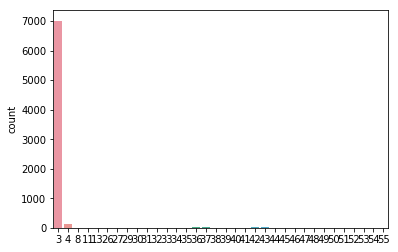

Minimum annotations in a example:  3
Maximum annotations in a example:  55
T data (expected value):  3.9093387866394003
Graphics of T weights


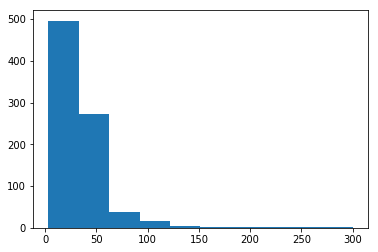

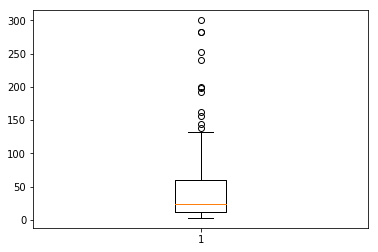

Minimum annotations by an annotator:  3
Maximum annotations by an annotator:  300
Mean annotations by an annotator:  34.25925925925926


In [7]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.264621 sec
Estimation MV in 0.000791 sec
ACC MV on train: 0.9548022598870056
F1 MV on train: 0.9607433084876694
Normalized entropy (0-1) of repeats annotations: 0.1748801127837196


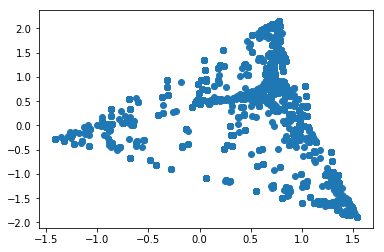

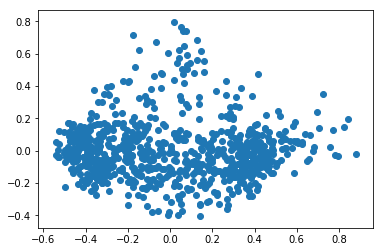

In [8]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
mask_true = Z_train!=-1
print("ACC MV on train:",np.mean(mv_onehot[mask_true]==Z_train[mask_true]))
print("F1 MV on train:",f1_score(Z_train[mask_true],mv_onehot[mask_true],average="macro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

### Texto

In [184]:
folder = "../Nuevos/TEXTO/pcbi.1000391.s002/annotation-data/"
from scipy.io import loadmat
ann = loadmat(folder+"patterns8.mat")
ann

{'E': array([[ 4,  2,  1, ..., -1, -1, -1],
        [ 4,  2,  1, ..., -1, -1, -1],
        [ 3,  3,  3, ..., -1, -1, -1],
        ...,
        [ 3,  3, -1, ..., -1, -1,  3],
        [ 1,  3, -1, ..., -1, -1,  3],
        [ 4,  3, -1, ..., -1, -1,  3]], dtype=int16),
 'Ep': array([[219, 406, 177, 320, 285, 203, 206, 222],
        [  6, 148,   9,  93,   3,  80, 200, 161],
        [  1,   4,   2,  14,   6,  14,   6,   8],
        [ 38,  48,  13,  37,   8,  40, 101,  78],
        [  9,   8,   0,   0,   0,   0,   0,   0],
        [118,   3, 273,  15, 331,   5,   2,   0],
        [  9,  17,  31,  10,  17,   0,  11,   0],
        [  1,   2,   9,   2,   5,   2,   2,   0],
        [ 18,   2,  47,   3,  18,   0,   1,   1],
        [  2,   0,   0,   0,   0,   0,   0,   0],
        [  3,  11,   3,   2,  21,   5,   1,   0],
        [  0,   3,   0,   5,  21,   0,   0,   2],
        [  9,  31,  15,   7,  19,   6,   5,   8],
        [  1,   3,   3,   1,   2,   0,   0,   5],
        [  0,   1,   0,   0

In [191]:
y_obs = ann["F"]
y_obs

array([[ 4,  4,  4, ..., -1, -1, -1],
       [ 4,  4,  4, ..., -1, -1, -1],
       [ 4,  4,  4, ..., -1, -1, -1],
       ...,
       [ 4,  1, -1, ..., -1, -1,  4],
       [ 1,  4, -1, ..., -1, -1,  4],
       [ 4,  4, -1, ..., -1, -1,  4]], dtype=int16)

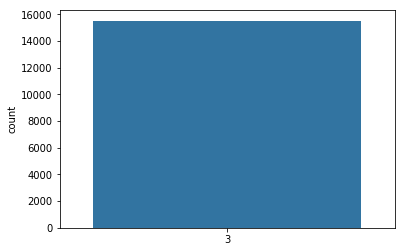

Minimum annotations in a example:  3
Maximum annotations in a example:  3
T data (expected value):  3.0
Graphics of T weights


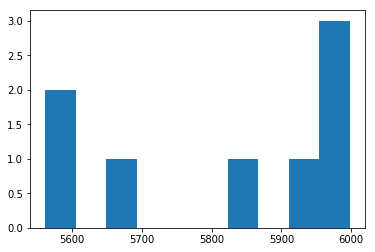

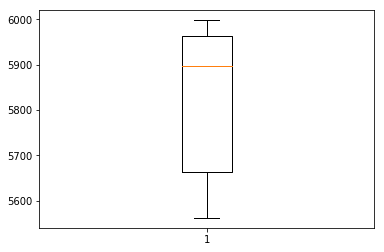

Minimum annotations by an annotator:  5562
Maximum annotations by an annotator:  5998
Mean annotations by an annotator:  5820.375


In [192]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

### Birds

In [2]:
folder = "../Birds/attributes/"
df_ann = pd.read_csv(folder+"labels.txt", header=None, names=["ID","attID","is","cert","wID"], sep=' ')
print(df_ann.shape)
df_ann.head() ## ASUMIMOS QUE CADA ANOTADOR SOLO DICE UN ATRIBUTO--verificar

(8878904, 5)


ID  attID  is  cert  wID
0   0      0   1     0    0
1   0      1   1     0    0
2   0      1   0     0    0
3   0      1   1     0    1
4   0      1   1     1    2

In [37]:
for i in range(df_ann["attID"].max()):
    T = len(df_ann[df_ann["attID"] == i]["wID"].unique())
    print("For att %d there is %d annotators"%(i,T))

For att 0 there is 349 annotators
For att 1 there is 445 annotators
For att 2 there is 445 annotators
For att 3 there is 445 annotators
For att 4 there is 445 annotators
For att 5 there is 445 annotators
For att 6 there is 445 annotators
For att 7 there is 445 annotators
For att 8 there is 445 annotators
For att 9 there is 445 annotators
For att 10 there is 445 annotators
For att 11 there is 445 annotators
For att 12 there is 445 annotators
For att 13 there is 445 annotators
For att 14 there is 445 annotators
For att 15 there is 472 annotators
For att 16 there is 472 annotators
For att 17 there is 472 annotators
For att 18 there is 472 annotators
For att 19 there is 472 annotators
For att 20 there is 472 annotators
For att 21 there is 472 annotators
For att 22 there is 472 annotators
For att 23 there is 472 annotators
For att 24 there is 472 annotators
For att 25 there is 472 annotators
For att 26 there is 472 annotators
For att 27 there is 472 annotators
For att 28 there is 472 annota

For att 232 there is 460 annotators
For att 233 there is 460 annotators
For att 234 there is 460 annotators
For att 235 there is 447 annotators
For att 236 there is 447 annotators
For att 237 there is 447 annotators
For att 238 there is 447 annotators
For att 239 there is 447 annotators
For att 240 there is 447 annotators
For att 241 there is 447 annotators
For att 242 there is 447 annotators
For att 243 there is 447 annotators
For att 244 there is 447 annotators
For att 245 there is 447 annotators
For att 246 there is 447 annotators
For att 247 there is 447 annotators
For att 248 there is 447 annotators
For att 249 there is 456 annotators
For att 250 there is 456 annotators
For att 251 there is 456 annotators
For att 252 there is 456 annotators
For att 253 there is 456 annotators
For att 254 there is 456 annotators
For att 255 there is 456 annotators
For att 256 there is 456 annotators
For att 257 there is 456 annotators
For att 258 there is 456 annotators
For att 259 there is 456 ann

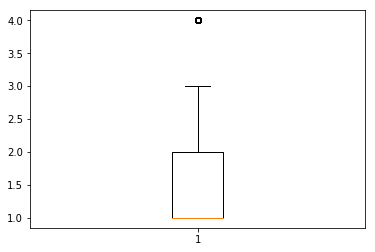

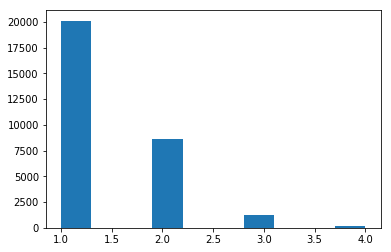

In [29]:
worker_ann = {}
for i in range(df_ann_aux.shape[0]):
    inp_id = df_ann_aux["ID"].iloc[i]
    work_id = df_ann_aux["wID"].iloc[i]
    if df_ann_aux["is"].iloc[i] == 1:
        if work_id not in worker_ann:
            worker_ann[work_id] = {}
        else:
            pass

        if inp_id in worker_ann[work_id]:
            worker_ann[work_id][inp_id] += 1
        else:
            #worker_ann[work_id] = {inp_id: 1}
            worker_ann[work_id][inp_id] = 1

ann_data = []
for ann, annotations in worker_ann.items():
    for data, n_ann in annotations.items():
        ann_data.append(n_ann)
plt.boxplot(ann_data)
plt.show()
plt.hist(ann_data)
plt.show()

In [3]:
aux = pd.read_csv(folder+"attributes.txt", header=None, sep=' ', names=["id","thing"])
key_dic = {}
value_dic = {}
for i, value in enumerate(aux["thing"].values):
    cat_key, cat_value = value.split("::")
    key_dic[i] = cat_key
    value_dic[i] = cat_value
    
df_ann["att"] = df_ann["attID"].apply(lambda x: key_dic[x])
df_ann["class"] = df_ann["attID"].apply(lambda x: value_dic[x] )
df_ann.drop(["attID"],axis=1, inplace=True)
df_ann.head()

ID  is  cert  wID              att  class
0   0   1     0    0  has_crown_color   blue
1   0   1     0    0  has_crown_color  black
2   0   0     0    0  has_crown_color  black
3   0   1     0    1  has_crown_color  black
4   0   1     1    2  has_crown_color  black

In [147]:
for i, value in enumerate(aux["thing"].values):
    cat_key, cat_value = value.split("::")
    
    #if cat_key in labels:
    #    labels_name[cat_key].append(cat_value)
    #    labels_name[cat_key].append(cat_value)
    #    cont+=1
    #else:
    #    labels_name[cat_key] = [cat_value]
    #    labels_numb[cat_key] = 0
    
labels["has_shape"]

['perching-like',
 'tree-clinging-like',
 'gull-like',
 'duck-like',
 'swallow-like',
 'upright-perching',
 'sandpiper-like',
 'upland-ground-like',
 'chicken-like-marsh',
 'pigeon-like',
 'long-legged-like',
 'hummingbird-like',
 'hawk-like',
 'owl-like']

In [4]:
key_dic

{0: 'has_crown_color',
 1: 'has_crown_color',
 2: 'has_crown_color',
 3: 'has_crown_color',
 4: 'has_crown_color',
 5: 'has_crown_color',
 6: 'has_crown_color',
 7: 'has_crown_color',
 8: 'has_crown_color',
 9: 'has_crown_color',
 10: 'has_crown_color',
 11: 'has_crown_color',
 12: 'has_crown_color',
 13: 'has_crown_color',
 14: 'has_crown_color',
 15: 'has_nape_color',
 16: 'has_nape_color',
 17: 'has_nape_color',
 18: 'has_nape_color',
 19: 'has_nape_color',
 20: 'has_nape_color',
 21: 'has_nape_color',
 22: 'has_nape_color',
 23: 'has_nape_color',
 24: 'has_nape_color',
 25: 'has_nape_color',
 26: 'has_nape_color',
 27: 'has_nape_color',
 28: 'has_nape_color',
 29: 'has_nape_color',
 30: 'has_bill_shape',
 31: 'has_bill_shape',
 32: 'has_bill_shape',
 33: 'has_bill_shape',
 34: 'has_bill_shape',
 35: 'has_bill_shape',
 36: 'has_bill_shape',
 37: 'has_bill_shape',
 38: 'has_bill_shape',
 39: 'has_head_pattern',
 40: 'has_head_pattern',
 41: 'has_head_pattern',
 42: 'has_head_pattern'

In [12]:
att_showed = "has_wing_shape" #has_wing_shape, has_size, has_wing_pattern

mask_opt = df_ann["att"] == att_showed 
df_ann_aux = df_ann[mask_opt]

labels_names = df_ann_aux["class"].unique()
labels_dic = {lab:i for i,lab in enumerate(labels_names)}
Kl = len(labels_names)
print(Kl)
labels_names

5


array(['pointed-wings', 'tapered-wings', 'long-wings', 'rounded-wings',
       'broad-wings'], dtype=object)

In [13]:
data_id = {}
worker_id = {}
contador_data, contador_work = 0,0
for i in range(df_ann_aux.shape[0]):
    inp_id = df_ann_aux["ID"].iloc[i]
    if inp_id not in data_id:
        data_id[inp_id] = contador_data
        contador_data+=1        
    work_id = df_ann_aux["wID"].iloc[i]
    if work_id not in worker_id:
        worker_id[work_id] = contador_work
        contador_work+=1  
    
y_obs = np.ones((contador_data,contador_work),dtype='int16')*-1
r_cert = np.zeros((contador_data,Kl), dtype='int16')
for i in range(df_ann_aux.shape[0]):
    inp_id = df_ann_aux["ID"].iloc[i]
    work_id = df_ann_aux["wID"].iloc[i]
    if df_ann_aux["is"].iloc[i] == 1:
        if  y_obs[data_id[inp_id], worker_id[work_id]] != -1: #incentivar los errores
            if df_ann_aux["cert"].iloc[i] == 2: #incentiva harto
            #if df_ann_aux["cert"].iloc[i] == 2  or df_ann_aux["cert"].iloc[i] == 0: #incetiva poco
                print("Entra")
                y_obs[data_id[inp_id], worker_id[work_id]] = labels_dic[df_ann_aux["class"].iloc[i]]
        else:
            y_obs[data_id[inp_id], worker_id[work_id]] = labels_dic[df_ann_aux["class"].iloc[i]]
            
            
        if df_ann_aux["cert"].iloc[i] == 1:
            r_cert[data_id[inp_id], labels_dic[df_ann_aux["class"].iloc[i]]]+=1
        
##clean annotators
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
y_obs = y_obs[:,T_weights != 0]
## clean data
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor
y_obs = y_obs[N_ann != 0,:]
r_cert = r_cert[N_ann != 0,:]
y_obs.shape

Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entra
Entr

(6033, 484)

In [14]:
mask_nGT = r_cert.sum(axis=-1) == 0
print("Data sin GT: ",np.sum(mask_nGT))
Z_train = r_cert.argmax(axis=-1)
Z_train[mask_nGT] = -1
Z_train

Data sin GT:  1496


array([-1, -1, -1, ...,  1, -1,  0])

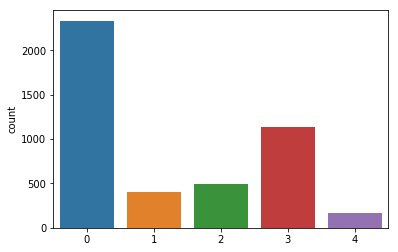

In [15]:
sns.countplot(Z_train[~mask_nGT])

Data sin GT:  27


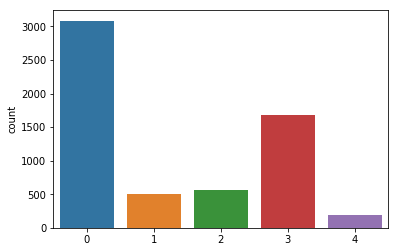

In [16]:
## aumenta la cantidad de datos con GT y aumenta el acc de mv..

for i in range(df_ann_aux.shape[0]):
    inp_id = df_ann_aux["ID"].iloc[i]
    work_id = df_ann_aux["wID"].iloc[i]
    if Z_train[inp_id] == -1:
        if df_ann_aux["is"].iloc[i] == 1 and df_ann_aux["cert"].iloc[i] == 0: #rellenar GT
            r_cert[data_id[inp_id], labels_dic[df_ann_aux["class"].iloc[i]]] += 1
mask_nGT = r_cert.sum(axis=-1) == 0
print("Data sin GT: ",np.sum(mask_nGT))
Z_train = r_cert.argmax(axis=-1)
Z_train[mask_nGT] = -1

sns.countplot(Z_train[~mask_nGT])

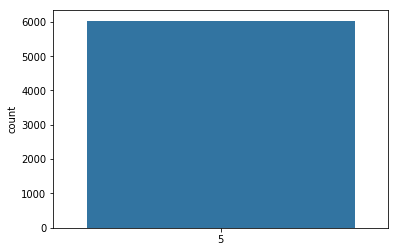

Minimum annotations in a example:  5
Maximum annotations in a example:  5
T data (expected value):  5.0
Graphics of T weights


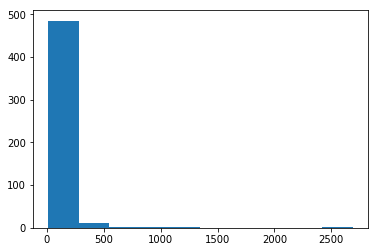

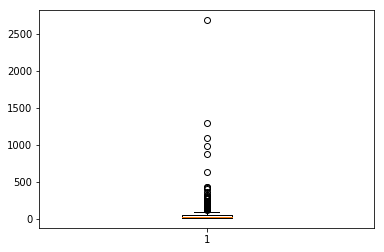

Minimum annotations by an annotator:  12
Maximum annotations by an annotator:  2688
Mean annotations by an annotator:  59.97017892644135


In [339]:
#graphics and distribution? what is T_data
T_weights = np.sum(y_obs != -1,axis=0) #distribucion de anotaciones
N_ann = np.sum(y_obs != -1,axis=1) #distribucion de anotaciones con este valor

N, T = y_obs.shape
Kl = np.max(y_obs)+1

sns.countplot(N_ann)
plt.show()
print("Minimum annotations in a example: ",N_ann.min())
print("Maximum annotations in a example: ",N_ann.max())
print("T data (expected value): ",N_ann.mean())

print("Graphics of T weights")
plt.hist(T_weights)
plt.show()

plt.boxplot(T_weights)
plt.show()
print("Minimum annotations by an annotator: ",T_weights.min())
print("Maximum annotations by an annotator: ",T_weights.max())
print("Mean annotations by an annotator: ",T_weights.mean())

Representation for MV in 0.252041 sec
Estimation MV in 0.000531 sec
ACC MV on train: 0.8424481398937083
F1 MV on train: 0.763978535988452
Normalized entropy (0-1) of repeats annotations: 0.3830772686504354


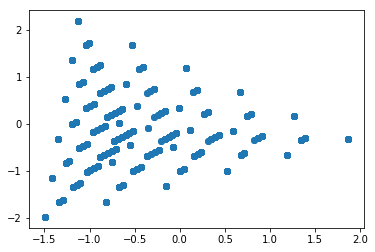

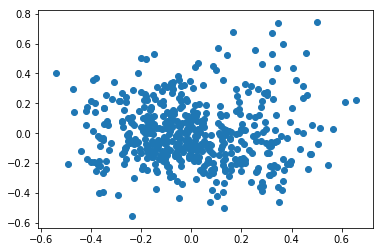

In [340]:
from sklearn.metrics import f1_score
label_I = LabelInference(y_obs,1,type_inf = 'mv')
mv_onehot, conf = label_I.mv_labels('classes')
mask_true = Z_train!=-1
print("ACC MV on train:",np.mean(mv_onehot[mask_true]==Z_train[mask_true]))
print("F1 MV on train:",f1_score(Z_train[mask_true],mv_onehot[mask_true],average="macro"))


mv_soft = majority_voting(label_I.y_obs_repeat,repeats=True,probas=True) 
aux = []
for example in mv_soft:
    aux.append(entropy(example)/np.log(Kl))
print("Normalized entropy (0-1) of repeats annotations:",np.mean(aux))

predicted = np.clip(mv_soft, keras.backend.epsilon(), 1.)
data_to_cluster = []
for i in range(mv_soft.shape[0]):
    for j in range(mv_soft.shape[1]):
        ob = np.tile(keras.backend.epsilon(), mv_soft.shape[1])
        ob[j] = 1
        true = np.clip(predicted[i],keras.backend.epsilon(),1.)      
        f_l = distance_function(true, ob)  #funcion de distancia o similaridad
        data_to_cluster.append(f_l)  
data_to_cluster = np.asarray(data_to_cluster)
model = PCA(n_components=min(3,mv_soft.shape[1]) ) 
data_to_cluster = model.fit_transform(data_to_cluster)

std = StandardScaler(with_mean=True,with_std=True)
data_to_plot = std.fit_transform(data_to_cluster)
plt.scatter(data_to_plot[:,0],data_to_plot[:,1])
plt.show()


Y_ann_train, T_idx = set_representation(y_obs,"onehotvar")
from code.MixtureofGroups import *
conf_mat, conf_mat_norm  = build_conf_Yvar(Y_ann_train, T_idx, mv_soft.argmax(axis=-1))

A_rep = conf_mat_norm.reshape(conf_mat_norm.shape[0], Kl**2) #flatten

from sklearn.decomposition import PCA
model = PCA(2)
aux_pca = model.fit_transform(A_rep)
plt.scatter(aux_pca[:,0],aux_pca[:,1])
plt.show()

#### Info clases
* has_nape_color: N =6033 , T=472, T_d = 5, N_t = 64, K = 15, acc = 75,87
* has_bill_shape: N = 6033, T=498, T_d =5 , N_t =61 , K = 9, acc = 88,25
* has_head_pattern: N =6033 , T=479, T_d =5 , N_t =63 , K =11, acc =86,00 
    * has_belly_pattern: N =6033 , T=473, T_d =5 , N_t =64 , K =4 , acc = 91,52 
    * has_wing_shape: N =6033 , T=484, T_d = 5, N_t = 62, K = 5 , acc = 95,61 
* has_shape N =6033 , T=507, T_d =5 , N_t =59 , K = 14 , acc = 100 ** pareciera haber grupos**
* has_primary_color N = 6033, T=491, T_d =5 , N_t =61 , K = 15 , acc =66,72 
    * has_size N =6033 , T=503, T_d =5 , N_t =60 , K = 5 , acc =   100
* has_forehead_color N =6033 , T=464, T_d = 5, N_t = 65, K = 15 , acc = 80,72
* has_underparts_color N =6033 , T=479, T_d =5 , N_t =63 , K = 15 , acc = 70,58
    * has_breast_pattern N =6033 , T=458, T_d = 5, N_t = 66, K = 4 , acc =  100 
    * has_breast_color N = 6033, T=429, T_d =5, N_t = 70, K = xx , acc = xxx
    * has_back_pattern N =6033 , T=454, T_d = 5, N_t =66 , K = 4 , acc = 100
* has_back_color N =6033 , T=465, T_d =5 , N_t =65 , K = 15 , acc = 78,88
    * has_leg_color N = , T=, T_d = , N_t = , K = 15 , acc =  xxx
    * has_tail_pattern N = 6033, T=460, T_d = 5, N_t =66 , K = 4 , acc = 100
* has_under_tail_color N =6033 , T=447, T_d = 5, N_t =68 , K = 15 , acc =  69,43
* has_upper_tail_color N =6033 , T=456, T_d =5 , N_t =66 , K = 15 , acc = 72,22
    * has_wing_pattern N =6033 , T=470, T_d =5 , N_t = 64, K = 5 , acc = 100

### opciones:
|nombre         | $N$  | $T$ | $T_d$ | $N_t$ | $K$ | acc | F1 | grupos? |
|---|---|---|---|---|---|---|---|---|
| has_eye_color | 6033 | 459 | 5     | 66    | 14  |96  | 71  | se ven 2 grupos>> muy desbalanceado|
| has_crown_color| 6033| 445 | 5     | 68    | 15  |73  | 70  | similar a Labelme pero mas denso|
| has_belly_color|6033 | 461 | 5     | 65    | 15  |79  | 64  | pareciera haber 2 grupos |
| has_throat_color|6033| 446 | 5     | 68    | 15  | 84 | 71  | se podrian modelar 3 grupos |
| has_wing_color| 6033 | 463 | 5     | 65    | 15  | 57 | 56  | esparcido (Labelme mas denso) |

In [17]:
## open images
images_names = pd.read_csv("../Birds/lists/files.txt", header=None).values[:,0] ##test and train..
train_names = pd.read_csv("../Birds/lists/train.txt", header=None).values[:,0] ##test and train..
#test_names = pd.read_csv("../Birds/lists/test.txt", header=None).values[:,0] ##test and train..

mask_train = np.zeros((images_names.shape[0]), dtype='bool')
for i, value in enumerate(images_names):
    if value in train_names:
        mask_train[i] = True

np.savetxt("./Birds/answers.txt", y_obs[mask_train],delimiter=' ', fmt='%d')
np.savetxt("./Birds/Birds_Z_train.txt", Z_train[mask_train],delimiter=' ', fmt='%d')
np.savetxt("./Birds/Birds_Z_test.txt", Z_train[~mask_train],delimiter=' ', fmt='%d')